In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Add, LayerNormalization, Concatenate, Dropout, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from tensorflow.keras.layers import Layer, Conv2D, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

import os
import glob

In [15]:
# SAGAN https://arxiv.org/pdf/1805.08318.pdf
# following https://github.com/taki0112/Self-Attention-GAN-Tensorflow Code2
# shape of kernel line
# https://github.com/tensorflow/tensorflow/blob/d5163e15c21874fddb03fedaf2cc6316a590f490/tensorflow/python/keras/layers/convolutional.py#L194
# Based off googles attention mechanism
class SelfAttention(Model):
    def __init__(self, channels, **kwargs):
        super(SelfAttention, self).__init__()

        self.channels = channels
        self.filters_f = channels // 8
        self.filters_g = channels // 8
        self.filters_h = channels 
        
        self.f = Conv2D(self.filters_f, (1,1), strides=(1,1), padding='same')
        self.g = Conv2D(self.filters_g, (1,1), strides=(1,1), padding='same')
        self.h = Conv2D(self.filters_h, (1,1), strides=(1,1), padding='same')

        self.gamma = tf.Variable(0.0, trainable=True, name='gamma')
    
    
    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], -1, K.shape(x)[-1]])
        
        f = self.f(x) 
        g = self.g(x)       
        h = self.h(x)
        
        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)

        beta = K.softmax(s)
        
        
        o = tf.matmul(beta, hw_flatten(h))
        
        o = K.reshape(o, shape=K.shape(x))
        x = self.gamma * o + x
        
        return x
        

In [16]:
# network parameters
width = 32
height = 32
latent_dim = 100



def build_generator():
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_latent')



    x = Dense(4*4*256)(latent_inputs)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)
    x = Reshape((4,4,256))(x)


    x = UpSampling2D()(x)
    x = Conv2D(128,3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(64,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    x = SelfAttention(64)(x)
    
    x = UpSampling2D()(x)
    x = Conv2D(32,3, strides=1, padding='same')(x)    
    x = LeakyReLU(0.2)(x)
    x = BatchNormalization()(x)

    img_outputs = Conv2D(3,5, strides=1, activation='tanh', padding='same')(x)


    return Model(latent_inputs, img_outputs, name='generator')

generator = build_generator()
generator.summary()








Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_latent (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 4096)              16384     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 128)         29

In [17]:
def build_discriminator():
    inputs = Input(shape=(width,height,3), name='discriminator_input')
    
    

    
    x = Conv2D(64, 3, strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = SelfAttention(64)(x)
    
    x = Conv2D(128, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(258, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Conv2D(512, 3, strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    x = LayerNormalization()(x)
    
    x = Flatten()(x)

    valid = Dense(1)(x)



    return Model(inputs, valid, name='discriminator')
build_discriminator().summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
discriminator_input (InputLa [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
layer_normalization_8 (Layer (None, 16, 16, 64)        128       
_________________________________________________________________
self_attention_5 (SelfAttent (None, 16, 16, 64)        5201      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 128)       

In [6]:
def normalize_for_tanh(img):
    return (img - 127.5) / 127.5

def unnormalize_tanh(img):
    return (img + 1) / 2

In [7]:
df = pd.read_csv('./celeba-attribs.csv')

In [8]:
training_data_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=False,
    preprocessing_function=normalize_for_tanh)


training_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(32, 32),
    subset='training',
    shuffle=True,
    batch_size=162080,
    class_mode='raw')

Found 162080 validated image filenames.


In [9]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present > 0:
            print(attrib, present)

In [10]:
def attribs_to_str(encoded):
    return "\n".join([" : ".join([ attrib,str(present)]) for (present, attrib) in zip(encoded, get_attribs()) if present > 0 or present < -1])


In [11]:
# load into memory (needs a substantial amount)
# batch if it doesn't fit
training_data = training_generator.next()

In [18]:
generator = build_generator()
discriminator = build_discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5, beta_2=0.9)

In [19]:
@tf.function
def train_step_generator():
    
    batch_size = 64
    latent_dim = 100
    
    with tf.GradientTape() as gen_tape:    
        

        
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=True)       
        

        # gan loss
        fake_output = discriminator(generated_images, training=False)
        gen_loss = -tf.reduce_mean(fake_output)
   
        generator_loss = gen_loss


    
    gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss



@tf.function
def train_step_discriminator(images):
    
    batch_size = 64
    latent_dim = 100
    gp_lambda = 10
    
    with tf.GradientTape() as disc_tape:
        # generate 
        z = tf.random.normal((batch_size,latent_dim))       
        generated_images = generator(z, training=False)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated_images = generated_images * alpha + images * (1 - alpha)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated_images)
            interpolated_output = discriminator(interpolated_images, training=True)
        gp_gradients = gp_tape.gradient(interpolated_output, interpolated_images)
        
        # l2 norm on all axis except batch
        gp_gradients_l2_norm = tf.sqrt(tf.reduce_sum(tf.square(gp_gradients), axis=[1,2,3]))
        gp = tf.reduce_mean(tf.square(gp_gradients_l2_norm-1))
        
        
        
        loss_real = tf.reduce_mean(real_output)
        loss_fake = tf.reduce_mean(fake_output)
        disc_loss = (loss_fake - loss_real) + gp_lambda * gp 
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return loss_real, loss_fake
    
        
        
        

In [21]:
tf.__version__

'2.1.0'

Iteration [10000/100000]......0.216(s) gen: 105.23136 - disc_fake: -105.27219 - disc_real: -100.53530 - disc_real: 4.73689


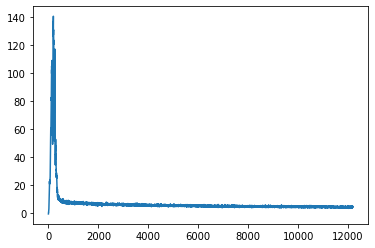

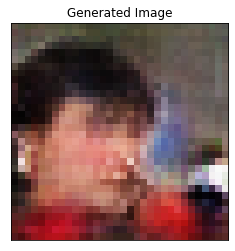

checkpointing at epoch: 10000
Iteration [10001/100000]......0.194(s) gen: 105.28828 - disc_fake: -105.39144 - disc_real: -101.07460 - disc_real: 4.31683
Iteration [10002/100000]......0.195(s) gen: 105.59071 - disc_fake: -105.31794 - disc_real: -100.98668 - disc_real: 4.33126
Iteration [10003/100000]......0.194(s) gen: 105.65964 - disc_fake: -105.66033 - disc_real: -101.24434 - disc_real: 4.41599
Iteration [10004/100000]......0.190(s) gen: 106.20360 - disc_fake: -105.95283 - disc_real: -101.88477 - disc_real: 4.06806
Iteration [10005/100000]......0.192(s) gen: 106.60832 - disc_fake: -106.35741 - disc_real: -102.89796 - disc_real: 3.45945
Iteration [10006/100000]......0.190(s) gen: 106.26689 - disc_fake: -106.58845 - disc_real: -102.38560 - disc_real: 4.20285
Iteration [10007/100000]......0.191(s) gen: 106.43654 - disc_fake: -106.38884 - disc_real: -102.11557 - disc_real: 4.27327
Iteration [10008/100000]......0.193(s) gen: 104.96660 - disc_fake: -105.99253 - disc_real: -101.63660 - disc_

Iteration [10068/100000]......0.193(s) gen: 105.58871 - disc_fake: -105.64625 - disc_real: -101.46910 - disc_real: 4.17715
Iteration [10069/100000]......0.192(s) gen: 105.66269 - disc_fake: -106.00233 - disc_real: -101.76776 - disc_real: 4.23457
Iteration [10070/100000]......0.189(s) gen: 106.20399 - disc_fake: -105.77746 - disc_real: -101.53383 - disc_real: 4.24363
Iteration [10071/100000]......0.189(s) gen: 106.57582 - disc_fake: -107.18999 - disc_real: -102.86645 - disc_real: 4.32354
Iteration [10072/100000]......0.189(s) gen: 106.12663 - disc_fake: -106.90804 - disc_real: -102.67863 - disc_real: 4.22940
Iteration [10073/100000]......0.191(s) gen: 106.48431 - disc_fake: -106.11198 - disc_real: -101.42985 - disc_real: 4.68213
Iteration [10074/100000]......0.191(s) gen: 106.21481 - disc_fake: -106.49121 - disc_real: -102.52642 - disc_real: 3.96478
Iteration [10075/100000]......0.189(s) gen: 105.71531 - disc_fake: -106.15319 - disc_real: -102.31399 - disc_real: 3.83920
Iteration [10076

Iteration [10135/100000]......0.193(s) gen: 105.70433 - disc_fake: -105.29141 - disc_real: -101.19490 - disc_real: 4.09651
Iteration [10136/100000]......0.194(s) gen: 106.27425 - disc_fake: -105.94987 - disc_real: -101.60905 - disc_real: 4.34082
Iteration [10137/100000]......0.193(s) gen: 106.51606 - disc_fake: -105.98472 - disc_real: -101.79518 - disc_real: 4.18954
Iteration [10138/100000]......0.192(s) gen: 106.94240 - disc_fake: -106.51724 - disc_real: -101.91029 - disc_real: 4.60695
Iteration [10139/100000]......0.191(s) gen: 105.75169 - disc_fake: -106.56771 - disc_real: -101.99375 - disc_real: 4.57395
Iteration [10140/100000]......0.192(s) gen: 105.39468 - disc_fake: -105.66103 - disc_real: -101.19335 - disc_real: 4.46768
Iteration [10141/100000]......0.193(s) gen: 105.52036 - disc_fake: -105.44914 - disc_real: -101.02137 - disc_real: 4.42777
Iteration [10142/100000]......0.195(s) gen: 104.74109 - disc_fake: -105.01136 - disc_real: -100.72200 - disc_real: 4.28936
Iteration [10143

Iteration [10203/100000]......0.194(s) gen: 106.71016 - disc_fake: -106.23888 - disc_real: -102.30937 - disc_real: 3.92951
Iteration [10204/100000]......0.194(s) gen: 106.92299 - disc_fake: -106.94240 - disc_real: -102.61391 - disc_real: 4.32849
Iteration [10205/100000]......0.200(s) gen: 107.03226 - disc_fake: -106.70544 - disc_real: -102.33285 - disc_real: 4.37259
Iteration [10206/100000]......0.196(s) gen: 106.77749 - disc_fake: -106.61486 - disc_real: -102.67708 - disc_real: 3.93778
Iteration [10207/100000]......0.195(s) gen: 105.63899 - disc_fake: -106.01152 - disc_real: -101.90593 - disc_real: 4.10559
Iteration [10208/100000]......0.196(s) gen: 104.96010 - disc_fake: -105.13731 - disc_real: -100.94399 - disc_real: 4.19332
Iteration [10209/100000]......0.195(s) gen: 104.51438 - disc_fake: -104.81726 - disc_real: -100.78333 - disc_real: 4.03393
Iteration [10210/100000]......0.192(s) gen: 105.41141 - disc_fake: -105.23637 - disc_real: -100.90804 - disc_real: 4.32833
Iteration [10211

Iteration [10270/100000]......0.205(s) gen: 106.78573 - disc_fake: -106.83290 - disc_real: -102.32326 - disc_real: 4.50964
Iteration [10271/100000]......0.203(s) gen: 106.44669 - disc_fake: -106.95720 - disc_real: -102.43873 - disc_real: 4.51848
Iteration [10272/100000]......0.202(s) gen: 105.62546 - disc_fake: -105.83706 - disc_real: -101.50208 - disc_real: 4.33498
Iteration [10273/100000]......0.205(s) gen: 106.08443 - disc_fake: -106.04276 - disc_real: -101.87421 - disc_real: 4.16854
Iteration [10274/100000]......0.201(s) gen: 105.36455 - disc_fake: -105.45678 - disc_real: -101.15053 - disc_real: 4.30625
Iteration [10275/100000]......0.201(s) gen: 105.13611 - disc_fake: -105.26981 - disc_real: -100.87998 - disc_real: 4.38983
Iteration [10276/100000]......0.199(s) gen: 105.98038 - disc_fake: -105.77263 - disc_real: -101.66542 - disc_real: 4.10722
Iteration [10277/100000]......0.196(s) gen: 106.69717 - disc_fake: -105.98962 - disc_real: -101.73794 - disc_real: 4.25168
Iteration [10278

Iteration [10337/100000]......0.194(s) gen: 105.94098 - disc_fake: -105.82793 - disc_real: -101.54906 - disc_real: 4.27887
Iteration [10338/100000]......0.194(s) gen: 106.11411 - disc_fake: -105.76557 - disc_real: -101.52799 - disc_real: 4.23758
Iteration [10339/100000]......0.194(s) gen: 105.96397 - disc_fake: -105.90690 - disc_real: -101.50186 - disc_real: 4.40503
Iteration [10340/100000]......0.193(s) gen: 105.79367 - disc_fake: -106.04667 - disc_real: -101.92796 - disc_real: 4.11870
Iteration [10341/100000]......0.194(s) gen: 106.66681 - disc_fake: -106.01340 - disc_real: -101.79841 - disc_real: 4.21500
Iteration [10342/100000]......0.194(s) gen: 106.52074 - disc_fake: -106.22711 - disc_real: -102.04975 - disc_real: 4.17736
Iteration [10343/100000]......0.194(s) gen: 107.21677 - disc_fake: -106.55653 - disc_real: -102.48581 - disc_real: 4.07072
Iteration [10344/100000]......0.193(s) gen: 107.67633 - disc_fake: -107.17176 - disc_real: -102.97411 - disc_real: 4.19766
Iteration [10345

Iteration [10404/100000]......0.192(s) gen: 105.44036 - disc_fake: -105.69353 - disc_real: -101.47332 - disc_real: 4.22021
Iteration [10405/100000]......0.192(s) gen: 105.82865 - disc_fake: -105.81578 - disc_real: -101.37975 - disc_real: 4.43603
Iteration [10406/100000]......0.193(s) gen: 107.28480 - disc_fake: -106.63076 - disc_real: -102.37754 - disc_real: 4.25322
Iteration [10407/100000]......0.196(s) gen: 108.31616 - disc_fake: -107.67592 - disc_real: -103.44143 - disc_real: 4.23449
Iteration [10408/100000]......0.192(s) gen: 108.81949 - disc_fake: -108.63559 - disc_real: -104.33262 - disc_real: 4.30297
Iteration [10409/100000]......0.193(s) gen: 107.83691 - disc_fake: -108.13171 - disc_real: -103.57014 - disc_real: 4.56157
Iteration [10410/100000]......0.193(s) gen: 108.35447 - disc_fake: -107.92359 - disc_real: -103.58018 - disc_real: 4.34341
Iteration [10411/100000]......0.197(s) gen: 107.12993 - disc_fake: -107.54160 - disc_real: -103.36080 - disc_real: 4.18080
Iteration [10412

Iteration [10472/100000]......0.197(s) gen: 106.40375 - disc_fake: -107.03593 - disc_real: -102.92860 - disc_real: 4.10733
Iteration [10473/100000]......0.197(s) gen: 106.07983 - disc_fake: -106.27252 - disc_real: -101.99051 - disc_real: 4.28200
Iteration [10474/100000]......0.197(s) gen: 106.13905 - disc_fake: -105.78401 - disc_real: -101.83068 - disc_real: 3.95334
Iteration [10475/100000]......0.196(s) gen: 107.43607 - disc_fake: -106.73242 - disc_real: -102.67028 - disc_real: 4.06213
Iteration [10476/100000]......0.197(s) gen: 107.49403 - disc_fake: -107.26595 - disc_real: -103.14507 - disc_real: 4.12088
Iteration [10477/100000]......0.199(s) gen: 108.00797 - disc_fake: -107.82647 - disc_real: -103.67443 - disc_real: 4.15204
Iteration [10478/100000]......0.201(s) gen: 109.27685 - disc_fake: -108.45926 - disc_real: -104.18055 - disc_real: 4.27871
Iteration [10479/100000]......0.200(s) gen: 108.42933 - disc_fake: -109.47575 - disc_real: -105.02896 - disc_real: 4.44679
Iteration [10480

Iteration [10540/100000]......0.196(s) gen: 107.12991 - disc_fake: -106.98622 - disc_real: -103.03936 - disc_real: 3.94686
Iteration [10541/100000]......0.198(s) gen: 106.88794 - disc_fake: -106.88856 - disc_real: -103.08023 - disc_real: 3.80833
Iteration [10542/100000]......0.195(s) gen: 107.68468 - disc_fake: -107.19960 - disc_real: -103.04543 - disc_real: 4.15418
Iteration [10543/100000]......0.200(s) gen: 106.90758 - disc_fake: -107.38210 - disc_real: -103.05809 - disc_real: 4.32401
Iteration [10544/100000]......0.192(s) gen: 106.63438 - disc_fake: -106.83822 - disc_real: -102.81321 - disc_real: 4.02500
Iteration [10545/100000]......0.197(s) gen: 105.83992 - disc_fake: -106.26228 - disc_real: -101.82352 - disc_real: 4.43877
Iteration [10546/100000]......0.196(s) gen: 106.07298 - disc_fake: -105.59897 - disc_real: -101.43186 - disc_real: 4.16711
Iteration [10547/100000]......0.194(s) gen: 106.71114 - disc_fake: -106.17835 - disc_real: -101.89348 - disc_real: 4.28487
Iteration [10548

Iteration [10607/100000]......0.193(s) gen: 107.44498 - disc_fake: -108.17943 - disc_real: -103.96185 - disc_real: 4.21758
Iteration [10608/100000]......0.194(s) gen: 106.87532 - disc_fake: -106.42968 - disc_real: -102.46890 - disc_real: 3.96078
Iteration [10609/100000]......0.197(s) gen: 107.68536 - disc_fake: -107.33626 - disc_real: -102.84264 - disc_real: 4.49361
Iteration [10610/100000]......0.200(s) gen: 108.91550 - disc_fake: -108.01732 - disc_real: -103.99780 - disc_real: 4.01952
Iteration [10611/100000]......0.203(s) gen: 107.93666 - disc_fake: -108.36658 - disc_real: -103.96563 - disc_real: 4.40095
Iteration [10612/100000]......0.201(s) gen: 107.72583 - disc_fake: -107.45374 - disc_real: -103.44046 - disc_real: 4.01327
Iteration [10613/100000]......0.216(s) gen: 107.39871 - disc_fake: -107.58238 - disc_real: -103.73411 - disc_real: 3.84827
Iteration [10614/100000]......0.200(s) gen: 107.79391 - disc_fake: -107.59302 - disc_real: -103.46416 - disc_real: 4.12885
Iteration [10615

Iteration [10674/100000]......0.200(s) gen: 106.41237 - disc_fake: -106.75999 - disc_real: -102.23953 - disc_real: 4.52045
Iteration [10675/100000]......0.203(s) gen: 107.05180 - disc_fake: -106.34841 - disc_real: -102.15418 - disc_real: 4.19423
Iteration [10676/100000]......0.203(s) gen: 107.36935 - disc_fake: -107.28583 - disc_real: -103.01877 - disc_real: 4.26705
Iteration [10677/100000]......0.202(s) gen: 106.78259 - disc_fake: -107.10527 - disc_real: -103.22508 - disc_real: 3.88019
Iteration [10678/100000]......0.199(s) gen: 106.41240 - disc_fake: -106.92524 - disc_real: -102.41482 - disc_real: 4.51042
Iteration [10679/100000]......0.196(s) gen: 107.54996 - disc_fake: -106.82802 - disc_real: -102.63634 - disc_real: 4.19167
Iteration [10680/100000]......0.195(s) gen: 106.89195 - disc_fake: -107.49685 - disc_real: -103.14240 - disc_real: 4.35445
Iteration [10681/100000]......0.195(s) gen: 107.22089 - disc_fake: -106.69150 - disc_real: -102.46346 - disc_real: 4.22804
Iteration [10682

Iteration [10742/100000]......0.195(s) gen: 107.77990 - disc_fake: -107.83055 - disc_real: -103.76374 - disc_real: 4.06681
Iteration [10743/100000]......0.197(s) gen: 107.53956 - disc_fake: -107.41904 - disc_real: -103.04904 - disc_real: 4.37000
Iteration [10744/100000]......0.198(s) gen: 107.87161 - disc_fake: -107.42765 - disc_real: -103.43380 - disc_real: 3.99385
Iteration [10745/100000]......0.198(s) gen: 108.78151 - disc_fake: -108.23216 - disc_real: -103.72092 - disc_real: 4.51125
Iteration [10746/100000]......0.198(s) gen: 109.08651 - disc_fake: -108.55959 - disc_real: -104.76957 - disc_real: 3.79002
Iteration [10747/100000]......0.200(s) gen: 109.23279 - disc_fake: -108.88861 - disc_real: -104.48999 - disc_real: 4.39862
Iteration [10748/100000]......0.200(s) gen: 109.06944 - disc_fake: -108.97751 - disc_real: -104.79833 - disc_real: 4.17918
Iteration [10749/100000]......0.201(s) gen: 108.66100 - disc_fake: -108.19935 - disc_real: -104.32300 - disc_real: 3.87635
Iteration [10750

Iteration [10809/100000]......0.204(s) gen: 108.91656 - disc_fake: -108.95730 - disc_real: -104.55256 - disc_real: 4.40474
Iteration [10810/100000]......0.203(s) gen: 109.20173 - disc_fake: -108.54237 - disc_real: -104.78970 - disc_real: 3.75267
Iteration [10811/100000]......0.201(s) gen: 108.68745 - disc_fake: -109.00261 - disc_real: -104.91945 - disc_real: 4.08316
Iteration [10812/100000]......0.199(s) gen: 108.96602 - disc_fake: -108.79164 - disc_real: -104.47108 - disc_real: 4.32056
Iteration [10813/100000]......0.199(s) gen: 108.45604 - disc_fake: -108.68980 - disc_real: -104.35274 - disc_real: 4.33706
Iteration [10814/100000]......0.197(s) gen: 109.32829 - disc_fake: -108.52564 - disc_real: -104.55290 - disc_real: 3.97273
Iteration [10815/100000]......0.199(s) gen: 108.72254 - disc_fake: -108.73272 - disc_real: -104.43150 - disc_real: 4.30121
Iteration [10816/100000]......0.200(s) gen: 108.14400 - disc_fake: -108.47320 - disc_real: -104.09158 - disc_real: 4.38162
Iteration [10817

Iteration [10876/100000]......0.197(s) gen: 109.38575 - disc_fake: -109.94758 - disc_real: -105.64883 - disc_real: 4.29875
Iteration [10877/100000]......0.195(s) gen: 108.18877 - disc_fake: -108.68142 - disc_real: -104.28558 - disc_real: 4.39584
Iteration [10878/100000]......0.195(s) gen: 108.30433 - disc_fake: -107.88727 - disc_real: -103.23606 - disc_real: 4.65121
Iteration [10879/100000]......0.197(s) gen: 108.35944 - disc_fake: -108.09264 - disc_real: -104.08502 - disc_real: 4.00762
Iteration [10880/100000]......0.196(s) gen: 109.55247 - disc_fake: -108.77758 - disc_real: -104.78922 - disc_real: 3.98836
Iteration [10881/100000]......0.196(s) gen: 109.29412 - disc_fake: -109.32647 - disc_real: -105.03114 - disc_real: 4.29533
Iteration [10882/100000]......0.197(s) gen: 110.37508 - disc_fake: -109.57025 - disc_real: -105.81215 - disc_real: 3.75810
Iteration [10883/100000]......0.199(s) gen: 109.92509 - disc_fake: -110.56207 - disc_real: -106.34885 - disc_real: 4.21322
Iteration [10884

Iteration [10943/100000]......0.197(s) gen: 110.07532 - disc_fake: -109.64604 - disc_real: -105.46529 - disc_real: 4.18075
Iteration [10944/100000]......0.196(s) gen: 110.38664 - disc_fake: -110.44155 - disc_real: -106.43626 - disc_real: 4.00529
Iteration [10945/100000]......0.198(s) gen: 109.42346 - disc_fake: -110.25735 - disc_real: -106.13771 - disc_real: 4.11964
Iteration [10946/100000]......0.198(s) gen: 109.26663 - disc_fake: -109.12637 - disc_real: -104.88986 - disc_real: 4.23651
Iteration [10947/100000]......0.198(s) gen: 108.98065 - disc_fake: -108.59469 - disc_real: -104.40192 - disc_real: 4.19277
Iteration [10948/100000]......0.197(s) gen: 108.85639 - disc_fake: -108.76238 - disc_real: -104.45081 - disc_real: 4.31157
Iteration [10949/100000]......0.198(s) gen: 109.12378 - disc_fake: -108.69989 - disc_real: -104.29049 - disc_real: 4.40940
Iteration [10950/100000]......0.198(s) gen: 109.77846 - disc_fake: -109.31530 - disc_real: -104.96957 - disc_real: 4.34574
Iteration [10951

Iteration [11011/100000]......0.197(s) gen: 110.13412 - disc_fake: -110.25598 - disc_real: -105.59241 - disc_real: 4.66357
Iteration [11012/100000]......0.195(s) gen: 110.12368 - disc_fake: -110.09526 - disc_real: -105.50993 - disc_real: 4.58533
Iteration [11013/100000]......0.195(s) gen: 109.70134 - disc_fake: -109.81405 - disc_real: -105.89603 - disc_real: 3.91802
Iteration [11014/100000]......0.196(s) gen: 108.52180 - disc_fake: -109.21200 - disc_real: -104.90777 - disc_real: 4.30423
Iteration [11015/100000]......0.198(s) gen: 108.14348 - disc_fake: -108.38786 - disc_real: -103.46067 - disc_real: 4.92719
Iteration [11016/100000]......0.200(s) gen: 107.89515 - disc_fake: -108.09947 - disc_real: -103.94039 - disc_real: 4.15908
Iteration [11017/100000]......0.200(s) gen: 108.78355 - disc_fake: -108.21365 - disc_real: -104.12387 - disc_real: 4.08977
Iteration [11018/100000]......0.200(s) gen: 109.48936 - disc_fake: -108.91945 - disc_real: -104.49974 - disc_real: 4.41971
Iteration [11019

Iteration [11078/100000]......0.198(s) gen: 110.62845 - disc_fake: -110.20717 - disc_real: -106.14245 - disc_real: 4.06472
Iteration [11079/100000]......0.199(s) gen: 109.67044 - disc_fake: -110.34200 - disc_real: -105.93147 - disc_real: 4.41053
Iteration [11080/100000]......0.199(s) gen: 110.34844 - disc_fake: -109.84626 - disc_real: -105.75835 - disc_real: 4.08791
Iteration [11081/100000]......0.197(s) gen: 109.82358 - disc_fake: -109.90007 - disc_real: -105.78025 - disc_real: 4.11982
Iteration [11082/100000]......0.199(s) gen: 110.80109 - disc_fake: -110.21155 - disc_real: -105.99149 - disc_real: 4.22006
Iteration [11083/100000]......0.198(s) gen: 110.35501 - disc_fake: -110.19826 - disc_real: -106.33535 - disc_real: 3.86290
Iteration [11084/100000]......0.198(s) gen: 109.42173 - disc_fake: -109.56313 - disc_real: -105.67218 - disc_real: 3.89095
Iteration [11085/100000]......0.198(s) gen: 108.48166 - disc_fake: -108.90744 - disc_real: -104.54329 - disc_real: 4.36415
Iteration [11086

Iteration [11145/100000]......0.196(s) gen: 109.67725 - disc_fake: -109.24745 - disc_real: -105.07476 - disc_real: 4.17269
Iteration [11146/100000]......0.194(s) gen: 109.44191 - disc_fake: -109.27468 - disc_real: -104.94885 - disc_real: 4.32583
Iteration [11147/100000]......0.197(s) gen: 108.58173 - disc_fake: -108.98117 - disc_real: -104.99920 - disc_real: 3.98197
Iteration [11148/100000]......0.198(s) gen: 107.83495 - disc_fake: -108.34793 - disc_real: -103.50023 - disc_real: 4.84770
Iteration [11149/100000]......0.199(s) gen: 108.25583 - disc_fake: -107.82761 - disc_real: -103.13161 - disc_real: 4.69600
Iteration [11150/100000]......0.202(s) gen: 109.37955 - disc_fake: -108.31161 - disc_real: -103.99787 - disc_real: 4.31374
Iteration [11151/100000]......0.203(s) gen: 110.04224 - disc_fake: -109.56496 - disc_real: -105.66086 - disc_real: 3.90411
Iteration [11152/100000]......0.200(s) gen: 110.01672 - disc_fake: -110.57335 - disc_real: -106.03816 - disc_real: 4.53519
Iteration [11153

Iteration [11212/100000]......0.198(s) gen: 110.66337 - disc_fake: -110.29362 - disc_real: -106.42867 - disc_real: 3.86496
Iteration [11213/100000]......0.196(s) gen: 109.98174 - disc_fake: -110.24727 - disc_real: -106.08996 - disc_real: 4.15731
Iteration [11214/100000]......0.199(s) gen: 109.88405 - disc_fake: -110.03818 - disc_real: -105.85487 - disc_real: 4.18331
Iteration [11215/100000]......0.198(s) gen: 108.63435 - disc_fake: -109.43176 - disc_real: -105.44503 - disc_real: 3.98673
Iteration [11216/100000]......0.196(s) gen: 109.68889 - disc_fake: -109.19639 - disc_real: -105.20463 - disc_real: 3.99176
Iteration [11217/100000]......0.195(s) gen: 109.87611 - disc_fake: -109.63098 - disc_real: -105.54474 - disc_real: 4.08624
Iteration [11218/100000]......0.195(s) gen: 109.58611 - disc_fake: -109.29454 - disc_real: -105.16284 - disc_real: 4.13170
Iteration [11219/100000]......0.195(s) gen: 109.59479 - disc_fake: -109.67455 - disc_real: -105.82907 - disc_real: 3.84548
Iteration [11220

Iteration [11279/100000]......0.201(s) gen: 110.29940 - disc_fake: -110.15540 - disc_real: -106.37962 - disc_real: 3.77578
Iteration [11280/100000]......0.201(s) gen: 109.98095 - disc_fake: -110.18320 - disc_real: -105.96773 - disc_real: 4.21547
Iteration [11281/100000]......0.201(s) gen: 109.34360 - disc_fake: -109.80306 - disc_real: -105.37183 - disc_real: 4.43123
Iteration [11282/100000]......0.198(s) gen: 109.24016 - disc_fake: -109.71333 - disc_real: -105.23251 - disc_real: 4.48082
Iteration [11283/100000]......0.198(s) gen: 109.85574 - disc_fake: -109.52128 - disc_real: -105.78025 - disc_real: 3.74103
Iteration [11284/100000]......0.197(s) gen: 109.32530 - disc_fake: -109.96904 - disc_real: -105.60408 - disc_real: 4.36495
Iteration [11285/100000]......0.197(s) gen: 108.60814 - disc_fake: -109.00360 - disc_real: -104.61848 - disc_real: 4.38512
Iteration [11286/100000]......0.196(s) gen: 110.31322 - disc_fake: -109.29464 - disc_real: -105.00493 - disc_real: 4.28972
Iteration [11287

Iteration [11346/100000]......0.198(s) gen: 110.79529 - disc_fake: -111.00236 - disc_real: -106.33333 - disc_real: 4.66903
Iteration [11347/100000]......0.199(s) gen: 109.65031 - disc_fake: -110.52026 - disc_real: -105.76508 - disc_real: 4.75518
Iteration [11348/100000]......0.199(s) gen: 108.70273 - disc_fake: -109.63524 - disc_real: -105.03013 - disc_real: 4.60512
Iteration [11349/100000]......0.200(s) gen: 108.76431 - disc_fake: -109.60571 - disc_real: -105.12355 - disc_real: 4.48215
Iteration [11350/100000]......0.198(s) gen: 108.54945 - disc_fake: -108.62628 - disc_real: -104.90564 - disc_real: 3.72064
Iteration [11351/100000]......0.199(s) gen: 108.89629 - disc_fake: -109.22076 - disc_real: -104.97852 - disc_real: 4.24224
Iteration [11352/100000]......0.200(s) gen: 110.27681 - disc_fake: -110.08581 - disc_real: -105.61855 - disc_real: 4.46727
Iteration [11353/100000]......0.199(s) gen: 110.11910 - disc_fake: -110.48299 - disc_real: -106.39893 - disc_real: 4.08406
Iteration [11354

Iteration [11413/100000]......0.196(s) gen: 110.46333 - disc_fake: -109.73382 - disc_real: -105.69643 - disc_real: 4.03739
Iteration [11414/100000]......0.196(s) gen: 110.30098 - disc_fake: -110.46376 - disc_real: -106.73296 - disc_real: 3.73080
Iteration [11415/100000]......0.199(s) gen: 110.39821 - disc_fake: -110.36055 - disc_real: -106.28682 - disc_real: 4.07373
Iteration [11416/100000]......0.199(s) gen: 110.28848 - disc_fake: -109.91240 - disc_real: -105.67251 - disc_real: 4.23990
Iteration [11417/100000]......0.202(s) gen: 110.38210 - disc_fake: -110.29432 - disc_real: -106.06457 - disc_real: 4.22975
Iteration [11418/100000]......0.203(s) gen: 109.62878 - disc_fake: -109.65363 - disc_real: -105.03348 - disc_real: 4.62016
Iteration [11419/100000]......0.206(s) gen: 109.99265 - disc_fake: -109.49199 - disc_real: -105.61827 - disc_real: 3.87372
Iteration [11420/100000]......0.203(s) gen: 110.51456 - disc_fake: -110.46538 - disc_real: -105.83885 - disc_real: 4.62653
Iteration [11421

Iteration [11481/100000]......0.202(s) gen: 109.27571 - disc_fake: -108.95281 - disc_real: -104.75538 - disc_real: 4.19743
Iteration [11482/100000]......0.202(s) gen: 109.43009 - disc_fake: -109.07485 - disc_real: -104.71094 - disc_real: 4.36391
Iteration [11483/100000]......0.203(s) gen: 109.35617 - disc_fake: -109.30138 - disc_real: -105.04388 - disc_real: 4.25751
Iteration [11484/100000]......0.201(s) gen: 109.74065 - disc_fake: -109.83491 - disc_real: -105.50715 - disc_real: 4.32776
Iteration [11485/100000]......0.199(s) gen: 110.44915 - disc_fake: -109.93116 - disc_real: -105.98986 - disc_real: 3.94130
Iteration [11486/100000]......0.197(s) gen: 111.18659 - disc_fake: -110.47516 - disc_real: -106.34817 - disc_real: 4.12699
Iteration [11487/100000]......0.197(s) gen: 112.07642 - disc_fake: -111.45935 - disc_real: -107.41144 - disc_real: 4.04792
Iteration [11488/100000]......0.194(s) gen: 110.56200 - disc_fake: -111.75607 - disc_real: -107.02362 - disc_real: 4.73245
Iteration [11489

Iteration [11548/100000]......0.200(s) gen: 112.24054 - disc_fake: -111.79589 - disc_real: -107.58183 - disc_real: 4.21406
Iteration [11549/100000]......0.199(s) gen: 110.28233 - disc_fake: -111.37713 - disc_real: -106.85136 - disc_real: 4.52578
Iteration [11550/100000]......0.197(s) gen: 110.09992 - disc_fake: -110.83643 - disc_real: -106.43971 - disc_real: 4.39673
Iteration [11551/100000]......0.196(s) gen: 110.04251 - disc_fake: -110.56747 - disc_real: -106.07563 - disc_real: 4.49185
Iteration [11552/100000]......0.196(s) gen: 110.14220 - disc_fake: -111.14357 - disc_real: -106.59181 - disc_real: 4.55176
Iteration [11553/100000]......0.194(s) gen: 111.02734 - disc_fake: -110.98077 - disc_real: -106.23509 - disc_real: 4.74568
Iteration [11554/100000]......0.194(s) gen: 110.56062 - disc_fake: -110.95200 - disc_real: -106.75644 - disc_real: 4.19556
Iteration [11555/100000]......0.199(s) gen: 109.68191 - disc_fake: -110.85188 - disc_real: -106.82282 - disc_real: 4.02906
Iteration [11556

Iteration [11616/100000]......0.199(s) gen: 109.89581 - disc_fake: -109.75766 - disc_real: -105.44325 - disc_real: 4.31442
Iteration [11617/100000]......0.200(s) gen: 110.65350 - disc_fake: -109.86819 - disc_real: -106.03273 - disc_real: 3.83547
Iteration [11618/100000]......0.201(s) gen: 110.43414 - disc_fake: -110.46151 - disc_real: -106.32541 - disc_real: 4.13610
Iteration [11619/100000]......0.201(s) gen: 110.58279 - disc_fake: -110.37092 - disc_real: -106.24536 - disc_real: 4.12556
Iteration [11620/100000]......0.201(s) gen: 110.91711 - disc_fake: -110.71746 - disc_real: -106.33557 - disc_real: 4.38189
Iteration [11621/100000]......0.203(s) gen: 111.66124 - disc_fake: -111.20930 - disc_real: -106.74636 - disc_real: 4.46295
Iteration [11622/100000]......0.201(s) gen: 111.23389 - disc_fake: -111.22456 - disc_real: -107.10174 - disc_real: 4.12282
Iteration [11623/100000]......0.202(s) gen: 112.10934 - disc_fake: -111.37183 - disc_real: -107.20917 - disc_real: 4.16266
Iteration [11624

Iteration [11683/100000]......0.202(s) gen: 111.10489 - disc_fake: -111.71828 - disc_real: -107.74332 - disc_real: 3.97496
Iteration [11684/100000]......0.203(s) gen: 110.36450 - disc_fake: -111.17272 - disc_real: -107.18544 - disc_real: 3.98728
Iteration [11685/100000]......0.207(s) gen: 109.91168 - disc_fake: -109.84840 - disc_real: -105.45592 - disc_real: 4.39248
Iteration [11686/100000]......0.208(s) gen: 109.83059 - disc_fake: -109.69893 - disc_real: -105.20333 - disc_real: 4.49560
Iteration [11687/100000]......0.208(s) gen: 110.12373 - disc_fake: -109.53743 - disc_real: -105.44955 - disc_real: 4.08788
Iteration [11688/100000]......0.206(s) gen: 109.75023 - disc_fake: -110.06763 - disc_real: -105.71162 - disc_real: 4.35601
Iteration [11689/100000]......0.204(s) gen: 110.77838 - disc_fake: -109.76994 - disc_real: -106.21087 - disc_real: 3.55907
Iteration [11690/100000]......0.203(s) gen: 111.58634 - disc_fake: -110.94770 - disc_real: -107.38436 - disc_real: 3.56334
Iteration [11691

Iteration [11750/100000]......0.205(s) gen: 111.04513 - disc_fake: -110.87460 - disc_real: -106.78480 - disc_real: 4.08980
Iteration [11751/100000]......0.202(s) gen: 111.16566 - disc_fake: -110.97435 - disc_real: -106.97572 - disc_real: 3.99863
Iteration [11752/100000]......0.208(s) gen: 111.53429 - disc_fake: -110.84670 - disc_real: -107.01284 - disc_real: 3.83385
Iteration [11753/100000]......0.202(s) gen: 112.24721 - disc_fake: -111.67414 - disc_real: -107.30763 - disc_real: 4.36651
Iteration [11754/100000]......0.208(s) gen: 112.73906 - disc_fake: -112.12959 - disc_real: -107.76034 - disc_real: 4.36925
Iteration [11755/100000]......0.203(s) gen: 112.30936 - disc_fake: -112.35538 - disc_real: -108.54897 - disc_real: 3.80641
Iteration [11756/100000]......0.201(s) gen: 111.15887 - disc_fake: -111.55893 - disc_real: -107.92144 - disc_real: 3.63748
Iteration [11757/100000]......0.202(s) gen: 111.48891 - disc_fake: -111.16848 - disc_real: -106.84138 - disc_real: 4.32711
Iteration [11758

Iteration [11817/100000]......0.203(s) gen: 111.97023 - disc_fake: -111.58559 - disc_real: -107.62236 - disc_real: 3.96323
Iteration [11818/100000]......0.204(s) gen: 111.88673 - disc_fake: -112.10336 - disc_real: -107.75029 - disc_real: 4.35307
Iteration [11819/100000]......0.222(s) gen: 110.89133 - disc_fake: -111.32198 - disc_real: -107.46493 - disc_real: 3.85704
Iteration [11820/100000]......0.206(s) gen: 110.33589 - disc_fake: -110.70054 - disc_real: -106.69570 - disc_real: 4.00484
Iteration [11821/100000]......0.220(s) gen: 110.50430 - disc_fake: -110.22476 - disc_real: -106.16131 - disc_real: 4.06345
Iteration [11822/100000]......0.215(s) gen: 110.07058 - disc_fake: -110.43748 - disc_real: -106.43851 - disc_real: 3.99897
Iteration [11823/100000]......0.211(s) gen: 110.48921 - disc_fake: -110.10894 - disc_real: -106.31286 - disc_real: 3.79608
Iteration [11824/100000]......0.208(s) gen: 110.04619 - disc_fake: -110.38097 - disc_real: -106.40702 - disc_real: 3.97395
Iteration [11825

Iteration [11884/100000]......0.200(s) gen: 111.01248 - disc_fake: -110.48599 - disc_real: -106.33868 - disc_real: 4.14730
Iteration [11885/100000]......0.198(s) gen: 111.85497 - disc_fake: -111.15788 - disc_real: -107.23219 - disc_real: 3.92569
Iteration [11886/100000]......0.198(s) gen: 111.95978 - disc_fake: -111.82453 - disc_real: -107.65223 - disc_real: 4.17230
Iteration [11887/100000]......0.199(s) gen: 111.75060 - disc_fake: -111.55168 - disc_real: -107.72096 - disc_real: 3.83073
Iteration [11888/100000]......0.202(s) gen: 111.82563 - disc_fake: -111.40910 - disc_real: -107.51564 - disc_real: 3.89346
Iteration [11889/100000]......0.202(s) gen: 111.38158 - disc_fake: -111.47320 - disc_real: -107.59760 - disc_real: 3.87560
Iteration [11890/100000]......0.200(s) gen: 109.85779 - disc_fake: -110.26502 - disc_real: -106.14926 - disc_real: 4.11575
Iteration [11891/100000]......0.198(s) gen: 110.34557 - disc_fake: -109.94346 - disc_real: -105.73949 - disc_real: 4.20397
Iteration [11892

Iteration [11951/100000]......0.196(s) gen: 110.68823 - disc_fake: -111.17369 - disc_real: -107.06936 - disc_real: 4.10433
Iteration [11952/100000]......0.197(s) gen: 110.55641 - disc_fake: -110.81774 - disc_real: -106.54597 - disc_real: 4.27177
Iteration [11953/100000]......0.197(s) gen: 111.37206 - disc_fake: -111.01349 - disc_real: -106.63087 - disc_real: 4.38262
Iteration [11954/100000]......0.201(s) gen: 110.66640 - disc_fake: -111.01192 - disc_real: -106.49616 - disc_real: 4.51576
Iteration [11955/100000]......0.204(s) gen: 110.44499 - disc_fake: -110.13267 - disc_real: -106.00988 - disc_real: 4.12279
Iteration [11956/100000]......0.203(s) gen: 110.67440 - disc_fake: -110.41879 - disc_real: -106.34084 - disc_real: 4.07795
Iteration [11957/100000]......0.201(s) gen: 110.10786 - disc_fake: -110.01360 - disc_real: -106.38038 - disc_real: 3.63322
Iteration [11958/100000]......0.202(s) gen: 110.50154 - disc_fake: -110.03566 - disc_real: -106.33286 - disc_real: 3.70280
Iteration [11959

Iteration [12018/100000]......0.202(s) gen: 111.62180 - disc_fake: -112.27401 - disc_real: -107.75346 - disc_real: 4.52055
Iteration [12019/100000]......0.198(s) gen: 111.19582 - disc_fake: -111.85078 - disc_real: -107.62760 - disc_real: 4.22318
Iteration [12020/100000]......0.200(s) gen: 111.20502 - disc_fake: -111.40953 - disc_real: -107.18445 - disc_real: 4.22508
Iteration [12021/100000]......0.200(s) gen: 111.64340 - disc_fake: -111.43416 - disc_real: -107.13677 - disc_real: 4.29739
Iteration [12022/100000]......0.200(s) gen: 111.75539 - disc_fake: -111.62527 - disc_real: -107.31917 - disc_real: 4.30610
Iteration [12023/100000]......0.200(s) gen: 110.06560 - disc_fake: -110.45309 - disc_real: -106.37755 - disc_real: 4.07554
Iteration [12024/100000]......0.199(s) gen: 109.53793 - disc_fake: -110.37591 - disc_real: -105.49288 - disc_real: 4.88303
Iteration [12025/100000]......0.201(s) gen: 109.12093 - disc_fake: -109.09619 - disc_real: -104.78539 - disc_real: 4.31080
Iteration [12026

Iteration [12085/100000]......0.199(s) gen: 110.82889 - disc_fake: -111.90996 - disc_real: -107.83308 - disc_real: 4.07688
Iteration [12086/100000]......0.199(s) gen: 111.85674 - disc_fake: -111.51945 - disc_real: -107.32683 - disc_real: 4.19261
Iteration [12087/100000]......0.200(s) gen: 113.08976 - disc_fake: -112.38200 - disc_real: -108.15437 - disc_real: 4.22763
Iteration [12088/100000]......0.198(s) gen: 111.69392 - disc_fake: -113.06870 - disc_real: -108.81963 - disc_real: 4.24907
Iteration [12089/100000]......0.197(s) gen: 110.30605 - disc_fake: -111.09874 - disc_real: -107.06479 - disc_real: 4.03395
Iteration [12090/100000]......0.196(s) gen: 110.75555 - disc_fake: -110.95719 - disc_real: -106.66704 - disc_real: 4.29015
Iteration [12091/100000]......0.197(s) gen: 111.22502 - disc_fake: -110.53391 - disc_real: -106.54801 - disc_real: 3.98591
Iteration [12092/100000]......0.197(s) gen: 112.95211 - disc_fake: -112.10018 - disc_real: -108.17443 - disc_real: 3.92575
Iteration [12093

Iteration [12152/100000]......0.203(s) gen: 112.08807 - disc_fake: -111.86446 - disc_real: -107.87725 - disc_real: 3.98721
Iteration [12153/100000]......0.205(s) gen: 113.22499 - disc_fake: -112.34789 - disc_real: -108.84183 - disc_real: 3.50606
Iteration [12154/100000]......0.205(s) gen: 113.48488 - disc_fake: -113.08393 - disc_real: -109.22325 - disc_real: 3.86068
Iteration [12155/100000]......0.201(s) gen: 113.41267 - disc_fake: -113.48023 - disc_real: -109.67906 - disc_real: 3.80117
Iteration [12156/100000]......0.200(s) gen: 113.11160 - disc_fake: -113.27070 - disc_real: -109.10050 - disc_real: 4.17020
Iteration [12157/100000]......0.199(s) gen: 113.57631 - disc_fake: -113.30789 - disc_real: -109.47898 - disc_real: 3.82892
Iteration [12158/100000]......0.202(s) gen: 112.51747 - disc_fake: -113.10818 - disc_real: -109.12087 - disc_real: 3.98731
Iteration [12159/100000]......0.203(s) gen: 112.39806 - disc_fake: -112.40024 - disc_real: -108.25079 - disc_real: 4.14945
Iteration [12160

Iteration [12219/100000]......0.196(s) gen: 112.34085 - disc_fake: -112.24254 - disc_real: -107.85471 - disc_real: 4.38783
Iteration [12220/100000]......0.198(s) gen: 111.81693 - disc_fake: -112.21195 - disc_real: -107.47807 - disc_real: 4.73388
Iteration [12221/100000]......0.202(s) gen: 112.48833 - disc_fake: -111.73484 - disc_real: -107.53712 - disc_real: 4.19771
Iteration [12222/100000]......0.203(s) gen: 113.77676 - disc_fake: -112.76044 - disc_real: -108.87169 - disc_real: 3.88875
Iteration [12223/100000]......0.204(s) gen: 113.80063 - disc_fake: -113.24372 - disc_real: -109.34997 - disc_real: 3.89375
Iteration [12224/100000]......0.202(s) gen: 112.86975 - disc_fake: -113.88837 - disc_real: -109.54829 - disc_real: 4.34008
Iteration [12225/100000]......0.201(s) gen: 112.99255 - disc_fake: -112.75769 - disc_real: -108.80361 - disc_real: 3.95408
Iteration [12226/100000]......0.198(s) gen: 112.86662 - disc_fake: -113.33401 - disc_real: -109.05387 - disc_real: 4.28015
Iteration [12227

Iteration [12286/100000]......0.195(s) gen: 112.80838 - disc_fake: -112.37768 - disc_real: -108.82421 - disc_real: 3.55347
Iteration [12287/100000]......0.197(s) gen: 112.46164 - disc_fake: -112.39085 - disc_real: -108.42694 - disc_real: 3.96391
Iteration [12288/100000]......0.194(s) gen: 111.68290 - disc_fake: -112.12826 - disc_real: -107.81223 - disc_real: 4.31603
Iteration [12289/100000]......0.194(s) gen: 112.02424 - disc_fake: -111.75578 - disc_real: -108.05100 - disc_real: 3.70478
Iteration [12290/100000]......0.195(s) gen: 111.94700 - disc_fake: -112.15082 - disc_real: -107.73941 - disc_real: 4.41141
Iteration [12291/100000]......0.194(s) gen: 112.13492 - disc_fake: -111.83466 - disc_real: -107.68381 - disc_real: 4.15085
Iteration [12292/100000]......0.193(s) gen: 113.04227 - disc_fake: -112.43449 - disc_real: -108.70047 - disc_real: 3.73402
Iteration [12293/100000]......0.193(s) gen: 112.57084 - disc_fake: -112.88142 - disc_real: -108.41350 - disc_real: 4.46792
Iteration [12294

Iteration [12354/100000]......0.197(s) gen: 111.81032 - disc_fake: -111.60136 - disc_real: -107.52381 - disc_real: 4.07755
Iteration [12355/100000]......0.197(s) gen: 111.69939 - disc_fake: -111.59734 - disc_real: -107.05866 - disc_real: 4.53868
Iteration [12356/100000]......0.199(s) gen: 112.47772 - disc_fake: -112.22600 - disc_real: -108.08721 - disc_real: 4.13879
Iteration [12357/100000]......0.198(s) gen: 112.96657 - disc_fake: -112.59155 - disc_real: -109.12882 - disc_real: 3.46273
Iteration [12358/100000]......0.199(s) gen: 112.37310 - disc_fake: -112.98412 - disc_real: -108.48883 - disc_real: 4.49529
Iteration [12359/100000]......0.201(s) gen: 111.96695 - disc_fake: -112.40416 - disc_real: -108.61819 - disc_real: 3.78597
Iteration [12360/100000]......0.201(s) gen: 112.68759 - disc_fake: -112.27218 - disc_real: -108.21791 - disc_real: 4.05428
Iteration [12361/100000]......0.204(s) gen: 113.15579 - disc_fake: -113.18236 - disc_real: -109.16386 - disc_real: 4.01850
Iteration [12362

Iteration [12422/100000]......0.199(s) gen: 112.96665 - disc_fake: -112.75725 - disc_real: -108.56682 - disc_real: 4.19043
Iteration [12423/100000]......0.198(s) gen: 113.99197 - disc_fake: -113.08948 - disc_real: -109.17653 - disc_real: 3.91295
Iteration [12424/100000]......0.198(s) gen: 113.69333 - disc_fake: -113.72652 - disc_real: -109.79413 - disc_real: 3.93239
Iteration [12425/100000]......0.199(s) gen: 113.71613 - disc_fake: -114.18774 - disc_real: -109.83398 - disc_real: 4.35376
Iteration [12426/100000]......0.197(s) gen: 114.18799 - disc_fake: -113.40623 - disc_real: -109.68399 - disc_real: 3.72224
Iteration [12427/100000]......0.197(s) gen: 112.77631 - disc_fake: -113.37315 - disc_real: -109.37495 - disc_real: 3.99819
Iteration [12428/100000]......0.197(s) gen: 113.81361 - disc_fake: -113.09479 - disc_real: -109.09510 - disc_real: 3.99969
Iteration [12429/100000]......0.197(s) gen: 113.88229 - disc_fake: -113.44394 - disc_real: -109.40847 - disc_real: 4.03546
Iteration [12430

Iteration [12489/100000]......0.198(s) gen: 112.77217 - disc_fake: -112.68458 - disc_real: -108.88073 - disc_real: 3.80385
Iteration [12490/100000]......0.198(s) gen: 112.41010 - disc_fake: -112.56355 - disc_real: -108.46796 - disc_real: 4.09559
Iteration [12491/100000]......0.201(s) gen: 111.22047 - disc_fake: -111.76900 - disc_real: -107.57458 - disc_real: 4.19442
Iteration [12492/100000]......0.199(s) gen: 111.64472 - disc_fake: -111.44700 - disc_real: -107.03067 - disc_real: 4.41632
Iteration [12493/100000]......0.198(s) gen: 112.03662 - disc_fake: -112.06732 - disc_real: -108.01687 - disc_real: 4.05046
Iteration [12494/100000]......0.196(s) gen: 113.00961 - disc_fake: -112.86638 - disc_real: -108.63913 - disc_real: 4.22726
Iteration [12495/100000]......0.196(s) gen: 112.34912 - disc_fake: -112.93178 - disc_real: -108.55854 - disc_real: 4.37324
Iteration [12496/100000]......0.197(s) gen: 113.62688 - disc_fake: -113.01332 - disc_real: -108.71773 - disc_real: 4.29559
Iteration [12497

Iteration [12556/100000]......0.199(s) gen: 112.94852 - disc_fake: -113.04112 - disc_real: -109.00629 - disc_real: 4.03483
Iteration [12557/100000]......0.196(s) gen: 112.80559 - disc_fake: -113.17209 - disc_real: -109.31508 - disc_real: 3.85701
Iteration [12558/100000]......0.198(s) gen: 112.92453 - disc_fake: -112.91041 - disc_real: -108.74604 - disc_real: 4.16438
Iteration [12559/100000]......0.200(s) gen: 113.76566 - disc_fake: -113.15877 - disc_real: -109.00760 - disc_real: 4.15117
Iteration [12560/100000]......0.200(s) gen: 113.24414 - disc_fake: -113.21708 - disc_real: -109.66982 - disc_real: 3.54725
Iteration [12561/100000]......0.199(s) gen: 113.04887 - disc_fake: -112.61410 - disc_real: -108.75088 - disc_real: 3.86323
Iteration [12562/100000]......0.199(s) gen: 112.08749 - disc_fake: -113.05609 - disc_real: -108.61661 - disc_real: 4.43948
Iteration [12563/100000]......0.199(s) gen: 111.73871 - disc_fake: -112.20658 - disc_real: -107.68813 - disc_real: 4.51845
Iteration [12564

Iteration [12623/100000]......0.202(s) gen: 113.13559 - disc_fake: -113.58138 - disc_real: -109.52274 - disc_real: 4.05864
Iteration [12624/100000]......0.203(s) gen: 113.34895 - disc_fake: -113.06000 - disc_real: -109.28651 - disc_real: 3.77349
Iteration [12625/100000]......0.203(s) gen: 112.92348 - disc_fake: -113.07151 - disc_real: -109.51036 - disc_real: 3.56115
Iteration [12626/100000]......0.206(s) gen: 113.08003 - disc_fake: -112.46004 - disc_real: -108.75284 - disc_real: 3.70721
Iteration [12627/100000]......0.206(s) gen: 114.12852 - disc_fake: -113.21829 - disc_real: -109.08971 - disc_real: 4.12858
Iteration [12628/100000]......0.205(s) gen: 114.51598 - disc_fake: -114.10929 - disc_real: -110.34253 - disc_real: 3.76675
Iteration [12629/100000]......0.204(s) gen: 114.13664 - disc_fake: -114.31492 - disc_real: -110.24139 - disc_real: 4.07353
Iteration [12630/100000]......0.203(s) gen: 114.48012 - disc_fake: -114.55962 - disc_real: -110.31762 - disc_real: 4.24201
Iteration [12631

Iteration [12690/100000]......0.199(s) gen: 112.70567 - disc_fake: -111.94140 - disc_real: -108.26143 - disc_real: 3.67997
Iteration [12691/100000]......0.199(s) gen: 112.66767 - disc_fake: -112.31596 - disc_real: -108.20478 - disc_real: 4.11118
Iteration [12692/100000]......0.197(s) gen: 112.34320 - disc_fake: -112.42107 - disc_real: -108.60616 - disc_real: 3.81491
Iteration [12693/100000]......0.198(s) gen: 113.11530 - disc_fake: -112.26578 - disc_real: -108.22698 - disc_real: 4.03880
Iteration [12694/100000]......0.200(s) gen: 113.66605 - disc_fake: -112.94202 - disc_real: -109.18483 - disc_real: 3.75719
Iteration [12695/100000]......0.202(s) gen: 113.52301 - disc_fake: -113.42336 - disc_real: -109.69205 - disc_real: 3.73130
Iteration [12696/100000]......0.206(s) gen: 114.55322 - disc_fake: -113.52673 - disc_real: -109.66960 - disc_real: 3.85713
Iteration [12697/100000]......0.206(s) gen: 114.47466 - disc_fake: -114.77400 - disc_real: -110.67516 - disc_real: 4.09884
Iteration [12698

Iteration [12757/100000]......0.198(s) gen: 113.94760 - disc_fake: -113.89131 - disc_real: -109.75730 - disc_real: 4.13401
Iteration [12758/100000]......0.198(s) gen: 114.60373 - disc_fake: -113.94132 - disc_real: -109.71592 - disc_real: 4.22541
Iteration [12759/100000]......0.200(s) gen: 113.99849 - disc_fake: -114.40621 - disc_real: -110.08585 - disc_real: 4.32036
Iteration [12760/100000]......0.200(s) gen: 114.84055 - disc_fake: -114.49926 - disc_real: -110.20645 - disc_real: 4.29281
Iteration [12761/100000]......0.199(s) gen: 113.71146 - disc_fake: -114.42959 - disc_real: -110.12996 - disc_real: 4.29963
Iteration [12762/100000]......0.201(s) gen: 113.05649 - disc_fake: -113.35132 - disc_real: -109.32110 - disc_real: 4.03022
Iteration [12763/100000]......0.201(s) gen: 112.78058 - disc_fake: -112.98055 - disc_real: -109.20819 - disc_real: 3.77235
Iteration [12764/100000]......0.203(s) gen: 113.37886 - disc_fake: -112.94736 - disc_real: -108.97436 - disc_real: 3.97299
Iteration [12765

Iteration [12824/100000]......0.204(s) gen: 113.55841 - disc_fake: -113.93855 - disc_real: -109.76284 - disc_real: 4.17570
Iteration [12825/100000]......0.206(s) gen: 113.06166 - disc_fake: -113.04790 - disc_real: -109.25891 - disc_real: 3.78899
Iteration [12826/100000]......0.205(s) gen: 113.58343 - disc_fake: -113.10543 - disc_real: -109.38452 - disc_real: 3.72091
Iteration [12827/100000]......0.205(s) gen: 113.19789 - disc_fake: -112.76211 - disc_real: -108.75863 - disc_real: 4.00347
Iteration [12828/100000]......0.203(s) gen: 113.69739 - disc_fake: -113.47091 - disc_real: -108.88826 - disc_real: 4.58264
Iteration [12829/100000]......0.200(s) gen: 113.76404 - disc_fake: -113.86571 - disc_real: -109.46740 - disc_real: 4.39831
Iteration [12830/100000]......0.199(s) gen: 113.99120 - disc_fake: -113.97528 - disc_real: -110.56365 - disc_real: 3.41163
Iteration [12831/100000]......0.197(s) gen: 114.76027 - disc_fake: -114.18343 - disc_real: -110.62675 - disc_real: 3.55668
Iteration [12832

Iteration [12891/100000]......0.197(s) gen: 115.33900 - disc_fake: -115.14469 - disc_real: -111.17146 - disc_real: 3.97323
Iteration [12892/100000]......0.195(s) gen: 114.52940 - disc_fake: -115.22315 - disc_real: -111.25205 - disc_real: 3.97110
Iteration [12893/100000]......0.195(s) gen: 114.12656 - disc_fake: -114.47212 - disc_real: -110.13488 - disc_real: 4.33724
Iteration [12894/100000]......0.193(s) gen: 113.51991 - disc_fake: -113.95813 - disc_real: -109.32778 - disc_real: 4.63035
Iteration [12895/100000]......0.196(s) gen: 113.76254 - disc_fake: -113.71924 - disc_real: -109.89387 - disc_real: 3.82537
Iteration [12896/100000]......0.195(s) gen: 113.62890 - disc_fake: -113.39257 - disc_real: -109.46177 - disc_real: 3.93080
Iteration [12897/100000]......0.195(s) gen: 113.45128 - disc_fake: -113.57247 - disc_real: -109.53017 - disc_real: 4.04230
Iteration [12898/100000]......0.194(s) gen: 114.26016 - disc_fake: -113.59802 - disc_real: -110.01173 - disc_real: 3.58629
Iteration [12899

Iteration [12958/100000]......0.201(s) gen: 112.96375 - disc_fake: -114.04139 - disc_real: -110.31794 - disc_real: 3.72345
Iteration [12959/100000]......0.201(s) gen: 113.97594 - disc_fake: -113.63694 - disc_real: -109.74693 - disc_real: 3.89002
Iteration [12960/100000]......0.200(s) gen: 113.24001 - disc_fake: -114.20583 - disc_real: -109.70954 - disc_real: 4.49630
Iteration [12961/100000]......0.198(s) gen: 113.85039 - disc_fake: -113.17937 - disc_real: -109.72909 - disc_real: 3.45028
Iteration [12962/100000]......0.198(s) gen: 113.84413 - disc_fake: -113.67327 - disc_real: -109.70691 - disc_real: 3.96636
Iteration [12963/100000]......0.199(s) gen: 114.54822 - disc_fake: -114.16982 - disc_real: -110.03490 - disc_real: 4.13492
Iteration [12964/100000]......0.200(s) gen: 115.20119 - disc_fake: -114.77410 - disc_real: -110.63027 - disc_real: 4.14382
Iteration [12965/100000]......0.201(s) gen: 115.27252 - disc_fake: -115.52684 - disc_real: -111.31884 - disc_real: 4.20799
Iteration [12966

Iteration [13024/100000]......0.198(s) gen: 115.21182 - disc_fake: -115.07561 - disc_real: -111.31418 - disc_real: 3.76144
Iteration [13025/100000]......0.199(s) gen: 115.44557 - disc_fake: -114.94474 - disc_real: -110.91024 - disc_real: 4.03450
Iteration [13026/100000]......0.201(s) gen: 116.65465 - disc_fake: -115.99371 - disc_real: -112.20295 - disc_real: 3.79076
Iteration [13027/100000]......0.201(s) gen: 116.57504 - disc_fake: -116.68874 - disc_real: -112.62737 - disc_real: 4.06137
Iteration [13028/100000]......0.202(s) gen: 116.96614 - disc_fake: -117.31573 - disc_real: -113.10022 - disc_real: 4.21551
Iteration [13029/100000]......0.203(s) gen: 115.67470 - disc_fake: -116.46371 - disc_real: -112.42079 - disc_real: 4.04291
Iteration [13030/100000]......0.200(s) gen: 115.26613 - disc_fake: -115.34835 - disc_real: -111.20661 - disc_real: 4.14174
Iteration [13031/100000]......0.198(s) gen: 114.92428 - disc_fake: -114.84034 - disc_real: -111.00427 - disc_real: 3.83607
Iteration [13032

Iteration [13091/100000]......0.205(s) gen: 116.22474 - disc_fake: -115.99195 - disc_real: -112.19303 - disc_real: 3.79892
Iteration [13092/100000]......0.204(s) gen: 115.56947 - disc_fake: -116.11408 - disc_real: -112.03474 - disc_real: 4.07934
Iteration [13093/100000]......0.201(s) gen: 116.54379 - disc_fake: -115.75098 - disc_real: -112.22453 - disc_real: 3.52645
Iteration [13094/100000]......0.202(s) gen: 115.94553 - disc_fake: -116.12304 - disc_real: -112.34341 - disc_real: 3.77963
Iteration [13095/100000]......0.196(s) gen: 114.70660 - disc_fake: -115.08318 - disc_real: -111.08833 - disc_real: 3.99484
Iteration [13096/100000]......0.198(s) gen: 113.84439 - disc_fake: -114.62215 - disc_real: -109.98957 - disc_real: 4.63258
Iteration [13097/100000]......0.202(s) gen: 114.13533 - disc_fake: -114.18112 - disc_real: -110.29602 - disc_real: 3.88511
Iteration [13098/100000]......0.203(s) gen: 114.70607 - disc_fake: -114.15921 - disc_real: -110.86321 - disc_real: 3.29600
Iteration [13099

Iteration [13158/100000]......0.196(s) gen: 115.21097 - disc_fake: -115.38482 - disc_real: -111.55577 - disc_real: 3.82905
Iteration [13159/100000]......0.197(s) gen: 115.63954 - disc_fake: -115.17037 - disc_real: -111.27836 - disc_real: 3.89200
Iteration [13160/100000]......0.197(s) gen: 115.17888 - disc_fake: -115.37179 - disc_real: -111.79960 - disc_real: 3.57219
Iteration [13161/100000]......0.197(s) gen: 114.43004 - disc_fake: -115.04664 - disc_real: -110.97409 - disc_real: 4.07255
Iteration [13162/100000]......0.198(s) gen: 113.72743 - disc_fake: -114.27721 - disc_real: -109.96500 - disc_real: 4.31221
Iteration [13163/100000]......0.196(s) gen: 114.15175 - disc_fake: -113.97237 - disc_real: -110.00187 - disc_real: 3.97050
Iteration [13164/100000]......0.195(s) gen: 114.90405 - disc_fake: -114.40416 - disc_real: -110.49973 - disc_real: 3.90443
Iteration [13165/100000]......0.196(s) gen: 115.84669 - disc_fake: -115.16090 - disc_real: -111.49364 - disc_real: 3.66725
Iteration [13166

Iteration [13226/100000]......0.198(s) gen: 115.43597 - disc_fake: -115.47355 - disc_real: -111.46692 - disc_real: 4.00664
Iteration [13227/100000]......0.199(s) gen: 115.65843 - disc_fake: -115.66859 - disc_real: -111.42841 - disc_real: 4.24019
Iteration [13228/100000]......0.199(s) gen: 116.18563 - disc_fake: -115.67880 - disc_real: -111.84463 - disc_real: 3.83417
Iteration [13229/100000]......0.200(s) gen: 116.13152 - disc_fake: -116.62591 - disc_real: -112.52720 - disc_real: 4.09871
Iteration [13230/100000]......0.201(s) gen: 116.07748 - disc_fake: -116.45561 - disc_real: -112.40706 - disc_real: 4.04856
Iteration [13231/100000]......0.199(s) gen: 115.96358 - disc_fake: -115.75822 - disc_real: -111.86097 - disc_real: 3.89725
Iteration [13232/100000]......0.199(s) gen: 115.40884 - disc_fake: -115.32992 - disc_real: -111.50404 - disc_real: 3.82589
Iteration [13233/100000]......0.198(s) gen: 114.91720 - disc_fake: -115.18015 - disc_real: -111.37255 - disc_real: 3.80760
Iteration [13234

Iteration [13294/100000]......0.200(s) gen: 115.40261 - disc_fake: -115.53066 - disc_real: -111.70833 - disc_real: 3.82233
Iteration [13295/100000]......0.199(s) gen: 115.43481 - disc_fake: -115.62222 - disc_real: -111.45639 - disc_real: 4.16583
Iteration [13296/100000]......0.198(s) gen: 115.58992 - disc_fake: -115.27827 - disc_real: -111.36505 - disc_real: 3.91321
Iteration [13297/100000]......0.196(s) gen: 115.34205 - disc_fake: -115.21040 - disc_real: -111.31232 - disc_real: 3.89809
Iteration [13298/100000]......0.196(s) gen: 115.78526 - disc_fake: -115.71449 - disc_real: -111.93228 - disc_real: 3.78221
Iteration [13299/100000]......0.198(s) gen: 115.52493 - disc_fake: -115.74976 - disc_real: -111.76492 - disc_real: 3.98484
Iteration [13300/100000]......0.197(s) gen: 115.83028 - disc_fake: -115.26322 - disc_real: -111.43345 - disc_real: 3.82977
Iteration [13301/100000]......0.198(s) gen: 115.81459 - disc_fake: -116.30499 - disc_real: -112.41296 - disc_real: 3.89203
Iteration [13302

Iteration [13361/100000]......0.204(s) gen: 115.52910 - disc_fake: -115.63690 - disc_real: -110.84352 - disc_real: 4.79338
Iteration [13362/100000]......0.201(s) gen: 115.63390 - disc_fake: -115.23649 - disc_real: -111.02297 - disc_real: 4.21351
Iteration [13363/100000]......0.201(s) gen: 115.52138 - disc_fake: -115.57589 - disc_real: -111.75590 - disc_real: 3.82000
Iteration [13364/100000]......0.199(s) gen: 116.61932 - disc_fake: -116.28637 - disc_real: -112.11563 - disc_real: 4.17073
Iteration [13365/100000]......0.200(s) gen: 118.07650 - disc_fake: -116.93441 - disc_real: -113.74878 - disc_real: 3.18563
Iteration [13366/100000]......0.199(s) gen: 118.06699 - disc_fake: -118.09854 - disc_real: -113.93321 - disc_real: 4.16533
Iteration [13367/100000]......0.201(s) gen: 117.33067 - disc_fake: -117.35800 - disc_real: -113.52509 - disc_real: 3.83290
Iteration [13368/100000]......0.201(s) gen: 117.22600 - disc_fake: -117.59626 - disc_real: -113.39506 - disc_real: 4.20120
Iteration [13369

Iteration [13429/100000]......0.197(s) gen: 116.94951 - disc_fake: -115.78616 - disc_real: -112.15455 - disc_real: 3.63161
Iteration [13430/100000]......0.197(s) gen: 116.30369 - disc_fake: -116.95390 - disc_real: -113.16339 - disc_real: 3.79051
Iteration [13431/100000]......0.197(s) gen: 116.53310 - disc_fake: -116.13567 - disc_real: -112.24604 - disc_real: 3.88963
Iteration [13432/100000]......0.197(s) gen: 116.77080 - disc_fake: -116.84982 - disc_real: -112.71201 - disc_real: 4.13781
Iteration [13433/100000]......0.196(s) gen: 116.00586 - disc_fake: -116.48001 - disc_real: -112.60300 - disc_real: 3.87701
Iteration [13434/100000]......0.196(s) gen: 116.37967 - disc_fake: -116.17700 - disc_real: -112.34560 - disc_real: 3.83140
Iteration [13435/100000]......0.195(s) gen: 116.04253 - disc_fake: -115.90960 - disc_real: -112.11508 - disc_real: 3.79452
Iteration [13436/100000]......0.197(s) gen: 115.56602 - disc_fake: -115.73356 - disc_real: -111.65870 - disc_real: 4.07486
Iteration [13437

Iteration [13496/100000]......0.204(s) gen: 115.71892 - disc_fake: -115.15919 - disc_real: -111.40123 - disc_real: 3.75795
Iteration [13497/100000]......0.204(s) gen: 115.81236 - disc_fake: -115.58549 - disc_real: -111.64523 - disc_real: 3.94026
Iteration [13498/100000]......0.201(s) gen: 117.08257 - disc_fake: -115.92137 - disc_real: -112.38253 - disc_real: 3.53884
Iteration [13499/100000]......0.201(s) gen: 117.08026 - disc_fake: -116.69998 - disc_real: -112.96240 - disc_real: 3.73758
Iteration [13500/100000]......0.197(s) gen: 116.37550 - disc_fake: -116.62099 - disc_real: -112.89402 - disc_real: 3.72698
Iteration [13501/100000]......0.197(s) gen: 116.62167 - disc_fake: -116.20318 - disc_real: -112.38391 - disc_real: 3.81927
Iteration [13502/100000]......0.195(s) gen: 116.44981 - disc_fake: -116.37770 - disc_real: -112.52451 - disc_real: 3.85319
Iteration [13503/100000]......0.195(s) gen: 116.14310 - disc_fake: -116.05981 - disc_real: -112.22823 - disc_real: 3.83157
Iteration [13504

Iteration [13563/100000]......0.195(s) gen: 117.21305 - disc_fake: -118.25487 - disc_real: -114.14718 - disc_real: 4.10769
Iteration [13564/100000]......0.194(s) gen: 116.06728 - disc_fake: -116.39644 - disc_real: -112.25298 - disc_real: 4.14346
Iteration [13565/100000]......0.195(s) gen: 115.82803 - disc_fake: -116.10867 - disc_real: -112.13353 - disc_real: 3.97514
Iteration [13566/100000]......0.193(s) gen: 115.57065 - disc_fake: -115.32293 - disc_real: -111.71351 - disc_real: 3.60942
Iteration [13567/100000]......0.194(s) gen: 115.90816 - disc_fake: -115.54391 - disc_real: -111.52734 - disc_real: 4.01657
Iteration [13568/100000]......0.193(s) gen: 115.66288 - disc_fake: -115.66696 - disc_real: -111.81170 - disc_real: 3.85526
Iteration [13569/100000]......0.194(s) gen: 116.15895 - disc_fake: -115.94399 - disc_real: -112.18172 - disc_real: 3.76227
Iteration [13570/100000]......0.193(s) gen: 115.47350 - disc_fake: -115.72446 - disc_real: -111.75636 - disc_real: 3.96810
Iteration [13571

Iteration [13630/100000]......0.199(s) gen: 115.88840 - disc_fake: -115.52676 - disc_real: -111.41259 - disc_real: 4.11417
Iteration [13631/100000]......0.199(s) gen: 116.40392 - disc_fake: -116.13854 - disc_real: -112.59389 - disc_real: 3.54464
Iteration [13632/100000]......0.200(s) gen: 116.85635 - disc_fake: -116.26646 - disc_real: -112.38139 - disc_real: 3.88508
Iteration [13633/100000]......0.201(s) gen: 116.50371 - disc_fake: -116.72555 - disc_real: -112.68183 - disc_real: 4.04372
Iteration [13634/100000]......0.201(s) gen: 116.96196 - disc_fake: -116.78856 - disc_real: -112.74436 - disc_real: 4.04420
Iteration [13635/100000]......0.199(s) gen: 116.55363 - disc_fake: -116.73957 - disc_real: -112.69880 - disc_real: 4.04076
Iteration [13636/100000]......0.199(s) gen: 116.78252 - disc_fake: -116.70753 - disc_real: -112.92274 - disc_real: 3.78479
Iteration [13637/100000]......0.199(s) gen: 117.00403 - disc_fake: -116.83043 - disc_real: -112.97615 - disc_real: 3.85428
Iteration [13638

Iteration [13697/100000]......0.201(s) gen: 117.06819 - disc_fake: -116.68504 - disc_real: -113.02580 - disc_real: 3.65924
Iteration [13698/100000]......0.200(s) gen: 115.59949 - disc_fake: -116.36788 - disc_real: -112.47417 - disc_real: 3.89371
Iteration [13699/100000]......0.200(s) gen: 115.17212 - disc_fake: -115.58551 - disc_real: -111.51755 - disc_real: 4.06796
Iteration [13700/100000]......0.200(s) gen: 115.39200 - disc_fake: -115.22431 - disc_real: -111.02284 - disc_real: 4.20147
Iteration [13701/100000]......0.200(s) gen: 114.65562 - disc_fake: -115.02589 - disc_real: -110.67175 - disc_real: 4.35414
Iteration [13702/100000]......0.200(s) gen: 114.87022 - disc_fake: -114.68457 - disc_real: -110.21954 - disc_real: 4.46503
Iteration [13703/100000]......0.201(s) gen: 115.35775 - disc_fake: -115.14183 - disc_real: -111.53940 - disc_real: 3.60243
Iteration [13704/100000]......0.201(s) gen: 116.75307 - disc_fake: -115.33389 - disc_real: -111.81092 - disc_real: 3.52297
Iteration [13705

Iteration [13764/100000]......0.199(s) gen: 116.74028 - disc_fake: -116.70622 - disc_real: -113.11022 - disc_real: 3.59599
Iteration [13765/100000]......0.198(s) gen: 116.67975 - disc_fake: -116.98072 - disc_real: -112.97917 - disc_real: 4.00155
Iteration [13766/100000]......0.197(s) gen: 116.89365 - disc_fake: -116.84911 - disc_real: -112.92992 - disc_real: 3.91920
Iteration [13767/100000]......0.199(s) gen: 117.69902 - disc_fake: -116.95577 - disc_real: -113.21835 - disc_real: 3.73742
Iteration [13768/100000]......0.198(s) gen: 118.25398 - disc_fake: -117.71648 - disc_real: -113.79497 - disc_real: 3.92151
Iteration [13769/100000]......0.198(s) gen: 117.73526 - disc_fake: -118.35829 - disc_real: -114.28242 - disc_real: 4.07587
Iteration [13770/100000]......0.196(s) gen: 117.71211 - disc_fake: -117.92906 - disc_real: -113.71247 - disc_real: 4.21659
Iteration [13771/100000]......0.196(s) gen: 117.99762 - disc_fake: -117.56504 - disc_real: -113.70533 - disc_real: 3.85970
Iteration [13772

Iteration [13831/100000]......0.199(s) gen: 115.99435 - disc_fake: -115.69435 - disc_real: -111.52169 - disc_real: 4.17266
Iteration [13832/100000]......0.200(s) gen: 115.41949 - disc_fake: -115.86447 - disc_real: -111.25967 - disc_real: 4.60480
Iteration [13833/100000]......0.199(s) gen: 116.02985 - disc_fake: -115.70351 - disc_real: -111.45905 - disc_real: 4.24446
Iteration [13834/100000]......0.202(s) gen: 116.96414 - disc_fake: -116.59683 - disc_real: -112.70772 - disc_real: 3.88911
Iteration [13835/100000]......0.201(s) gen: 116.30507 - disc_fake: -117.00583 - disc_real: -112.93954 - disc_real: 4.06629
Iteration [13836/100000]......0.203(s) gen: 118.36407 - disc_fake: -117.03244 - disc_real: -113.71154 - disc_real: 3.32090
Iteration [13837/100000]......0.203(s) gen: 119.35262 - disc_fake: -118.86275 - disc_real: -115.21716 - disc_real: 3.64559
Iteration [13838/100000]......0.205(s) gen: 119.06973 - disc_fake: -119.07915 - disc_real: -115.10644 - disc_real: 3.97271
Iteration [13839

Iteration [13898/100000]......0.196(s) gen: 116.35205 - disc_fake: -116.80828 - disc_real: -112.82838 - disc_real: 3.97991
Iteration [13899/100000]......0.195(s) gen: 116.43359 - disc_fake: -116.15691 - disc_real: -112.12767 - disc_real: 4.02924
Iteration [13900/100000]......0.195(s) gen: 116.22089 - disc_fake: -116.27513 - disc_real: -112.54734 - disc_real: 3.72779
Iteration [13901/100000]......0.197(s) gen: 116.46832 - disc_fake: -116.05309 - disc_real: -112.53897 - disc_real: 3.51411
Iteration [13902/100000]......0.195(s) gen: 117.86152 - disc_fake: -117.09202 - disc_real: -113.24933 - disc_real: 3.84269
Iteration [13903/100000]......0.198(s) gen: 118.27374 - disc_fake: -117.96793 - disc_real: -113.69556 - disc_real: 4.27236
Iteration [13904/100000]......0.195(s) gen: 118.56073 - disc_fake: -118.53243 - disc_real: -114.64246 - disc_real: 3.88996
Iteration [13905/100000]......0.196(s) gen: 117.29282 - disc_fake: -117.91942 - disc_real: -114.15337 - disc_real: 3.76606
Iteration [13906

Iteration [13965/100000]......0.197(s) gen: 118.04346 - disc_fake: -119.34662 - disc_real: -115.15704 - disc_real: 4.18958
Iteration [13966/100000]......0.197(s) gen: 117.40814 - disc_fake: -117.74498 - disc_real: -114.15337 - disc_real: 3.59162
Iteration [13967/100000]......0.197(s) gen: 117.42686 - disc_fake: -116.65244 - disc_real: -113.14101 - disc_real: 3.51143
Iteration [13968/100000]......0.195(s) gen: 117.85281 - disc_fake: -117.14739 - disc_real: -113.53898 - disc_real: 3.60842
Iteration [13969/100000]......0.194(s) gen: 117.47192 - disc_fake: -117.68562 - disc_real: -113.68727 - disc_real: 3.99835
Iteration [13970/100000]......0.195(s) gen: 116.56767 - disc_fake: -117.04368 - disc_real: -113.44147 - disc_real: 3.60221
Iteration [13971/100000]......0.195(s) gen: 115.82122 - disc_fake: -116.01942 - disc_real: -111.99894 - disc_real: 4.02048
Iteration [13972/100000]......0.197(s) gen: 116.97261 - disc_fake: -116.24651 - disc_real: -112.19676 - disc_real: 4.04975
Iteration [13973

Iteration [14031/100000]......0.196(s) gen: 116.68708 - disc_fake: -116.36318 - disc_real: -112.35192 - disc_real: 4.01126
Iteration [14032/100000]......0.199(s) gen: 117.31329 - disc_fake: -117.07728 - disc_real: -113.57267 - disc_real: 3.50462
Iteration [14033/100000]......0.200(s) gen: 117.69261 - disc_fake: -117.80627 - disc_real: -113.72020 - disc_real: 4.08607
Iteration [14034/100000]......0.199(s) gen: 117.34084 - disc_fake: -117.79509 - disc_real: -113.68949 - disc_real: 4.10561
Iteration [14035/100000]......0.199(s) gen: 116.51847 - disc_fake: -117.30033 - disc_real: -113.45932 - disc_real: 3.84101
Iteration [14036/100000]......0.200(s) gen: 116.54923 - disc_fake: -116.64815 - disc_real: -112.87552 - disc_real: 3.77263
Iteration [14037/100000]......0.201(s) gen: 116.08035 - disc_fake: -116.55900 - disc_real: -112.69275 - disc_real: 3.86625
Iteration [14038/100000]......0.202(s) gen: 116.33878 - disc_fake: -116.54803 - disc_real: -112.85322 - disc_real: 3.69481
Iteration [14039

Iteration [14098/100000]......0.203(s) gen: 116.69904 - disc_fake: -117.16527 - disc_real: -113.01728 - disc_real: 4.14800
Iteration [14099/100000]......0.205(s) gen: 117.51324 - disc_fake: -117.37168 - disc_real: -113.18682 - disc_real: 4.18486
Iteration [14100/100000]......0.201(s) gen: 118.96645 - disc_fake: -118.11656 - disc_real: -114.33790 - disc_real: 3.77867
Iteration [14101/100000]......0.201(s) gen: 118.37823 - disc_fake: -118.53506 - disc_real: -114.65644 - disc_real: 3.87862
Iteration [14102/100000]......0.199(s) gen: 118.33976 - disc_fake: -118.14997 - disc_real: -113.91520 - disc_real: 4.23477
Iteration [14103/100000]......0.198(s) gen: 118.01454 - disc_fake: -118.34208 - disc_real: -114.38649 - disc_real: 3.95559
Iteration [14104/100000]......0.198(s) gen: 118.72202 - disc_fake: -118.30304 - disc_real: -114.40453 - disc_real: 3.89850
Iteration [14105/100000]......0.199(s) gen: 117.62290 - disc_fake: -118.11500 - disc_real: -113.85824 - disc_real: 4.25676
Iteration [14106

Iteration [14165/100000]......0.201(s) gen: 117.40960 - disc_fake: -116.98315 - disc_real: -112.95652 - disc_real: 4.02663
Iteration [14166/100000]......0.200(s) gen: 117.04929 - disc_fake: -117.43619 - disc_real: -113.00384 - disc_real: 4.43235
Iteration [14167/100000]......0.198(s) gen: 118.64534 - disc_fake: -118.02989 - disc_real: -114.26303 - disc_real: 3.76686
Iteration [14168/100000]......0.198(s) gen: 119.35686 - disc_fake: -118.57345 - disc_real: -115.13022 - disc_real: 3.44323
Iteration [14169/100000]......0.199(s) gen: 119.07486 - disc_fake: -119.49329 - disc_real: -115.13825 - disc_real: 4.35504
Iteration [14170/100000]......0.199(s) gen: 119.17253 - disc_fake: -119.48646 - disc_real: -115.44799 - disc_real: 4.03847
Iteration [14171/100000]......0.199(s) gen: 118.73796 - disc_fake: -119.11009 - disc_real: -115.17224 - disc_real: 3.93785
Iteration [14172/100000]......0.198(s) gen: 118.64833 - disc_fake: -118.71916 - disc_real: -115.03262 - disc_real: 3.68654
Iteration [14173

Iteration [14232/100000]......0.206(s) gen: 116.19619 - disc_fake: -116.33528 - disc_real: -112.26739 - disc_real: 4.06789
Iteration [14233/100000]......0.207(s) gen: 116.78810 - disc_fake: -116.55094 - disc_real: -112.58094 - disc_real: 3.97000
Iteration [14234/100000]......0.204(s) gen: 116.40965 - disc_fake: -116.68437 - disc_real: -113.11276 - disc_real: 3.57161
Iteration [14235/100000]......0.202(s) gen: 118.09853 - disc_fake: -116.89449 - disc_real: -113.25713 - disc_real: 3.63736
Iteration [14236/100000]......0.200(s) gen: 117.97781 - disc_fake: -117.87736 - disc_real: -113.89141 - disc_real: 3.98596
Iteration [14237/100000]......0.197(s) gen: 117.58937 - disc_fake: -118.26035 - disc_real: -114.35368 - disc_real: 3.90667
Iteration [14238/100000]......0.196(s) gen: 117.67528 - disc_fake: -117.53173 - disc_real: -113.92564 - disc_real: 3.60609
Iteration [14239/100000]......0.198(s) gen: 116.33170 - disc_fake: -117.02400 - disc_real: -113.01154 - disc_real: 4.01246
Iteration [14240

Iteration [14300/100000]......0.198(s) gen: 119.25452 - disc_fake: -118.80856 - disc_real: -115.09262 - disc_real: 3.71594
Iteration [14301/100000]......0.196(s) gen: 118.86697 - disc_fake: -118.96714 - disc_real: -114.66087 - disc_real: 4.30626
Iteration [14302/100000]......0.199(s) gen: 119.04598 - disc_fake: -118.76080 - disc_real: -114.72616 - disc_real: 4.03465
Iteration [14303/100000]......0.198(s) gen: 117.95216 - disc_fake: -118.25631 - disc_real: -114.20873 - disc_real: 4.04758
Iteration [14304/100000]......0.200(s) gen: 116.80562 - disc_fake: -117.01297 - disc_real: -112.82757 - disc_real: 4.18540
Iteration [14305/100000]......0.200(s) gen: 117.49692 - disc_fake: -116.85731 - disc_real: -113.57608 - disc_real: 3.28123
Iteration [14306/100000]......0.200(s) gen: 117.24521 - disc_fake: -117.34013 - disc_real: -113.13163 - disc_real: 4.20851
Iteration [14307/100000]......0.199(s) gen: 117.75082 - disc_fake: -117.38222 - disc_real: -113.62703 - disc_real: 3.75518
Iteration [14308

Iteration [14368/100000]......0.199(s) gen: 117.41293 - disc_fake: -118.24994 - disc_real: -113.92765 - disc_real: 4.32230
Iteration [14369/100000]......0.200(s) gen: 117.15645 - disc_fake: -117.07144 - disc_real: -113.21597 - disc_real: 3.85547
Iteration [14370/100000]......0.204(s) gen: 116.53232 - disc_fake: -117.02969 - disc_real: -113.12278 - disc_real: 3.90691
Iteration [14371/100000]......0.200(s) gen: 117.52878 - disc_fake: -117.04025 - disc_real: -113.51748 - disc_real: 3.52278
Iteration [14372/100000]......0.202(s) gen: 118.28806 - disc_fake: -117.74435 - disc_real: -114.02422 - disc_real: 3.72013
Iteration [14373/100000]......0.199(s) gen: 118.27930 - disc_fake: -118.42417 - disc_real: -114.67799 - disc_real: 3.74617
Iteration [14374/100000]......0.197(s) gen: 119.58524 - disc_fake: -118.73489 - disc_real: -114.92777 - disc_real: 3.80712
Iteration [14375/100000]......0.198(s) gen: 118.68415 - disc_fake: -119.12594 - disc_real: -115.31652 - disc_real: 3.80943
Iteration [14376

Iteration [14435/100000]......0.203(s) gen: 116.37292 - disc_fake: -116.51488 - disc_real: -112.22507 - disc_real: 4.28981
Iteration [14436/100000]......0.201(s) gen: 117.38950 - disc_fake: -116.62707 - disc_real: -112.79568 - disc_real: 3.83139
Iteration [14437/100000]......0.198(s) gen: 117.60840 - disc_fake: -117.25197 - disc_real: -113.22220 - disc_real: 4.02976
Iteration [14438/100000]......0.197(s) gen: 118.02378 - disc_fake: -117.48557 - disc_real: -113.72267 - disc_real: 3.76291
Iteration [14439/100000]......0.199(s) gen: 118.64754 - disc_fake: -118.53660 - disc_real: -114.61459 - disc_real: 3.92202
Iteration [14440/100000]......0.195(s) gen: 119.43710 - disc_fake: -119.09624 - disc_real: -115.25418 - disc_real: 3.84205
Iteration [14441/100000]......0.195(s) gen: 119.39491 - disc_fake: -119.45048 - disc_real: -115.18637 - disc_real: 4.26412
Iteration [14442/100000]......0.194(s) gen: 118.91476 - disc_fake: -119.27886 - disc_real: -115.18998 - disc_real: 4.08888
Iteration [14443

Iteration [14502/100000]......0.195(s) gen: 118.67206 - disc_fake: -118.57774 - disc_real: -114.78097 - disc_real: 3.79676
Iteration [14503/100000]......0.197(s) gen: 118.86671 - disc_fake: -118.85678 - disc_real: -115.10432 - disc_real: 3.75246
Iteration [14504/100000]......0.195(s) gen: 117.97723 - disc_fake: -118.62831 - disc_real: -114.84062 - disc_real: 3.78769
Iteration [14505/100000]......0.197(s) gen: 117.42677 - disc_fake: -117.66885 - disc_real: -113.54570 - disc_real: 4.12315
Iteration [14506/100000]......0.196(s) gen: 117.72041 - disc_fake: -117.39072 - disc_real: -113.05723 - disc_real: 4.33349
Iteration [14507/100000]......0.197(s) gen: 118.71954 - disc_fake: -117.89335 - disc_real: -114.04734 - disc_real: 3.84602
Iteration [14508/100000]......0.197(s) gen: 117.63341 - disc_fake: -118.69729 - disc_real: -114.25867 - disc_real: 4.43862
Iteration [14509/100000]......0.198(s) gen: 118.37926 - disc_fake: -117.75388 - disc_real: -113.89229 - disc_real: 3.86159
Iteration [14510

Iteration [14570/100000]......0.194(s) gen: 117.72224 - disc_fake: -118.71409 - disc_real: -114.81143 - disc_real: 3.90266
Iteration [14571/100000]......0.194(s) gen: 117.60363 - disc_fake: -117.58813 - disc_real: -113.61906 - disc_real: 3.96907
Iteration [14572/100000]......0.195(s) gen: 116.95178 - disc_fake: -117.11394 - disc_real: -113.29081 - disc_real: 3.82314
Iteration [14573/100000]......0.194(s) gen: 116.73701 - disc_fake: -117.06275 - disc_real: -113.11699 - disc_real: 3.94577
Iteration [14574/100000]......0.194(s) gen: 117.10806 - disc_fake: -116.78068 - disc_real: -112.82737 - disc_real: 3.95331
Iteration [14575/100000]......0.194(s) gen: 119.21765 - disc_fake: -117.52072 - disc_real: -113.60185 - disc_real: 3.91888
Iteration [14576/100000]......0.195(s) gen: 118.91508 - disc_fake: -118.77911 - disc_real: -114.71935 - disc_real: 4.05975
Iteration [14577/100000]......0.197(s) gen: 118.74267 - disc_fake: -118.38806 - disc_real: -114.33946 - disc_real: 4.04859
Iteration [14578

Iteration [14637/100000]......0.197(s) gen: 117.90046 - disc_fake: -118.24385 - disc_real: -114.69473 - disc_real: 3.54912
Iteration [14638/100000]......0.197(s) gen: 117.80754 - disc_fake: -118.00170 - disc_real: -114.43123 - disc_real: 3.57047
Iteration [14639/100000]......0.197(s) gen: 117.63908 - disc_fake: -117.74105 - disc_real: -113.58112 - disc_real: 4.15992
Iteration [14640/100000]......0.197(s) gen: 117.58193 - disc_fake: -117.19208 - disc_real: -113.40909 - disc_real: 3.78299
Iteration [14641/100000]......0.201(s) gen: 118.34625 - disc_fake: -117.55106 - disc_real: -113.78791 - disc_real: 3.76314
Iteration [14642/100000]......0.202(s) gen: 117.87251 - disc_fake: -118.11745 - disc_real: -114.35210 - disc_real: 3.76535
Iteration [14643/100000]......0.203(s) gen: 119.04253 - disc_fake: -118.16270 - disc_real: -114.67391 - disc_real: 3.48879
Iteration [14644/100000]......0.201(s) gen: 119.64726 - disc_fake: -119.19806 - disc_real: -115.36761 - disc_real: 3.83045
Iteration [14645

Iteration [14704/100000]......0.202(s) gen: 118.95953 - disc_fake: -119.05593 - disc_real: -115.27439 - disc_real: 3.78154
Iteration [14705/100000]......0.201(s) gen: 119.49754 - disc_fake: -119.04211 - disc_real: -115.59571 - disc_real: 3.44640
Iteration [14706/100000]......0.198(s) gen: 120.03162 - disc_fake: -119.70157 - disc_real: -116.12108 - disc_real: 3.58049
Iteration [14707/100000]......0.198(s) gen: 121.07340 - disc_fake: -120.65437 - disc_real: -116.78656 - disc_real: 3.86781
Iteration [14708/100000]......0.198(s) gen: 120.61983 - disc_fake: -120.82421 - disc_real: -116.96685 - disc_real: 3.85737
Iteration [14709/100000]......0.198(s) gen: 119.55663 - disc_fake: -120.54362 - disc_real: -116.67834 - disc_real: 3.86528
Iteration [14710/100000]......0.197(s) gen: 119.87534 - disc_fake: -119.90449 - disc_real: -116.12606 - disc_real: 3.77843
Iteration [14711/100000]......0.198(s) gen: 119.29155 - disc_fake: -119.38993 - disc_real: -115.55835 - disc_real: 3.83157
Iteration [14712

Iteration [14772/100000]......0.197(s) gen: 120.77055 - disc_fake: -120.53248 - disc_real: -116.77249 - disc_real: 3.76000
Iteration [14773/100000]......0.201(s) gen: 120.84415 - disc_fake: -120.48730 - disc_real: -116.71315 - disc_real: 3.77415
Iteration [14774/100000]......0.201(s) gen: 120.30679 - disc_fake: -120.24311 - disc_real: -116.78353 - disc_real: 3.45958
Iteration [14775/100000]......0.204(s) gen: 120.07033 - disc_fake: -120.34708 - disc_real: -116.26059 - disc_real: 4.08650
Iteration [14776/100000]......0.203(s) gen: 119.77094 - disc_fake: -120.00055 - disc_real: -116.30491 - disc_real: 3.69564
Iteration [14777/100000]......0.204(s) gen: 119.56410 - disc_fake: -119.41915 - disc_real: -115.50017 - disc_real: 3.91898
Iteration [14778/100000]......0.202(s) gen: 119.65079 - disc_fake: -119.20726 - disc_real: -115.77565 - disc_real: 3.43161
Iteration [14779/100000]......0.201(s) gen: 119.17149 - disc_fake: -119.44406 - disc_real: -115.44040 - disc_real: 4.00367
Iteration [14780

Iteration [14840/100000]......0.201(s) gen: 120.20357 - disc_fake: -119.74736 - disc_real: -115.64352 - disc_real: 4.10384
Iteration [14841/100000]......0.202(s) gen: 121.16892 - disc_fake: -120.70103 - disc_real: -116.49736 - disc_real: 4.20367
Iteration [14842/100000]......0.201(s) gen: 120.98580 - disc_fake: -121.18516 - disc_real: -117.39629 - disc_real: 3.78888
Iteration [14843/100000]......0.200(s) gen: 120.89193 - disc_fake: -121.23993 - disc_real: -117.33891 - disc_real: 3.90102
Iteration [14844/100000]......0.199(s) gen: 119.39673 - disc_fake: -120.11444 - disc_real: -115.96223 - disc_real: 4.15220
Iteration [14845/100000]......0.197(s) gen: 119.46783 - disc_fake: -119.57162 - disc_real: -115.90520 - disc_real: 3.66643
Iteration [14846/100000]......0.195(s) gen: 119.34364 - disc_fake: -119.26012 - disc_real: -115.45525 - disc_real: 3.80488
Iteration [14847/100000]......0.195(s) gen: 119.95876 - disc_fake: -119.44624 - disc_real: -115.66963 - disc_real: 3.77661
Iteration [14848

Iteration [14907/100000]......0.200(s) gen: 119.28047 - disc_fake: -119.27780 - disc_real: -115.08032 - disc_real: 4.19748
Iteration [14908/100000]......0.199(s) gen: 119.19968 - disc_fake: -119.15604 - disc_real: -114.97830 - disc_real: 4.17774
Iteration [14909/100000]......0.201(s) gen: 120.38991 - disc_fake: -119.72618 - disc_real: -115.77126 - disc_real: 3.95493
Iteration [14910/100000]......0.200(s) gen: 122.25830 - disc_fake: -121.15070 - disc_real: -117.29066 - disc_real: 3.86004
Iteration [14911/100000]......0.201(s) gen: 123.53606 - disc_fake: -122.69882 - disc_real: -118.76502 - disc_real: 3.93380
Iteration [14912/100000]......0.204(s) gen: 121.75854 - disc_fake: -122.88544 - disc_real: -118.53794 - disc_real: 4.34750
Iteration [14913/100000]......0.204(s) gen: 121.85928 - disc_fake: -121.83750 - disc_real: -117.81516 - disc_real: 4.02234
Iteration [14914/100000]......0.201(s) gen: 121.22003 - disc_fake: -121.47511 - disc_real: -117.66803 - disc_real: 3.80708
Iteration [14915

Iteration [14975/100000]......0.197(s) gen: 120.96097 - disc_fake: -120.92840 - disc_real: -117.09678 - disc_real: 3.83161
Iteration [14976/100000]......0.195(s) gen: 119.91696 - disc_fake: -120.78787 - disc_real: -116.52292 - disc_real: 4.26494
Iteration [14977/100000]......0.195(s) gen: 119.29282 - disc_fake: -119.80898 - disc_real: -115.76364 - disc_real: 4.04534
Iteration [14978/100000]......0.195(s) gen: 120.62843 - disc_fake: -120.10799 - disc_real: -115.63288 - disc_real: 4.47510
Iteration [14979/100000]......0.197(s) gen: 121.42699 - disc_fake: -121.41955 - disc_real: -117.66213 - disc_real: 3.75742
Iteration [14980/100000]......0.198(s) gen: 120.84788 - disc_fake: -121.54194 - disc_real: -117.12541 - disc_real: 4.41653
Iteration [14981/100000]......0.198(s) gen: 120.19223 - disc_fake: -121.29547 - disc_real: -117.16420 - disc_real: 4.13127
Iteration [14982/100000]......0.199(s) gen: 119.45528 - disc_fake: -120.00927 - disc_real: -116.11811 - disc_real: 3.89116
Iteration [14983

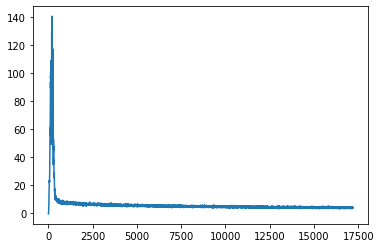

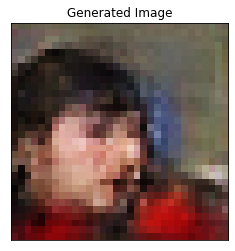

Iteration [15001/100000]......0.193(s) gen: 119.81628 - disc_fake: -120.12925 - disc_real: -116.23451 - disc_real: 3.89474
Iteration [15002/100000]......0.195(s) gen: 119.53672 - disc_fake: -119.59439 - disc_real: -115.79778 - disc_real: 3.79661
Iteration [15003/100000]......0.196(s) gen: 119.82326 - disc_fake: -120.08567 - disc_real: -116.20039 - disc_real: 3.88528
Iteration [15004/100000]......0.198(s) gen: 119.62350 - disc_fake: -119.75413 - disc_real: -115.86039 - disc_real: 3.89373
Iteration [15005/100000]......0.197(s) gen: 120.54490 - disc_fake: -119.89438 - disc_real: -115.98493 - disc_real: 3.90945
Iteration [15006/100000]......0.196(s) gen: 119.84650 - disc_fake: -120.14460 - disc_real: -116.50570 - disc_real: 3.63890
Iteration [15007/100000]......0.199(s) gen: 120.22391 - disc_fake: -119.62402 - disc_real: -115.56705 - disc_real: 4.05698
Iteration [15008/100000]......0.196(s) gen: 119.55481 - disc_fake: -119.54540 - disc_real: -115.62231 - disc_real: 3.92309
Iteration [15009

Iteration [15068/100000]......0.198(s) gen: 121.16817 - disc_fake: -120.62834 - disc_real: -117.14084 - disc_real: 3.48750
Iteration [15069/100000]......0.199(s) gen: 122.51372 - disc_fake: -121.84607 - disc_real: -117.97655 - disc_real: 3.86952
Iteration [15070/100000]......0.197(s) gen: 122.10115 - disc_fake: -122.26064 - disc_real: -118.00376 - disc_real: 4.25688
Iteration [15071/100000]......0.195(s) gen: 121.91290 - disc_fake: -121.91386 - disc_real: -118.24110 - disc_real: 3.67276
Iteration [15072/100000]......0.193(s) gen: 121.62053 - disc_fake: -121.88059 - disc_real: -117.86748 - disc_real: 4.01311
Iteration [15073/100000]......0.194(s) gen: 121.15122 - disc_fake: -121.10252 - disc_real: -117.84638 - disc_real: 3.25614
Iteration [15074/100000]......0.196(s) gen: 121.38132 - disc_fake: -120.99790 - disc_real: -117.53339 - disc_real: 3.46451
Iteration [15075/100000]......0.197(s) gen: 121.39993 - disc_fake: -121.23770 - disc_real: -117.57829 - disc_real: 3.65941
Iteration [15076

Iteration [15135/100000]......0.197(s) gen: 118.19450 - disc_fake: -118.90732 - disc_real: -114.79677 - disc_real: 4.11055
Iteration [15136/100000]......0.199(s) gen: 119.63939 - disc_fake: -118.60801 - disc_real: -114.88563 - disc_real: 3.72237
Iteration [15137/100000]......0.202(s) gen: 120.42574 - disc_fake: -119.94854 - disc_real: -116.18915 - disc_real: 3.75939
Iteration [15138/100000]......0.200(s) gen: 121.24625 - disc_fake: -120.68254 - disc_real: -116.91592 - disc_real: 3.76662
Iteration [15139/100000]......0.204(s) gen: 121.93863 - disc_fake: -121.91297 - disc_real: -117.79857 - disc_real: 4.11440
Iteration [15140/100000]......0.203(s) gen: 121.10113 - disc_fake: -121.30105 - disc_real: -117.65372 - disc_real: 3.64733
Iteration [15141/100000]......0.201(s) gen: 120.74167 - disc_fake: -120.85979 - disc_real: -117.11758 - disc_real: 3.74220
Iteration [15142/100000]......0.200(s) gen: 120.70959 - disc_fake: -121.02705 - disc_real: -117.03255 - disc_real: 3.99450
Iteration [15143

Iteration [15203/100000]......0.201(s) gen: 120.27504 - disc_fake: -120.36467 - disc_real: -116.65821 - disc_real: 3.70645
Iteration [15204/100000]......0.199(s) gen: 119.66560 - disc_fake: -120.40826 - disc_real: -116.24020 - disc_real: 4.16806
Iteration [15205/100000]......0.199(s) gen: 118.50280 - disc_fake: -119.38743 - disc_real: -115.54092 - disc_real: 3.84651
Iteration [15206/100000]......0.198(s) gen: 119.78064 - disc_fake: -118.42832 - disc_real: -114.75262 - disc_real: 3.67570
Iteration [15207/100000]......0.197(s) gen: 120.34921 - disc_fake: -119.84008 - disc_real: -116.07559 - disc_real: 3.76450
Iteration [15208/100000]......0.196(s) gen: 120.43938 - disc_fake: -120.33017 - disc_real: -116.31544 - disc_real: 4.01473
Iteration [15209/100000]......0.198(s) gen: 121.30704 - disc_fake: -120.75591 - disc_real: -117.18349 - disc_real: 3.57243
Iteration [15210/100000]......0.197(s) gen: 121.50195 - disc_fake: -121.53429 - disc_real: -117.89183 - disc_real: 3.64247
Iteration [15211

Iteration [15270/100000]......0.198(s) gen: 120.19923 - disc_fake: -120.40045 - disc_real: -116.57083 - disc_real: 3.82962
Iteration [15271/100000]......0.213(s) gen: 119.89040 - disc_fake: -120.00524 - disc_real: -116.28625 - disc_real: 3.71898
Iteration [15272/100000]......0.199(s) gen: 120.75343 - disc_fake: -120.21973 - disc_real: -116.35067 - disc_real: 3.86906
Iteration [15273/100000]......0.204(s) gen: 120.61028 - disc_fake: -120.49372 - disc_real: -116.84028 - disc_real: 3.65345
Iteration [15274/100000]......0.204(s) gen: 120.92953 - disc_fake: -120.60350 - disc_real: -116.38690 - disc_real: 4.21660
Iteration [15275/100000]......0.204(s) gen: 120.85323 - disc_fake: -120.81662 - disc_real: -117.29004 - disc_real: 3.52658
Iteration [15276/100000]......0.201(s) gen: 121.04097 - disc_fake: -120.95015 - disc_real: -117.31856 - disc_real: 3.63159
Iteration [15277/100000]......0.200(s) gen: 121.26306 - disc_fake: -120.99037 - disc_real: -117.17531 - disc_real: 3.81506
Iteration [15278

Iteration [15337/100000]......0.209(s) gen: 121.51259 - disc_fake: -120.83626 - disc_real: -117.12961 - disc_real: 3.70665
Iteration [15338/100000]......0.209(s) gen: 120.72426 - disc_fake: -121.31776 - disc_real: -117.35599 - disc_real: 3.96177
Iteration [15339/100000]......0.208(s) gen: 119.99252 - disc_fake: -120.25773 - disc_real: -116.68804 - disc_real: 3.56969
Iteration [15340/100000]......0.206(s) gen: 121.24326 - disc_fake: -120.46598 - disc_real: -116.91944 - disc_real: 3.54654
Iteration [15341/100000]......0.206(s) gen: 121.74037 - disc_fake: -121.42605 - disc_real: -117.81684 - disc_real: 3.60921
Iteration [15342/100000]......0.207(s) gen: 122.10280 - disc_fake: -121.54069 - disc_real: -117.78999 - disc_real: 3.75069
Iteration [15343/100000]......0.208(s) gen: 121.48994 - disc_fake: -121.56562 - disc_real: -117.97979 - disc_real: 3.58583
Iteration [15344/100000]......0.208(s) gen: 121.92197 - disc_fake: -121.75615 - disc_real: -118.17017 - disc_real: 3.58598
Iteration [15345

Iteration [15404/100000]......0.202(s) gen: 121.12987 - disc_fake: -121.70973 - disc_real: -117.89300 - disc_real: 3.81673
Iteration [15405/100000]......0.202(s) gen: 121.51527 - disc_fake: -121.14095 - disc_real: -117.77218 - disc_real: 3.36877
Iteration [15406/100000]......0.202(s) gen: 121.09013 - disc_fake: -121.30903 - disc_real: -117.78947 - disc_real: 3.51956
Iteration [15407/100000]......0.200(s) gen: 121.39639 - disc_fake: -121.01621 - disc_real: -117.22984 - disc_real: 3.78637
Iteration [15408/100000]......0.200(s) gen: 120.84981 - disc_fake: -121.08157 - disc_real: -117.10886 - disc_real: 3.97271
Iteration [15409/100000]......0.197(s) gen: 120.92490 - disc_fake: -120.83995 - disc_real: -117.26188 - disc_real: 3.57807
Iteration [15410/100000]......0.198(s) gen: 122.24158 - disc_fake: -121.32240 - disc_real: -117.90296 - disc_real: 3.41944
Iteration [15411/100000]......0.198(s) gen: 121.55943 - disc_fake: -122.10247 - disc_real: -118.01389 - disc_real: 4.08858
Iteration [15412

Iteration [15472/100000]......0.196(s) gen: 121.11740 - disc_fake: -120.92855 - disc_real: -117.49265 - disc_real: 3.43590
Iteration [15473/100000]......0.196(s) gen: 120.83388 - disc_fake: -121.02802 - disc_real: -117.01607 - disc_real: 4.01196
Iteration [15474/100000]......0.198(s) gen: 120.82177 - disc_fake: -120.91634 - disc_real: -117.13614 - disc_real: 3.78021
Iteration [15475/100000]......0.198(s) gen: 121.05219 - disc_fake: -120.80830 - disc_real: -117.38470 - disc_real: 3.42360
Iteration [15476/100000]......0.197(s) gen: 121.23498 - disc_fake: -121.34732 - disc_real: -117.47727 - disc_real: 3.87006
Iteration [15477/100000]......0.195(s) gen: 121.42633 - disc_fake: -121.29734 - disc_real: -117.59584 - disc_real: 3.70150
Iteration [15478/100000]......0.197(s) gen: 122.33900 - disc_fake: -121.69861 - disc_real: -118.11207 - disc_real: 3.58654
Iteration [15479/100000]......0.198(s) gen: 121.39529 - disc_fake: -121.74486 - disc_real: -117.98734 - disc_real: 3.75751
Iteration [15480

Iteration [15539/100000]......0.238(s) gen: 121.21094 - disc_fake: -120.66617 - disc_real: -116.81423 - disc_real: 3.85194
Iteration [15540/100000]......0.200(s) gen: 121.16520 - disc_fake: -121.47487 - disc_real: -117.67549 - disc_real: 3.79938
Iteration [15541/100000]......0.202(s) gen: 121.37013 - disc_fake: -121.30767 - disc_real: -117.44886 - disc_real: 3.85881
Iteration [15542/100000]......0.201(s) gen: 122.36735 - disc_fake: -121.74729 - disc_real: -117.89902 - disc_real: 3.84828
Iteration [15543/100000]......0.200(s) gen: 123.17551 - disc_fake: -122.62997 - disc_real: -118.74186 - disc_real: 3.88811
Iteration [15544/100000]......0.204(s) gen: 121.72810 - disc_fake: -122.24588 - disc_real: -118.20817 - disc_real: 4.03771
Iteration [15545/100000]......0.206(s) gen: 121.11441 - disc_fake: -120.93676 - disc_real: -117.32855 - disc_real: 3.60821
Iteration [15546/100000]......0.200(s) gen: 121.78317 - disc_fake: -121.22065 - disc_real: -117.82514 - disc_real: 3.39551
Iteration [15547

Iteration [15606/100000]......0.193(s) gen: 122.59199 - disc_fake: -122.45688 - disc_real: -118.53885 - disc_real: 3.91803
Iteration [15607/100000]......0.192(s) gen: 122.03061 - disc_fake: -122.52517 - disc_real: -118.90190 - disc_real: 3.62327
Iteration [15608/100000]......0.194(s) gen: 122.64466 - disc_fake: -122.42626 - disc_real: -118.53244 - disc_real: 3.89381
Iteration [15609/100000]......0.196(s) gen: 123.70927 - disc_fake: -123.41236 - disc_real: -119.24804 - disc_real: 4.16431
Iteration [15610/100000]......0.199(s) gen: 123.38084 - disc_fake: -123.60947 - disc_real: -119.98685 - disc_real: 3.62262
Iteration [15611/100000]......0.197(s) gen: 123.26009 - disc_fake: -123.32820 - disc_real: -119.71262 - disc_real: 3.61558
Iteration [15612/100000]......0.202(s) gen: 123.00367 - disc_fake: -123.34770 - disc_real: -119.11042 - disc_real: 4.23728
Iteration [15613/100000]......0.205(s) gen: 122.01664 - disc_fake: -122.60633 - disc_real: -118.77569 - disc_real: 3.83064
Iteration [15614

Iteration [15673/100000]......0.200(s) gen: 122.18791 - disc_fake: -122.15442 - disc_real: -118.55704 - disc_real: 3.59738
Iteration [15674/100000]......0.199(s) gen: 122.82721 - disc_fake: -122.61125 - disc_real: -119.03776 - disc_real: 3.57349
Iteration [15675/100000]......0.198(s) gen: 122.77717 - disc_fake: -122.97714 - disc_real: -119.39299 - disc_real: 3.58414
Iteration [15676/100000]......0.197(s) gen: 122.51982 - disc_fake: -123.01030 - disc_real: -118.88190 - disc_real: 4.12840
Iteration [15677/100000]......0.197(s) gen: 121.82030 - disc_fake: -122.24481 - disc_real: -118.37729 - disc_real: 3.86752
Iteration [15678/100000]......0.198(s) gen: 122.13746 - disc_fake: -121.85020 - disc_real: -118.52888 - disc_real: 3.32132
Iteration [15679/100000]......0.199(s) gen: 121.23381 - disc_fake: -121.38535 - disc_real: -117.21737 - disc_real: 4.16798
Iteration [15680/100000]......0.195(s) gen: 120.97659 - disc_fake: -121.22785 - disc_real: -117.12502 - disc_real: 4.10283
Iteration [15681

Iteration [15740/100000]......0.203(s) gen: 121.52386 - disc_fake: -121.72372 - disc_real: -117.98233 - disc_real: 3.74139
Iteration [15741/100000]......0.200(s) gen: 121.62623 - disc_fake: -121.35045 - disc_real: -117.48409 - disc_real: 3.86636
Iteration [15742/100000]......0.201(s) gen: 121.44014 - disc_fake: -121.58642 - disc_real: -117.18360 - disc_real: 4.40282
Iteration [15743/100000]......0.199(s) gen: 122.09680 - disc_fake: -121.34713 - disc_real: -117.67219 - disc_real: 3.67494
Iteration [15744/100000]......0.199(s) gen: 122.08031 - disc_fake: -122.06330 - disc_real: -118.09842 - disc_real: 3.96487
Iteration [15745/100000]......0.196(s) gen: 121.93507 - disc_fake: -122.23119 - disc_real: -118.17750 - disc_real: 4.05369
Iteration [15746/100000]......0.198(s) gen: 122.15984 - disc_fake: -121.84197 - disc_real: -118.60770 - disc_real: 3.23427
Iteration [15747/100000]......0.202(s) gen: 123.04889 - disc_fake: -122.49009 - disc_real: -119.02204 - disc_real: 3.46805
Iteration [15748

Iteration [15807/100000]......0.205(s) gen: 121.76160 - disc_fake: -122.31308 - disc_real: -118.31776 - disc_real: 3.99532
Iteration [15808/100000]......0.202(s) gen: 121.50517 - disc_fake: -121.14547 - disc_real: -117.13589 - disc_real: 4.00958
Iteration [15809/100000]......0.200(s) gen: 121.44538 - disc_fake: -121.19595 - disc_real: -117.22179 - disc_real: 3.97416
Iteration [15810/100000]......0.200(s) gen: 122.08347 - disc_fake: -121.50539 - disc_real: -117.76679 - disc_real: 3.73860
Iteration [15811/100000]......0.203(s) gen: 123.03005 - disc_fake: -122.11196 - disc_real: -118.46461 - disc_real: 3.64734
Iteration [15812/100000]......0.200(s) gen: 122.90421 - disc_fake: -123.15457 - disc_real: -119.03157 - disc_real: 4.12300
Iteration [15813/100000]......0.209(s) gen: 123.48056 - disc_fake: -123.32479 - disc_real: -119.58015 - disc_real: 3.74464
Iteration [15814/100000]......0.204(s) gen: 122.21411 - disc_fake: -123.06698 - disc_real: -119.08885 - disc_real: 3.97813
Iteration [15815

Iteration [15874/100000]......0.196(s) gen: 123.26337 - disc_fake: -123.21725 - disc_real: -119.50500 - disc_real: 3.71225
Iteration [15875/100000]......0.195(s) gen: 121.98595 - disc_fake: -122.73031 - disc_real: -119.20623 - disc_real: 3.52408
Iteration [15876/100000]......0.194(s) gen: 122.33234 - disc_fake: -122.08684 - disc_real: -118.46529 - disc_real: 3.62155
Iteration [15877/100000]......0.194(s) gen: 122.21597 - disc_fake: -122.33099 - disc_real: -118.76336 - disc_real: 3.56763
Iteration [15878/100000]......0.192(s) gen: 122.38414 - disc_fake: -122.56674 - disc_real: -119.22689 - disc_real: 3.33985
Iteration [15879/100000]......0.194(s) gen: 122.75401 - disc_fake: -122.67344 - disc_real: -118.50294 - disc_real: 4.17050
Iteration [15880/100000]......0.193(s) gen: 122.71532 - disc_fake: -122.87701 - disc_real: -119.36532 - disc_real: 3.51169
Iteration [15881/100000]......0.193(s) gen: 122.74714 - disc_fake: -122.45844 - disc_real: -118.79921 - disc_real: 3.65923
Iteration [15882

Iteration [15941/100000]......0.195(s) gen: 122.48119 - disc_fake: -122.65541 - disc_real: -118.76026 - disc_real: 3.89515
Iteration [15942/100000]......0.195(s) gen: 122.08566 - disc_fake: -121.93319 - disc_real: -118.22136 - disc_real: 3.71182
Iteration [15943/100000]......0.194(s) gen: 122.19484 - disc_fake: -122.16355 - disc_real: -118.34795 - disc_real: 3.81561
Iteration [15944/100000]......0.194(s) gen: 122.22686 - disc_fake: -122.13673 - disc_real: -118.13623 - disc_real: 4.00050
Iteration [15945/100000]......0.194(s) gen: 123.16921 - disc_fake: -123.06588 - disc_real: -119.45865 - disc_real: 3.60723
Iteration [15946/100000]......0.195(s) gen: 123.60149 - disc_fake: -123.39646 - disc_real: -119.56177 - disc_real: 3.83469
Iteration [15947/100000]......0.195(s) gen: 122.82243 - disc_fake: -123.36978 - disc_real: -119.76549 - disc_real: 3.60429
Iteration [15948/100000]......0.194(s) gen: 123.77919 - disc_fake: -123.23155 - disc_real: -119.33362 - disc_real: 3.89792
Iteration [15949

Iteration [16008/100000]......0.202(s) gen: 122.02556 - disc_fake: -122.30754 - disc_real: -118.23231 - disc_real: 4.07522
Iteration [16009/100000]......0.203(s) gen: 121.42409 - disc_fake: -121.20521 - disc_real: -116.61110 - disc_real: 4.59411
Iteration [16010/100000]......0.204(s) gen: 122.24659 - disc_fake: -121.61118 - disc_real: -118.08015 - disc_real: 3.53103
Iteration [16011/100000]......0.204(s) gen: 122.73415 - disc_fake: -122.25167 - disc_real: -118.13955 - disc_real: 4.11212
Iteration [16012/100000]......0.201(s) gen: 122.71420 - disc_fake: -122.94207 - disc_real: -119.24938 - disc_real: 3.69269
Iteration [16013/100000]......0.200(s) gen: 123.14719 - disc_fake: -122.55473 - disc_real: -119.17513 - disc_real: 3.37961
Iteration [16014/100000]......0.200(s) gen: 123.44370 - disc_fake: -123.00380 - disc_real: -119.35454 - disc_real: 3.64926
Iteration [16015/100000]......0.199(s) gen: 123.59705 - disc_fake: -123.69437 - disc_real: -120.11157 - disc_real: 3.58279
Iteration [16016

Iteration [16075/100000]......0.197(s) gen: 122.67191 - disc_fake: -121.82260 - disc_real: -118.34754 - disc_real: 3.47506
Iteration [16076/100000]......0.196(s) gen: 122.55890 - disc_fake: -122.14126 - disc_real: -118.59018 - disc_real: 3.55108
Iteration [16077/100000]......0.200(s) gen: 121.52786 - disc_fake: -121.81544 - disc_real: -117.91792 - disc_real: 3.89752
Iteration [16078/100000]......0.201(s) gen: 122.21207 - disc_fake: -121.81737 - disc_real: -118.42119 - disc_real: 3.39618
Iteration [16079/100000]......0.200(s) gen: 123.11979 - disc_fake: -122.44155 - disc_real: -118.89046 - disc_real: 3.55109
Iteration [16080/100000]......0.201(s) gen: 123.02658 - disc_fake: -122.85218 - disc_real: -119.13792 - disc_real: 3.71426
Iteration [16081/100000]......0.198(s) gen: 123.49187 - disc_fake: -123.03401 - disc_real: -119.37590 - disc_real: 3.65811
Iteration [16082/100000]......0.200(s) gen: 121.98421 - disc_fake: -122.50649 - disc_real: -118.49533 - disc_real: 4.01116
Iteration [16083

Iteration [16143/100000]......0.200(s) gen: 122.28049 - disc_fake: -122.57052 - disc_real: -118.28883 - disc_real: 4.28169
Iteration [16144/100000]......0.199(s) gen: 121.94923 - disc_fake: -122.24122 - disc_real: -118.65830 - disc_real: 3.58293
Iteration [16145/100000]......0.202(s) gen: 122.55804 - disc_fake: -122.40584 - disc_real: -118.81728 - disc_real: 3.58856
Iteration [16146/100000]......0.203(s) gen: 122.28117 - disc_fake: -122.54495 - disc_real: -118.75156 - disc_real: 3.79339
Iteration [16147/100000]......0.202(s) gen: 122.52516 - disc_fake: -122.96098 - disc_real: -118.99188 - disc_real: 3.96909
Iteration [16148/100000]......0.200(s) gen: 122.31302 - disc_fake: -122.43373 - disc_real: -118.77860 - disc_real: 3.65513
Iteration [16149/100000]......0.199(s) gen: 121.90480 - disc_fake: -121.99162 - disc_real: -118.13253 - disc_real: 3.85909
Iteration [16150/100000]......0.197(s) gen: 122.23209 - disc_fake: -122.01257 - disc_real: -118.34013 - disc_real: 3.67244
Iteration [16151

Iteration [16210/100000]......0.204(s) gen: 122.24367 - disc_fake: -122.51761 - disc_real: -118.62938 - disc_real: 3.88823
Iteration [16211/100000]......0.204(s) gen: 122.90794 - disc_fake: -122.37697 - disc_real: -118.83090 - disc_real: 3.54607
Iteration [16212/100000]......0.201(s) gen: 123.23353 - disc_fake: -122.96925 - disc_real: -119.31138 - disc_real: 3.65787
Iteration [16213/100000]......0.204(s) gen: 123.13159 - disc_fake: -123.07527 - disc_real: -119.40824 - disc_real: 3.66702
Iteration [16214/100000]......0.197(s) gen: 124.58403 - disc_fake: -123.96355 - disc_real: -120.50944 - disc_real: 3.45411
Iteration [16215/100000]......0.197(s) gen: 125.03967 - disc_fake: -124.97668 - disc_real: -120.94621 - disc_real: 4.03047
Iteration [16216/100000]......0.195(s) gen: 124.85439 - disc_fake: -125.04255 - disc_real: -120.96172 - disc_real: 4.08083
Iteration [16217/100000]......0.197(s) gen: 124.73447 - disc_fake: -124.85694 - disc_real: -120.93065 - disc_real: 3.92629
Iteration [16218

Iteration [16277/100000]......0.204(s) gen: 121.65010 - disc_fake: -121.87124 - disc_real: -118.12395 - disc_real: 3.74729
Iteration [16278/100000]......0.205(s) gen: 122.66292 - disc_fake: -122.15808 - disc_real: -118.16345 - disc_real: 3.99463
Iteration [16279/100000]......0.208(s) gen: 122.84408 - disc_fake: -122.86948 - disc_real: -118.93250 - disc_real: 3.93698
Iteration [16280/100000]......0.210(s) gen: 123.10944 - disc_fake: -123.08646 - disc_real: -119.24904 - disc_real: 3.83742
Iteration [16281/100000]......0.228(s) gen: 123.18679 - disc_fake: -123.32797 - disc_real: -120.00754 - disc_real: 3.32043
Iteration [16282/100000]......0.203(s) gen: 123.46422 - disc_fake: -123.13280 - disc_real: -119.21734 - disc_real: 3.91546
Iteration [16283/100000]......0.199(s) gen: 124.12636 - disc_fake: -123.54602 - disc_real: -119.72538 - disc_real: 3.82064
Iteration [16284/100000]......0.200(s) gen: 124.44949 - disc_fake: -124.04760 - disc_real: -120.09197 - disc_real: 3.95562
Iteration [16285

Iteration [16344/100000]......0.198(s) gen: 123.88693 - disc_fake: -123.54325 - disc_real: -119.81590 - disc_real: 3.72735
Iteration [16345/100000]......0.197(s) gen: 123.68002 - disc_fake: -123.38193 - disc_real: -119.76474 - disc_real: 3.61718
Iteration [16346/100000]......0.198(s) gen: 123.85432 - disc_fake: -123.80837 - disc_real: -120.23769 - disc_real: 3.57068
Iteration [16347/100000]......0.198(s) gen: 123.56821 - disc_fake: -123.93152 - disc_real: -119.97176 - disc_real: 3.95975
Iteration [16348/100000]......0.197(s) gen: 123.46937 - disc_fake: -123.33636 - disc_real: -119.90361 - disc_real: 3.43275
Iteration [16349/100000]......0.195(s) gen: 124.15648 - disc_fake: -123.80918 - disc_real: -120.04632 - disc_real: 3.76286
Iteration [16350/100000]......0.194(s) gen: 125.24548 - disc_fake: -124.73883 - disc_real: -120.89563 - disc_real: 3.84320
Iteration [16351/100000]......0.194(s) gen: 125.09753 - disc_fake: -124.85169 - disc_real: -121.41889 - disc_real: 3.43280
Iteration [16352

Iteration [16411/100000]......0.202(s) gen: 123.72247 - disc_fake: -124.25368 - disc_real: -120.44693 - disc_real: 3.80675
Iteration [16412/100000]......0.202(s) gen: 124.40639 - disc_fake: -123.96908 - disc_real: -120.29533 - disc_real: 3.67375
Iteration [16413/100000]......0.203(s) gen: 123.37183 - disc_fake: -124.01857 - disc_real: -120.27902 - disc_real: 3.73955
Iteration [16414/100000]......0.201(s) gen: 123.34016 - disc_fake: -123.44559 - disc_real: -119.41169 - disc_real: 4.03391
Iteration [16415/100000]......0.200(s) gen: 123.07686 - disc_fake: -123.59107 - disc_real: -119.83532 - disc_real: 3.75574
Iteration [16416/100000]......0.198(s) gen: 122.72122 - disc_fake: -123.28807 - disc_real: -119.40821 - disc_real: 3.87986
Iteration [16417/100000]......0.200(s) gen: 123.08028 - disc_fake: -122.79652 - disc_real: -118.94165 - disc_real: 3.85487
Iteration [16418/100000]......0.200(s) gen: 122.06103 - disc_fake: -122.71269 - disc_real: -118.73402 - disc_real: 3.97866
Iteration [16419

Iteration [16479/100000]......0.199(s) gen: 123.37411 - disc_fake: -123.27707 - disc_real: -119.41197 - disc_real: 3.86510
Iteration [16480/100000]......0.198(s) gen: 123.72365 - disc_fake: -123.10263 - disc_real: -119.39488 - disc_real: 3.70775
Iteration [16481/100000]......0.199(s) gen: 123.89610 - disc_fake: -124.10216 - disc_real: -120.14285 - disc_real: 3.95930
Iteration [16482/100000]......0.202(s) gen: 123.52143 - disc_fake: -123.86809 - disc_real: -119.89572 - disc_real: 3.97237
Iteration [16483/100000]......0.205(s) gen: 123.29724 - disc_fake: -123.97041 - disc_real: -120.09019 - disc_real: 3.88022
Iteration [16484/100000]......0.203(s) gen: 123.80334 - disc_fake: -123.42277 - disc_real: -119.52388 - disc_real: 3.89889
Iteration [16485/100000]......0.205(s) gen: 123.83133 - disc_fake: -123.90606 - disc_real: -120.18818 - disc_real: 3.71788
Iteration [16486/100000]......0.203(s) gen: 123.99689 - disc_fake: -123.71926 - disc_real: -120.25420 - disc_real: 3.46506
Iteration [16487

Iteration [16546/100000]......0.196(s) gen: 124.27165 - disc_fake: -124.27173 - disc_real: -120.71448 - disc_real: 3.55724
Iteration [16547/100000]......0.197(s) gen: 124.22560 - disc_fake: -124.76952 - disc_real: -120.95514 - disc_real: 3.81438
Iteration [16548/100000]......0.197(s) gen: 124.63242 - disc_fake: -124.33944 - disc_real: -120.31341 - disc_real: 4.02603
Iteration [16549/100000]......0.198(s) gen: 125.98055 - disc_fake: -124.95497 - disc_real: -121.53564 - disc_real: 3.41933
Iteration [16550/100000]......0.196(s) gen: 125.98920 - disc_fake: -125.84130 - disc_real: -121.99203 - disc_real: 3.84927
Iteration [16551/100000]......0.196(s) gen: 125.13281 - disc_fake: -124.98219 - disc_real: -121.33770 - disc_real: 3.64449
Iteration [16552/100000]......0.196(s) gen: 124.89037 - disc_fake: -124.54753 - disc_real: -120.76485 - disc_real: 3.78268
Iteration [16553/100000]......0.199(s) gen: 123.85390 - disc_fake: -124.13685 - disc_real: -120.31559 - disc_real: 3.82126
Iteration [16554

Iteration [16613/100000]......0.198(s) gen: 123.82948 - disc_fake: -123.98280 - disc_real: -120.18537 - disc_real: 3.79742
Iteration [16614/100000]......0.200(s) gen: 123.84955 - disc_fake: -123.61225 - disc_real: -120.42054 - disc_real: 3.19170
Iteration [16615/100000]......0.201(s) gen: 124.13298 - disc_fake: -123.86280 - disc_real: -120.47589 - disc_real: 3.38691
Iteration [16616/100000]......0.201(s) gen: 123.62804 - disc_fake: -123.82329 - disc_real: -119.88803 - disc_real: 3.93526
Iteration [16617/100000]......0.201(s) gen: 124.49124 - disc_fake: -123.66194 - disc_real: -119.76085 - disc_real: 3.90109
Iteration [16618/100000]......0.200(s) gen: 124.05457 - disc_fake: -124.35590 - disc_real: -120.41040 - disc_real: 3.94550
Iteration [16619/100000]......0.201(s) gen: 124.07942 - disc_fake: -123.92922 - disc_real: -120.26956 - disc_real: 3.65966
Iteration [16620/100000]......0.199(s) gen: 124.16823 - disc_fake: -123.72367 - disc_real: -120.19010 - disc_real: 3.53358
Iteration [16621

Iteration [16680/100000]......0.216(s) gen: 123.56685 - disc_fake: -123.54836 - disc_real: -119.70965 - disc_real: 3.83871
Iteration [16681/100000]......0.212(s) gen: 123.90534 - disc_fake: -123.55860 - disc_real: -119.52898 - disc_real: 4.02962
Iteration [16682/100000]......0.210(s) gen: 123.65967 - disc_fake: -123.86852 - disc_real: -120.39758 - disc_real: 3.47094
Iteration [16683/100000]......0.207(s) gen: 124.02740 - disc_fake: -123.87334 - disc_real: -120.32048 - disc_real: 3.55286
Iteration [16684/100000]......0.204(s) gen: 124.65332 - disc_fake: -124.41726 - disc_real: -121.01413 - disc_real: 3.40313
Iteration [16685/100000]......0.202(s) gen: 125.23504 - disc_fake: -124.86999 - disc_real: -121.43224 - disc_real: 3.43775
Iteration [16686/100000]......0.200(s) gen: 126.12571 - disc_fake: -125.80746 - disc_real: -121.87056 - disc_real: 3.93691
Iteration [16687/100000]......0.199(s) gen: 124.46021 - disc_fake: -125.44656 - disc_real: -121.88120 - disc_real: 3.56536
Iteration [16688

Iteration [16747/100000]......0.200(s) gen: 124.32750 - disc_fake: -124.30176 - disc_real: -120.57669 - disc_real: 3.72507
Iteration [16748/100000]......0.200(s) gen: 125.16978 - disc_fake: -124.52263 - disc_real: -121.02080 - disc_real: 3.50183
Iteration [16749/100000]......0.200(s) gen: 123.93233 - disc_fake: -124.58179 - disc_real: -121.11211 - disc_real: 3.46967
Iteration [16750/100000]......0.200(s) gen: 124.50177 - disc_fake: -124.30623 - disc_real: -120.69422 - disc_real: 3.61200
Iteration [16751/100000]......0.199(s) gen: 125.16172 - disc_fake: -124.74651 - disc_real: -121.14385 - disc_real: 3.60266
Iteration [16752/100000]......0.199(s) gen: 124.97028 - disc_fake: -125.18496 - disc_real: -121.44939 - disc_real: 3.73557
Iteration [16753/100000]......0.201(s) gen: 125.48743 - disc_fake: -125.13658 - disc_real: -121.33359 - disc_real: 3.80300
Iteration [16754/100000]......0.198(s) gen: 125.09462 - disc_fake: -125.58690 - disc_real: -121.84693 - disc_real: 3.73997
Iteration [16755

Iteration [16814/100000]......0.194(s) gen: 125.16660 - disc_fake: -125.29702 - disc_real: -121.77571 - disc_real: 3.52131
Iteration [16815/100000]......0.193(s) gen: 125.50207 - disc_fake: -125.25154 - disc_real: -121.32342 - disc_real: 3.92812
Iteration [16816/100000]......0.194(s) gen: 125.17159 - disc_fake: -125.08300 - disc_real: -121.09029 - disc_real: 3.99271
Iteration [16817/100000]......0.194(s) gen: 125.72944 - disc_fake: -125.08975 - disc_real: -121.72816 - disc_real: 3.36159
Iteration [16818/100000]......0.198(s) gen: 126.76089 - disc_fake: -126.21864 - disc_real: -122.40845 - disc_real: 3.81018
Iteration [16819/100000]......0.199(s) gen: 125.56946 - disc_fake: -125.83725 - disc_real: -122.49190 - disc_real: 3.34535
Iteration [16820/100000]......0.199(s) gen: 124.99815 - disc_fake: -125.31518 - disc_real: -121.29721 - disc_real: 4.01797
Iteration [16821/100000]......0.200(s) gen: 125.33194 - disc_fake: -125.18732 - disc_real: -121.01034 - disc_real: 4.17698
Iteration [16822

Iteration [16881/100000]......0.201(s) gen: 123.80020 - disc_fake: -124.39300 - disc_real: -120.43766 - disc_real: 3.95534
Iteration [16882/100000]......0.201(s) gen: 124.40945 - disc_fake: -123.77908 - disc_real: -120.20259 - disc_real: 3.57649
Iteration [16883/100000]......0.202(s) gen: 124.47081 - disc_fake: -124.47218 - disc_real: -120.49190 - disc_real: 3.98028
Iteration [16884/100000]......0.202(s) gen: 124.12852 - disc_fake: -124.12149 - disc_real: -120.03358 - disc_real: 4.08791
Iteration [16885/100000]......0.199(s) gen: 125.12614 - disc_fake: -124.29337 - disc_real: -120.99089 - disc_real: 3.30248
Iteration [16886/100000]......0.199(s) gen: 125.92936 - disc_fake: -125.08394 - disc_real: -122.02077 - disc_real: 3.06317
Iteration [16887/100000]......0.201(s) gen: 126.21155 - disc_fake: -126.11931 - disc_real: -122.38992 - disc_real: 3.72939
Iteration [16888/100000]......0.201(s) gen: 125.61758 - disc_fake: -126.36939 - disc_real: -122.12929 - disc_real: 4.24010
Iteration [16889

Iteration [16948/100000]......0.202(s) gen: 125.09148 - disc_fake: -125.30232 - disc_real: -121.89945 - disc_real: 3.40287
Iteration [16949/100000]......0.201(s) gen: 126.24428 - disc_fake: -125.69774 - disc_real: -121.67984 - disc_real: 4.01791
Iteration [16950/100000]......0.200(s) gen: 124.70967 - disc_fake: -125.46068 - disc_real: -121.21228 - disc_real: 4.24839
Iteration [16951/100000]......0.199(s) gen: 124.82060 - disc_fake: -124.84270 - disc_real: -121.30814 - disc_real: 3.53456
Iteration [16952/100000]......0.198(s) gen: 124.59811 - disc_fake: -124.44611 - disc_real: -120.85582 - disc_real: 3.59029
Iteration [16953/100000]......0.200(s) gen: 124.70888 - disc_fake: -124.50989 - disc_real: -120.03913 - disc_real: 4.47076
Iteration [16954/100000]......0.201(s) gen: 123.69534 - disc_fake: -124.38636 - disc_real: -120.76727 - disc_real: 3.61909
Iteration [16955/100000]......0.200(s) gen: 123.74721 - disc_fake: -123.50465 - disc_real: -119.90056 - disc_real: 3.60409
Iteration [16956

Iteration [17015/100000]......0.202(s) gen: 126.78592 - disc_fake: -125.70497 - disc_real: -122.14796 - disc_real: 3.55701
Iteration [17016/100000]......0.202(s) gen: 125.20973 - disc_fake: -125.98994 - disc_real: -122.29570 - disc_real: 3.69424
Iteration [17017/100000]......0.200(s) gen: 124.91672 - disc_fake: -124.68835 - disc_real: -120.75074 - disc_real: 3.93761
Iteration [17018/100000]......0.203(s) gen: 124.01688 - disc_fake: -124.16873 - disc_real: -120.22280 - disc_real: 3.94593
Iteration [17019/100000]......0.207(s) gen: 123.22655 - disc_fake: -123.69234 - disc_real: -120.17530 - disc_real: 3.51703
Iteration [17020/100000]......0.206(s) gen: 123.63356 - disc_fake: -123.08303 - disc_real: -119.01660 - disc_real: 4.06643
Iteration [17021/100000]......0.206(s) gen: 124.18126 - disc_fake: -123.61813 - disc_real: -119.93148 - disc_real: 3.68665
Iteration [17022/100000]......0.204(s) gen: 124.95521 - disc_fake: -124.62803 - disc_real: -120.62894 - disc_real: 3.99909
Iteration [17023

Iteration [17082/100000]......0.199(s) gen: 125.80406 - disc_fake: -126.10405 - disc_real: -122.39960 - disc_real: 3.70445
Iteration [17083/100000]......0.198(s) gen: 126.52278 - disc_fake: -125.95499 - disc_real: -122.23960 - disc_real: 3.71538
Iteration [17084/100000]......0.196(s) gen: 126.25897 - disc_fake: -126.51361 - disc_real: -122.99285 - disc_real: 3.52076
Iteration [17085/100000]......0.197(s) gen: 124.32446 - disc_fake: -125.20208 - disc_real: -121.82745 - disc_real: 3.37462
Iteration [17086/100000]......0.197(s) gen: 124.24384 - disc_fake: -124.08919 - disc_real: -120.44513 - disc_real: 3.64406
Iteration [17087/100000]......0.198(s) gen: 124.71831 - disc_fake: -124.20607 - disc_real: -120.63404 - disc_real: 3.57203
Iteration [17088/100000]......0.196(s) gen: 124.67060 - disc_fake: -124.38036 - disc_real: -120.49702 - disc_real: 3.88334
Iteration [17089/100000]......0.196(s) gen: 124.54347 - disc_fake: -124.42498 - disc_real: -120.81873 - disc_real: 3.60625
Iteration [17090

Iteration [17149/100000]......0.201(s) gen: 125.03422 - disc_fake: -125.57398 - disc_real: -121.83500 - disc_real: 3.73898
Iteration [17150/100000]......0.201(s) gen: 124.86156 - disc_fake: -125.21672 - disc_real: -121.63085 - disc_real: 3.58586
Iteration [17151/100000]......0.201(s) gen: 124.73743 - disc_fake: -124.57869 - disc_real: -120.68686 - disc_real: 3.89183
Iteration [17152/100000]......0.198(s) gen: 124.81924 - disc_fake: -124.93923 - disc_real: -121.03390 - disc_real: 3.90533
Iteration [17153/100000]......0.197(s) gen: 123.86008 - disc_fake: -124.19765 - disc_real: -120.44431 - disc_real: 3.75334
Iteration [17154/100000]......0.197(s) gen: 124.86032 - disc_fake: -124.22335 - disc_real: -120.67245 - disc_real: 3.55089
Iteration [17155/100000]......0.198(s) gen: 126.09180 - disc_fake: -124.98252 - disc_real: -121.47506 - disc_real: 3.50746
Iteration [17156/100000]......0.198(s) gen: 126.89407 - disc_fake: -126.36685 - disc_real: -122.71329 - disc_real: 3.65356
Iteration [17157

Iteration [17216/100000]......0.198(s) gen: 125.02583 - disc_fake: -125.25956 - disc_real: -121.46546 - disc_real: 3.79411
Iteration [17217/100000]......0.198(s) gen: 124.56108 - disc_fake: -124.72384 - disc_real: -121.05287 - disc_real: 3.67096
Iteration [17218/100000]......0.197(s) gen: 126.07140 - disc_fake: -125.18242 - disc_real: -121.67461 - disc_real: 3.50781
Iteration [17219/100000]......0.198(s) gen: 126.75887 - disc_fake: -126.15850 - disc_real: -122.81781 - disc_real: 3.34069
Iteration [17220/100000]......0.195(s) gen: 126.74656 - disc_fake: -126.89869 - disc_real: -123.25984 - disc_real: 3.63885
Iteration [17221/100000]......0.195(s) gen: 127.75416 - disc_fake: -127.12908 - disc_real: -123.39324 - disc_real: 3.73583
Iteration [17222/100000]......0.199(s) gen: 126.70847 - disc_fake: -127.07264 - disc_real: -123.12442 - disc_real: 3.94823
Iteration [17223/100000]......0.200(s) gen: 126.91237 - disc_fake: -126.67345 - disc_real: -122.81941 - disc_real: 3.85404
Iteration [17224

Iteration [17283/100000]......0.197(s) gen: 126.60179 - disc_fake: -126.16809 - disc_real: -122.01726 - disc_real: 4.15082
Iteration [17284/100000]......0.198(s) gen: 126.15454 - disc_fake: -126.46264 - disc_real: -122.34968 - disc_real: 4.11296
Iteration [17285/100000]......0.199(s) gen: 125.65007 - disc_fake: -125.87671 - disc_real: -122.36703 - disc_real: 3.50968
Iteration [17286/100000]......0.201(s) gen: 125.31095 - disc_fake: -125.68499 - disc_real: -121.85242 - disc_real: 3.83257
Iteration [17287/100000]......0.203(s) gen: 125.48457 - disc_fake: -125.08466 - disc_real: -121.32677 - disc_real: 3.75789
Iteration [17288/100000]......0.203(s) gen: 125.34734 - disc_fake: -125.37411 - disc_real: -121.56338 - disc_real: 3.81073
Iteration [17289/100000]......0.203(s) gen: 125.14364 - disc_fake: -124.82911 - disc_real: -120.97271 - disc_real: 3.85640
Iteration [17290/100000]......0.200(s) gen: 125.21166 - disc_fake: -124.97889 - disc_real: -120.88960 - disc_real: 4.08929
Iteration [17291

Iteration [17351/100000]......0.198(s) gen: 127.03988 - disc_fake: -127.49212 - disc_real: -123.88558 - disc_real: 3.60654
Iteration [17352/100000]......0.200(s) gen: 126.55458 - disc_fake: -126.87243 - disc_real: -123.23438 - disc_real: 3.63805
Iteration [17353/100000]......0.200(s) gen: 126.37106 - disc_fake: -126.50338 - disc_real: -122.63141 - disc_real: 3.87197
Iteration [17354/100000]......0.201(s) gen: 126.73672 - disc_fake: -126.41192 - disc_real: -123.32920 - disc_real: 3.08272
Iteration [17355/100000]......0.200(s) gen: 126.31271 - disc_fake: -127.06495 - disc_real: -123.16404 - disc_real: 3.90091
Iteration [17356/100000]......0.200(s) gen: 126.10220 - disc_fake: -126.36602 - disc_real: -122.43279 - disc_real: 3.93323
Iteration [17357/100000]......0.202(s) gen: 126.45767 - disc_fake: -126.18739 - disc_real: -122.77550 - disc_real: 3.41189
Iteration [17358/100000]......0.200(s) gen: 127.62662 - disc_fake: -126.81537 - disc_real: -123.42834 - disc_real: 3.38702
Iteration [17359

Iteration [17418/100000]......0.198(s) gen: 125.00440 - disc_fake: -125.36231 - disc_real: -121.62946 - disc_real: 3.73284
Iteration [17419/100000]......0.199(s) gen: 125.73140 - disc_fake: -124.88323 - disc_real: -121.24606 - disc_real: 3.63718
Iteration [17420/100000]......0.200(s) gen: 125.83173 - disc_fake: -125.67673 - disc_real: -122.06922 - disc_real: 3.60751
Iteration [17421/100000]......0.199(s) gen: 125.95106 - disc_fake: -125.85357 - disc_real: -121.71817 - disc_real: 4.13540
Iteration [17422/100000]......0.198(s) gen: 126.37585 - disc_fake: -125.75801 - disc_real: -122.24336 - disc_real: 3.51465
Iteration [17423/100000]......0.198(s) gen: 126.42556 - disc_fake: -126.49866 - disc_real: -122.52500 - disc_real: 3.97365
Iteration [17424/100000]......0.201(s) gen: 126.29520 - disc_fake: -126.40119 - disc_real: -122.54925 - disc_real: 3.85194
Iteration [17425/100000]......0.202(s) gen: 126.68497 - disc_fake: -126.50524 - disc_real: -122.63528 - disc_real: 3.86996
Iteration [17426

Iteration [17485/100000]......0.197(s) gen: 125.41135 - disc_fake: -125.45594 - disc_real: -121.98284 - disc_real: 3.47310
Iteration [17486/100000]......0.198(s) gen: 126.19088 - disc_fake: -126.27611 - disc_real: -122.55219 - disc_real: 3.72392
Iteration [17487/100000]......0.198(s) gen: 126.13380 - disc_fake: -126.30373 - disc_real: -122.78257 - disc_real: 3.52116
Iteration [17488/100000]......0.197(s) gen: 126.28293 - disc_fake: -126.40261 - disc_real: -122.66579 - disc_real: 3.73681
Iteration [17489/100000]......0.199(s) gen: 127.36221 - disc_fake: -126.77861 - disc_real: -123.23125 - disc_real: 3.54735
Iteration [17490/100000]......0.200(s) gen: 127.67993 - disc_fake: -127.84368 - disc_real: -123.90251 - disc_real: 3.94117
Iteration [17491/100000]......0.205(s) gen: 127.01091 - disc_fake: -127.07558 - disc_real: -123.35069 - disc_real: 3.72489
Iteration [17492/100000]......0.204(s) gen: 126.76758 - disc_fake: -126.57142 - disc_real: -123.09488 - disc_real: 3.47654
Iteration [17493

Iteration [17553/100000]......0.197(s) gen: 127.12318 - disc_fake: -126.70682 - disc_real: -123.13629 - disc_real: 3.57053
Iteration [17554/100000]......0.199(s) gen: 126.95097 - disc_fake: -126.77766 - disc_real: -123.07666 - disc_real: 3.70099
Iteration [17555/100000]......0.201(s) gen: 126.38705 - disc_fake: -126.44411 - disc_real: -122.46984 - disc_real: 3.97428
Iteration [17556/100000]......0.204(s) gen: 126.64989 - disc_fake: -126.19245 - disc_real: -122.90151 - disc_real: 3.29094
Iteration [17557/100000]......0.205(s) gen: 126.85478 - disc_fake: -126.67513 - disc_real: -123.29175 - disc_real: 3.38338
Iteration [17558/100000]......0.205(s) gen: 126.50571 - disc_fake: -126.54795 - disc_real: -122.80218 - disc_real: 3.74577
Iteration [17559/100000]......0.206(s) gen: 127.13647 - disc_fake: -126.73788 - disc_real: -123.05122 - disc_real: 3.68666
Iteration [17560/100000]......0.204(s) gen: 126.69777 - disc_fake: -126.87798 - disc_real: -123.17095 - disc_real: 3.70703
Iteration [17561

Iteration [17621/100000]......0.198(s) gen: 127.35321 - disc_fake: -127.20674 - disc_real: -123.81358 - disc_real: 3.39316
Iteration [17622/100000]......0.199(s) gen: 127.43798 - disc_fake: -126.89487 - disc_real: -123.15213 - disc_real: 3.74273
Iteration [17623/100000]......0.201(s) gen: 127.28769 - disc_fake: -126.94710 - disc_real: -122.75052 - disc_real: 4.19659
Iteration [17624/100000]......0.204(s) gen: 127.27434 - disc_fake: -127.01552 - disc_real: -123.78760 - disc_real: 3.22792
Iteration [17625/100000]......0.205(s) gen: 128.20413 - disc_fake: -127.27109 - disc_real: -123.62578 - disc_real: 3.64531
Iteration [17626/100000]......0.204(s) gen: 128.12030 - disc_fake: -127.99250 - disc_real: -124.60229 - disc_real: 3.39021
Iteration [17627/100000]......0.205(s) gen: 128.33662 - disc_fake: -127.82920 - disc_real: -124.05768 - disc_real: 3.77152
Iteration [17628/100000]......0.203(s) gen: 127.72372 - disc_fake: -128.28771 - disc_real: -124.37448 - disc_real: 3.91323
Iteration [17629

Iteration [17689/100000]......0.198(s) gen: 128.56982 - disc_fake: -128.40067 - disc_real: -124.88013 - disc_real: 3.52053
Iteration [17690/100000]......0.197(s) gen: 127.69046 - disc_fake: -128.06174 - disc_real: -124.27952 - disc_real: 3.78221
Iteration [17691/100000]......0.197(s) gen: 127.55403 - disc_fake: -128.05798 - disc_real: -124.45157 - disc_real: 3.60641
Iteration [17692/100000]......0.198(s) gen: 127.06683 - disc_fake: -127.73112 - disc_real: -123.92561 - disc_real: 3.80552
Iteration [17693/100000]......0.199(s) gen: 127.43109 - disc_fake: -127.21447 - disc_real: -123.40261 - disc_real: 3.81186
Iteration [17694/100000]......0.199(s) gen: 126.90997 - disc_fake: -127.42475 - disc_real: -123.45662 - disc_real: 3.96813
Iteration [17695/100000]......0.198(s) gen: 126.94542 - disc_fake: -127.05824 - disc_real: -123.44220 - disc_real: 3.61604
Iteration [17696/100000]......0.199(s) gen: 128.37048 - disc_fake: -127.68383 - disc_real: -123.96010 - disc_real: 3.72373
Iteration [17697

Iteration [17756/100000]......0.192(s) gen: 128.22192 - disc_fake: -127.83998 - disc_real: -124.19739 - disc_real: 3.64259
Iteration [17757/100000]......0.194(s) gen: 127.94604 - disc_fake: -128.12514 - disc_real: -124.58495 - disc_real: 3.54018
Iteration [17758/100000]......0.193(s) gen: 127.96080 - disc_fake: -128.16351 - disc_real: -124.59189 - disc_real: 3.57162
Iteration [17759/100000]......0.194(s) gen: 126.73634 - disc_fake: -127.47668 - disc_real: -123.61573 - disc_real: 3.86094
Iteration [17760/100000]......0.195(s) gen: 126.36607 - disc_fake: -126.47298 - disc_real: -122.73931 - disc_real: 3.73366
Iteration [17761/100000]......0.194(s) gen: 126.41454 - disc_fake: -126.09455 - disc_real: -122.38310 - disc_real: 3.71145
Iteration [17762/100000]......0.194(s) gen: 126.19647 - disc_fake: -126.51924 - disc_real: -122.86385 - disc_real: 3.65539
Iteration [17763/100000]......0.194(s) gen: 126.28091 - disc_fake: -126.42920 - disc_real: -122.70423 - disc_real: 3.72498
Iteration [17764

Iteration [17823/100000]......0.209(s) gen: 127.88501 - disc_fake: -128.12608 - disc_real: -124.40885 - disc_real: 3.71723
Iteration [17824/100000]......0.206(s) gen: 128.80656 - disc_fake: -127.89948 - disc_real: -123.99803 - disc_real: 3.90145
Iteration [17825/100000]......0.205(s) gen: 128.05058 - disc_fake: -128.26136 - disc_real: -124.65532 - disc_real: 3.60604
Iteration [17826/100000]......0.202(s) gen: 127.87207 - disc_fake: -127.74804 - disc_real: -124.34838 - disc_real: 3.39966
Iteration [17827/100000]......0.202(s) gen: 127.79543 - disc_fake: -127.50683 - disc_real: -124.10531 - disc_real: 3.40152
Iteration [17828/100000]......0.200(s) gen: 127.39297 - disc_fake: -127.37221 - disc_real: -123.60371 - disc_real: 3.76850
Iteration [17829/100000]......0.198(s) gen: 126.12340 - disc_fake: -126.69218 - disc_real: -122.57036 - disc_real: 4.12182
Iteration [17830/100000]......0.198(s) gen: 126.29334 - disc_fake: -126.55258 - disc_real: -122.80651 - disc_real: 3.74608
Iteration [17831

Iteration [17891/100000]......0.198(s) gen: 129.85829 - disc_fake: -130.00424 - disc_real: -126.41991 - disc_real: 3.58434
Iteration [17892/100000]......0.196(s) gen: 129.37131 - disc_fake: -129.20269 - disc_real: -125.50380 - disc_real: 3.69889
Iteration [17893/100000]......0.196(s) gen: 129.00743 - disc_fake: -129.38204 - disc_real: -125.92431 - disc_real: 3.45772
Iteration [17894/100000]......0.198(s) gen: 128.84412 - disc_fake: -128.62086 - disc_real: -125.14570 - disc_real: 3.47517
Iteration [17895/100000]......0.198(s) gen: 127.60536 - disc_fake: -128.05519 - disc_real: -124.40606 - disc_real: 3.64913
Iteration [17896/100000]......0.198(s) gen: 127.77578 - disc_fake: -127.46388 - disc_real: -124.16776 - disc_real: 3.29612
Iteration [17897/100000]......0.198(s) gen: 127.97376 - disc_fake: -127.69158 - disc_real: -124.10225 - disc_real: 3.58932
Iteration [17898/100000]......0.195(s) gen: 128.49971 - disc_fake: -127.85505 - disc_real: -124.42373 - disc_real: 3.43132
Iteration [17899

Iteration [17959/100000]......0.200(s) gen: 128.14096 - disc_fake: -128.96062 - disc_real: -125.15184 - disc_real: 3.80878
Iteration [17960/100000]......0.198(s) gen: 128.41681 - disc_fake: -128.42731 - disc_real: -124.83086 - disc_real: 3.59645
Iteration [17961/100000]......0.197(s) gen: 129.16876 - disc_fake: -128.21692 - disc_real: -124.10710 - disc_real: 4.10982
Iteration [17962/100000]......0.198(s) gen: 128.37964 - disc_fake: -128.63157 - disc_real: -125.12602 - disc_real: 3.50554
Iteration [17963/100000]......0.196(s) gen: 129.71756 - disc_fake: -128.51101 - disc_real: -124.90211 - disc_real: 3.60891
Iteration [17964/100000]......0.197(s) gen: 129.71866 - disc_fake: -129.67323 - disc_real: -126.15045 - disc_real: 3.52278
Iteration [17965/100000]......0.200(s) gen: 129.20648 - disc_fake: -129.69984 - disc_real: -125.89599 - disc_real: 3.80385
Iteration [17966/100000]......0.202(s) gen: 129.06841 - disc_fake: -129.50163 - disc_real: -125.84212 - disc_real: 3.65950
Iteration [17967

Iteration [18026/100000]......0.205(s) gen: 128.48315 - disc_fake: -128.11675 - disc_real: -124.69110 - disc_real: 3.42565
Iteration [18027/100000]......0.206(s) gen: 128.30380 - disc_fake: -128.30248 - disc_real: -124.53203 - disc_real: 3.77044
Iteration [18028/100000]......0.205(s) gen: 128.69998 - disc_fake: -128.51036 - disc_real: -125.17222 - disc_real: 3.33815
Iteration [18029/100000]......0.205(s) gen: 127.75597 - disc_fake: -128.42214 - disc_real: -124.65534 - disc_real: 3.76680
Iteration [18030/100000]......0.202(s) gen: 127.91432 - disc_fake: -127.53178 - disc_real: -123.89114 - disc_real: 3.64064
Iteration [18031/100000]......0.202(s) gen: 128.15474 - disc_fake: -127.92015 - disc_real: -124.08379 - disc_real: 3.83636
Iteration [18032/100000]......0.200(s) gen: 128.56194 - disc_fake: -128.19183 - disc_real: -124.86250 - disc_real: 3.32933
Iteration [18033/100000]......0.200(s) gen: 129.61426 - disc_fake: -128.72621 - disc_real: -125.00493 - disc_real: 3.72128
Iteration [18034

Iteration [18093/100000]......0.199(s) gen: 128.39392 - disc_fake: -128.85300 - disc_real: -125.38215 - disc_real: 3.47085
Iteration [18094/100000]......0.197(s) gen: 128.29199 - disc_fake: -128.45810 - disc_real: -125.01024 - disc_real: 3.44786
Iteration [18095/100000]......0.198(s) gen: 127.95525 - disc_fake: -128.00928 - disc_real: -124.36447 - disc_real: 3.64481
Iteration [18096/100000]......0.200(s) gen: 128.14893 - disc_fake: -127.76498 - disc_real: -123.86115 - disc_real: 3.90383
Iteration [18097/100000]......0.199(s) gen: 128.55383 - disc_fake: -128.05132 - disc_real: -124.96971 - disc_real: 3.08162
Iteration [18098/100000]......0.198(s) gen: 127.31596 - disc_fake: -127.96839 - disc_real: -124.15608 - disc_real: 3.81231
Iteration [18099/100000]......0.202(s) gen: 127.40849 - disc_fake: -127.16929 - disc_real: -123.44673 - disc_real: 3.72256
Iteration [18100/100000]......0.202(s) gen: 127.83899 - disc_fake: -127.40005 - disc_real: -123.63586 - disc_real: 3.76420
Iteration [18101

Iteration [18160/100000]......0.199(s) gen: 128.62897 - disc_fake: -128.84720 - disc_real: -124.90630 - disc_real: 3.94090
Iteration [18161/100000]......0.201(s) gen: 129.89104 - disc_fake: -129.20760 - disc_real: -125.51276 - disc_real: 3.69483
Iteration [18162/100000]......0.201(s) gen: 129.68254 - disc_fake: -129.85473 - disc_real: -125.97129 - disc_real: 3.88344
Iteration [18163/100000]......0.200(s) gen: 128.46722 - disc_fake: -129.25211 - disc_real: -125.73518 - disc_real: 3.51692
Iteration [18164/100000]......0.199(s) gen: 128.61241 - disc_fake: -128.16756 - disc_real: -124.64971 - disc_real: 3.51785
Iteration [18165/100000]......0.202(s) gen: 128.34018 - disc_fake: -128.36820 - disc_real: -124.91612 - disc_real: 3.45208
Iteration [18166/100000]......0.203(s) gen: 128.31506 - disc_fake: -128.25497 - disc_real: -124.68354 - disc_real: 3.57144
Iteration [18167/100000]......0.204(s) gen: 128.07156 - disc_fake: -127.69131 - disc_real: -124.17701 - disc_real: 3.51430
Iteration [18168

Iteration [18227/100000]......0.201(s) gen: 129.34523 - disc_fake: -128.59425 - disc_real: -125.13458 - disc_real: 3.45967
Iteration [18228/100000]......0.199(s) gen: 129.26083 - disc_fake: -129.34634 - disc_real: -126.09713 - disc_real: 3.24921
Iteration [18229/100000]......0.199(s) gen: 129.68481 - disc_fake: -129.23519 - disc_real: -125.34780 - disc_real: 3.88739
Iteration [18230/100000]......0.198(s) gen: 130.03410 - disc_fake: -129.74331 - disc_real: -125.44909 - disc_real: 4.29422
Iteration [18231/100000]......0.197(s) gen: 129.14581 - disc_fake: -129.14439 - disc_real: -125.19971 - disc_real: 3.94468
Iteration [18232/100000]......0.197(s) gen: 129.46010 - disc_fake: -129.26022 - disc_real: -125.76849 - disc_real: 3.49173
Iteration [18233/100000]......0.199(s) gen: 129.40175 - disc_fake: -129.53210 - disc_real: -125.97834 - disc_real: 3.55377
Iteration [18234/100000]......0.197(s) gen: 128.89047 - disc_fake: -129.36884 - disc_real: -125.52278 - disc_real: 3.84606
Iteration [18235

Iteration [18294/100000]......0.197(s) gen: 128.48323 - disc_fake: -129.06044 - disc_real: -124.78278 - disc_real: 4.27767
Iteration [18295/100000]......0.200(s) gen: 128.00955 - disc_fake: -128.24532 - disc_real: -124.46912 - disc_real: 3.77620
Iteration [18296/100000]......0.198(s) gen: 128.82001 - disc_fake: -128.03845 - disc_real: -124.87809 - disc_real: 3.16035
Iteration [18297/100000]......0.202(s) gen: 128.29816 - disc_fake: -128.40158 - disc_real: -124.97440 - disc_real: 3.42718
Iteration [18298/100000]......0.200(s) gen: 128.25122 - disc_fake: -127.85401 - disc_real: -124.56203 - disc_real: 3.29198
Iteration [18299/100000]......0.202(s) gen: 128.35077 - disc_fake: -128.56381 - disc_real: -124.68853 - disc_real: 3.87528
Iteration [18300/100000]......0.200(s) gen: 128.99258 - disc_fake: -128.22414 - disc_real: -124.24500 - disc_real: 3.97914
Iteration [18301/100000]......0.203(s) gen: 129.25388 - disc_fake: -128.96327 - disc_real: -125.22010 - disc_real: 3.74316
Iteration [18302

Iteration [18362/100000]......0.194(s) gen: 128.90569 - disc_fake: -129.71741 - disc_real: -126.12597 - disc_real: 3.59144
Iteration [18363/100000]......0.196(s) gen: 128.59691 - disc_fake: -128.72936 - disc_real: -125.07901 - disc_real: 3.65036
Iteration [18364/100000]......0.196(s) gen: 129.29465 - disc_fake: -128.94045 - disc_real: -125.46645 - disc_real: 3.47401
Iteration [18365/100000]......0.196(s) gen: 129.12195 - disc_fake: -129.38364 - disc_real: -125.82084 - disc_real: 3.56281
Iteration [18366/100000]......0.198(s) gen: 130.04587 - disc_fake: -129.82631 - disc_real: -126.20683 - disc_real: 3.61948
Iteration [18367/100000]......0.197(s) gen: 129.52933 - disc_fake: -129.74868 - disc_real: -126.29640 - disc_real: 3.45228
Iteration [18368/100000]......0.195(s) gen: 130.48628 - disc_fake: -129.67592 - disc_real: -126.21193 - disc_real: 3.46399
Iteration [18369/100000]......0.199(s) gen: 129.76819 - disc_fake: -130.33016 - disc_real: -125.96333 - disc_real: 4.36684
Iteration [18370

Iteration [18430/100000]......0.198(s) gen: 127.96974 - disc_fake: -129.01100 - disc_real: -125.44021 - disc_real: 3.57079
Iteration [18431/100000]......0.197(s) gen: 127.84393 - disc_fake: -127.91420 - disc_real: -124.13823 - disc_real: 3.77597
Iteration [18432/100000]......0.199(s) gen: 128.44598 - disc_fake: -127.76308 - disc_real: -124.09192 - disc_real: 3.67117
Iteration [18433/100000]......0.203(s) gen: 129.19588 - disc_fake: -128.39132 - disc_real: -124.95880 - disc_real: 3.43253
Iteration [18434/100000]......0.206(s) gen: 129.36777 - disc_fake: -129.12889 - disc_real: -125.62354 - disc_real: 3.50535
Iteration [18435/100000]......0.205(s) gen: 130.18211 - disc_fake: -129.39644 - disc_real: -125.89811 - disc_real: 3.49833
Iteration [18436/100000]......0.204(s) gen: 130.61804 - disc_fake: -130.37722 - disc_real: -126.70461 - disc_real: 3.67261
Iteration [18437/100000]......0.203(s) gen: 130.66278 - disc_fake: -130.25601 - disc_real: -126.68008 - disc_real: 3.57593
Iteration [18438

Iteration [18497/100000]......0.201(s) gen: 129.14835 - disc_fake: -128.78947 - disc_real: -125.24604 - disc_real: 3.54343
Iteration [18498/100000]......0.197(s) gen: 129.44675 - disc_fake: -129.39575 - disc_real: -125.54953 - disc_real: 3.84622
Iteration [18499/100000]......0.200(s) gen: 129.67323 - disc_fake: -129.81088 - disc_real: -125.92546 - disc_real: 3.88543
Iteration [18500/100000]......0.200(s) gen: 129.14983 - disc_fake: -129.37239 - disc_real: -125.37446 - disc_real: 3.99793
Iteration [18501/100000]......0.198(s) gen: 128.61685 - disc_fake: -128.24994 - disc_real: -124.32969 - disc_real: 3.92025
Iteration [18502/100000]......0.199(s) gen: 127.07839 - disc_fake: -128.24193 - disc_real: -124.14515 - disc_real: 4.09678
Iteration [18503/100000]......0.200(s) gen: 128.69171 - disc_fake: -127.68363 - disc_real: -124.69487 - disc_real: 2.98877
Iteration [18504/100000]......0.202(s) gen: 128.57190 - disc_fake: -128.35516 - disc_real: -125.06100 - disc_real: 3.29416
Iteration [18505

Iteration [18565/100000]......0.199(s) gen: 128.36224 - disc_fake: -128.17547 - disc_real: -124.75431 - disc_real: 3.42116
Iteration [18566/100000]......0.200(s) gen: 128.85536 - disc_fake: -128.46123 - disc_real: -125.25618 - disc_real: 3.20506
Iteration [18567/100000]......0.205(s) gen: 128.46330 - disc_fake: -128.51951 - disc_real: -125.06870 - disc_real: 3.45080
Iteration [18568/100000]......0.205(s) gen: 128.70294 - disc_fake: -128.73940 - disc_real: -124.69753 - disc_real: 4.04186
Iteration [18569/100000]......0.206(s) gen: 129.38762 - disc_fake: -128.67478 - disc_real: -125.17425 - disc_real: 3.50053
Iteration [18570/100000]......0.206(s) gen: 130.59537 - disc_fake: -129.58811 - disc_real: -125.67716 - disc_real: 3.91095
Iteration [18571/100000]......0.203(s) gen: 130.82622 - disc_fake: -130.38844 - disc_real: -126.80400 - disc_real: 3.58444
Iteration [18572/100000]......0.200(s) gen: 130.70674 - disc_fake: -130.89675 - disc_real: -127.36725 - disc_real: 3.52950
Iteration [18573

Iteration [18632/100000]......0.198(s) gen: 129.81047 - disc_fake: -129.66035 - disc_real: -126.10521 - disc_real: 3.55514
Iteration [18633/100000]......0.196(s) gen: 130.20511 - disc_fake: -130.18201 - disc_real: -126.20680 - disc_real: 3.97521
Iteration [18634/100000]......0.196(s) gen: 129.22025 - disc_fake: -129.59480 - disc_real: -125.58867 - disc_real: 4.00613
Iteration [18635/100000]......0.197(s) gen: 129.01154 - disc_fake: -129.06049 - disc_real: -125.69595 - disc_real: 3.36453
Iteration [18636/100000]......0.195(s) gen: 129.21118 - disc_fake: -129.18947 - disc_real: -125.66319 - disc_real: 3.52629
Iteration [18637/100000]......0.195(s) gen: 129.24881 - disc_fake: -129.29776 - disc_real: -125.74065 - disc_real: 3.55711
Iteration [18638/100000]......0.194(s) gen: 127.82607 - disc_fake: -128.59711 - disc_real: -125.41485 - disc_real: 3.18226
Iteration [18639/100000]......0.194(s) gen: 127.78571 - disc_fake: -127.66902 - disc_real: -123.93202 - disc_real: 3.73700
Iteration [18640

Iteration [18699/100000]......0.200(s) gen: 128.69217 - disc_fake: -129.17111 - disc_real: -125.50689 - disc_real: 3.66422
Iteration [18700/100000]......0.199(s) gen: 128.27957 - disc_fake: -128.73157 - disc_real: -125.29125 - disc_real: 3.44032
Iteration [18701/100000]......0.198(s) gen: 128.82779 - disc_fake: -128.34451 - disc_real: -125.00380 - disc_real: 3.34071
Iteration [18702/100000]......0.197(s) gen: 130.32224 - disc_fake: -129.25369 - disc_real: -125.56325 - disc_real: 3.69044
Iteration [18703/100000]......0.199(s) gen: 130.12372 - disc_fake: -130.15324 - disc_real: -126.73292 - disc_real: 3.42032
Iteration [18704/100000]......0.198(s) gen: 130.53488 - disc_fake: -130.19715 - disc_real: -126.44283 - disc_real: 3.75432
Iteration [18705/100000]......0.196(s) gen: 130.10814 - disc_fake: -130.02906 - disc_real: -126.69064 - disc_real: 3.33842
Iteration [18706/100000]......0.199(s) gen: 130.36679 - disc_fake: -130.05547 - disc_real: -126.61273 - disc_real: 3.44275
Iteration [18707

Iteration [18767/100000]......0.194(s) gen: 131.03714 - disc_fake: -130.72677 - disc_real: -127.25879 - disc_real: 3.46797
Iteration [18768/100000]......0.195(s) gen: 130.16858 - disc_fake: -130.53223 - disc_real: -126.96416 - disc_real: 3.56807
Iteration [18769/100000]......0.197(s) gen: 129.41000 - disc_fake: -129.83374 - disc_real: -126.29266 - disc_real: 3.54108
Iteration [18770/100000]......0.196(s) gen: 130.10133 - disc_fake: -129.64211 - disc_real: -126.27339 - disc_real: 3.36873
Iteration [18771/100000]......0.197(s) gen: 130.93629 - disc_fake: -130.60706 - disc_real: -127.10097 - disc_real: 3.50609
Iteration [18772/100000]......0.199(s) gen: 131.65225 - disc_fake: -131.08215 - disc_real: -127.51108 - disc_real: 3.57107
Iteration [18773/100000]......0.202(s) gen: 130.41559 - disc_fake: -131.02711 - disc_real: -127.61722 - disc_real: 3.40989
Iteration [18774/100000]......0.201(s) gen: 129.66895 - disc_fake: -129.89301 - disc_real: -126.57309 - disc_real: 3.31992
Iteration [18775

Iteration [18834/100000]......0.197(s) gen: 129.88144 - disc_fake: -130.45510 - disc_real: -126.53576 - disc_real: 3.91934
Iteration [18835/100000]......0.194(s) gen: 129.61034 - disc_fake: -130.14600 - disc_real: -126.86637 - disc_real: 3.27962
Iteration [18836/100000]......0.193(s) gen: 130.49127 - disc_fake: -129.90742 - disc_real: -126.81674 - disc_real: 3.09069
Iteration [18837/100000]......0.194(s) gen: 130.67018 - disc_fake: -130.87647 - disc_real: -127.21626 - disc_real: 3.66020
Iteration [18838/100000]......0.195(s) gen: 130.52512 - disc_fake: -130.73116 - disc_real: -127.30631 - disc_real: 3.42485
Iteration [18839/100000]......0.199(s) gen: 129.88567 - disc_fake: -130.25842 - disc_real: -126.41152 - disc_real: 3.84690
Iteration [18840/100000]......0.199(s) gen: 129.73363 - disc_fake: -129.61669 - disc_real: -125.85414 - disc_real: 3.76256
Iteration [18841/100000]......0.199(s) gen: 129.48706 - disc_fake: -129.49183 - disc_real: -125.66157 - disc_real: 3.83026
Iteration [18842

Iteration [18901/100000]......0.204(s) gen: 130.56912 - disc_fake: -130.70594 - disc_real: -126.75956 - disc_real: 3.94638
Iteration [18902/100000]......0.202(s) gen: 130.49692 - disc_fake: -130.41991 - disc_real: -126.96550 - disc_real: 3.45440
Iteration [18903/100000]......0.201(s) gen: 130.05469 - disc_fake: -130.19005 - disc_real: -126.80712 - disc_real: 3.38293
Iteration [18904/100000]......0.206(s) gen: 130.08435 - disc_fake: -129.87880 - disc_real: -126.50880 - disc_real: 3.37000
Iteration [18905/100000]......0.207(s) gen: 130.86172 - disc_fake: -130.28334 - disc_real: -126.84143 - disc_real: 3.44191
Iteration [18906/100000]......0.203(s) gen: 131.17084 - disc_fake: -130.58956 - disc_real: -127.25553 - disc_real: 3.33403
Iteration [18907/100000]......0.200(s) gen: 131.57385 - disc_fake: -131.14667 - disc_real: -127.49038 - disc_real: 3.65629
Iteration [18908/100000]......0.200(s) gen: 131.48105 - disc_fake: -131.52082 - disc_real: -128.03274 - disc_real: 3.48808
Iteration [18909

Iteration [18968/100000]......0.197(s) gen: 131.90860 - disc_fake: -131.26720 - disc_real: -127.88798 - disc_real: 3.37921
Iteration [18969/100000]......0.196(s) gen: 131.40758 - disc_fake: -131.60484 - disc_real: -127.93295 - disc_real: 3.67189
Iteration [18970/100000]......0.212(s) gen: 131.62967 - disc_fake: -131.61018 - disc_real: -127.95381 - disc_real: 3.65637
Iteration [18971/100000]......0.196(s) gen: 130.98212 - disc_fake: -131.20211 - disc_real: -127.51389 - disc_real: 3.68822
Iteration [18972/100000]......0.197(s) gen: 131.12080 - disc_fake: -130.99482 - disc_real: -127.21915 - disc_real: 3.77567
Iteration [18973/100000]......0.197(s) gen: 131.85626 - disc_fake: -131.43233 - disc_real: -128.06356 - disc_real: 3.36877
Iteration [18974/100000]......0.198(s) gen: 132.03548 - disc_fake: -131.66054 - disc_real: -128.12671 - disc_real: 3.53383
Iteration [18975/100000]......0.200(s) gen: 132.17680 - disc_fake: -131.91745 - disc_real: -128.37742 - disc_real: 3.54003
Iteration [18976

Iteration [19036/100000]......0.198(s) gen: 131.24052 - disc_fake: -131.53210 - disc_real: -127.52435 - disc_real: 4.00775
Iteration [19037/100000]......0.201(s) gen: 130.93352 - disc_fake: -130.80714 - disc_real: -127.55860 - disc_real: 3.24854
Iteration [19038/100000]......0.202(s) gen: 131.19626 - disc_fake: -131.32766 - disc_real: -127.95496 - disc_real: 3.37270
Iteration [19039/100000]......0.201(s) gen: 131.38736 - disc_fake: -131.46606 - disc_real: -127.85798 - disc_real: 3.60808
Iteration [19040/100000]......0.201(s) gen: 130.88725 - disc_fake: -130.85999 - disc_real: -127.50430 - disc_real: 3.35569
Iteration [19041/100000]......0.199(s) gen: 131.20917 - disc_fake: -131.11056 - disc_real: -127.80369 - disc_real: 3.30687
Iteration [19042/100000]......0.196(s) gen: 130.48340 - disc_fake: -130.84428 - disc_real: -127.26544 - disc_real: 3.57884
Iteration [19043/100000]......0.195(s) gen: 129.79916 - disc_fake: -130.13168 - disc_real: -126.55826 - disc_real: 3.57342
Iteration [19044

Iteration [19103/100000]......0.195(s) gen: 131.10498 - disc_fake: -130.48734 - disc_real: -127.05659 - disc_real: 3.43074
Iteration [19104/100000]......0.196(s) gen: 131.66003 - disc_fake: -131.14634 - disc_real: -127.53555 - disc_real: 3.61079
Iteration [19105/100000]......0.199(s) gen: 131.94470 - disc_fake: -131.61031 - disc_real: -128.15965 - disc_real: 3.45066
Iteration [19106/100000]......0.197(s) gen: 132.01923 - disc_fake: -131.83162 - disc_real: -128.35228 - disc_real: 3.47934
Iteration [19107/100000]......0.198(s) gen: 131.10870 - disc_fake: -131.54365 - disc_real: -128.07709 - disc_real: 3.46656
Iteration [19108/100000]......0.198(s) gen: 130.84575 - disc_fake: -130.69019 - disc_real: -127.49534 - disc_real: 3.19485
Iteration [19109/100000]......0.199(s) gen: 131.40488 - disc_fake: -131.02492 - disc_real: -127.31242 - disc_real: 3.71250
Iteration [19110/100000]......0.196(s) gen: 131.32474 - disc_fake: -131.19688 - disc_real: -127.27934 - disc_real: 3.91755
Iteration [19111

Iteration [19170/100000]......0.196(s) gen: 129.91306 - disc_fake: -129.86654 - disc_real: -126.60308 - disc_real: 3.26346
Iteration [19171/100000]......0.196(s) gen: 130.51057 - disc_fake: -130.15100 - disc_real: -126.67358 - disc_real: 3.47741
Iteration [19172/100000]......0.196(s) gen: 130.31909 - disc_fake: -130.55569 - disc_real: -126.81282 - disc_real: 3.74287
Iteration [19173/100000]......0.196(s) gen: 130.68164 - disc_fake: -130.41418 - disc_real: -126.68896 - disc_real: 3.72522
Iteration [19174/100000]......0.199(s) gen: 131.58795 - disc_fake: -130.73626 - disc_real: -127.27993 - disc_real: 3.45633
Iteration [19175/100000]......0.197(s) gen: 132.14571 - disc_fake: -131.62767 - disc_real: -128.20241 - disc_real: 3.42526
Iteration [19176/100000]......0.197(s) gen: 133.13821 - disc_fake: -132.25730 - disc_real: -128.45146 - disc_real: 3.80583
Iteration [19177/100000]......0.197(s) gen: 132.96591 - disc_fake: -132.67667 - disc_real: -129.23056 - disc_real: 3.44611
Iteration [19178

Iteration [19238/100000]......0.197(s) gen: 132.27094 - disc_fake: -132.01786 - disc_real: -128.34063 - disc_real: 3.67723
Iteration [19239/100000]......0.196(s) gen: 131.69281 - disc_fake: -131.73578 - disc_real: -128.18551 - disc_real: 3.55027
Iteration [19240/100000]......0.195(s) gen: 131.88292 - disc_fake: -131.83371 - disc_real: -128.46335 - disc_real: 3.37036
Iteration [19241/100000]......0.196(s) gen: 132.14903 - disc_fake: -132.19335 - disc_real: -128.38856 - disc_real: 3.80479
Iteration [19242/100000]......0.195(s) gen: 131.71819 - disc_fake: -132.20652 - disc_real: -128.51650 - disc_real: 3.69002
Iteration [19243/100000]......0.197(s) gen: 130.73433 - disc_fake: -130.94359 - disc_real: -127.52661 - disc_real: 3.41698
Iteration [19244/100000]......0.198(s) gen: 131.24738 - disc_fake: -130.90406 - disc_real: -127.31997 - disc_real: 3.58409
Iteration [19245/100000]......0.196(s) gen: 131.31897 - disc_fake: -130.99157 - disc_real: -127.54299 - disc_real: 3.44858
Iteration [19246

Iteration [19305/100000]......0.199(s) gen: 134.12633 - disc_fake: -133.17224 - disc_real: -129.55881 - disc_real: 3.61343
Iteration [19306/100000]......0.199(s) gen: 134.06967 - disc_fake: -133.91681 - disc_real: -130.47089 - disc_real: 3.44592
Iteration [19307/100000]......0.201(s) gen: 133.09448 - disc_fake: -133.39739 - disc_real: -129.78183 - disc_real: 3.61556
Iteration [19308/100000]......0.202(s) gen: 133.04208 - disc_fake: -132.95181 - disc_real: -129.13652 - disc_real: 3.81529
Iteration [19309/100000]......0.200(s) gen: 132.38535 - disc_fake: -132.38439 - disc_real: -128.93512 - disc_real: 3.44926
Iteration [19310/100000]......0.198(s) gen: 132.35167 - disc_fake: -132.21514 - disc_real: -128.79971 - disc_real: 3.41543
Iteration [19311/100000]......0.197(s) gen: 132.38882 - disc_fake: -132.15532 - disc_real: -128.88137 - disc_real: 3.27395
Iteration [19312/100000]......0.196(s) gen: 131.43106 - disc_fake: -131.99596 - disc_real: -128.07281 - disc_real: 3.92315
Iteration [19313

Iteration [19372/100000]......0.196(s) gen: 132.71634 - disc_fake: -133.35773 - disc_real: -129.50298 - disc_real: 3.85475
Iteration [19373/100000]......0.196(s) gen: 132.74713 - disc_fake: -132.47862 - disc_real: -129.03225 - disc_real: 3.44636
Iteration [19374/100000]......0.196(s) gen: 133.16486 - disc_fake: -132.96606 - disc_real: -129.26820 - disc_real: 3.69786
Iteration [19375/100000]......0.195(s) gen: 133.07501 - disc_fake: -133.30873 - disc_real: -129.84298 - disc_real: 3.46575
Iteration [19376/100000]......0.195(s) gen: 131.78757 - disc_fake: -132.31972 - disc_real: -128.93510 - disc_real: 3.38462
Iteration [19377/100000]......0.201(s) gen: 132.41237 - disc_fake: -132.10297 - disc_real: -128.56748 - disc_real: 3.53548
Iteration [19378/100000]......0.197(s) gen: 131.87701 - disc_fake: -131.95858 - disc_real: -128.76444 - disc_real: 3.19413
Iteration [19379/100000]......0.203(s) gen: 131.85126 - disc_fake: -131.85006 - disc_real: -128.39694 - disc_real: 3.45312
Iteration [19380

Iteration [19439/100000]......0.200(s) gen: 132.74185 - disc_fake: -132.89899 - disc_real: -129.18806 - disc_real: 3.71093
Iteration [19440/100000]......0.198(s) gen: 132.55988 - disc_fake: -132.60229 - disc_real: -128.60633 - disc_real: 3.99596
Iteration [19441/100000]......0.198(s) gen: 132.58203 - disc_fake: -132.81003 - disc_real: -128.89873 - disc_real: 3.91130
Iteration [19442/100000]......0.197(s) gen: 131.08115 - disc_fake: -132.26913 - disc_real: -128.34866 - disc_real: 3.92047
Iteration [19443/100000]......0.194(s) gen: 130.89847 - disc_fake: -131.01450 - disc_real: -127.47969 - disc_real: 3.53481
Iteration [19444/100000]......0.194(s) gen: 131.35077 - disc_fake: -130.69130 - disc_real: -127.48227 - disc_real: 3.20903
Iteration [19445/100000]......0.196(s) gen: 131.28392 - disc_fake: -131.20788 - disc_real: -127.85905 - disc_real: 3.34883
Iteration [19446/100000]......0.198(s) gen: 131.79599 - disc_fake: -131.04148 - disc_real: -127.70471 - disc_real: 3.33677
Iteration [19447

Iteration [19507/100000]......0.198(s) gen: 132.29140 - disc_fake: -133.00343 - disc_real: -129.25734 - disc_real: 3.74609
Iteration [19508/100000]......0.197(s) gen: 131.83258 - disc_fake: -132.20601 - disc_real: -128.69615 - disc_real: 3.50986
Iteration [19509/100000]......0.195(s) gen: 130.53430 - disc_fake: -131.04734 - disc_real: -127.28841 - disc_real: 3.75893
Iteration [19510/100000]......0.201(s) gen: 130.98055 - disc_fake: -130.82435 - disc_real: -127.06886 - disc_real: 3.75549
Iteration [19511/100000]......0.202(s) gen: 131.05194 - disc_fake: -130.74949 - disc_real: -127.29035 - disc_real: 3.45913
Iteration [19512/100000]......0.200(s) gen: 130.83862 - disc_fake: -130.91266 - disc_real: -127.73923 - disc_real: 3.17343
Iteration [19513/100000]......0.200(s) gen: 131.52551 - disc_fake: -131.40568 - disc_real: -127.76377 - disc_real: 3.64191
Iteration [19514/100000]......0.200(s) gen: 131.98700 - disc_fake: -131.80451 - disc_real: -128.14936 - disc_real: 3.65515
Iteration [19515

Iteration [19574/100000]......0.198(s) gen: 132.02184 - disc_fake: -132.46240 - disc_real: -129.01921 - disc_real: 3.44318
Iteration [19575/100000]......0.200(s) gen: 131.57033 - disc_fake: -131.70309 - disc_real: -128.14260 - disc_real: 3.56049
Iteration [19576/100000]......0.202(s) gen: 131.94333 - disc_fake: -131.58797 - disc_real: -128.02898 - disc_real: 3.55899
Iteration [19577/100000]......0.200(s) gen: 131.71144 - disc_fake: -131.55512 - disc_real: -127.60549 - disc_real: 3.94963
Iteration [19578/100000]......0.199(s) gen: 131.00890 - disc_fake: -131.38121 - disc_real: -127.62128 - disc_real: 3.75992
Iteration [19579/100000]......0.199(s) gen: 131.81247 - disc_fake: -130.93466 - disc_real: -127.46112 - disc_real: 3.47354
Iteration [19580/100000]......0.200(s) gen: 133.38681 - disc_fake: -132.33706 - disc_real: -129.07780 - disc_real: 3.25927
Iteration [19581/100000]......0.198(s) gen: 133.80713 - disc_fake: -133.24514 - disc_real: -129.73477 - disc_real: 3.51037
Iteration [19582

Iteration [19641/100000]......0.200(s) gen: 133.69717 - disc_fake: -133.16127 - disc_real: -129.78644 - disc_real: 3.37483
Iteration [19642/100000]......0.198(s) gen: 134.67487 - disc_fake: -134.08091 - disc_real: -130.65323 - disc_real: 3.42768
Iteration [19643/100000]......0.197(s) gen: 133.74173 - disc_fake: -134.49640 - disc_real: -130.43480 - disc_real: 4.06160
Iteration [19644/100000]......0.195(s) gen: 133.18155 - disc_fake: -133.75040 - disc_real: -130.01096 - disc_real: 3.73944
Iteration [19645/100000]......0.195(s) gen: 132.31775 - disc_fake: -132.78920 - disc_real: -128.96832 - disc_real: 3.82088
Iteration [19646/100000]......0.193(s) gen: 132.20105 - disc_fake: -132.15295 - disc_real: -128.95292 - disc_real: 3.20003
Iteration [19647/100000]......0.194(s) gen: 132.13095 - disc_fake: -132.32910 - disc_real: -128.99631 - disc_real: 3.33278
Iteration [19648/100000]......0.194(s) gen: 132.36523 - disc_fake: -132.30716 - disc_real: -129.00713 - disc_real: 3.30003
Iteration [19649

Iteration [19708/100000]......0.194(s) gen: 131.78883 - disc_fake: -131.73105 - disc_real: -128.41323 - disc_real: 3.31782
Iteration [19709/100000]......0.196(s) gen: 133.06122 - disc_fake: -132.24352 - disc_real: -128.78307 - disc_real: 3.46045
Iteration [19710/100000]......0.198(s) gen: 132.78610 - disc_fake: -133.16532 - disc_real: -129.58911 - disc_real: 3.57621
Iteration [19711/100000]......0.199(s) gen: 133.16756 - disc_fake: -133.20964 - disc_real: -129.50699 - disc_real: 3.70265
Iteration [19712/100000]......0.199(s) gen: 133.33746 - disc_fake: -133.28100 - disc_real: -129.71238 - disc_real: 3.56862
Iteration [19713/100000]......0.207(s) gen: 133.35480 - disc_fake: -133.10587 - disc_real: -129.65437 - disc_real: 3.45150
Iteration [19714/100000]......0.198(s) gen: 132.99834 - disc_fake: -132.82231 - disc_real: -129.37598 - disc_real: 3.44633
Iteration [19715/100000]......0.196(s) gen: 132.86725 - disc_fake: -132.69211 - disc_real: -129.41622 - disc_real: 3.27589
Iteration [19716

Iteration [19775/100000]......0.200(s) gen: 132.36510 - disc_fake: -131.76734 - disc_real: -128.00203 - disc_real: 3.76531
Iteration [19776/100000]......0.198(s) gen: 131.93826 - disc_fake: -131.92110 - disc_real: -128.37559 - disc_real: 3.54551
Iteration [19777/100000]......0.198(s) gen: 132.08688 - disc_fake: -132.07074 - disc_real: -128.68775 - disc_real: 3.38299
Iteration [19778/100000]......0.197(s) gen: 133.23483 - disc_fake: -132.27882 - disc_real: -129.06969 - disc_real: 3.20913
Iteration [19779/100000]......0.196(s) gen: 134.04582 - disc_fake: -133.57580 - disc_real: -129.91320 - disc_real: 3.66260
Iteration [19780/100000]......0.194(s) gen: 134.35168 - disc_fake: -134.06947 - disc_real: -130.50739 - disc_real: 3.56208
Iteration [19781/100000]......0.196(s) gen: 134.18445 - disc_fake: -134.33843 - disc_real: -130.84322 - disc_real: 3.49521
Iteration [19782/100000]......0.198(s) gen: 133.47803 - disc_fake: -133.71885 - disc_real: -130.16879 - disc_real: 3.55006
Iteration [19783

Iteration [19842/100000]......0.200(s) gen: 132.71948 - disc_fake: -132.41591 - disc_real: -128.85030 - disc_real: 3.56562
Iteration [19843/100000]......0.200(s) gen: 132.72910 - disc_fake: -132.36951 - disc_real: -128.90603 - disc_real: 3.46348
Iteration [19844/100000]......0.200(s) gen: 132.32523 - disc_fake: -132.60950 - disc_real: -128.84129 - disc_real: 3.76821
Iteration [19845/100000]......0.200(s) gen: 132.92688 - disc_fake: -132.44341 - disc_real: -128.85044 - disc_real: 3.59297
Iteration [19846/100000]......0.200(s) gen: 133.13040 - disc_fake: -133.00590 - disc_real: -129.48508 - disc_real: 3.52082
Iteration [19847/100000]......0.202(s) gen: 133.20721 - disc_fake: -133.08563 - disc_real: -129.66273 - disc_real: 3.42291
Iteration [19848/100000]......0.201(s) gen: 133.40079 - disc_fake: -133.42222 - disc_real: -129.62306 - disc_real: 3.79916
Iteration [19849/100000]......0.200(s) gen: 133.38509 - disc_fake: -133.45259 - disc_real: -129.32581 - disc_real: 4.12678
Iteration [19850

Iteration [19909/100000]......0.196(s) gen: 133.38474 - disc_fake: -133.18628 - disc_real: -129.73020 - disc_real: 3.45607
Iteration [19910/100000]......0.199(s) gen: 134.06270 - disc_fake: -133.54142 - disc_real: -129.76110 - disc_real: 3.78031
Iteration [19911/100000]......0.201(s) gen: 134.09634 - disc_fake: -133.80412 - disc_real: -130.53586 - disc_real: 3.26827
Iteration [19912/100000]......0.203(s) gen: 134.07500 - disc_fake: -134.06892 - disc_real: -130.37316 - disc_real: 3.69576
Iteration [19913/100000]......0.206(s) gen: 134.55971 - disc_fake: -133.85704 - disc_real: -130.65134 - disc_real: 3.20570
Iteration [19914/100000]......0.208(s) gen: 133.94716 - disc_fake: -134.80689 - disc_real: -130.89989 - disc_real: 3.90700
Iteration [19915/100000]......0.207(s) gen: 133.78230 - disc_fake: -133.91469 - disc_real: -130.51945 - disc_real: 3.39524
Iteration [19916/100000]......0.206(s) gen: 134.00180 - disc_fake: -133.75521 - disc_real: -130.29926 - disc_real: 3.45595
Iteration [19917

Iteration [19976/100000]......0.202(s) gen: 134.62686 - disc_fake: -134.79655 - disc_real: -131.25638 - disc_real: 3.54016
Iteration [19977/100000]......0.199(s) gen: 134.44547 - disc_fake: -134.67190 - disc_real: -131.11692 - disc_real: 3.55498
Iteration [19978/100000]......0.200(s) gen: 133.92960 - disc_fake: -134.23252 - disc_real: -130.76151 - disc_real: 3.47101
Iteration [19979/100000]......0.199(s) gen: 134.10748 - disc_fake: -134.15067 - disc_real: -130.35847 - disc_real: 3.79220
Iteration [19980/100000]......0.197(s) gen: 133.47958 - disc_fake: -133.55999 - disc_real: -129.79326 - disc_real: 3.76673
Iteration [19981/100000]......0.196(s) gen: 133.77682 - disc_fake: -133.49444 - disc_real: -129.98956 - disc_real: 3.50487
Iteration [19982/100000]......0.200(s) gen: 133.14459 - disc_fake: -133.45324 - disc_real: -130.37009 - disc_real: 3.08315
Iteration [19983/100000]......0.203(s) gen: 133.92877 - disc_fake: -133.73220 - disc_real: -130.27419 - disc_real: 3.45801
Iteration [19984

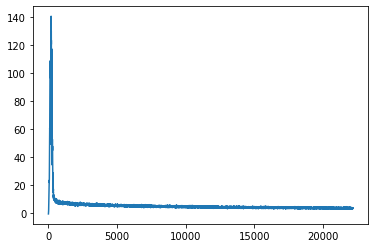

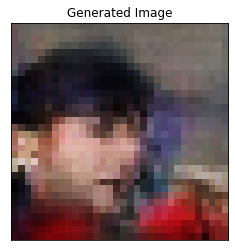

checkpointing at epoch: 20000
Iteration [20001/100000]......0.208(s) gen: 134.56064 - disc_fake: -134.53004 - disc_real: -130.78434 - disc_real: 3.74571
Iteration [20002/100000]......0.222(s) gen: 134.66208 - disc_fake: -134.71632 - disc_real: -131.25904 - disc_real: 3.45728
Iteration [20003/100000]......0.224(s) gen: 134.39929 - disc_fake: -134.43604 - disc_real: -130.89226 - disc_real: 3.54378
Iteration [20004/100000]......0.224(s) gen: 133.60646 - disc_fake: -134.17828 - disc_real: -130.64815 - disc_real: 3.53013
Iteration [20005/100000]......0.223(s) gen: 132.64883 - disc_fake: -133.51225 - disc_real: -129.46104 - disc_real: 4.05121
Iteration [20006/100000]......0.223(s) gen: 132.09085 - disc_fake: -132.75063 - disc_real: -128.52907 - disc_real: 4.22156
Iteration [20007/100000]......0.220(s) gen: 132.19571 - disc_fake: -132.44247 - disc_real: -129.07856 - disc_real: 3.36391
Iteration [20008/100000]......0.218(s) gen: 132.80255 - disc_fake: -132.83494 - disc_real: -129.19394 - disc_

Iteration [20069/100000]......0.199(s) gen: 133.40128 - disc_fake: -134.12014 - disc_real: -130.59157 - disc_real: 3.52856
Iteration [20070/100000]......0.196(s) gen: 132.83362 - disc_fake: -133.28402 - disc_real: -129.65566 - disc_real: 3.62836
Iteration [20071/100000]......0.198(s) gen: 132.52805 - disc_fake: -132.50797 - disc_real: -128.73184 - disc_real: 3.77613
Iteration [20072/100000]......0.199(s) gen: 132.19333 - disc_fake: -132.28370 - disc_real: -128.51497 - disc_real: 3.76873
Iteration [20073/100000]......0.202(s) gen: 132.13116 - disc_fake: -132.47762 - disc_real: -128.86166 - disc_real: 3.61596
Iteration [20074/100000]......0.202(s) gen: 133.14114 - disc_fake: -132.58343 - disc_real: -129.07498 - disc_real: 3.50845
Iteration [20075/100000]......0.200(s) gen: 133.66510 - disc_fake: -133.14879 - disc_real: -129.73136 - disc_real: 3.41742
Iteration [20076/100000]......0.199(s) gen: 133.85342 - disc_fake: -133.82270 - disc_real: -130.48232 - disc_real: 3.34038
Iteration [20077

Iteration [20136/100000]......0.202(s) gen: 133.64862 - disc_fake: -134.21137 - disc_real: -130.55679 - disc_real: 3.65458
Iteration [20137/100000]......0.202(s) gen: 133.18468 - disc_fake: -133.39791 - disc_real: -129.69656 - disc_real: 3.70135
Iteration [20138/100000]......0.204(s) gen: 133.18910 - disc_fake: -132.83182 - disc_real: -129.45907 - disc_real: 3.37275
Iteration [20139/100000]......0.199(s) gen: 132.94180 - disc_fake: -132.86544 - disc_real: -129.22010 - disc_real: 3.64534
Iteration [20140/100000]......0.196(s) gen: 133.32251 - disc_fake: -133.32190 - disc_real: -129.89491 - disc_real: 3.42699
Iteration [20141/100000]......0.195(s) gen: 133.58441 - disc_fake: -133.53815 - disc_real: -129.86223 - disc_real: 3.67592
Iteration [20142/100000]......0.200(s) gen: 134.62494 - disc_fake: -133.93740 - disc_real: -130.62473 - disc_real: 3.31267
Iteration [20143/100000]......0.202(s) gen: 135.16374 - disc_fake: -134.37223 - disc_real: -131.18416 - disc_real: 3.18807
Iteration [20144

Iteration [20203/100000]......0.213(s) gen: 133.36343 - disc_fake: -133.60451 - disc_real: -130.13099 - disc_real: 3.47352
Iteration [20204/100000]......0.214(s) gen: 133.82840 - disc_fake: -133.19533 - disc_real: -130.00097 - disc_real: 3.19436
Iteration [20205/100000]......0.213(s) gen: 133.60449 - disc_fake: -133.60995 - disc_real: -130.43839 - disc_real: 3.17157
Iteration [20206/100000]......0.209(s) gen: 134.29861 - disc_fake: -133.71577 - disc_real: -130.10605 - disc_real: 3.60971
Iteration [20207/100000]......0.208(s) gen: 134.56123 - disc_fake: -134.14653 - disc_real: -130.66687 - disc_real: 3.47965
Iteration [20208/100000]......0.203(s) gen: 134.41484 - disc_fake: -134.25722 - disc_real: -130.78321 - disc_real: 3.47402
Iteration [20209/100000]......0.200(s) gen: 133.85663 - disc_fake: -134.08955 - disc_real: -130.37510 - disc_real: 3.71445
Iteration [20210/100000]......0.201(s) gen: 133.94989 - disc_fake: -133.73834 - disc_real: -130.39199 - disc_real: 3.34635
Iteration [20211

Iteration [20270/100000]......0.201(s) gen: 134.80188 - disc_fake: -135.04771 - disc_real: -131.86989 - disc_real: 3.17782
Iteration [20271/100000]......0.199(s) gen: 134.45468 - disc_fake: -134.91865 - disc_real: -131.57492 - disc_real: 3.34373
Iteration [20272/100000]......0.199(s) gen: 133.68428 - disc_fake: -134.34528 - disc_real: -130.52430 - disc_real: 3.82098
Iteration [20273/100000]......0.201(s) gen: 134.26352 - disc_fake: -133.60270 - disc_real: -130.12478 - disc_real: 3.47793
Iteration [20274/100000]......0.202(s) gen: 134.55142 - disc_fake: -134.25670 - disc_real: -130.84366 - disc_real: 3.41305
Iteration [20275/100000]......0.200(s) gen: 134.49078 - disc_fake: -134.30405 - disc_real: -130.83642 - disc_real: 3.46764
Iteration [20276/100000]......0.199(s) gen: 134.06348 - disc_fake: -134.41182 - disc_real: -130.75980 - disc_real: 3.65202
Iteration [20277/100000]......0.197(s) gen: 135.19289 - disc_fake: -134.42631 - disc_real: -131.09197 - disc_real: 3.33434
Iteration [20278

Iteration [20337/100000]......0.202(s) gen: 134.53799 - disc_fake: -135.01311 - disc_real: -131.40408 - disc_real: 3.60903
Iteration [20338/100000]......0.200(s) gen: 135.12134 - disc_fake: -134.74396 - disc_real: -131.45610 - disc_real: 3.28786
Iteration [20339/100000]......0.200(s) gen: 136.31970 - disc_fake: -135.55578 - disc_real: -132.39710 - disc_real: 3.15868
Iteration [20340/100000]......0.200(s) gen: 135.44331 - disc_fake: -136.51860 - disc_real: -132.35219 - disc_real: 4.16642
Iteration [20341/100000]......0.200(s) gen: 135.21475 - disc_fake: -135.38506 - disc_real: -132.03273 - disc_real: 3.35233
Iteration [20342/100000]......0.197(s) gen: 135.10825 - disc_fake: -135.40703 - disc_real: -131.59057 - disc_real: 3.81646
Iteration [20343/100000]......0.197(s) gen: 135.12053 - disc_fake: -135.38909 - disc_real: -132.11839 - disc_real: 3.27070
Iteration [20344/100000]......0.197(s) gen: 135.26093 - disc_fake: -135.24059 - disc_real: -131.77684 - disc_real: 3.46375
Iteration [20345

Iteration [20405/100000]......0.198(s) gen: 135.35814 - disc_fake: -134.91501 - disc_real: -131.80085 - disc_real: 3.11417
Iteration [20406/100000]......0.195(s) gen: 134.90776 - disc_fake: -135.13061 - disc_real: -131.44724 - disc_real: 3.68337
Iteration [20407/100000]......0.196(s) gen: 134.54773 - disc_fake: -134.86754 - disc_real: -131.33473 - disc_real: 3.53282
Iteration [20408/100000]......0.195(s) gen: 134.93344 - disc_fake: -134.70025 - disc_real: -130.65085 - disc_real: 4.04939
Iteration [20409/100000]......0.198(s) gen: 134.28925 - disc_fake: -134.70192 - disc_real: -130.86129 - disc_real: 3.84062
Iteration [20410/100000]......0.198(s) gen: 134.71886 - disc_fake: -134.54348 - disc_real: -130.28578 - disc_real: 4.25770
Iteration [20411/100000]......0.200(s) gen: 134.76373 - disc_fake: -134.34106 - disc_real: -131.06627 - disc_real: 3.27480
Iteration [20412/100000]......0.199(s) gen: 134.31326 - disc_fake: -134.36918 - disc_real: -130.48294 - disc_real: 3.88625
Iteration [20413

Iteration [20472/100000]......0.205(s) gen: 134.43555 - disc_fake: -134.30691 - disc_real: -130.57972 - disc_real: 3.72719
Iteration [20473/100000]......0.205(s) gen: 134.48688 - disc_fake: -134.15765 - disc_real: -130.65605 - disc_real: 3.50161
Iteration [20474/100000]......0.205(s) gen: 134.03061 - disc_fake: -133.81426 - disc_real: -130.21497 - disc_real: 3.59929
Iteration [20475/100000]......0.202(s) gen: 134.78574 - disc_fake: -134.29216 - disc_real: -130.95497 - disc_real: 3.33719
Iteration [20476/100000]......0.200(s) gen: 135.18118 - disc_fake: -134.58892 - disc_real: -131.38467 - disc_real: 3.20425
Iteration [20477/100000]......0.199(s) gen: 135.32993 - disc_fake: -135.10751 - disc_real: -131.96661 - disc_real: 3.14090
Iteration [20478/100000]......0.197(s) gen: 135.79401 - disc_fake: -135.62857 - disc_real: -132.26232 - disc_real: 3.36625
Iteration [20479/100000]......0.197(s) gen: 136.40030 - disc_fake: -136.18016 - disc_real: -132.72001 - disc_real: 3.46015
Iteration [20480

Iteration [20538/100000]......0.195(s) gen: 135.52499 - disc_fake: -135.93890 - disc_real: -132.24963 - disc_real: 3.68926
Iteration [20539/100000]......0.196(s) gen: 136.00723 - disc_fake: -136.13492 - disc_real: -132.54958 - disc_real: 3.58535
Iteration [20540/100000]......0.197(s) gen: 135.82686 - disc_fake: -136.01740 - disc_real: -132.33684 - disc_real: 3.68056
Iteration [20541/100000]......0.194(s) gen: 135.19173 - disc_fake: -135.54857 - disc_real: -132.16816 - disc_real: 3.38041
Iteration [20542/100000]......0.193(s) gen: 134.88794 - disc_fake: -134.70746 - disc_real: -131.12069 - disc_real: 3.58677
Iteration [20543/100000]......0.195(s) gen: 135.01318 - disc_fake: -134.96255 - disc_real: -131.02600 - disc_real: 3.93655
Iteration [20544/100000]......0.195(s) gen: 134.53195 - disc_fake: -134.75084 - disc_real: -131.28098 - disc_real: 3.46986
Iteration [20545/100000]......0.196(s) gen: 134.66383 - disc_fake: -134.50278 - disc_real: -130.71721 - disc_real: 3.78557
Iteration [20546

Iteration [20606/100000]......0.200(s) gen: 136.10873 - disc_fake: -135.79156 - disc_real: -132.32647 - disc_real: 3.46509
Iteration [20607/100000]......0.200(s) gen: 135.52744 - disc_fake: -135.63198 - disc_real: -132.10083 - disc_real: 3.53115
Iteration [20608/100000]......0.198(s) gen: 134.87096 - disc_fake: -135.32964 - disc_real: -131.87773 - disc_real: 3.45191
Iteration [20609/100000]......0.197(s) gen: 136.20718 - disc_fake: -135.52191 - disc_real: -132.17101 - disc_real: 3.35089
Iteration [20610/100000]......0.197(s) gen: 137.08925 - disc_fake: -136.29625 - disc_real: -132.92226 - disc_real: 3.37399
Iteration [20611/100000]......0.196(s) gen: 136.31616 - disc_fake: -136.35217 - disc_real: -132.98832 - disc_real: 3.36385
Iteration [20612/100000]......0.195(s) gen: 135.92868 - disc_fake: -136.04166 - disc_real: -132.48056 - disc_real: 3.56110
Iteration [20613/100000]......0.197(s) gen: 135.90103 - disc_fake: -135.50129 - disc_real: -132.35435 - disc_real: 3.14694
Iteration [20614

Iteration [20673/100000]......0.204(s) gen: 136.35168 - disc_fake: -136.39767 - disc_real: -133.13326 - disc_real: 3.26440
Iteration [20674/100000]......0.205(s) gen: 136.26178 - disc_fake: -135.98177 - disc_real: -133.02823 - disc_real: 2.95354
Iteration [20675/100000]......0.206(s) gen: 136.29434 - disc_fake: -136.42328 - disc_real: -132.84822 - disc_real: 3.57506
Iteration [20676/100000]......0.210(s) gen: 134.98685 - disc_fake: -135.73948 - disc_real: -132.18003 - disc_real: 3.55945
Iteration [20677/100000]......0.212(s) gen: 135.28658 - disc_fake: -134.78458 - disc_real: -131.29381 - disc_real: 3.49077
Iteration [20678/100000]......0.211(s) gen: 135.03860 - disc_fake: -135.01383 - disc_real: -131.33669 - disc_real: 3.67714
Iteration [20679/100000]......0.208(s) gen: 135.17075 - disc_fake: -135.07895 - disc_real: -131.65395 - disc_real: 3.42499
Iteration [20680/100000]......0.205(s) gen: 136.38805 - disc_fake: -135.57965 - disc_real: -131.87854 - disc_real: 3.70111
Iteration [20681

Iteration [20740/100000]......0.199(s) gen: 135.90411 - disc_fake: -136.09897 - disc_real: -132.30751 - disc_real: 3.79146
Iteration [20741/100000]......0.201(s) gen: 136.96759 - disc_fake: -135.88260 - disc_real: -132.74434 - disc_real: 3.13826
Iteration [20742/100000]......0.199(s) gen: 136.49283 - disc_fake: -136.50110 - disc_real: -132.91853 - disc_real: 3.58257
Iteration [20743/100000]......0.200(s) gen: 136.89001 - disc_fake: -136.35591 - disc_real: -133.10553 - disc_real: 3.25039
Iteration [20744/100000]......0.200(s) gen: 137.41550 - disc_fake: -137.09197 - disc_real: -133.43618 - disc_real: 3.65578
Iteration [20745/100000]......0.201(s) gen: 136.29852 - disc_fake: -136.45575 - disc_real: -132.90915 - disc_real: 3.54660
Iteration [20746/100000]......0.201(s) gen: 136.04301 - disc_fake: -136.07513 - disc_real: -132.62110 - disc_real: 3.45403
Iteration [20747/100000]......0.201(s) gen: 135.75267 - disc_fake: -135.66875 - disc_real: -132.28366 - disc_real: 3.38509
Iteration [20748

Iteration [20807/100000]......0.197(s) gen: 135.96864 - disc_fake: -135.47005 - disc_real: -131.96670 - disc_real: 3.50335
Iteration [20808/100000]......0.198(s) gen: 136.95212 - disc_fake: -136.34374 - disc_real: -132.95291 - disc_real: 3.39083
Iteration [20809/100000]......0.197(s) gen: 137.18066 - disc_fake: -136.93662 - disc_real: -133.47585 - disc_real: 3.46077
Iteration [20810/100000]......0.197(s) gen: 136.91876 - disc_fake: -136.95574 - disc_real: -133.70557 - disc_real: 3.25017
Iteration [20811/100000]......0.197(s) gen: 136.60760 - disc_fake: -137.00948 - disc_real: -133.47872 - disc_real: 3.53076
Iteration [20812/100000]......0.197(s) gen: 136.14548 - disc_fake: -136.13667 - disc_real: -132.63651 - disc_real: 3.50016
Iteration [20813/100000]......0.197(s) gen: 135.72394 - disc_fake: -135.78812 - disc_real: -132.30834 - disc_real: 3.47978
Iteration [20814/100000]......0.197(s) gen: 135.27654 - disc_fake: -135.33306 - disc_real: -131.81167 - disc_real: 3.52139
Iteration [20815

Iteration [20874/100000]......0.201(s) gen: 134.91127 - disc_fake: -134.61480 - disc_real: -131.01443 - disc_real: 3.60038
Iteration [20875/100000]......0.202(s) gen: 135.76172 - disc_fake: -134.95613 - disc_real: -131.56326 - disc_real: 3.39288
Iteration [20876/100000]......0.201(s) gen: 135.88374 - disc_fake: -135.66243 - disc_real: -131.85586 - disc_real: 3.80657
Iteration [20877/100000]......0.200(s) gen: 135.62306 - disc_fake: -135.65468 - disc_real: -131.90025 - disc_real: 3.75443
Iteration [20878/100000]......0.198(s) gen: 136.28458 - disc_fake: -135.65634 - disc_real: -132.58136 - disc_real: 3.07498
Iteration [20879/100000]......0.197(s) gen: 136.66264 - disc_fake: -136.25663 - disc_real: -133.17386 - disc_real: 3.08276
Iteration [20880/100000]......0.195(s) gen: 136.79428 - disc_fake: -136.73170 - disc_real: -133.14438 - disc_real: 3.58731
Iteration [20881/100000]......0.197(s) gen: 137.33566 - disc_fake: -136.90537 - disc_real: -133.74886 - disc_real: 3.15651
Iteration [20882

Iteration [20942/100000]......0.199(s) gen: 137.22839 - disc_fake: -137.34136 - disc_real: -134.19845 - disc_real: 3.14291
Iteration [20943/100000]......0.201(s) gen: 137.15413 - disc_fake: -137.18974 - disc_real: -133.89521 - disc_real: 3.29453
Iteration [20944/100000]......0.201(s) gen: 136.81030 - disc_fake: -136.92862 - disc_real: -133.39618 - disc_real: 3.53244
Iteration [20945/100000]......0.201(s) gen: 136.23964 - disc_fake: -136.42408 - disc_real: -132.74252 - disc_real: 3.68156
Iteration [20946/100000]......0.199(s) gen: 136.65125 - disc_fake: -136.58646 - disc_real: -132.97188 - disc_real: 3.61458
Iteration [20947/100000]......0.198(s) gen: 137.19434 - disc_fake: -136.60602 - disc_real: -133.09336 - disc_real: 3.51266
Iteration [20948/100000]......0.198(s) gen: 136.45677 - disc_fake: -136.78433 - disc_real: -133.06503 - disc_real: 3.71930
Iteration [20949/100000]......0.198(s) gen: 136.50058 - disc_fake: -136.32663 - disc_real: -132.72044 - disc_real: 3.60620
Iteration [20950

Iteration [21010/100000]......0.202(s) gen: 136.89034 - disc_fake: -136.65026 - disc_real: -133.28065 - disc_real: 3.36962
Iteration [21011/100000]......0.207(s) gen: 136.35545 - disc_fake: -136.32874 - disc_real: -133.14908 - disc_real: 3.17966
Iteration [21012/100000]......0.202(s) gen: 136.77557 - disc_fake: -136.40786 - disc_real: -133.21116 - disc_real: 3.19669
Iteration [21013/100000]......0.202(s) gen: 136.88591 - disc_fake: -136.81355 - disc_real: -133.45306 - disc_real: 3.36049
Iteration [21014/100000]......0.206(s) gen: 136.59103 - disc_fake: -137.26641 - disc_real: -133.62639 - disc_real: 3.64002
Iteration [21015/100000]......0.205(s) gen: 136.84650 - disc_fake: -136.91110 - disc_real: -133.47299 - disc_real: 3.43810
Iteration [21016/100000]......0.201(s) gen: 136.74460 - disc_fake: -136.92364 - disc_real: -133.59022 - disc_real: 3.33341
Iteration [21017/100000]......0.200(s) gen: 136.43411 - disc_fake: -136.67803 - disc_real: -133.47189 - disc_real: 3.20614
Iteration [21018

Iteration [21078/100000]......0.211(s) gen: 136.86078 - disc_fake: -136.84108 - disc_real: -133.44869 - disc_real: 3.39239
Iteration [21079/100000]......0.205(s) gen: 136.55121 - disc_fake: -136.98042 - disc_real: -133.39345 - disc_real: 3.58697
Iteration [21080/100000]......0.206(s) gen: 136.22536 - disc_fake: -136.06798 - disc_real: -132.66344 - disc_real: 3.40455
Iteration [21081/100000]......0.208(s) gen: 137.23257 - disc_fake: -136.63172 - disc_real: -133.02524 - disc_real: 3.60648
Iteration [21082/100000]......0.205(s) gen: 136.66763 - disc_fake: -136.87860 - disc_real: -133.35542 - disc_real: 3.52318
Iteration [21083/100000]......0.206(s) gen: 137.13791 - disc_fake: -137.39594 - disc_real: -133.99292 - disc_real: 3.40302
Iteration [21084/100000]......0.202(s) gen: 137.56906 - disc_fake: -137.17423 - disc_real: -133.66140 - disc_real: 3.51283
Iteration [21085/100000]......0.200(s) gen: 137.14154 - disc_fake: -137.21626 - disc_real: -133.95282 - disc_real: 3.26344
Iteration [21086

Iteration [21145/100000]......0.192(s) gen: 136.92233 - disc_fake: -136.64767 - disc_real: -133.26751 - disc_real: 3.38016
Iteration [21146/100000]......0.192(s) gen: 137.33383 - disc_fake: -137.22102 - disc_real: -133.74691 - disc_real: 3.47410
Iteration [21147/100000]......0.192(s) gen: 137.64847 - disc_fake: -137.61640 - disc_real: -133.94326 - disc_real: 3.67314
Iteration [21148/100000]......0.193(s) gen: 138.53888 - disc_fake: -137.77063 - disc_real: -134.56541 - disc_real: 3.20522
Iteration [21149/100000]......0.209(s) gen: 138.89748 - disc_fake: -138.80249 - disc_real: -135.51181 - disc_real: 3.29068
Iteration [21150/100000]......0.206(s) gen: 137.48941 - disc_fake: -138.22630 - disc_real: -134.80381 - disc_real: 3.42249
Iteration [21151/100000]......0.201(s) gen: 136.77664 - disc_fake: -137.34126 - disc_real: -133.83278 - disc_real: 3.50848
Iteration [21152/100000]......0.199(s) gen: 136.54172 - disc_fake: -136.80616 - disc_real: -133.06636 - disc_real: 3.73979
Iteration [21153

Iteration [21212/100000]......0.203(s) gen: 135.82471 - disc_fake: -136.52320 - disc_real: -132.76102 - disc_real: 3.76218
Iteration [21213/100000]......0.201(s) gen: 135.60728 - disc_fake: -135.58162 - disc_real: -131.72702 - disc_real: 3.85461
Iteration [21214/100000]......0.203(s) gen: 135.49887 - disc_fake: -135.57605 - disc_real: -131.83380 - disc_real: 3.74225
Iteration [21215/100000]......0.199(s) gen: 135.36346 - disc_fake: -135.73716 - disc_real: -132.19074 - disc_real: 3.54642
Iteration [21216/100000]......0.195(s) gen: 136.27197 - disc_fake: -135.34233 - disc_real: -132.06750 - disc_real: 3.27482
Iteration [21217/100000]......0.197(s) gen: 137.27928 - disc_fake: -136.18271 - disc_real: -133.32995 - disc_real: 2.85276
Iteration [21218/100000]......0.198(s) gen: 138.62454 - disc_fake: -137.88959 - disc_real: -134.53937 - disc_real: 3.35022
Iteration [21219/100000]......0.198(s) gen: 138.14389 - disc_fake: -138.51797 - disc_real: -135.01169 - disc_real: 3.50627
Iteration [21220

Iteration [21280/100000]......0.193(s) gen: 137.44519 - disc_fake: -138.13985 - disc_real: -134.60668 - disc_real: 3.53317
Iteration [21281/100000]......0.192(s) gen: 136.84418 - disc_fake: -136.99687 - disc_real: -133.96137 - disc_real: 3.03549
Iteration [21282/100000]......0.192(s) gen: 137.10767 - disc_fake: -136.77460 - disc_real: -133.50480 - disc_real: 3.26980
Iteration [21283/100000]......0.192(s) gen: 137.06323 - disc_fake: -137.01707 - disc_real: -133.18566 - disc_real: 3.83141
Iteration [21284/100000]......0.192(s) gen: 137.25169 - disc_fake: -137.14104 - disc_real: -133.28904 - disc_real: 3.85200
Iteration [21285/100000]......0.192(s) gen: 136.75586 - disc_fake: -137.06794 - disc_real: -133.47411 - disc_real: 3.59383
Iteration [21286/100000]......0.193(s) gen: 137.65295 - disc_fake: -137.34343 - disc_real: -134.18752 - disc_real: 3.15590
Iteration [21287/100000]......0.194(s) gen: 138.20955 - disc_fake: -137.52498 - disc_real: -134.21937 - disc_real: 3.30562
Iteration [21288

Iteration [21347/100000]......0.198(s) gen: 136.95038 - disc_fake: -137.25217 - disc_real: -133.70872 - disc_real: 3.54345
Iteration [21348/100000]......0.197(s) gen: 137.17165 - disc_fake: -136.96630 - disc_real: -133.89726 - disc_real: 3.06904
Iteration [21349/100000]......0.198(s) gen: 137.95905 - disc_fake: -137.25236 - disc_real: -134.07719 - disc_real: 3.17516
Iteration [21350/100000]......0.204(s) gen: 137.70099 - disc_fake: -137.90085 - disc_real: -134.51450 - disc_real: 3.38635
Iteration [21351/100000]......0.205(s) gen: 137.81825 - disc_fake: -137.26974 - disc_real: -133.88016 - disc_real: 3.38958
Iteration [21352/100000]......0.204(s) gen: 137.15408 - disc_fake: -137.23349 - disc_real: -133.77708 - disc_real: 3.45641
Iteration [21353/100000]......0.201(s) gen: 137.39383 - disc_fake: -137.01851 - disc_real: -133.48206 - disc_real: 3.53644
Iteration [21354/100000]......0.199(s) gen: 137.48503 - disc_fake: -137.53128 - disc_real: -133.98445 - disc_real: 3.54683
Iteration [21355

Iteration [21414/100000]......0.200(s) gen: 137.14336 - disc_fake: -137.06911 - disc_real: -133.73333 - disc_real: 3.33578
Iteration [21415/100000]......0.207(s) gen: 137.31862 - disc_fake: -136.84961 - disc_real: -133.62136 - disc_real: 3.22825
Iteration [21416/100000]......0.199(s) gen: 137.05067 - disc_fake: -136.94057 - disc_real: -133.35262 - disc_real: 3.58795
Iteration [21417/100000]......0.200(s) gen: 137.46164 - disc_fake: -137.00437 - disc_real: -133.51072 - disc_real: 3.49365
Iteration [21418/100000]......0.198(s) gen: 138.05000 - disc_fake: -137.50063 - disc_real: -133.99724 - disc_real: 3.50340
Iteration [21419/100000]......0.197(s) gen: 137.85976 - disc_fake: -138.08682 - disc_real: -134.92063 - disc_real: 3.16618
Iteration [21420/100000]......0.198(s) gen: 137.05969 - disc_fake: -137.28967 - disc_real: -133.85346 - disc_real: 3.43621
Iteration [21421/100000]......0.197(s) gen: 137.38841 - disc_fake: -136.93080 - disc_real: -133.51143 - disc_real: 3.41937
Iteration [21422

Iteration [21481/100000]......0.202(s) gen: 137.91460 - disc_fake: -137.41442 - disc_real: -134.20137 - disc_real: 3.21305
Iteration [21482/100000]......0.201(s) gen: 138.70845 - disc_fake: -138.29136 - disc_real: -134.56096 - disc_real: 3.73040
Iteration [21483/100000]......0.201(s) gen: 137.92200 - disc_fake: -138.46590 - disc_real: -134.67082 - disc_real: 3.79508
Iteration [21484/100000]......0.204(s) gen: 137.51483 - disc_fake: -137.51148 - disc_real: -134.02879 - disc_real: 3.48269
Iteration [21485/100000]......0.199(s) gen: 137.85275 - disc_fake: -137.37119 - disc_real: -134.01564 - disc_real: 3.35555
Iteration [21486/100000]......0.201(s) gen: 137.54141 - disc_fake: -137.23165 - disc_real: -133.39841 - disc_real: 3.83324
Iteration [21487/100000]......0.202(s) gen: 137.76700 - disc_fake: -137.35559 - disc_real: -134.24986 - disc_real: 3.10573
Iteration [21488/100000]......0.199(s) gen: 138.24019 - disc_fake: -138.04034 - disc_real: -134.60558 - disc_real: 3.43477
Iteration [21489

Iteration [21548/100000]......0.200(s) gen: 138.17010 - disc_fake: -138.84828 - disc_real: -135.53593 - disc_real: 3.31235
Iteration [21549/100000]......0.202(s) gen: 138.40077 - disc_fake: -138.04395 - disc_real: -134.93112 - disc_real: 3.11283
Iteration [21550/100000]......0.201(s) gen: 138.41730 - disc_fake: -138.35158 - disc_real: -134.95933 - disc_real: 3.39225
Iteration [21551/100000]......0.201(s) gen: 138.81387 - disc_fake: -138.53267 - disc_real: -134.95706 - disc_real: 3.57561
Iteration [21552/100000]......0.201(s) gen: 138.77010 - disc_fake: -139.06276 - disc_real: -135.61360 - disc_real: 3.44917
Iteration [21553/100000]......0.199(s) gen: 139.14426 - disc_fake: -138.43724 - disc_real: -134.86264 - disc_real: 3.57460
Iteration [21554/100000]......0.199(s) gen: 138.74292 - disc_fake: -138.78449 - disc_real: -135.33966 - disc_real: 3.44484
Iteration [21555/100000]......0.197(s) gen: 137.35028 - disc_fake: -138.16659 - disc_real: -134.46961 - disc_real: 3.69698
Iteration [21556

Iteration [21615/100000]......0.202(s) gen: 138.55267 - disc_fake: -138.96024 - disc_real: -135.29086 - disc_real: 3.66938
Iteration [21616/100000]......0.201(s) gen: 138.79462 - disc_fake: -138.41426 - disc_real: -135.10145 - disc_real: 3.31281
Iteration [21617/100000]......0.197(s) gen: 139.27390 - disc_fake: -139.25107 - disc_real: -135.48315 - disc_real: 3.76792
Iteration [21618/100000]......0.198(s) gen: 139.51176 - disc_fake: -139.35669 - disc_real: -135.67796 - disc_real: 3.67873
Iteration [21619/100000]......0.198(s) gen: 139.73796 - disc_fake: -139.49630 - disc_real: -136.23271 - disc_real: 3.26359
Iteration [21620/100000]......0.199(s) gen: 139.80074 - disc_fake: -139.65903 - disc_real: -136.41593 - disc_real: 3.24310
Iteration [21621/100000]......0.199(s) gen: 139.28954 - disc_fake: -139.59788 - disc_real: -136.35459 - disc_real: 3.24329
Iteration [21622/100000]......0.197(s) gen: 139.07303 - disc_fake: -138.94867 - disc_real: -135.62989 - disc_real: 3.31878
Iteration [21623

Iteration [21683/100000]......0.194(s) gen: 138.36475 - disc_fake: -138.56866 - disc_real: -135.37562 - disc_real: 3.19304
Iteration [21684/100000]......0.192(s) gen: 138.53879 - disc_fake: -138.40587 - disc_real: -135.20829 - disc_real: 3.19759
Iteration [21685/100000]......0.195(s) gen: 138.77032 - disc_fake: -138.65589 - disc_real: -135.20222 - disc_real: 3.45367
Iteration [21686/100000]......0.194(s) gen: 138.65926 - disc_fake: -138.77216 - disc_real: -135.33787 - disc_real: 3.43429
Iteration [21687/100000]......0.197(s) gen: 138.50317 - disc_fake: -138.56617 - disc_real: -135.21181 - disc_real: 3.35435
Iteration [21688/100000]......0.198(s) gen: 138.61990 - disc_fake: -138.40535 - disc_real: -134.80475 - disc_real: 3.60060
Iteration [21689/100000]......0.197(s) gen: 138.18948 - disc_fake: -138.32954 - disc_real: -134.93055 - disc_real: 3.39899
Iteration [21690/100000]......0.196(s) gen: 138.76779 - disc_fake: -138.42246 - disc_real: -135.52974 - disc_real: 2.89272
Iteration [21691

Iteration [21750/100000]......0.198(s) gen: 139.30762 - disc_fake: -139.67174 - disc_real: -135.88375 - disc_real: 3.78799
Iteration [21751/100000]......0.196(s) gen: 139.16220 - disc_fake: -139.32411 - disc_real: -136.23934 - disc_real: 3.08477
Iteration [21752/100000]......0.195(s) gen: 139.58292 - disc_fake: -139.47451 - disc_real: -136.35823 - disc_real: 3.11627
Iteration [21753/100000]......0.194(s) gen: 140.97089 - disc_fake: -140.03456 - disc_real: -136.63615 - disc_real: 3.39840
Iteration [21754/100000]......0.193(s) gen: 140.99387 - disc_fake: -141.07507 - disc_real: -137.51416 - disc_real: 3.56091
Iteration [21755/100000]......0.191(s) gen: 139.81732 - disc_fake: -140.63784 - disc_real: -137.11405 - disc_real: 3.52379
Iteration [21756/100000]......0.192(s) gen: 139.49255 - disc_fake: -139.64642 - disc_real: -136.05075 - disc_real: 3.59567
Iteration [21757/100000]......0.192(s) gen: 139.48059 - disc_fake: -139.19917 - disc_real: -135.62144 - disc_real: 3.57773
Iteration [21758

Iteration [21818/100000]......0.199(s) gen: 137.43465 - disc_fake: -137.83974 - disc_real: -134.13649 - disc_real: 3.70326
Iteration [21819/100000]......0.201(s) gen: 138.74371 - disc_fake: -138.05654 - disc_real: -134.98846 - disc_real: 3.06808
Iteration [21820/100000]......0.199(s) gen: 139.40182 - disc_fake: -138.79451 - disc_real: -135.44118 - disc_real: 3.35333
Iteration [21821/100000]......0.199(s) gen: 138.77560 - disc_fake: -139.15104 - disc_real: -135.76959 - disc_real: 3.38145
Iteration [21822/100000]......0.199(s) gen: 139.72394 - disc_fake: -139.03071 - disc_real: -135.54009 - disc_real: 3.49062
Iteration [21823/100000]......0.198(s) gen: 139.38031 - disc_fake: -138.95754 - disc_real: -135.88186 - disc_real: 3.07567
Iteration [21824/100000]......0.196(s) gen: 138.72333 - disc_fake: -138.99990 - disc_real: -135.43694 - disc_real: 3.56296
Iteration [21825/100000]......0.195(s) gen: 138.24380 - disc_fake: -138.44674 - disc_real: -135.27177 - disc_real: 3.17496
Iteration [21826

Iteration [21885/100000]......0.198(s) gen: 138.95047 - disc_fake: -139.40743 - disc_real: -136.01812 - disc_real: 3.38931
Iteration [21886/100000]......0.195(s) gen: 138.83417 - disc_fake: -138.74930 - disc_real: -135.39270 - disc_real: 3.35659
Iteration [21887/100000]......0.197(s) gen: 139.13101 - disc_fake: -138.88080 - disc_real: -135.59971 - disc_real: 3.28109
Iteration [21888/100000]......0.196(s) gen: 139.32918 - disc_fake: -139.20617 - disc_real: -135.70866 - disc_real: 3.49751
Iteration [21889/100000]......0.195(s) gen: 139.56091 - disc_fake: -139.47365 - disc_real: -136.37117 - disc_real: 3.10248
Iteration [21890/100000]......0.196(s) gen: 138.92110 - disc_fake: -139.29124 - disc_real: -135.32017 - disc_real: 3.97107
Iteration [21891/100000]......0.197(s) gen: 138.72858 - disc_fake: -138.50994 - disc_real: -135.33025 - disc_real: 3.17969
Iteration [21892/100000]......0.194(s) gen: 138.72856 - disc_fake: -139.01697 - disc_real: -135.59665 - disc_real: 3.42032
Iteration [21893

Iteration [21952/100000]......0.215(s) gen: 137.94513 - disc_fake: -137.89264 - disc_real: -134.53121 - disc_real: 3.36143
Iteration [21953/100000]......0.200(s) gen: 137.66045 - disc_fake: -137.98998 - disc_real: -134.50148 - disc_real: 3.48849
Iteration [21954/100000]......0.198(s) gen: 138.19565 - disc_fake: -137.94959 - disc_real: -134.47440 - disc_real: 3.47519
Iteration [21955/100000]......0.199(s) gen: 138.74728 - disc_fake: -138.23471 - disc_real: -135.27463 - disc_real: 2.96008
Iteration [21956/100000]......0.199(s) gen: 138.60344 - disc_fake: -138.65568 - disc_real: -135.08458 - disc_real: 3.57109
Iteration [21957/100000]......0.199(s) gen: 139.26961 - disc_fake: -138.67509 - disc_real: -135.44392 - disc_real: 3.23116
Iteration [21958/100000]......0.198(s) gen: 140.03485 - disc_fake: -139.40680 - disc_real: -136.10379 - disc_real: 3.30301
Iteration [21959/100000]......0.199(s) gen: 140.61682 - disc_fake: -140.11535 - disc_real: -136.72546 - disc_real: 3.38988
Iteration [21960

Iteration [22019/100000]......0.198(s) gen: 138.31277 - disc_fake: -139.27363 - disc_real: -135.40439 - disc_real: 3.86924
Iteration [22020/100000]......0.196(s) gen: 138.50119 - disc_fake: -138.19529 - disc_real: -134.36098 - disc_real: 3.83431
Iteration [22021/100000]......0.195(s) gen: 138.30074 - disc_fake: -138.11418 - disc_real: -134.62184 - disc_real: 3.49234
Iteration [22022/100000]......0.195(s) gen: 138.40591 - disc_fake: -138.10383 - disc_real: -135.35736 - disc_real: 2.74646
Iteration [22023/100000]......0.196(s) gen: 138.23422 - disc_fake: -138.17504 - disc_real: -134.87327 - disc_real: 3.30177
Iteration [22024/100000]......0.198(s) gen: 139.19859 - disc_fake: -138.74337 - disc_real: -135.43905 - disc_real: 3.30432
Iteration [22025/100000]......0.197(s) gen: 140.08047 - disc_fake: -139.46930 - disc_real: -135.98062 - disc_real: 3.48867
Iteration [22026/100000]......0.199(s) gen: 139.68404 - disc_fake: -139.94883 - disc_real: -136.04782 - disc_real: 3.90101
Iteration [22027

Iteration [22086/100000]......0.198(s) gen: 139.99863 - disc_fake: -140.26420 - disc_real: -136.32339 - disc_real: 3.94082
Iteration [22087/100000]......0.198(s) gen: 140.43417 - disc_fake: -140.05739 - disc_real: -136.32643 - disc_real: 3.73095
Iteration [22088/100000]......0.198(s) gen: 139.77411 - disc_fake: -140.25020 - disc_real: -136.76951 - disc_real: 3.48069
Iteration [22089/100000]......0.199(s) gen: 139.97644 - disc_fake: -139.62079 - disc_real: -136.25938 - disc_real: 3.36140
Iteration [22090/100000]......0.197(s) gen: 139.47778 - disc_fake: -139.62088 - disc_real: -136.35634 - disc_real: 3.26454
Iteration [22091/100000]......0.197(s) gen: 139.01271 - disc_fake: -139.60591 - disc_real: -135.96672 - disc_real: 3.63918
Iteration [22092/100000]......0.196(s) gen: 138.28363 - disc_fake: -138.63925 - disc_real: -135.31288 - disc_real: 3.32637
Iteration [22093/100000]......0.199(s) gen: 138.20609 - disc_fake: -138.43494 - disc_real: -134.82164 - disc_real: 3.61330
Iteration [22094

Iteration [22154/100000]......0.196(s) gen: 139.10602 - disc_fake: -139.05831 - disc_real: -135.82417 - disc_real: 3.23414
Iteration [22155/100000]......0.197(s) gen: 139.67511 - disc_fake: -139.26819 - disc_real: -136.07637 - disc_real: 3.19182
Iteration [22156/100000]......0.197(s) gen: 139.70285 - disc_fake: -139.85815 - disc_real: -136.29059 - disc_real: 3.56756
Iteration [22157/100000]......0.199(s) gen: 140.26233 - disc_fake: -139.74527 - disc_real: -135.91313 - disc_real: 3.83215
Iteration [22158/100000]......0.199(s) gen: 140.04665 - disc_fake: -139.98414 - disc_real: -136.48317 - disc_real: 3.50097
Iteration [22159/100000]......0.198(s) gen: 140.13734 - disc_fake: -140.19197 - disc_real: -136.89580 - disc_real: 3.29617
Iteration [22160/100000]......0.197(s) gen: 139.20746 - disc_fake: -139.81728 - disc_real: -136.57129 - disc_real: 3.24599
Iteration [22161/100000]......0.198(s) gen: 139.39670 - disc_fake: -139.09401 - disc_real: -135.47858 - disc_real: 3.61543
Iteration [22162

Iteration [22221/100000]......0.202(s) gen: 138.84097 - disc_fake: -138.78866 - disc_real: -135.43641 - disc_real: 3.35225
Iteration [22222/100000]......0.203(s) gen: 139.39354 - disc_fake: -138.80661 - disc_real: -135.65916 - disc_real: 3.14744
Iteration [22223/100000]......0.205(s) gen: 140.40205 - disc_fake: -140.12077 - disc_real: -136.42285 - disc_real: 3.69792
Iteration [22224/100000]......0.200(s) gen: 139.92235 - disc_fake: -140.09449 - disc_real: -136.86807 - disc_real: 3.22642
Iteration [22225/100000]......0.201(s) gen: 139.50636 - disc_fake: -139.74433 - disc_real: -136.17688 - disc_real: 3.56745
Iteration [22226/100000]......0.204(s) gen: 139.83977 - disc_fake: -139.47508 - disc_real: -136.13731 - disc_real: 3.33777
Iteration [22227/100000]......0.206(s) gen: 139.70169 - disc_fake: -139.50154 - disc_real: -136.46366 - disc_real: 3.03788
Iteration [22228/100000]......0.207(s) gen: 140.15092 - disc_fake: -139.77009 - disc_real: -136.58941 - disc_real: 3.18068
Iteration [22229

Iteration [22289/100000]......0.199(s) gen: 140.86658 - disc_fake: -139.88113 - disc_real: -136.53406 - disc_real: 3.34708
Iteration [22290/100000]......0.196(s) gen: 141.11682 - disc_fake: -140.61733 - disc_real: -137.10011 - disc_real: 3.51722
Iteration [22291/100000]......0.196(s) gen: 140.33113 - disc_fake: -140.69087 - disc_real: -137.49830 - disc_real: 3.19257
Iteration [22292/100000]......0.195(s) gen: 140.51550 - disc_fake: -140.60234 - disc_real: -137.06281 - disc_real: 3.53954
Iteration [22293/100000]......0.195(s) gen: 139.47800 - disc_fake: -139.83858 - disc_real: -136.47930 - disc_real: 3.35929
Iteration [22294/100000]......0.197(s) gen: 140.12772 - disc_fake: -139.85438 - disc_real: -136.64862 - disc_real: 3.20576
Iteration [22295/100000]......0.196(s) gen: 139.77438 - disc_fake: -139.63638 - disc_real: -136.33419 - disc_real: 3.30219
Iteration [22296/100000]......0.195(s) gen: 138.65224 - disc_fake: -139.15204 - disc_real: -135.77402 - disc_real: 3.37802
Iteration [22297

Iteration [22356/100000]......0.195(s) gen: 139.47177 - disc_fake: -139.41207 - disc_real: -135.70591 - disc_real: 3.70616
Iteration [22357/100000]......0.194(s) gen: 139.22156 - disc_fake: -139.24247 - disc_real: -135.46312 - disc_real: 3.77935
Iteration [22358/100000]......0.195(s) gen: 138.74887 - disc_fake: -138.71150 - disc_real: -135.18354 - disc_real: 3.52796
Iteration [22359/100000]......0.198(s) gen: 138.89616 - disc_fake: -138.94746 - disc_real: -135.61174 - disc_real: 3.33572
Iteration [22360/100000]......0.197(s) gen: 139.63968 - disc_fake: -138.81508 - disc_real: -135.64912 - disc_real: 3.16595
Iteration [22361/100000]......0.198(s) gen: 140.11990 - disc_fake: -139.44415 - disc_real: -136.26386 - disc_real: 3.18029
Iteration [22362/100000]......0.198(s) gen: 141.42252 - disc_fake: -140.59337 - disc_real: -136.97816 - disc_real: 3.61522
Iteration [22363/100000]......0.200(s) gen: 141.29376 - disc_fake: -141.17446 - disc_real: -137.55205 - disc_real: 3.62242
Iteration [22364

Iteration [22423/100000]......0.196(s) gen: 139.99208 - disc_fake: -140.08433 - disc_real: -136.73835 - disc_real: 3.34598
Iteration [22424/100000]......0.195(s) gen: 139.34250 - disc_fake: -139.84012 - disc_real: -136.48088 - disc_real: 3.35924
Iteration [22425/100000]......0.196(s) gen: 140.06369 - disc_fake: -139.76105 - disc_real: -136.45942 - disc_real: 3.30163
Iteration [22426/100000]......0.194(s) gen: 139.47482 - disc_fake: -139.79378 - disc_real: -136.18819 - disc_real: 3.60558
Iteration [22427/100000]......0.196(s) gen: 139.44003 - disc_fake: -139.50908 - disc_real: -135.59814 - disc_real: 3.91093
Iteration [22428/100000]......0.198(s) gen: 139.13342 - disc_fake: -139.33958 - disc_real: -136.04701 - disc_real: 3.29257
Iteration [22429/100000]......0.197(s) gen: 139.52338 - disc_fake: -139.01926 - disc_real: -135.72769 - disc_real: 3.29157
Iteration [22430/100000]......0.197(s) gen: 139.70914 - disc_fake: -139.32725 - disc_real: -136.10526 - disc_real: 3.22199
Iteration [22431

Iteration [22491/100000]......0.197(s) gen: 139.99380 - disc_fake: -139.88980 - disc_real: -136.65633 - disc_real: 3.23347
Iteration [22492/100000]......0.196(s) gen: 139.98573 - disc_fake: -140.05130 - disc_real: -136.54771 - disc_real: 3.50359
Iteration [22493/100000]......0.196(s) gen: 140.08914 - disc_fake: -139.93805 - disc_real: -136.59197 - disc_real: 3.34608
Iteration [22494/100000]......0.194(s) gen: 139.23569 - disc_fake: -139.74920 - disc_real: -136.13453 - disc_real: 3.61467
Iteration [22495/100000]......0.194(s) gen: 139.31927 - disc_fake: -139.35833 - disc_real: -135.96780 - disc_real: 3.39053
Iteration [22496/100000]......0.194(s) gen: 139.11842 - disc_fake: -139.17571 - disc_real: -135.87726 - disc_real: 3.29846
Iteration [22497/100000]......0.193(s) gen: 140.08012 - disc_fake: -139.06162 - disc_real: -135.77279 - disc_real: 3.28883
Iteration [22498/100000]......0.194(s) gen: 140.48387 - disc_fake: -139.96553 - disc_real: -136.91772 - disc_real: 3.04780
Iteration [22499

Iteration [22558/100000]......0.209(s) gen: 140.15958 - disc_fake: -140.04357 - disc_real: -136.68880 - disc_real: 3.35477
Iteration [22559/100000]......0.208(s) gen: 140.71957 - disc_fake: -140.52247 - disc_real: -137.13899 - disc_real: 3.38348
Iteration [22560/100000]......0.203(s) gen: 140.51529 - disc_fake: -140.78946 - disc_real: -137.28381 - disc_real: 3.50565
Iteration [22561/100000]......0.200(s) gen: 140.12689 - disc_fake: -140.53099 - disc_real: -137.17193 - disc_real: 3.35906
Iteration [22562/100000]......0.197(s) gen: 141.20917 - disc_fake: -140.92686 - disc_real: -137.41757 - disc_real: 3.50929
Iteration [22563/100000]......0.196(s) gen: 140.25890 - disc_fake: -140.83231 - disc_real: -137.36108 - disc_real: 3.47122
Iteration [22564/100000]......0.196(s) gen: 140.43498 - disc_fake: -140.25823 - disc_real: -137.30125 - disc_real: 2.95698
Iteration [22565/100000]......0.198(s) gen: 140.25494 - disc_fake: -140.77635 - disc_real: -137.45577 - disc_real: 3.32058
Iteration [22566

Iteration [22625/100000]......0.201(s) gen: 140.73387 - disc_fake: -140.46592 - disc_real: -137.28574 - disc_real: 3.18018
Iteration [22626/100000]......0.200(s) gen: 141.50403 - disc_fake: -140.89794 - disc_real: -137.56448 - disc_real: 3.33346
Iteration [22627/100000]......0.200(s) gen: 140.68137 - disc_fake: -141.25972 - disc_real: -137.68966 - disc_real: 3.57006
Iteration [22628/100000]......0.200(s) gen: 140.63812 - disc_fake: -140.89935 - disc_real: -137.35812 - disc_real: 3.54123
Iteration [22629/100000]......0.202(s) gen: 141.09616 - disc_fake: -140.66062 - disc_real: -137.48496 - disc_real: 3.17566
Iteration [22630/100000]......0.201(s) gen: 141.29460 - disc_fake: -141.25004 - disc_real: -137.88312 - disc_real: 3.36693
Iteration [22631/100000]......0.205(s) gen: 141.12943 - disc_fake: -141.23198 - disc_real: -137.95833 - disc_real: 3.27366
Iteration [22632/100000]......0.205(s) gen: 140.88087 - disc_fake: -140.95534 - disc_real: -137.78481 - disc_real: 3.17053
Iteration [22633

Iteration [22693/100000]......0.199(s) gen: 140.56400 - disc_fake: -140.82300 - disc_real: -137.41465 - disc_real: 3.40836
Iteration [22694/100000]......0.199(s) gen: 141.11786 - disc_fake: -140.93502 - disc_real: -137.13243 - disc_real: 3.80259
Iteration [22695/100000]......0.203(s) gen: 141.33786 - disc_fake: -141.08503 - disc_real: -137.45134 - disc_real: 3.63369
Iteration [22696/100000]......0.206(s) gen: 141.10178 - disc_fake: -141.08867 - disc_real: -137.63990 - disc_real: 3.44877
Iteration [22697/100000]......0.203(s) gen: 141.12836 - disc_fake: -141.10121 - disc_real: -137.92830 - disc_real: 3.17291
Iteration [22698/100000]......0.213(s) gen: 141.10834 - disc_fake: -141.16215 - disc_real: -137.53830 - disc_real: 3.62385
Iteration [22699/100000]......0.202(s) gen: 140.74374 - disc_fake: -140.92854 - disc_real: -137.51096 - disc_real: 3.41758
Iteration [22700/100000]......0.200(s) gen: 141.02811 - disc_fake: -140.69277 - disc_real: -136.98858 - disc_real: 3.70419
Iteration [22701

Iteration [22760/100000]......0.202(s) gen: 142.04037 - disc_fake: -142.24102 - disc_real: -138.80302 - disc_real: 3.43800
Iteration [22761/100000]......0.202(s) gen: 140.76237 - disc_fake: -141.73423 - disc_real: -138.22622 - disc_real: 3.50801
Iteration [22762/100000]......0.200(s) gen: 140.64334 - disc_fake: -140.98976 - disc_real: -137.82937 - disc_real: 3.16039
Iteration [22763/100000]......0.201(s) gen: 140.84833 - disc_fake: -140.75437 - disc_real: -137.14948 - disc_real: 3.60489
Iteration [22764/100000]......0.201(s) gen: 141.09850 - disc_fake: -141.09479 - disc_real: -137.61871 - disc_real: 3.47608
Iteration [22765/100000]......0.201(s) gen: 141.59549 - disc_fake: -141.58015 - disc_real: -138.31455 - disc_real: 3.26560
Iteration [22766/100000]......0.202(s) gen: 141.65906 - disc_fake: -141.99082 - disc_real: -138.54660 - disc_real: 3.44423
Iteration [22767/100000]......0.203(s) gen: 142.17043 - disc_fake: -141.92399 - disc_real: -138.48771 - disc_real: 3.43629
Iteration [22768

Iteration [22827/100000]......0.201(s) gen: 141.52423 - disc_fake: -140.39512 - disc_real: -137.37111 - disc_real: 3.02401
Iteration [22828/100000]......0.199(s) gen: 142.23776 - disc_fake: -141.54398 - disc_real: -138.23363 - disc_real: 3.31035
Iteration [22829/100000]......0.199(s) gen: 142.49557 - disc_fake: -142.10181 - disc_real: -139.05747 - disc_real: 3.04433
Iteration [22830/100000]......0.197(s) gen: 142.25766 - disc_fake: -142.31489 - disc_real: -139.27848 - disc_real: 3.03641
Iteration [22831/100000]......0.199(s) gen: 142.20599 - disc_fake: -141.96158 - disc_real: -138.54204 - disc_real: 3.41953
Iteration [22832/100000]......0.198(s) gen: 141.86670 - disc_fake: -141.87063 - disc_real: -138.58216 - disc_real: 3.28846
Iteration [22833/100000]......0.197(s) gen: 141.62177 - disc_fake: -141.53513 - disc_real: -138.50558 - disc_real: 3.02954
Iteration [22834/100000]......0.198(s) gen: 141.36705 - disc_fake: -141.19050 - disc_real: -138.10425 - disc_real: 3.08625
Iteration [22835

Iteration [22894/100000]......0.201(s) gen: 141.03114 - disc_fake: -141.26338 - disc_real: -137.62893 - disc_real: 3.63445
Iteration [22895/100000]......0.201(s) gen: 140.56381 - disc_fake: -140.90006 - disc_real: -137.34706 - disc_real: 3.55301
Iteration [22896/100000]......0.200(s) gen: 141.11708 - disc_fake: -140.96581 - disc_real: -137.84670 - disc_real: 3.11910
Iteration [22897/100000]......0.199(s) gen: 142.92340 - disc_fake: -141.80043 - disc_real: -138.57341 - disc_real: 3.22702
Iteration [22898/100000]......0.200(s) gen: 142.92223 - disc_fake: -142.98479 - disc_real: -139.60596 - disc_real: 3.37883
Iteration [22899/100000]......0.200(s) gen: 142.83617 - disc_fake: -142.89255 - disc_real: -139.65278 - disc_real: 3.23976
Iteration [22900/100000]......0.200(s) gen: 142.74257 - disc_fake: -143.13794 - disc_real: -139.73972 - disc_real: 3.39822
Iteration [22901/100000]......0.199(s) gen: 142.64682 - disc_fake: -142.29785 - disc_real: -139.04656 - disc_real: 3.25129
Iteration [22902

Iteration [22961/100000]......0.203(s) gen: 142.45238 - disc_fake: -141.47131 - disc_real: -137.88727 - disc_real: 3.58404
Iteration [22962/100000]......0.200(s) gen: 142.70215 - disc_fake: -141.76726 - disc_real: -138.66984 - disc_real: 3.09742
Iteration [22963/100000]......0.199(s) gen: 143.54642 - disc_fake: -142.84463 - disc_real: -139.74889 - disc_real: 3.09574
Iteration [22964/100000]......0.197(s) gen: 143.86461 - disc_fake: -143.63309 - disc_real: -140.40075 - disc_real: 3.23234
Iteration [22965/100000]......0.196(s) gen: 143.16304 - disc_fake: -143.07965 - disc_real: -139.51064 - disc_real: 3.56900
Iteration [22966/100000]......0.196(s) gen: 142.04474 - disc_fake: -142.96852 - disc_real: -139.14167 - disc_real: 3.82685
Iteration [22967/100000]......0.198(s) gen: 141.71185 - disc_fake: -141.59001 - disc_real: -138.41620 - disc_real: 3.17381
Iteration [22968/100000]......0.198(s) gen: 141.07422 - disc_fake: -141.66802 - disc_real: -138.08669 - disc_real: 3.58134
Iteration [22969

Iteration [23028/100000]......0.195(s) gen: 141.36221 - disc_fake: -141.42981 - disc_real: -137.97570 - disc_real: 3.45411
Iteration [23029/100000]......0.195(s) gen: 141.40381 - disc_fake: -141.51433 - disc_real: -138.47584 - disc_real: 3.03849
Iteration [23030/100000]......0.198(s) gen: 141.84546 - disc_fake: -141.68466 - disc_real: -138.25877 - disc_real: 3.42589
Iteration [23031/100000]......0.200(s) gen: 141.65536 - disc_fake: -141.88226 - disc_real: -138.64558 - disc_real: 3.23668
Iteration [23032/100000]......0.201(s) gen: 142.82326 - disc_fake: -142.22410 - disc_real: -138.83941 - disc_real: 3.38469
Iteration [23033/100000]......0.199(s) gen: 142.64984 - disc_fake: -142.69916 - disc_real: -139.56695 - disc_real: 3.13221
Iteration [23034/100000]......0.199(s) gen: 143.11925 - disc_fake: -142.62007 - disc_real: -139.45871 - disc_real: 3.16136
Iteration [23035/100000]......0.201(s) gen: 142.74045 - disc_fake: -142.70889 - disc_real: -139.20558 - disc_real: 3.50332
Iteration [23036

Iteration [23096/100000]......0.199(s) gen: 141.75281 - disc_fake: -141.79710 - disc_real: -138.59621 - disc_real: 3.20089
Iteration [23097/100000]......0.201(s) gen: 141.60999 - disc_fake: -141.92777 - disc_real: -138.35869 - disc_real: 3.56908
Iteration [23098/100000]......0.200(s) gen: 140.83282 - disc_fake: -141.12178 - disc_real: -137.54340 - disc_real: 3.57838
Iteration [23099/100000]......0.201(s) gen: 140.43745 - disc_fake: -140.80289 - disc_real: -137.11188 - disc_real: 3.69101
Iteration [23100/100000]......0.199(s) gen: 141.12112 - disc_fake: -140.60370 - disc_real: -137.40178 - disc_real: 3.20193
Iteration [23101/100000]......0.198(s) gen: 141.83455 - disc_fake: -140.95786 - disc_real: -138.05434 - disc_real: 2.90352
Iteration [23102/100000]......0.200(s) gen: 141.93257 - disc_fake: -141.57008 - disc_real: -138.50084 - disc_real: 3.06924
Iteration [23103/100000]......0.202(s) gen: 142.16412 - disc_fake: -141.96247 - disc_real: -138.47046 - disc_real: 3.49201
Iteration [23104

Iteration [23163/100000]......0.198(s) gen: 142.52994 - disc_fake: -142.30409 - disc_real: -139.15769 - disc_real: 3.14640
Iteration [23164/100000]......0.196(s) gen: 143.00027 - disc_fake: -142.46943 - disc_real: -138.86160 - disc_real: 3.60783
Iteration [23165/100000]......0.198(s) gen: 143.08740 - disc_fake: -142.66786 - disc_real: -139.34567 - disc_real: 3.32219
Iteration [23166/100000]......0.201(s) gen: 142.92758 - disc_fake: -142.94937 - disc_real: -139.86980 - disc_real: 3.07957
Iteration [23167/100000]......0.203(s) gen: 142.73892 - disc_fake: -142.80931 - disc_real: -139.35714 - disc_real: 3.45217
Iteration [23168/100000]......0.200(s) gen: 142.57863 - disc_fake: -142.67476 - disc_real: -139.26946 - disc_real: 3.40529
Iteration [23169/100000]......0.208(s) gen: 142.24310 - disc_fake: -142.38022 - disc_real: -139.23509 - disc_real: 3.14513
Iteration [23170/100000]......0.203(s) gen: 142.21854 - disc_fake: -142.00770 - disc_real: -138.78259 - disc_real: 3.22511
Iteration [23171

Iteration [23231/100000]......0.199(s) gen: 142.07550 - disc_fake: -142.10539 - disc_real: -138.73158 - disc_real: 3.37382
Iteration [23232/100000]......0.201(s) gen: 142.75430 - disc_fake: -142.42306 - disc_real: -139.21841 - disc_real: 3.20464
Iteration [23233/100000]......0.199(s) gen: 143.20520 - disc_fake: -142.58790 - disc_real: -139.54401 - disc_real: 3.04389
Iteration [23234/100000]......0.200(s) gen: 142.84964 - disc_fake: -142.78512 - disc_real: -139.64407 - disc_real: 3.14106
Iteration [23235/100000]......0.198(s) gen: 142.00351 - disc_fake: -142.42311 - disc_real: -138.92580 - disc_real: 3.49732
Iteration [23236/100000]......0.197(s) gen: 141.46512 - disc_fake: -141.54502 - disc_real: -138.31770 - disc_real: 3.22733
Iteration [23237/100000]......0.196(s) gen: 141.67912 - disc_fake: -141.66027 - disc_real: -138.27031 - disc_real: 3.38996
Iteration [23238/100000]......0.199(s) gen: 141.89569 - disc_fake: -141.62437 - disc_real: -137.90502 - disc_real: 3.71935
Iteration [23239

Iteration [23298/100000]......0.200(s) gen: 143.36519 - disc_fake: -143.09402 - disc_real: -140.10524 - disc_real: 2.98878
Iteration [23299/100000]......0.200(s) gen: 142.41995 - disc_fake: -142.93102 - disc_real: -139.44536 - disc_real: 3.48567
Iteration [23300/100000]......0.200(s) gen: 142.75972 - disc_fake: -142.87841 - disc_real: -139.49693 - disc_real: 3.38147
Iteration [23301/100000]......0.198(s) gen: 142.20885 - disc_fake: -142.43243 - disc_real: -138.67064 - disc_real: 3.76179
Iteration [23302/100000]......0.197(s) gen: 141.75772 - disc_fake: -141.75500 - disc_real: -138.04531 - disc_real: 3.70969
Iteration [23303/100000]......0.200(s) gen: 142.12743 - disc_fake: -141.89915 - disc_real: -138.22531 - disc_real: 3.67384
Iteration [23304/100000]......0.200(s) gen: 142.35640 - disc_fake: -141.98043 - disc_real: -138.68327 - disc_real: 3.29715
Iteration [23305/100000]......0.203(s) gen: 142.98828 - disc_fake: -142.66475 - disc_real: -139.45748 - disc_real: 3.20727
Iteration [23306

Iteration [23365/100000]......0.203(s) gen: 143.24701 - disc_fake: -142.97270 - disc_real: -139.55545 - disc_real: 3.41725
Iteration [23366/100000]......0.204(s) gen: 142.94522 - disc_fake: -142.80429 - disc_real: -139.82403 - disc_real: 2.98026
Iteration [23367/100000]......0.204(s) gen: 142.68663 - disc_fake: -142.83551 - disc_real: -139.56164 - disc_real: 3.27387
Iteration [23368/100000]......0.203(s) gen: 142.90463 - disc_fake: -142.75709 - disc_real: -139.56284 - disc_real: 3.19425
Iteration [23369/100000]......0.202(s) gen: 143.40910 - disc_fake: -143.40668 - disc_real: -139.71053 - disc_real: 3.69615
Iteration [23370/100000]......0.202(s) gen: 143.64139 - disc_fake: -143.47724 - disc_real: -139.88168 - disc_real: 3.59556
Iteration [23371/100000]......0.207(s) gen: 144.49724 - disc_fake: -144.13211 - disc_real: -140.75682 - disc_real: 3.37529
Iteration [23372/100000]......0.206(s) gen: 144.00946 - disc_fake: -144.29974 - disc_real: -141.13596 - disc_real: 3.16378
Iteration [23373

Iteration [23433/100000]......0.198(s) gen: 142.69185 - disc_fake: -142.73829 - disc_real: -139.46627 - disc_real: 3.27202
Iteration [23434/100000]......0.198(s) gen: 142.57932 - disc_fake: -142.50792 - disc_real: -139.10207 - disc_real: 3.40584
Iteration [23435/100000]......0.200(s) gen: 142.79443 - disc_fake: -142.85018 - disc_real: -139.02288 - disc_real: 3.82730
Iteration [23436/100000]......0.202(s) gen: 142.27609 - disc_fake: -142.51262 - disc_real: -139.50715 - disc_real: 3.00547
Iteration [23437/100000]......0.200(s) gen: 142.20987 - disc_fake: -142.16597 - disc_real: -139.03386 - disc_real: 3.13211
Iteration [23438/100000]......0.199(s) gen: 141.46324 - disc_fake: -142.03659 - disc_real: -138.33931 - disc_real: 3.69729
Iteration [23439/100000]......0.200(s) gen: 142.01569 - disc_fake: -141.79762 - disc_real: -138.58770 - disc_real: 3.20992
Iteration [23440/100000]......0.200(s) gen: 142.61728 - disc_fake: -142.16708 - disc_real: -139.41748 - disc_real: 2.74960
Iteration [23441

Iteration [23500/100000]......0.201(s) gen: 143.44054 - disc_fake: -143.29470 - disc_real: -140.03681 - disc_real: 3.25789
Iteration [23501/100000]......0.202(s) gen: 143.93179 - disc_fake: -143.72044 - disc_real: -140.26579 - disc_real: 3.45465
Iteration [23502/100000]......0.201(s) gen: 143.37001 - disc_fake: -143.28779 - disc_real: -140.23318 - disc_real: 3.05461
Iteration [23503/100000]......0.200(s) gen: 143.01768 - disc_fake: -143.07491 - disc_real: -139.54829 - disc_real: 3.52662
Iteration [23504/100000]......0.196(s) gen: 142.96307 - disc_fake: -142.86523 - disc_real: -139.51794 - disc_real: 3.34730
Iteration [23505/100000]......0.197(s) gen: 142.62900 - disc_fake: -142.70416 - disc_real: -139.20581 - disc_real: 3.49835
Iteration [23506/100000]......0.198(s) gen: 142.76414 - disc_fake: -142.38443 - disc_real: -138.84719 - disc_real: 3.53724
Iteration [23507/100000]......0.198(s) gen: 142.90671 - disc_fake: -142.55798 - disc_real: -139.17794 - disc_real: 3.38003
Iteration [23508

Iteration [23567/100000]......0.202(s) gen: 143.43413 - disc_fake: -143.69353 - disc_real: -140.72818 - disc_real: 2.96536
Iteration [23568/100000]......0.206(s) gen: 142.83162 - disc_fake: -143.10450 - disc_real: -139.96889 - disc_real: 3.13561
Iteration [23569/100000]......0.209(s) gen: 142.44693 - disc_fake: -142.68852 - disc_real: -139.48738 - disc_real: 3.20113
Iteration [23570/100000]......0.209(s) gen: 142.34692 - disc_fake: -142.51701 - disc_real: -139.10598 - disc_real: 3.41104
Iteration [23571/100000]......0.210(s) gen: 142.43390 - disc_fake: -142.16907 - disc_real: -138.54257 - disc_real: 3.62651
Iteration [23572/100000]......0.212(s) gen: 142.65759 - disc_fake: -142.46797 - disc_real: -138.82461 - disc_real: 3.64336
Iteration [23573/100000]......0.211(s) gen: 143.47141 - disc_fake: -143.35250 - disc_real: -140.03939 - disc_real: 3.31311
Iteration [23574/100000]......0.209(s) gen: 144.39160 - disc_fake: -143.91286 - disc_real: -140.34518 - disc_real: 3.56768
Iteration [23575

Iteration [23634/100000]......0.206(s) gen: 141.58463 - disc_fake: -141.73652 - disc_real: -138.25963 - disc_real: 3.47689
Iteration [23635/100000]......0.206(s) gen: 141.98624 - disc_fake: -141.26325 - disc_real: -137.76251 - disc_real: 3.50074
Iteration [23636/100000]......0.203(s) gen: 141.86252 - disc_fake: -141.60036 - disc_real: -138.65495 - disc_real: 2.94541
Iteration [23637/100000]......0.202(s) gen: 142.77339 - disc_fake: -142.28762 - disc_real: -138.63296 - disc_real: 3.65466
Iteration [23638/100000]......0.200(s) gen: 143.52779 - disc_fake: -142.71599 - disc_real: -139.44690 - disc_real: 3.26909
Iteration [23639/100000]......0.204(s) gen: 144.20049 - disc_fake: -143.46706 - disc_real: -140.37686 - disc_real: 3.09020
Iteration [23640/100000]......0.203(s) gen: 144.99104 - disc_fake: -144.46976 - disc_real: -141.20785 - disc_real: 3.26190
Iteration [23641/100000]......0.204(s) gen: 145.77203 - disc_fake: -145.21936 - disc_real: -141.68718 - disc_real: 3.53218
Iteration [23642

Iteration [23701/100000]......0.194(s) gen: 145.65503 - disc_fake: -145.26687 - disc_real: -141.92069 - disc_real: 3.34618
Iteration [23702/100000]......0.196(s) gen: 145.52127 - disc_fake: -145.70758 - disc_real: -141.90675 - disc_real: 3.80082
Iteration [23703/100000]......0.196(s) gen: 145.83891 - disc_fake: -145.33704 - disc_real: -141.99273 - disc_real: 3.34431
Iteration [23704/100000]......0.198(s) gen: 144.33377 - disc_fake: -144.89771 - disc_real: -141.62920 - disc_real: 3.26851
Iteration [23705/100000]......0.195(s) gen: 143.01830 - disc_fake: -143.77646 - disc_real: -140.28615 - disc_real: 3.49031
Iteration [23706/100000]......0.197(s) gen: 142.51892 - disc_fake: -142.58020 - disc_real: -138.91830 - disc_real: 3.66190
Iteration [23707/100000]......0.198(s) gen: 141.99796 - disc_fake: -141.84661 - disc_real: -138.21067 - disc_real: 3.63594
Iteration [23708/100000]......0.199(s) gen: 141.60150 - disc_fake: -141.52461 - disc_real: -137.84807 - disc_real: 3.67655
Iteration [23709

Iteration [23769/100000]......0.195(s) gen: 143.00999 - disc_fake: -142.09841 - disc_real: -139.26503 - disc_real: 2.83338
Iteration [23770/100000]......0.197(s) gen: 143.57349 - disc_fake: -143.07069 - disc_real: -140.01533 - disc_real: 3.05537
Iteration [23771/100000]......0.198(s) gen: 143.63181 - disc_fake: -143.53600 - disc_real: -140.31785 - disc_real: 3.21815
Iteration [23772/100000]......0.194(s) gen: 143.52853 - disc_fake: -143.42406 - disc_real: -139.84605 - disc_real: 3.57801
Iteration [23773/100000]......0.194(s) gen: 143.09001 - disc_fake: -143.14475 - disc_real: -139.57422 - disc_real: 3.57052
Iteration [23774/100000]......0.196(s) gen: 143.00455 - disc_fake: -142.88084 - disc_real: -139.76486 - disc_real: 3.11599
Iteration [23775/100000]......0.198(s) gen: 142.60042 - disc_fake: -142.72070 - disc_real: -139.62948 - disc_real: 3.09122
Iteration [23776/100000]......0.209(s) gen: 142.24791 - disc_fake: -142.49342 - disc_real: -138.95169 - disc_real: 3.54173
Iteration [23777

Iteration [23836/100000]......0.193(s) gen: 144.62848 - disc_fake: -144.48886 - disc_real: -140.97287 - disc_real: 3.51599
Iteration [23837/100000]......0.196(s) gen: 143.62796 - disc_fake: -144.30919 - disc_real: -140.99184 - disc_real: 3.31735
Iteration [23838/100000]......0.194(s) gen: 143.53445 - disc_fake: -143.45774 - disc_real: -139.98261 - disc_real: 3.47512
Iteration [23839/100000]......0.195(s) gen: 142.75664 - disc_fake: -143.12028 - disc_real: -139.58438 - disc_real: 3.53589
Iteration [23840/100000]......0.194(s) gen: 142.81529 - disc_fake: -142.55652 - disc_real: -139.27456 - disc_real: 3.28196
Iteration [23841/100000]......0.194(s) gen: 143.21774 - disc_fake: -142.81350 - disc_real: -139.74532 - disc_real: 3.06819
Iteration [23842/100000]......0.197(s) gen: 143.98259 - disc_fake: -143.34794 - disc_real: -140.37435 - disc_real: 2.97359
Iteration [23843/100000]......0.199(s) gen: 144.23190 - disc_fake: -144.35457 - disc_real: -140.69004 - disc_real: 3.66454
Iteration [23844

Iteration [23903/100000]......0.198(s) gen: 144.03571 - disc_fake: -143.48593 - disc_real: -140.49567 - disc_real: 2.99027
Iteration [23904/100000]......0.196(s) gen: 143.81102 - disc_fake: -143.90199 - disc_real: -140.31431 - disc_real: 3.58768
Iteration [23905/100000]......0.197(s) gen: 143.56424 - disc_fake: -143.57715 - disc_real: -140.11559 - disc_real: 3.46156
Iteration [23906/100000]......0.197(s) gen: 144.16974 - disc_fake: -143.11853 - disc_real: -139.86638 - disc_real: 3.25214
Iteration [23907/100000]......0.198(s) gen: 143.58701 - disc_fake: -143.67271 - disc_real: -140.44161 - disc_real: 3.23110
Iteration [23908/100000]......0.196(s) gen: 142.91240 - disc_fake: -142.60925 - disc_real: -139.36097 - disc_real: 3.24828
Iteration [23909/100000]......0.195(s) gen: 143.81140 - disc_fake: -143.33067 - disc_real: -139.99681 - disc_real: 3.33386
Iteration [23910/100000]......0.215(s) gen: 143.85553 - disc_fake: -143.37255 - disc_real: -140.09736 - disc_real: 3.27519
Iteration [23911

Iteration [23970/100000]......0.201(s) gen: 144.20529 - disc_fake: -144.18798 - disc_real: -140.93864 - disc_real: 3.24934
Iteration [23971/100000]......0.200(s) gen: 144.74483 - disc_fake: -144.39952 - disc_real: -141.08623 - disc_real: 3.31329
Iteration [23972/100000]......0.197(s) gen: 144.40337 - disc_fake: -144.66826 - disc_real: -141.14938 - disc_real: 3.51888
Iteration [23973/100000]......0.196(s) gen: 144.40958 - disc_fake: -144.12247 - disc_real: -140.91747 - disc_real: 3.20500
Iteration [23974/100000]......0.199(s) gen: 143.96683 - disc_fake: -144.28698 - disc_real: -140.70692 - disc_real: 3.58005
Iteration [23975/100000]......0.200(s) gen: 143.96439 - disc_fake: -143.96256 - disc_real: -140.65963 - disc_real: 3.30294
Iteration [23976/100000]......0.203(s) gen: 143.87778 - disc_fake: -144.10793 - disc_real: -141.13563 - disc_real: 2.97231
Iteration [23977/100000]......0.202(s) gen: 143.90884 - disc_fake: -143.89117 - disc_real: -141.06560 - disc_real: 2.82557
Iteration [23978

Iteration [24037/100000]......0.199(s) gen: 142.74121 - disc_fake: -143.27966 - disc_real: -139.87920 - disc_real: 3.40046
Iteration [24038/100000]......0.210(s) gen: 143.49416 - disc_fake: -143.33719 - disc_real: -140.06563 - disc_real: 3.27157
Iteration [24039/100000]......0.199(s) gen: 144.02826 - disc_fake: -143.50270 - disc_real: -140.43877 - disc_real: 3.06394
Iteration [24040/100000]......0.197(s) gen: 143.80849 - disc_fake: -143.87349 - disc_real: -140.66380 - disc_real: 3.20969
Iteration [24041/100000]......0.196(s) gen: 144.46603 - disc_fake: -144.01850 - disc_real: -140.87397 - disc_real: 3.14453
Iteration [24042/100000]......0.200(s) gen: 143.48210 - disc_fake: -143.83976 - disc_real: -140.48549 - disc_real: 3.35427
Iteration [24043/100000]......0.203(s) gen: 143.66403 - disc_fake: -143.65479 - disc_real: -140.27598 - disc_real: 3.37881
Iteration [24044/100000]......0.204(s) gen: 142.68608 - disc_fake: -143.16695 - disc_real: -139.81353 - disc_real: 3.35341
Iteration [24045

Iteration [24104/100000]......0.202(s) gen: 144.56439 - disc_fake: -145.04467 - disc_real: -141.67019 - disc_real: 3.37448
Iteration [24105/100000]......0.198(s) gen: 144.32370 - disc_fake: -144.47659 - disc_real: -141.30631 - disc_real: 3.17028
Iteration [24106/100000]......0.197(s) gen: 143.45584 - disc_fake: -143.80549 - disc_real: -140.42886 - disc_real: 3.37663
Iteration [24107/100000]......0.197(s) gen: 142.79117 - disc_fake: -143.32131 - disc_real: -140.08950 - disc_real: 3.23181
Iteration [24108/100000]......0.198(s) gen: 142.40854 - disc_fake: -142.62016 - disc_real: -139.20910 - disc_real: 3.41107
Iteration [24109/100000]......0.200(s) gen: 143.00444 - disc_fake: -142.32821 - disc_real: -139.07055 - disc_real: 3.25766
Iteration [24110/100000]......0.200(s) gen: 142.68063 - disc_fake: -142.80469 - disc_real: -138.90499 - disc_real: 3.89970
Iteration [24111/100000]......0.201(s) gen: 143.37956 - disc_fake: -142.86020 - disc_real: -139.92265 - disc_real: 2.93755
Iteration [24112

Iteration [24171/100000]......0.201(s) gen: 144.44635 - disc_fake: -144.82243 - disc_real: -141.56873 - disc_real: 3.25371
Iteration [24172/100000]......0.202(s) gen: 145.09961 - disc_fake: -144.72486 - disc_real: -141.58192 - disc_real: 3.14294
Iteration [24173/100000]......0.203(s) gen: 143.38223 - disc_fake: -144.57938 - disc_real: -140.75040 - disc_real: 3.82898
Iteration [24174/100000]......0.206(s) gen: 144.13104 - disc_fake: -143.65997 - disc_real: -140.55505 - disc_real: 3.10492
Iteration [24175/100000]......0.202(s) gen: 144.50444 - disc_fake: -144.23133 - disc_real: -141.10369 - disc_real: 3.12765
Iteration [24176/100000]......0.200(s) gen: 145.26288 - disc_fake: -144.89320 - disc_real: -141.65602 - disc_real: 3.23718
Iteration [24177/100000]......0.202(s) gen: 144.99811 - disc_fake: -145.36877 - disc_real: -141.91607 - disc_real: 3.45270
Iteration [24178/100000]......0.201(s) gen: 145.41232 - disc_fake: -145.31788 - disc_real: -141.95994 - disc_real: 3.35794
Iteration [24179

Iteration [24238/100000]......0.200(s) gen: 145.48122 - disc_fake: -145.91729 - disc_real: -142.73333 - disc_real: 3.18396
Iteration [24239/100000]......0.199(s) gen: 145.84375 - disc_fake: -145.44365 - disc_real: -142.22542 - disc_real: 3.21823
Iteration [24240/100000]......0.197(s) gen: 145.08841 - disc_fake: -145.42223 - disc_real: -141.96106 - disc_real: 3.46116
Iteration [24241/100000]......0.198(s) gen: 144.20464 - disc_fake: -144.73891 - disc_real: -141.21803 - disc_real: 3.52088
Iteration [24242/100000]......0.199(s) gen: 144.12863 - disc_fake: -143.68106 - disc_real: -140.10257 - disc_real: 3.57849
Iteration [24243/100000]......0.201(s) gen: 144.25838 - disc_fake: -144.13816 - disc_real: -140.36675 - disc_real: 3.77141
Iteration [24244/100000]......0.200(s) gen: 144.09129 - disc_fake: -144.15942 - disc_real: -141.02777 - disc_real: 3.13164
Iteration [24245/100000]......0.199(s) gen: 144.25891 - disc_fake: -144.19758 - disc_real: -141.15276 - disc_real: 3.04481
Iteration [24246

Iteration [24305/100000]......0.197(s) gen: 145.31308 - disc_fake: -145.38254 - disc_real: -142.08294 - disc_real: 3.29959
Iteration [24306/100000]......0.197(s) gen: 145.14055 - disc_fake: -145.03105 - disc_real: -141.74220 - disc_real: 3.28886
Iteration [24307/100000]......0.197(s) gen: 145.21829 - disc_fake: -145.16659 - disc_real: -141.60561 - disc_real: 3.56098
Iteration [24308/100000]......0.199(s) gen: 144.96255 - disc_fake: -145.14913 - disc_real: -141.64353 - disc_real: 3.50559
Iteration [24309/100000]......0.199(s) gen: 144.89392 - disc_fake: -145.01956 - disc_real: -141.40033 - disc_real: 3.61924
Iteration [24310/100000]......0.199(s) gen: 144.68976 - disc_fake: -144.50047 - disc_real: -141.21139 - disc_real: 3.28907
Iteration [24311/100000]......0.202(s) gen: 145.40491 - disc_fake: -145.16415 - disc_real: -141.92379 - disc_real: 3.24036
Iteration [24312/100000]......0.202(s) gen: 145.08434 - disc_fake: -145.20795 - disc_real: -141.79463 - disc_real: 3.41331
Iteration [24313

Iteration [24372/100000]......0.197(s) gen: 144.35217 - disc_fake: -145.08788 - disc_real: -141.47568 - disc_real: 3.61219
Iteration [24373/100000]......0.198(s) gen: 144.41745 - disc_fake: -144.00401 - disc_real: -140.90617 - disc_real: 3.09785
Iteration [24374/100000]......0.198(s) gen: 144.94514 - disc_fake: -144.63934 - disc_real: -141.61967 - disc_real: 3.01967
Iteration [24375/100000]......0.198(s) gen: 145.44717 - disc_fake: -145.00855 - disc_real: -141.66319 - disc_real: 3.34536
Iteration [24376/100000]......0.198(s) gen: 146.55913 - disc_fake: -145.63564 - disc_real: -142.50705 - disc_real: 3.12860
Iteration [24377/100000]......0.199(s) gen: 146.38766 - disc_fake: -146.78241 - disc_real: -143.43732 - disc_real: 3.34509
Iteration [24378/100000]......0.200(s) gen: 146.60083 - disc_fake: -146.21460 - disc_real: -143.13188 - disc_real: 3.08272
Iteration [24379/100000]......0.201(s) gen: 146.70267 - disc_fake: -146.51703 - disc_real: -143.00945 - disc_real: 3.50758
Iteration [24380

Iteration [24440/100000]......0.197(s) gen: 146.29361 - disc_fake: -146.63366 - disc_real: -143.27579 - disc_real: 3.35786
Iteration [24441/100000]......0.196(s) gen: 146.29254 - disc_fake: -146.37691 - disc_real: -142.61035 - disc_real: 3.76656
Iteration [24442/100000]......0.197(s) gen: 146.67310 - disc_fake: -146.35566 - disc_real: -143.42659 - disc_real: 2.92908
Iteration [24443/100000]......0.197(s) gen: 146.63927 - disc_fake: -146.55977 - disc_real: -143.21702 - disc_real: 3.34275
Iteration [24444/100000]......0.199(s) gen: 146.12094 - disc_fake: -146.34604 - disc_real: -143.65381 - disc_real: 2.69223
Iteration [24445/100000]......0.199(s) gen: 146.53934 - disc_fake: -146.04491 - disc_real: -143.02360 - disc_real: 3.02131
Iteration [24446/100000]......0.201(s) gen: 146.63574 - disc_fake: -146.34474 - disc_real: -143.07866 - disc_real: 3.26609
Iteration [24447/100000]......0.201(s) gen: 146.28250 - disc_fake: -146.20344 - disc_real: -143.07438 - disc_real: 3.12906
Iteration [24448

Iteration [24507/100000]......0.202(s) gen: 145.51050 - disc_fake: -145.55028 - disc_real: -142.10772 - disc_real: 3.44255
Iteration [24508/100000]......0.200(s) gen: 146.07245 - disc_fake: -145.35159 - disc_real: -142.69418 - disc_real: 2.65741
Iteration [24509/100000]......0.200(s) gen: 146.45178 - disc_fake: -146.18369 - disc_real: -143.24282 - disc_real: 2.94087
Iteration [24510/100000]......0.197(s) gen: 146.75029 - disc_fake: -146.31301 - disc_real: -143.37791 - disc_real: 2.93510
Iteration [24511/100000]......0.196(s) gen: 146.79222 - disc_fake: -146.43741 - disc_real: -143.00291 - disc_real: 3.43450
Iteration [24512/100000]......0.197(s) gen: 146.40868 - disc_fake: -146.43559 - disc_real: -143.03058 - disc_real: 3.40501
Iteration [24513/100000]......0.197(s) gen: 145.73328 - disc_fake: -145.65377 - disc_real: -142.38387 - disc_real: 3.26990
Iteration [24514/100000]......0.199(s) gen: 144.72928 - disc_fake: -145.04165 - disc_real: -141.79988 - disc_real: 3.24177
Iteration [24515

Iteration [24574/100000]......0.201(s) gen: 147.29236 - disc_fake: -146.60016 - disc_real: -143.68700 - disc_real: 2.91316
Iteration [24575/100000]......0.201(s) gen: 147.88864 - disc_fake: -147.52033 - disc_real: -143.68587 - disc_real: 3.83445
Iteration [24576/100000]......0.202(s) gen: 147.10178 - disc_fake: -147.53716 - disc_real: -143.99644 - disc_real: 3.54072
Iteration [24577/100000]......0.201(s) gen: 146.74469 - disc_fake: -147.12578 - disc_real: -143.71370 - disc_real: 3.41208
Iteration [24578/100000]......0.200(s) gen: 146.56146 - disc_fake: -146.48280 - disc_real: -143.39674 - disc_real: 3.08606
Iteration [24579/100000]......0.201(s) gen: 145.29890 - disc_fake: -146.24662 - disc_real: -142.79298 - disc_real: 3.45363
Iteration [24580/100000]......0.200(s) gen: 145.30200 - disc_fake: -145.25664 - disc_real: -141.96326 - disc_real: 3.29338
Iteration [24581/100000]......0.202(s) gen: 144.97891 - disc_fake: -144.79230 - disc_real: -141.85218 - disc_real: 2.94012
Iteration [24582

Iteration [24642/100000]......0.196(s) gen: 146.68642 - disc_fake: -147.02820 - disc_real: -143.49409 - disc_real: 3.53411
Iteration [24643/100000]......0.199(s) gen: 146.91093 - disc_fake: -146.58051 - disc_real: -143.02340 - disc_real: 3.55710
Iteration [24644/100000]......0.200(s) gen: 146.77759 - disc_fake: -146.79027 - disc_real: -143.17202 - disc_real: 3.61826
Iteration [24645/100000]......0.202(s) gen: 146.74286 - disc_fake: -146.50736 - disc_real: -143.64618 - disc_real: 2.86119
Iteration [24646/100000]......0.201(s) gen: 146.74420 - disc_fake: -146.49960 - disc_real: -143.43549 - disc_real: 3.06411
Iteration [24647/100000]......0.203(s) gen: 147.23282 - disc_fake: -146.90800 - disc_real: -143.62190 - disc_real: 3.28611
Iteration [24648/100000]......0.202(s) gen: 147.19705 - disc_fake: -147.17535 - disc_real: -144.12212 - disc_real: 3.05323
Iteration [24649/100000]......0.199(s) gen: 146.81477 - disc_fake: -147.11011 - disc_real: -144.21081 - disc_real: 2.89930
Iteration [24650

Iteration [24709/100000]......0.204(s) gen: 146.78319 - disc_fake: -146.86072 - disc_real: -143.48304 - disc_real: 3.37768
Iteration [24710/100000]......0.202(s) gen: 146.25066 - disc_fake: -146.90168 - disc_real: -142.78631 - disc_real: 4.11537
Iteration [24711/100000]......0.200(s) gen: 146.10739 - disc_fake: -146.20956 - disc_real: -142.75010 - disc_real: 3.45946
Iteration [24712/100000]......0.198(s) gen: 145.86073 - disc_fake: -146.25992 - disc_real: -143.06421 - disc_real: 3.19571
Iteration [24713/100000]......0.198(s) gen: 145.87289 - disc_fake: -145.93561 - disc_real: -142.77849 - disc_real: 3.15712
Iteration [24714/100000]......0.195(s) gen: 145.58517 - disc_fake: -145.78975 - disc_real: -142.36820 - disc_real: 3.42155
Iteration [24715/100000]......0.197(s) gen: 145.56470 - disc_fake: -145.35907 - disc_real: -142.13696 - disc_real: 3.22211
Iteration [24716/100000]......0.196(s) gen: 145.84790 - disc_fake: -145.76304 - disc_real: -142.42601 - disc_real: 3.33704
Iteration [24717

Iteration [24776/100000]......0.206(s) gen: 147.17743 - disc_fake: -147.04516 - disc_real: -143.68794 - disc_real: 3.35722
Iteration [24777/100000]......0.205(s) gen: 146.24158 - disc_fake: -146.65478 - disc_real: -143.29435 - disc_real: 3.36043
Iteration [24778/100000]......0.200(s) gen: 145.54550 - disc_fake: -145.70191 - disc_real: -142.33039 - disc_real: 3.37152
Iteration [24779/100000]......0.200(s) gen: 145.94464 - disc_fake: -145.49645 - disc_real: -142.54570 - disc_real: 2.95075
Iteration [24780/100000]......0.200(s) gen: 145.95604 - disc_fake: -145.71358 - disc_real: -142.15786 - disc_real: 3.55572
Iteration [24781/100000]......0.199(s) gen: 146.08012 - disc_fake: -145.72424 - disc_real: -142.54451 - disc_real: 3.17973
Iteration [24782/100000]......0.196(s) gen: 145.96684 - disc_fake: -145.87732 - disc_real: -142.76581 - disc_real: 3.11151
Iteration [24783/100000]......0.200(s) gen: 146.71217 - disc_fake: -146.24084 - disc_real: -143.13690 - disc_real: 3.10395
Iteration [24784

Iteration [24843/100000]......0.196(s) gen: 147.10046 - disc_fake: -146.87315 - disc_real: -143.35467 - disc_real: 3.51848
Iteration [24844/100000]......0.194(s) gen: 146.91298 - disc_fake: -146.73904 - disc_real: -143.49094 - disc_real: 3.24810
Iteration [24845/100000]......0.194(s) gen: 146.81239 - disc_fake: -146.76987 - disc_real: -143.77151 - disc_real: 2.99835
Iteration [24846/100000]......0.193(s) gen: 146.79521 - disc_fake: -146.68228 - disc_real: -143.23647 - disc_real: 3.44581
Iteration [24847/100000]......0.196(s) gen: 146.50679 - disc_fake: -146.54589 - disc_real: -143.51679 - disc_real: 3.02910
Iteration [24848/100000]......0.197(s) gen: 146.36627 - disc_fake: -146.49575 - disc_real: -143.28328 - disc_real: 3.21247
Iteration [24849/100000]......0.197(s) gen: 145.42679 - disc_fake: -145.80087 - disc_real: -142.01023 - disc_real: 3.79065
Iteration [24850/100000]......0.196(s) gen: 145.09662 - disc_fake: -145.20150 - disc_real: -141.77827 - disc_real: 3.42324
Iteration [24851

Iteration [24910/100000]......0.197(s) gen: 144.90335 - disc_fake: -144.78008 - disc_real: -141.67485 - disc_real: 3.10523
Iteration [24911/100000]......0.207(s) gen: 145.23447 - disc_fake: -145.04296 - disc_real: -141.89175 - disc_real: 3.15121
Iteration [24912/100000]......0.201(s) gen: 146.17975 - disc_fake: -145.36166 - disc_real: -142.30863 - disc_real: 3.05302
Iteration [24913/100000]......0.212(s) gen: 147.01701 - disc_fake: -146.43927 - disc_real: -143.05775 - disc_real: 3.38151
Iteration [24914/100000]......0.214(s) gen: 147.69971 - disc_fake: -147.49070 - disc_real: -143.85169 - disc_real: 3.63901
Iteration [24915/100000]......0.214(s) gen: 148.41898 - disc_fake: -148.00561 - disc_real: -144.59548 - disc_real: 3.41013
Iteration [24916/100000]......0.213(s) gen: 148.07687 - disc_fake: -147.75338 - disc_real: -144.76776 - disc_real: 2.98562
Iteration [24917/100000]......0.211(s) gen: 147.67332 - disc_fake: -147.79087 - disc_real: -144.46655 - disc_real: 3.32433
Iteration [24918

Iteration [24977/100000]......0.196(s) gen: 146.52975 - disc_fake: -146.29544 - disc_real: -143.21015 - disc_real: 3.08529
Iteration [24978/100000]......0.194(s) gen: 147.16699 - disc_fake: -146.36056 - disc_real: -143.53150 - disc_real: 2.82906
Iteration [24979/100000]......0.195(s) gen: 146.98026 - disc_fake: -146.94143 - disc_real: -143.70515 - disc_real: 3.23628
Iteration [24980/100000]......0.195(s) gen: 146.62970 - disc_fake: -146.89485 - disc_real: -143.41907 - disc_real: 3.47578
Iteration [24981/100000]......0.199(s) gen: 146.85735 - disc_fake: -146.68237 - disc_real: -143.59846 - disc_real: 3.08391
Iteration [24982/100000]......0.201(s) gen: 146.61792 - disc_fake: -146.80352 - disc_real: -143.53856 - disc_real: 3.26496
Iteration [24983/100000]......0.200(s) gen: 147.38974 - disc_fake: -147.02196 - disc_real: -143.70048 - disc_real: 3.32148
Iteration [24984/100000]......0.202(s) gen: 147.04309 - disc_fake: -147.05508 - disc_real: -143.85349 - disc_real: 3.20159
Iteration [24985

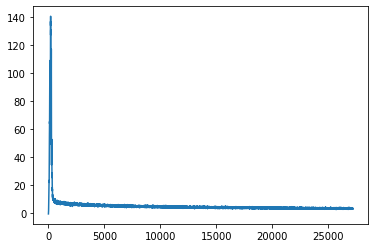

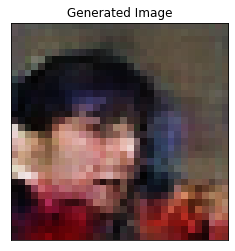

Iteration [25001/100000]......0.192(s) gen: 146.68506 - disc_fake: -146.75701 - disc_real: -143.47406 - disc_real: 3.28295
Iteration [25002/100000]......0.193(s) gen: 147.03044 - disc_fake: -146.89063 - disc_real: -143.36640 - disc_real: 3.52423
Iteration [25003/100000]......0.194(s) gen: 146.93256 - disc_fake: -146.73699 - disc_real: -143.02929 - disc_real: 3.70770
Iteration [25004/100000]......0.196(s) gen: 146.68547 - disc_fake: -146.60313 - disc_real: -143.66626 - disc_real: 2.93687
Iteration [25005/100000]......0.197(s) gen: 147.26004 - disc_fake: -146.94747 - disc_real: -143.81623 - disc_real: 3.13124
Iteration [25006/100000]......0.196(s) gen: 146.71059 - disc_fake: -147.00716 - disc_real: -143.63956 - disc_real: 3.36760
Iteration [25007/100000]......0.196(s) gen: 146.62529 - disc_fake: -147.15497 - disc_real: -143.76196 - disc_real: 3.39301
Iteration [25008/100000]......0.196(s) gen: 146.68658 - disc_fake: -146.63089 - disc_real: -143.32469 - disc_real: 3.30619
Iteration [25009

Iteration [25068/100000]......0.204(s) gen: 146.86780 - disc_fake: -146.35708 - disc_real: -143.47007 - disc_real: 2.88701
Iteration [25069/100000]......0.200(s) gen: 147.33531 - disc_fake: -147.21549 - disc_real: -144.11353 - disc_real: 3.10196
Iteration [25070/100000]......0.202(s) gen: 147.98315 - disc_fake: -147.50669 - disc_real: -144.19945 - disc_real: 3.30724
Iteration [25071/100000]......0.202(s) gen: 148.18607 - disc_fake: -147.94586 - disc_real: -144.72932 - disc_real: 3.21654
Iteration [25072/100000]......0.207(s) gen: 147.68434 - disc_fake: -147.82946 - disc_real: -144.90053 - disc_real: 2.92892
Iteration [25073/100000]......0.213(s) gen: 148.36699 - disc_fake: -147.91309 - disc_real: -144.62472 - disc_real: 3.28837
Iteration [25074/100000]......0.205(s) gen: 147.92038 - disc_fake: -148.10801 - disc_real: -144.95494 - disc_real: 3.15307
Iteration [25075/100000]......0.204(s) gen: 146.81046 - disc_fake: -147.47442 - disc_real: -143.97139 - disc_real: 3.50303
Iteration [25076

Iteration [25135/100000]......0.204(s) gen: 145.90067 - disc_fake: -145.98179 - disc_real: -142.44909 - disc_real: 3.53270
Iteration [25136/100000]......0.204(s) gen: 146.22749 - disc_fake: -145.94922 - disc_real: -142.81594 - disc_real: 3.13328
Iteration [25137/100000]......0.206(s) gen: 146.31081 - disc_fake: -146.14141 - disc_real: -143.25060 - disc_real: 2.89081
Iteration [25138/100000]......0.202(s) gen: 146.09128 - disc_fake: -146.24758 - disc_real: -142.93678 - disc_real: 3.31080
Iteration [25139/100000]......0.203(s) gen: 147.36914 - disc_fake: -146.54299 - disc_real: -143.71335 - disc_real: 2.82964
Iteration [25140/100000]......0.200(s) gen: 149.32066 - disc_fake: -148.10885 - disc_real: -145.13196 - disc_real: 2.97688
Iteration [25141/100000]......0.201(s) gen: 149.05934 - disc_fake: -149.04646 - disc_real: -145.86423 - disc_real: 3.18223
Iteration [25142/100000]......0.198(s) gen: 148.90228 - disc_fake: -149.31124 - disc_real: -145.54985 - disc_real: 3.76139
Iteration [25143

Iteration [25202/100000]......0.206(s) gen: 147.19182 - disc_fake: -146.92410 - disc_real: -143.78881 - disc_real: 3.13529
Iteration [25203/100000]......0.205(s) gen: 147.29544 - disc_fake: -147.47646 - disc_real: -144.35962 - disc_real: 3.11684
Iteration [25204/100000]......0.201(s) gen: 147.56819 - disc_fake: -147.58289 - disc_real: -144.19963 - disc_real: 3.38326
Iteration [25205/100000]......0.199(s) gen: 146.86514 - disc_fake: -147.28732 - disc_real: -144.07117 - disc_real: 3.21615
Iteration [25206/100000]......0.198(s) gen: 146.53848 - disc_fake: -146.87991 - disc_real: -143.59631 - disc_real: 3.28360
Iteration [25207/100000]......0.202(s) gen: 146.38403 - disc_fake: -146.31207 - disc_real: -143.40221 - disc_real: 2.90985
Iteration [25208/100000]......0.202(s) gen: 146.05249 - disc_fake: -146.06492 - disc_real: -142.69580 - disc_real: 3.36912
Iteration [25209/100000]......0.196(s) gen: 146.46170 - disc_fake: -145.96051 - disc_real: -142.37164 - disc_real: 3.58887
Iteration [25210

Iteration [25270/100000]......0.195(s) gen: 147.45589 - disc_fake: -147.27612 - disc_real: -143.84583 - disc_real: 3.43029
Iteration [25271/100000]......0.194(s) gen: 146.77948 - disc_fake: -147.10072 - disc_real: -143.38064 - disc_real: 3.72008
Iteration [25272/100000]......0.196(s) gen: 146.71655 - disc_fake: -146.53406 - disc_real: -143.88313 - disc_real: 2.65093
Iteration [25273/100000]......0.197(s) gen: 147.58344 - disc_fake: -147.14616 - disc_real: -144.18261 - disc_real: 2.96355
Iteration [25274/100000]......0.198(s) gen: 147.82295 - disc_fake: -147.80884 - disc_real: -144.50273 - disc_real: 3.30611
Iteration [25275/100000]......0.198(s) gen: 148.95758 - disc_fake: -148.20685 - disc_real: -145.15122 - disc_real: 3.05563
Iteration [25276/100000]......0.200(s) gen: 148.29001 - disc_fake: -148.42646 - disc_real: -144.91375 - disc_real: 3.51271
Iteration [25277/100000]......0.201(s) gen: 148.75426 - disc_fake: -148.42245 - disc_real: -145.22462 - disc_real: 3.19782
Iteration [25278

Iteration [25337/100000]......0.197(s) gen: 147.97034 - disc_fake: -147.63703 - disc_real: -144.58165 - disc_real: 3.05538
Iteration [25338/100000]......0.200(s) gen: 148.58601 - disc_fake: -148.34115 - disc_real: -144.92802 - disc_real: 3.41314
Iteration [25339/100000]......0.200(s) gen: 148.85670 - disc_fake: -148.17509 - disc_real: -144.86749 - disc_real: 3.30759
Iteration [25340/100000]......0.201(s) gen: 148.77771 - disc_fake: -148.53640 - disc_real: -145.25125 - disc_real: 3.28515
Iteration [25341/100000]......0.207(s) gen: 148.15973 - disc_fake: -148.21900 - disc_real: -144.93480 - disc_real: 3.28419
Iteration [25342/100000]......0.209(s) gen: 148.06818 - disc_fake: -147.91274 - disc_real: -145.07711 - disc_real: 2.83564
Iteration [25343/100000]......0.208(s) gen: 147.84236 - disc_fake: -147.97068 - disc_real: -144.80889 - disc_real: 3.16179
Iteration [25344/100000]......0.207(s) gen: 148.09644 - disc_fake: -147.76985 - disc_real: -144.74194 - disc_real: 3.02791
Iteration [25345

Iteration [25404/100000]......0.194(s) gen: 148.63712 - disc_fake: -148.66110 - disc_real: -145.82043 - disc_real: 2.84066
Iteration [25405/100000]......0.196(s) gen: 148.18552 - disc_fake: -148.62747 - disc_real: -145.25737 - disc_real: 3.37010
Iteration [25406/100000]......0.196(s) gen: 148.21286 - disc_fake: -148.46716 - disc_real: -145.12216 - disc_real: 3.34499
Iteration [25407/100000]......0.194(s) gen: 148.41388 - disc_fake: -148.29261 - disc_real: -145.05081 - disc_real: 3.24180
Iteration [25408/100000]......0.194(s) gen: 148.17928 - disc_fake: -148.15378 - disc_real: -144.85752 - disc_real: 3.29626
Iteration [25409/100000]......0.194(s) gen: 146.79369 - disc_fake: -147.24548 - disc_real: -143.65205 - disc_real: 3.59344
Iteration [25410/100000]......0.194(s) gen: 146.83237 - disc_fake: -146.80242 - disc_real: -143.45045 - disc_real: 3.35197
Iteration [25411/100000]......0.197(s) gen: 147.60178 - disc_fake: -147.08426 - disc_real: -143.95802 - disc_real: 3.12624
Iteration [25412

Iteration [25471/100000]......0.196(s) gen: 149.11142 - disc_fake: -149.24495 - disc_real: -145.98744 - disc_real: 3.25752
Iteration [25472/100000]......0.198(s) gen: 148.77005 - disc_fake: -148.96413 - disc_real: -145.50452 - disc_real: 3.45961
Iteration [25473/100000]......0.198(s) gen: 148.61902 - disc_fake: -148.66053 - disc_real: -145.17747 - disc_real: 3.48306
Iteration [25474/100000]......0.196(s) gen: 148.31227 - disc_fake: -148.00582 - disc_real: -145.08260 - disc_real: 2.92323
Iteration [25475/100000]......0.199(s) gen: 147.09195 - disc_fake: -147.90240 - disc_real: -144.37007 - disc_real: 3.53233
Iteration [25476/100000]......0.200(s) gen: 148.00568 - disc_fake: -147.46086 - disc_real: -144.09493 - disc_real: 3.36594
Iteration [25477/100000]......0.203(s) gen: 147.90637 - disc_fake: -147.57209 - disc_real: -144.85535 - disc_real: 2.71675
Iteration [25478/100000]......0.205(s) gen: 148.84662 - disc_fake: -148.06696 - disc_real: -145.16301 - disc_real: 2.90396
Iteration [25479

Iteration [25539/100000]......0.195(s) gen: 148.16585 - disc_fake: -148.38900 - disc_real: -145.09207 - disc_real: 3.29693
Iteration [25540/100000]......0.194(s) gen: 147.91177 - disc_fake: -148.03059 - disc_real: -144.81303 - disc_real: 3.21756
Iteration [25541/100000]......0.193(s) gen: 147.32700 - disc_fake: -147.29776 - disc_real: -144.00958 - disc_real: 3.28818
Iteration [25542/100000]......0.194(s) gen: 148.12360 - disc_fake: -147.80417 - disc_real: -144.56252 - disc_real: 3.24165
Iteration [25543/100000]......0.195(s) gen: 148.86884 - disc_fake: -148.36150 - disc_real: -145.21387 - disc_real: 3.14763
Iteration [25544/100000]......0.195(s) gen: 149.18802 - disc_fake: -148.72499 - disc_real: -145.23731 - disc_real: 3.48768
Iteration [25545/100000]......0.194(s) gen: 148.35464 - disc_fake: -148.33152 - disc_real: -145.68102 - disc_real: 2.65050
Iteration [25546/100000]......0.197(s) gen: 148.72906 - disc_fake: -148.42401 - disc_real: -145.26376 - disc_real: 3.16025
Iteration [25547

Iteration [25607/100000]......0.200(s) gen: 148.84087 - disc_fake: -149.16972 - disc_real: -145.74984 - disc_real: 3.41988
Iteration [25608/100000]......0.202(s) gen: 148.60410 - disc_fake: -148.69422 - disc_real: -145.40230 - disc_real: 3.29192
Iteration [25609/100000]......0.200(s) gen: 148.80719 - disc_fake: -148.67403 - disc_real: -145.43717 - disc_real: 3.23686
Iteration [25610/100000]......0.201(s) gen: 148.56531 - disc_fake: -148.73829 - disc_real: -145.66245 - disc_real: 3.07584
Iteration [25611/100000]......0.201(s) gen: 149.13359 - disc_fake: -149.04913 - disc_real: -145.91273 - disc_real: 3.13640
Iteration [25612/100000]......0.199(s) gen: 149.15308 - disc_fake: -149.18374 - disc_real: -145.61080 - disc_real: 3.57294
Iteration [25613/100000]......0.200(s) gen: 149.43935 - disc_fake: -149.14008 - disc_real: -145.58394 - disc_real: 3.55615
Iteration [25614/100000]......0.198(s) gen: 149.12204 - disc_fake: -149.13511 - disc_real: -145.89045 - disc_real: 3.24466
Iteration [25615

Iteration [25674/100000]......0.204(s) gen: 148.07268 - disc_fake: -148.73368 - disc_real: -145.10422 - disc_real: 3.62946
Iteration [25675/100000]......0.201(s) gen: 147.94931 - disc_fake: -148.03053 - disc_real: -144.36470 - disc_real: 3.66582
Iteration [25676/100000]......0.199(s) gen: 148.55095 - disc_fake: -148.04721 - disc_real: -144.87923 - disc_real: 3.16798
Iteration [25677/100000]......0.198(s) gen: 149.68794 - disc_fake: -148.89011 - disc_real: -146.07206 - disc_real: 2.81805
Iteration [25678/100000]......0.198(s) gen: 149.91455 - disc_fake: -149.81038 - disc_real: -146.56325 - disc_real: 3.24713
Iteration [25679/100000]......0.201(s) gen: 150.75241 - disc_fake: -150.19669 - disc_real: -147.01008 - disc_real: 3.18661
Iteration [25680/100000]......0.202(s) gen: 151.61496 - disc_fake: -150.75634 - disc_real: -147.66249 - disc_real: 3.09385
Iteration [25681/100000]......0.202(s) gen: 150.20895 - disc_fake: -150.75107 - disc_real: -147.50192 - disc_real: 3.24914
Iteration [25682

Iteration [25741/100000]......0.205(s) gen: 148.94893 - disc_fake: -148.92545 - disc_real: -145.83428 - disc_real: 3.09117
Iteration [25742/100000]......0.204(s) gen: 149.24658 - disc_fake: -148.87393 - disc_real: -145.66398 - disc_real: 3.20994
Iteration [25743/100000]......0.203(s) gen: 149.22635 - disc_fake: -149.33778 - disc_real: -146.02217 - disc_real: 3.31561
Iteration [25744/100000]......0.200(s) gen: 150.17087 - disc_fake: -149.59328 - disc_real: -146.26052 - disc_real: 3.33276
Iteration [25745/100000]......0.200(s) gen: 150.23730 - disc_fake: -149.87154 - disc_real: -146.61324 - disc_real: 3.25830
Iteration [25746/100000]......0.199(s) gen: 150.09792 - disc_fake: -149.95296 - disc_real: -146.84437 - disc_real: 3.10859
Iteration [25747/100000]......0.201(s) gen: 150.62622 - disc_fake: -150.04983 - disc_real: -147.00074 - disc_real: 3.04909
Iteration [25748/100000]......0.202(s) gen: 149.96754 - disc_fake: -150.08673 - disc_real: -146.81942 - disc_real: 3.26731
Iteration [25749

Iteration [25808/100000]......0.200(s) gen: 147.86377 - disc_fake: -147.71190 - disc_real: -144.01132 - disc_real: 3.70059
Iteration [25809/100000]......0.198(s) gen: 148.54663 - disc_fake: -147.88283 - disc_real: -144.94727 - disc_real: 2.93557
Iteration [25810/100000]......0.195(s) gen: 148.94429 - disc_fake: -148.63496 - disc_real: -145.33442 - disc_real: 3.30054
Iteration [25811/100000]......0.196(s) gen: 148.91640 - disc_fake: -148.55094 - disc_real: -145.58298 - disc_real: 2.96796
Iteration [25812/100000]......0.194(s) gen: 149.62500 - disc_fake: -148.94849 - disc_real: -146.12961 - disc_real: 2.81888
Iteration [25813/100000]......0.194(s) gen: 150.33261 - disc_fake: -149.51635 - disc_real: -146.58667 - disc_real: 2.92968
Iteration [25814/100000]......0.194(s) gen: 150.03569 - disc_fake: -150.15712 - disc_real: -146.91161 - disc_real: 3.24552
Iteration [25815/100000]......0.203(s) gen: 150.64587 - disc_fake: -150.06544 - disc_real: -147.11686 - disc_real: 2.94857
Iteration [25816

Iteration [25875/100000]......0.197(s) gen: 148.57042 - disc_fake: -148.68882 - disc_real: -145.42705 - disc_real: 3.26176
Iteration [25876/100000]......0.196(s) gen: 148.19720 - disc_fake: -148.76017 - disc_real: -145.44448 - disc_real: 3.31569
Iteration [25877/100000]......0.196(s) gen: 148.51736 - disc_fake: -148.51313 - disc_real: -145.63335 - disc_real: 2.87978
Iteration [25878/100000]......0.197(s) gen: 148.80318 - disc_fake: -148.86610 - disc_real: -145.65065 - disc_real: 3.21545
Iteration [25879/100000]......0.197(s) gen: 149.04410 - disc_fake: -148.58891 - disc_real: -145.43550 - disc_real: 3.15341
Iteration [25880/100000]......0.195(s) gen: 149.48889 - disc_fake: -148.92793 - disc_real: -145.81844 - disc_real: 3.10948
Iteration [25881/100000]......0.194(s) gen: 149.47226 - disc_fake: -149.27437 - disc_real: -146.27316 - disc_real: 3.00122
Iteration [25882/100000]......0.196(s) gen: 149.98999 - disc_fake: -149.57436 - disc_real: -146.02144 - disc_real: 3.55291
Iteration [25883

Iteration [25942/100000]......0.195(s) gen: 149.21222 - disc_fake: -149.23022 - disc_real: -146.24857 - disc_real: 2.98164
Iteration [25943/100000]......0.195(s) gen: 149.68619 - disc_fake: -149.30569 - disc_real: -146.09028 - disc_real: 3.21541
Iteration [25944/100000]......0.194(s) gen: 149.51790 - disc_fake: -149.56951 - disc_real: -146.40886 - disc_real: 3.16065
Iteration [25945/100000]......0.193(s) gen: 149.91533 - disc_fake: -149.68355 - disc_real: -146.39879 - disc_real: 3.28477
Iteration [25946/100000]......0.194(s) gen: 150.61569 - disc_fake: -149.94439 - disc_real: -147.12397 - disc_real: 2.82042
Iteration [25947/100000]......0.196(s) gen: 149.84369 - disc_fake: -150.29177 - disc_real: -147.10393 - disc_real: 3.18784
Iteration [25948/100000]......0.194(s) gen: 149.32274 - disc_fake: -149.56081 - disc_real: -146.49537 - disc_real: 3.06544
Iteration [25949/100000]......0.196(s) gen: 149.63184 - disc_fake: -149.38708 - disc_real: -146.29204 - disc_real: 3.09504
Iteration [25950

Iteration [26009/100000]......0.202(s) gen: 148.79593 - disc_fake: -148.68897 - disc_real: -145.42547 - disc_real: 3.26350
Iteration [26010/100000]......0.201(s) gen: 148.67413 - disc_fake: -148.53276 - disc_real: -145.63072 - disc_real: 2.90204
Iteration [26011/100000]......0.199(s) gen: 148.84816 - disc_fake: -148.51849 - disc_real: -145.66596 - disc_real: 2.85253
Iteration [26012/100000]......0.197(s) gen: 149.28415 - disc_fake: -149.00570 - disc_real: -146.17105 - disc_real: 2.83465
Iteration [26013/100000]......0.196(s) gen: 149.60956 - disc_fake: -149.34936 - disc_real: -145.96129 - disc_real: 3.38807
Iteration [26014/100000]......0.195(s) gen: 150.13766 - disc_fake: -149.45518 - disc_real: -146.26969 - disc_real: 3.18549
Iteration [26015/100000]......0.194(s) gen: 149.66132 - disc_fake: -149.72658 - disc_real: -146.47399 - disc_real: 3.25259
Iteration [26016/100000]......0.195(s) gen: 149.50061 - disc_fake: -149.81627 - disc_real: -146.37085 - disc_real: 3.44542
Iteration [26017

Iteration [26075/100000]......0.193(s) gen: 149.89764 - disc_fake: -149.76680 - disc_real: -146.54006 - disc_real: 3.22674
Iteration [26076/100000]......0.194(s) gen: 150.43823 - disc_fake: -149.91500 - disc_real: -146.59303 - disc_real: 3.32197
Iteration [26077/100000]......0.196(s) gen: 150.00229 - disc_fake: -150.08676 - disc_real: -147.09848 - disc_real: 2.98828
Iteration [26078/100000]......0.196(s) gen: 149.46727 - disc_fake: -149.56178 - disc_real: -146.24947 - disc_real: 3.31231
Iteration [26079/100000]......0.196(s) gen: 149.09334 - disc_fake: -149.03984 - disc_real: -145.64376 - disc_real: 3.39608
Iteration [26080/100000]......0.197(s) gen: 148.98065 - disc_fake: -149.07626 - disc_real: -146.13288 - disc_real: 2.94338
Iteration [26081/100000]......0.199(s) gen: 148.57272 - disc_fake: -148.87550 - disc_real: -145.69657 - disc_real: 3.17894
Iteration [26082/100000]......0.201(s) gen: 148.83734 - disc_fake: -148.91821 - disc_real: -145.58654 - disc_real: 3.33167
Iteration [26083

Iteration [26142/100000]......0.198(s) gen: 150.60239 - disc_fake: -150.47407 - disc_real: -147.29691 - disc_real: 3.17716
Iteration [26143/100000]......0.197(s) gen: 150.64951 - disc_fake: -150.54531 - disc_real: -147.24700 - disc_real: 3.29831
Iteration [26144/100000]......0.198(s) gen: 149.88055 - disc_fake: -149.97549 - disc_real: -146.89302 - disc_real: 3.08247
Iteration [26145/100000]......0.197(s) gen: 149.65945 - disc_fake: -149.71430 - disc_real: -146.14687 - disc_real: 3.56743
Iteration [26146/100000]......0.197(s) gen: 149.48593 - disc_fake: -149.90012 - disc_real: -146.23412 - disc_real: 3.66600
Iteration [26147/100000]......0.196(s) gen: 149.64279 - disc_fake: -149.62059 - disc_real: -146.38217 - disc_real: 3.23842
Iteration [26148/100000]......0.197(s) gen: 149.06761 - disc_fake: -149.34521 - disc_real: -146.21955 - disc_real: 3.12567
Iteration [26149/100000]......0.200(s) gen: 149.38680 - disc_fake: -148.80628 - disc_real: -145.41486 - disc_real: 3.39142
Iteration [26150

Iteration [26209/100000]......0.200(s) gen: 149.95734 - disc_fake: -149.95573 - disc_real: -146.92610 - disc_real: 3.02963
Iteration [26210/100000]......0.200(s) gen: 150.29166 - disc_fake: -150.00421 - disc_real: -146.62227 - disc_real: 3.38194
Iteration [26211/100000]......0.201(s) gen: 149.77150 - disc_fake: -149.87545 - disc_real: -146.74275 - disc_real: 3.13271
Iteration [26212/100000]......0.200(s) gen: 149.92827 - disc_fake: -149.47697 - disc_real: -146.03481 - disc_real: 3.44215
Iteration [26213/100000]......0.199(s) gen: 149.92841 - disc_fake: -149.76488 - disc_real: -146.55964 - disc_real: 3.20524
Iteration [26214/100000]......0.200(s) gen: 149.50720 - disc_fake: -149.68795 - disc_real: -146.32239 - disc_real: 3.36556
Iteration [26215/100000]......0.200(s) gen: 149.45291 - disc_fake: -149.25792 - disc_real: -146.29589 - disc_real: 2.96203
Iteration [26216/100000]......0.199(s) gen: 149.46851 - disc_fake: -149.60194 - disc_real: -146.36593 - disc_real: 3.23601
Iteration [26217

Iteration [26276/100000]......0.195(s) gen: 150.86508 - disc_fake: -150.98338 - disc_real: -147.83496 - disc_real: 3.14843
Iteration [26277/100000]......0.198(s) gen: 150.35147 - disc_fake: -150.72255 - disc_real: -147.40309 - disc_real: 3.31945
Iteration [26278/100000]......0.197(s) gen: 149.63029 - disc_fake: -150.08705 - disc_real: -146.69235 - disc_real: 3.39470
Iteration [26279/100000]......0.199(s) gen: 149.17178 - disc_fake: -149.68032 - disc_real: -146.42493 - disc_real: 3.25539
Iteration [26280/100000]......0.236(s) gen: 148.80614 - disc_fake: -149.22162 - disc_real: -145.97272 - disc_real: 3.24891
Iteration [26281/100000]......0.197(s) gen: 149.38779 - disc_fake: -149.03602 - disc_real: -146.27281 - disc_real: 2.76321
Iteration [26282/100000]......0.195(s) gen: 149.35815 - disc_fake: -149.21959 - disc_real: -146.16829 - disc_real: 3.05129
Iteration [26283/100000]......0.196(s) gen: 150.47780 - disc_fake: -149.75480 - disc_real: -146.26478 - disc_real: 3.49003
Iteration [26284

Iteration [26343/100000]......0.194(s) gen: 150.66980 - disc_fake: -150.62455 - disc_real: -147.36307 - disc_real: 3.26148
Iteration [26344/100000]......0.195(s) gen: 152.44705 - disc_fake: -151.45729 - disc_real: -148.37870 - disc_real: 3.07859
Iteration [26345/100000]......0.196(s) gen: 152.32843 - disc_fake: -152.60411 - disc_real: -148.97742 - disc_real: 3.62669
Iteration [26346/100000]......0.196(s) gen: 152.77388 - disc_fake: -152.68882 - disc_real: -149.28307 - disc_real: 3.40576
Iteration [26347/100000]......0.196(s) gen: 152.89587 - disc_fake: -153.04169 - disc_real: -149.50501 - disc_real: 3.53668
Iteration [26348/100000]......0.195(s) gen: 150.71614 - disc_fake: -151.79171 - disc_real: -148.70844 - disc_real: 3.08327
Iteration [26349/100000]......0.197(s) gen: 150.21036 - disc_fake: -150.87763 - disc_real: -147.40295 - disc_real: 3.47468
Iteration [26350/100000]......0.197(s) gen: 149.24425 - disc_fake: -150.01438 - disc_real: -146.69659 - disc_real: 3.31779
Iteration [26351

Iteration [26411/100000]......0.195(s) gen: 150.77332 - disc_fake: -149.83152 - disc_real: -147.49857 - disc_real: 2.33295
Iteration [26412/100000]......0.192(s) gen: 151.14401 - disc_fake: -150.80701 - disc_real: -147.89962 - disc_real: 2.90739
Iteration [26413/100000]......0.192(s) gen: 152.11026 - disc_fake: -151.44387 - disc_real: -148.38065 - disc_real: 3.06323
Iteration [26414/100000]......0.193(s) gen: 152.46466 - disc_fake: -152.36785 - disc_real: -149.23383 - disc_real: 3.13402
Iteration [26415/100000]......0.194(s) gen: 151.89703 - disc_fake: -152.29005 - disc_real: -148.88750 - disc_real: 3.40255
Iteration [26416/100000]......0.195(s) gen: 151.86702 - disc_fake: -151.86035 - disc_real: -148.50473 - disc_real: 3.35563
Iteration [26417/100000]......0.202(s) gen: 151.44142 - disc_fake: -151.57291 - disc_real: -148.23623 - disc_real: 3.33668
Iteration [26418/100000]......0.201(s) gen: 150.60706 - disc_fake: -150.78988 - disc_real: -147.37741 - disc_real: 3.41247
Iteration [26419

Iteration [26478/100000]......0.197(s) gen: 152.19083 - disc_fake: -151.40677 - disc_real: -148.24968 - disc_real: 3.15710
Iteration [26479/100000]......0.197(s) gen: 152.84448 - disc_fake: -152.22967 - disc_real: -148.91323 - disc_real: 3.31644
Iteration [26480/100000]......0.195(s) gen: 152.73935 - disc_fake: -152.71836 - disc_real: -149.55017 - disc_real: 3.16819
Iteration [26481/100000]......0.194(s) gen: 152.63841 - disc_fake: -152.81258 - disc_real: -149.59988 - disc_real: 3.21270
Iteration [26482/100000]......0.196(s) gen: 151.85092 - disc_fake: -152.39934 - disc_real: -149.40154 - disc_real: 2.99780
Iteration [26483/100000]......0.196(s) gen: 151.74753 - disc_fake: -151.61263 - disc_real: -148.68935 - disc_real: 2.92327
Iteration [26484/100000]......0.195(s) gen: 151.07735 - disc_fake: -151.30351 - disc_real: -148.23532 - disc_real: 3.06819
Iteration [26485/100000]......0.196(s) gen: 150.94760 - disc_fake: -150.83959 - disc_real: -147.79903 - disc_real: 3.04056
Iteration [26486

Iteration [26545/100000]......0.195(s) gen: 150.69516 - disc_fake: -150.72644 - disc_real: -147.50688 - disc_real: 3.21955
Iteration [26546/100000]......0.196(s) gen: 149.86473 - disc_fake: -150.24957 - disc_real: -146.59634 - disc_real: 3.65323
Iteration [26547/100000]......0.196(s) gen: 149.76367 - disc_fake: -149.60214 - disc_real: -146.25058 - disc_real: 3.35156
Iteration [26548/100000]......0.196(s) gen: 150.39136 - disc_fake: -149.90576 - disc_real: -146.80563 - disc_real: 3.10012
Iteration [26549/100000]......0.195(s) gen: 150.62282 - disc_fake: -150.56053 - disc_real: -147.30696 - disc_real: 3.25357
Iteration [26550/100000]......0.193(s) gen: 151.12326 - disc_fake: -150.43522 - disc_real: -147.45660 - disc_real: 2.97862
Iteration [26551/100000]......0.196(s) gen: 151.63297 - disc_fake: -150.93621 - disc_real: -147.97898 - disc_real: 2.95722
Iteration [26552/100000]......0.195(s) gen: 151.16800 - disc_fake: -151.31444 - disc_real: -148.33799 - disc_real: 2.97645
Iteration [26553

Iteration [26611/100000]......0.199(s) gen: 151.33081 - disc_fake: -151.39837 - disc_real: -147.84386 - disc_real: 3.55450
Iteration [26612/100000]......0.202(s) gen: 151.98245 - disc_fake: -151.59133 - disc_real: -148.59010 - disc_real: 3.00123
Iteration [26613/100000]......0.205(s) gen: 151.11749 - disc_fake: -151.61367 - disc_real: -148.22059 - disc_real: 3.39308
Iteration [26614/100000]......0.204(s) gen: 151.17395 - disc_fake: -151.25243 - disc_real: -148.57135 - disc_real: 2.68108
Iteration [26615/100000]......0.203(s) gen: 151.08749 - disc_fake: -151.25197 - disc_real: -148.09671 - disc_real: 3.15526
Iteration [26616/100000]......0.202(s) gen: 151.52769 - disc_fake: -151.54520 - disc_real: -148.04786 - disc_real: 3.49734
Iteration [26617/100000]......0.203(s) gen: 152.18527 - disc_fake: -152.20104 - disc_real: -148.68492 - disc_real: 3.51612
Iteration [26618/100000]......0.199(s) gen: 151.75537 - disc_fake: -151.82597 - disc_real: -148.75794 - disc_real: 3.06803
Iteration [26619

Iteration [26679/100000]......0.197(s) gen: 150.82452 - disc_fake: -150.94685 - disc_real: -147.94890 - disc_real: 2.99795
Iteration [26680/100000]......0.200(s) gen: 151.27306 - disc_fake: -151.05049 - disc_real: -148.13901 - disc_real: 2.91148
Iteration [26681/100000]......0.202(s) gen: 151.56627 - disc_fake: -151.20987 - disc_real: -148.03221 - disc_real: 3.17765
Iteration [26682/100000]......0.200(s) gen: 151.21785 - disc_fake: -151.19055 - disc_real: -148.19442 - disc_real: 2.99614
Iteration [26683/100000]......0.201(s) gen: 151.55499 - disc_fake: -151.34679 - disc_real: -148.44930 - disc_real: 2.89749
Iteration [26684/100000]......0.200(s) gen: 152.11537 - disc_fake: -151.69367 - disc_real: -148.65261 - disc_real: 3.04106
Iteration [26685/100000]......0.199(s) gen: 151.28494 - disc_fake: -151.74684 - disc_real: -148.51644 - disc_real: 3.23040
Iteration [26686/100000]......0.198(s) gen: 151.02319 - disc_fake: -151.06028 - disc_real: -147.98968 - disc_real: 3.07060
Iteration [26687

Iteration [26745/100000]......0.199(s) gen: 151.19656 - disc_fake: -150.87402 - disc_real: -147.55045 - disc_real: 3.32357
Iteration [26746/100000]......0.197(s) gen: 152.20103 - disc_fake: -151.67014 - disc_real: -148.48352 - disc_real: 3.18662
Iteration [26747/100000]......0.200(s) gen: 152.26807 - disc_fake: -152.01738 - disc_real: -149.12104 - disc_real: 2.89633
Iteration [26748/100000]......0.200(s) gen: 152.13602 - disc_fake: -151.94838 - disc_real: -149.20406 - disc_real: 2.74432
Iteration [26749/100000]......0.200(s) gen: 152.03288 - disc_fake: -152.00679 - disc_real: -148.67514 - disc_real: 3.33165
Iteration [26750/100000]......0.201(s) gen: 152.29544 - disc_fake: -152.09212 - disc_real: -149.03306 - disc_real: 3.05906
Iteration [26751/100000]......0.204(s) gen: 152.07892 - disc_fake: -152.36455 - disc_real: -148.94048 - disc_real: 3.42407
Iteration [26752/100000]......0.202(s) gen: 152.61954 - disc_fake: -152.23030 - disc_real: -149.30674 - disc_real: 2.92356
Iteration [26753

Iteration [26812/100000]......0.202(s) gen: 151.50984 - disc_fake: -151.91367 - disc_real: -148.30532 - disc_real: 3.60835
Iteration [26813/100000]......0.204(s) gen: 151.64236 - disc_fake: -151.34876 - disc_real: -147.99341 - disc_real: 3.35535
Iteration [26814/100000]......0.203(s) gen: 151.24651 - disc_fake: -151.48025 - disc_real: -147.97621 - disc_real: 3.50404
Iteration [26815/100000]......0.203(s) gen: 151.76868 - disc_fake: -151.21860 - disc_real: -148.06234 - disc_real: 3.15626
Iteration [26816/100000]......0.203(s) gen: 152.72792 - disc_fake: -151.99954 - disc_real: -149.27339 - disc_real: 2.72615
Iteration [26817/100000]......0.213(s) gen: 153.26208 - disc_fake: -152.65416 - disc_real: -149.49671 - disc_real: 3.15745
Iteration [26818/100000]......0.200(s) gen: 153.17590 - disc_fake: -153.21089 - disc_real: -149.84870 - disc_real: 3.36219
Iteration [26819/100000]......0.201(s) gen: 153.15793 - disc_fake: -153.15891 - disc_real: -150.18832 - disc_real: 2.97058
Iteration [26820

Iteration [26880/100000]......0.194(s) gen: 153.82925 - disc_fake: -153.29917 - disc_real: -149.83409 - disc_real: 3.46508
Iteration [26881/100000]......0.196(s) gen: 153.70627 - disc_fake: -153.74864 - disc_real: -150.48595 - disc_real: 3.26269
Iteration [26882/100000]......0.198(s) gen: 153.83209 - disc_fake: -153.53980 - disc_real: -150.32370 - disc_real: 3.21610
Iteration [26883/100000]......0.198(s) gen: 152.72646 - disc_fake: -153.26012 - disc_real: -149.91766 - disc_real: 3.34246
Iteration [26884/100000]......0.197(s) gen: 152.48624 - disc_fake: -152.38683 - disc_real: -149.37558 - disc_real: 3.01126
Iteration [26885/100000]......0.201(s) gen: 152.21912 - disc_fake: -152.56322 - disc_real: -149.23337 - disc_real: 3.32985
Iteration [26886/100000]......0.200(s) gen: 152.07785 - disc_fake: -152.14991 - disc_real: -148.78902 - disc_real: 3.36089
Iteration [26887/100000]......0.202(s) gen: 152.21112 - disc_fake: -151.96461 - disc_real: -148.71062 - disc_real: 3.25398
Iteration [26888

Iteration [26947/100000]......0.203(s) gen: 152.36179 - disc_fake: -152.35543 - disc_real: -149.31064 - disc_real: 3.04479
Iteration [26948/100000]......0.199(s) gen: 152.22067 - disc_fake: -152.22320 - disc_real: -149.39069 - disc_real: 2.83252
Iteration [26949/100000]......0.195(s) gen: 152.33862 - disc_fake: -152.14548 - disc_real: -149.13585 - disc_real: 3.00963
Iteration [26950/100000]......0.198(s) gen: 152.13776 - disc_fake: -152.31444 - disc_real: -149.48746 - disc_real: 2.82698
Iteration [26951/100000]......0.213(s) gen: 152.69034 - disc_fake: -152.36439 - disc_real: -149.42040 - disc_real: 2.94399
Iteration [26952/100000]......0.207(s) gen: 152.15991 - disc_fake: -152.49005 - disc_real: -148.94467 - disc_real: 3.54538
Iteration [26953/100000]......0.209(s) gen: 151.59064 - disc_fake: -151.58755 - disc_real: -148.38677 - disc_real: 3.20078
Iteration [26954/100000]......0.209(s) gen: 151.32596 - disc_fake: -151.31328 - disc_real: -148.19538 - disc_real: 3.11791
Iteration [26955

Iteration [27014/100000]......0.196(s) gen: 152.34216 - disc_fake: -152.60959 - disc_real: -149.28993 - disc_real: 3.31967
Iteration [27015/100000]......0.196(s) gen: 153.40625 - disc_fake: -152.80943 - disc_real: -149.99404 - disc_real: 2.81538
Iteration [27016/100000]......0.199(s) gen: 153.10260 - disc_fake: -153.22440 - disc_real: -150.27413 - disc_real: 2.95027
Iteration [27017/100000]......0.206(s) gen: 152.63605 - disc_fake: -152.84420 - disc_real: -149.60750 - disc_real: 3.23670
Iteration [27018/100000]......0.203(s) gen: 152.03082 - disc_fake: -152.34273 - disc_real: -148.77672 - disc_real: 3.56601
Iteration [27019/100000]......0.203(s) gen: 152.06491 - disc_fake: -151.49536 - disc_real: -148.56522 - disc_real: 2.93015
Iteration [27020/100000]......0.199(s) gen: 152.53809 - disc_fake: -151.84794 - disc_real: -149.11208 - disc_real: 2.73586
Iteration [27021/100000]......0.199(s) gen: 152.67065 - disc_fake: -152.72659 - disc_real: -149.64097 - disc_real: 3.08563
Iteration [27022

Iteration [27081/100000]......0.204(s) gen: 153.92789 - disc_fake: -153.73623 - disc_real: -150.60398 - disc_real: 3.13224
Iteration [27082/100000]......0.207(s) gen: 154.34758 - disc_fake: -153.95015 - disc_real: -150.91442 - disc_real: 3.03572
Iteration [27083/100000]......0.211(s) gen: 154.11034 - disc_fake: -154.04763 - disc_real: -151.04845 - disc_real: 2.99918
Iteration [27084/100000]......0.212(s) gen: 153.75003 - disc_fake: -154.19696 - disc_real: -150.94203 - disc_real: 3.25494
Iteration [27085/100000]......0.210(s) gen: 153.65689 - disc_fake: -153.70849 - disc_real: -150.55997 - disc_real: 3.14852
Iteration [27086/100000]......0.207(s) gen: 153.10744 - disc_fake: -153.21560 - disc_real: -149.94892 - disc_real: 3.26668
Iteration [27087/100000]......0.206(s) gen: 152.44641 - disc_fake: -152.86066 - disc_real: -149.71497 - disc_real: 3.14569
Iteration [27088/100000]......0.201(s) gen: 152.31026 - disc_fake: -152.33918 - disc_real: -149.23832 - disc_real: 3.10087
Iteration [27089

Iteration [27148/100000]......0.205(s) gen: 153.04602 - disc_fake: -153.07802 - disc_real: -149.95841 - disc_real: 3.11961
Iteration [27149/100000]......0.205(s) gen: 153.46738 - disc_fake: -153.01572 - disc_real: -149.89235 - disc_real: 3.12337
Iteration [27150/100000]......0.203(s) gen: 153.46341 - disc_fake: -153.55254 - disc_real: -150.20048 - disc_real: 3.35207
Iteration [27151/100000]......0.201(s) gen: 153.61722 - disc_fake: -153.29373 - disc_real: -150.08854 - disc_real: 3.20519
Iteration [27152/100000]......0.198(s) gen: 153.67534 - disc_fake: -153.31808 - disc_real: -150.07168 - disc_real: 3.24640
Iteration [27153/100000]......0.197(s) gen: 153.92850 - disc_fake: -153.78018 - disc_real: -150.34581 - disc_real: 3.43436
Iteration [27154/100000]......0.196(s) gen: 152.49884 - disc_fake: -153.23835 - disc_real: -149.76682 - disc_real: 3.47153
Iteration [27155/100000]......0.199(s) gen: 151.86340 - disc_fake: -152.25180 - disc_real: -149.23027 - disc_real: 3.02153
Iteration [27156

Iteration [27215/100000]......0.199(s) gen: 152.63840 - disc_fake: -152.55198 - disc_real: -149.27924 - disc_real: 3.27274
Iteration [27216/100000]......0.198(s) gen: 153.06018 - disc_fake: -152.66854 - disc_real: -149.46312 - disc_real: 3.20542
Iteration [27217/100000]......0.200(s) gen: 152.73102 - disc_fake: -152.70577 - disc_real: -149.75385 - disc_real: 2.95191
Iteration [27218/100000]......0.197(s) gen: 153.59346 - disc_fake: -152.74763 - disc_real: -149.90283 - disc_real: 2.84480
Iteration [27219/100000]......0.199(s) gen: 152.93933 - disc_fake: -153.21117 - disc_real: -149.98244 - disc_real: 3.22873
Iteration [27220/100000]......0.198(s) gen: 153.00851 - disc_fake: -152.96404 - disc_real: -149.38845 - disc_real: 3.57560
Iteration [27221/100000]......0.200(s) gen: 153.06154 - disc_fake: -152.48042 - disc_real: -148.91827 - disc_real: 3.56215
Iteration [27222/100000]......0.201(s) gen: 152.50171 - disc_fake: -152.68922 - disc_real: -149.42922 - disc_real: 3.26000
Iteration [27223

Iteration [27282/100000]......0.200(s) gen: 152.32426 - disc_fake: -151.98673 - disc_real: -148.81523 - disc_real: 3.17151
Iteration [27283/100000]......0.200(s) gen: 152.46735 - disc_fake: -152.34707 - disc_real: -149.26850 - disc_real: 3.07856
Iteration [27284/100000]......0.200(s) gen: 152.53958 - disc_fake: -152.41178 - disc_real: -149.52713 - disc_real: 2.88465
Iteration [27285/100000]......0.201(s) gen: 153.87381 - disc_fake: -152.91190 - disc_real: -149.61800 - disc_real: 3.29390
Iteration [27286/100000]......0.203(s) gen: 154.06294 - disc_fake: -153.67309 - disc_real: -150.47747 - disc_real: 3.19562
Iteration [27287/100000]......0.202(s) gen: 153.59694 - disc_fake: -153.66888 - disc_real: -150.22522 - disc_real: 3.44367
Iteration [27288/100000]......0.202(s) gen: 153.39703 - disc_fake: -153.63926 - disc_real: -149.92323 - disc_real: 3.71603
Iteration [27289/100000]......0.200(s) gen: 152.78970 - disc_fake: -152.91357 - disc_real: -149.67485 - disc_real: 3.23871
Iteration [27290

Iteration [27349/100000]......0.200(s) gen: 151.15872 - disc_fake: -151.35567 - disc_real: -147.84471 - disc_real: 3.51096
Iteration [27350/100000]......0.202(s) gen: 151.45160 - disc_fake: -151.60656 - disc_real: -148.18861 - disc_real: 3.41795
Iteration [27351/100000]......0.197(s) gen: 152.23914 - disc_fake: -151.67956 - disc_real: -148.12555 - disc_real: 3.55401
Iteration [27352/100000]......0.199(s) gen: 151.99463 - disc_fake: -152.35214 - disc_real: -148.81249 - disc_real: 3.53965
Iteration [27353/100000]......0.200(s) gen: 152.81747 - disc_fake: -152.32750 - disc_real: -148.78439 - disc_real: 3.54312
Iteration [27354/100000]......0.200(s) gen: 151.91087 - disc_fake: -152.05230 - disc_real: -149.14601 - disc_real: 2.90629
Iteration [27355/100000]......0.199(s) gen: 152.37622 - disc_fake: -152.39475 - disc_real: -149.58994 - disc_real: 2.80481
Iteration [27356/100000]......0.196(s) gen: 153.91800 - disc_fake: -152.99931 - disc_real: -149.86583 - disc_real: 3.13348
Iteration [27357

Iteration [27416/100000]......0.198(s) gen: 153.22418 - disc_fake: -152.93706 - disc_real: -149.95409 - disc_real: 2.98297
Iteration [27417/100000]......0.200(s) gen: 152.48120 - disc_fake: -152.71862 - disc_real: -149.63650 - disc_real: 3.08213
Iteration [27418/100000]......0.200(s) gen: 152.86519 - disc_fake: -152.75534 - disc_real: -149.55741 - disc_real: 3.19793
Iteration [27419/100000]......0.202(s) gen: 152.98666 - disc_fake: -152.86815 - disc_real: -149.45696 - disc_real: 3.41119
Iteration [27420/100000]......0.201(s) gen: 153.00339 - disc_fake: -152.91649 - disc_real: -149.79599 - disc_real: 3.12050
Iteration [27421/100000]......0.201(s) gen: 153.51221 - disc_fake: -153.17016 - disc_real: -149.93340 - disc_real: 3.23677
Iteration [27422/100000]......0.203(s) gen: 153.77859 - disc_fake: -153.50670 - disc_real: -150.14502 - disc_real: 3.36169
Iteration [27423/100000]......0.206(s) gen: 153.87146 - disc_fake: -153.27439 - disc_real: -150.45236 - disc_real: 2.82203
Iteration [27424

Iteration [27483/100000]......0.201(s) gen: 152.64847 - disc_fake: -153.47523 - disc_real: -150.12278 - disc_real: 3.35245
Iteration [27484/100000]......0.203(s) gen: 153.37154 - disc_fake: -152.96923 - disc_real: -149.80338 - disc_real: 3.16585
Iteration [27485/100000]......0.197(s) gen: 154.10098 - disc_fake: -153.26584 - disc_real: -150.79336 - disc_real: 2.47248
Iteration [27486/100000]......0.202(s) gen: 154.11060 - disc_fake: -154.07567 - disc_real: -150.77499 - disc_real: 3.30067
Iteration [27487/100000]......0.199(s) gen: 154.14243 - disc_fake: -154.07747 - disc_real: -150.82908 - disc_real: 3.24840
Iteration [27488/100000]......0.197(s) gen: 153.09470 - disc_fake: -153.64415 - disc_real: -150.60947 - disc_real: 3.03468
Iteration [27489/100000]......0.200(s) gen: 153.27011 - disc_fake: -153.13422 - disc_real: -149.78083 - disc_real: 3.35339
Iteration [27490/100000]......0.200(s) gen: 153.25090 - disc_fake: -152.88366 - disc_real: -150.06126 - disc_real: 2.82240
Iteration [27491

Iteration [27550/100000]......0.201(s) gen: 153.59256 - disc_fake: -153.50413 - disc_real: -150.33046 - disc_real: 3.17367
Iteration [27551/100000]......0.200(s) gen: 153.15945 - disc_fake: -153.37708 - disc_real: -150.08467 - disc_real: 3.29241
Iteration [27552/100000]......0.204(s) gen: 153.32275 - disc_fake: -152.84770 - disc_real: -149.84630 - disc_real: 3.00140
Iteration [27553/100000]......0.205(s) gen: 153.65894 - disc_fake: -153.03962 - disc_real: -149.92244 - disc_real: 3.11718
Iteration [27554/100000]......0.210(s) gen: 153.50021 - disc_fake: -153.51254 - disc_real: -150.71179 - disc_real: 2.80075
Iteration [27555/100000]......0.205(s) gen: 153.60107 - disc_fake: -153.42155 - disc_real: -150.18174 - disc_real: 3.23981
Iteration [27556/100000]......0.201(s) gen: 153.54050 - disc_fake: -153.27775 - disc_real: -150.42368 - disc_real: 2.85406
Iteration [27557/100000]......0.202(s) gen: 152.78163 - disc_fake: -153.59692 - disc_real: -150.02758 - disc_real: 3.56934
Iteration [27558

Iteration [27617/100000]......0.201(s) gen: 153.51894 - disc_fake: -153.79273 - disc_real: -150.66415 - disc_real: 3.12858
Iteration [27618/100000]......0.200(s) gen: 153.34692 - disc_fake: -153.43326 - disc_real: -150.02926 - disc_real: 3.40399
Iteration [27619/100000]......0.201(s) gen: 152.81876 - disc_fake: -153.18941 - disc_real: -149.60604 - disc_real: 3.58338
Iteration [27620/100000]......0.201(s) gen: 153.27946 - disc_fake: -152.92692 - disc_real: -149.98380 - disc_real: 2.94312
Iteration [27621/100000]......0.198(s) gen: 153.22293 - disc_fake: -152.79126 - disc_real: -149.92367 - disc_real: 2.86759
Iteration [27622/100000]......0.200(s) gen: 153.57681 - disc_fake: -153.06917 - disc_real: -150.35512 - disc_real: 2.71404
Iteration [27623/100000]......0.201(s) gen: 154.15410 - disc_fake: -153.72401 - disc_real: -150.46190 - disc_real: 3.26212
Iteration [27624/100000]......0.198(s) gen: 154.35153 - disc_fake: -154.24659 - disc_real: -150.89323 - disc_real: 3.35337
Iteration [27625

Iteration [27684/100000]......0.204(s) gen: 153.63698 - disc_fake: -154.07495 - disc_real: -150.54206 - disc_real: 3.53288
Iteration [27685/100000]......0.204(s) gen: 154.19797 - disc_fake: -153.95917 - disc_real: -150.58361 - disc_real: 3.37556
Iteration [27686/100000]......0.202(s) gen: 155.27448 - disc_fake: -154.56814 - disc_real: -151.38675 - disc_real: 3.18139
Iteration [27687/100000]......0.201(s) gen: 155.69296 - disc_fake: -155.47909 - disc_real: -152.05268 - disc_real: 3.42641
Iteration [27688/100000]......0.199(s) gen: 156.11865 - disc_fake: -155.63134 - disc_real: -152.59436 - disc_real: 3.03697
Iteration [27689/100000]......0.197(s) gen: 155.41591 - disc_fake: -155.77359 - disc_real: -152.35278 - disc_real: 3.42081
Iteration [27690/100000]......0.198(s) gen: 155.03748 - disc_fake: -154.94483 - disc_real: -152.22115 - disc_real: 2.72368
Iteration [27691/100000]......0.197(s) gen: 154.74544 - disc_fake: -154.72416 - disc_real: -151.69824 - disc_real: 3.02592
Iteration [27692

Iteration [27751/100000]......0.195(s) gen: 154.48764 - disc_fake: -154.72864 - disc_real: -151.35094 - disc_real: 3.37770
Iteration [27752/100000]......0.197(s) gen: 155.28711 - disc_fake: -154.79513 - disc_real: -151.63211 - disc_real: 3.16302
Iteration [27753/100000]......0.199(s) gen: 155.38013 - disc_fake: -154.77548 - disc_real: -151.49921 - disc_real: 3.27628
Iteration [27754/100000]......0.198(s) gen: 154.78488 - disc_fake: -155.23760 - disc_real: -151.72786 - disc_real: 3.50974
Iteration [27755/100000]......0.200(s) gen: 154.56654 - disc_fake: -154.28912 - disc_real: -151.35427 - disc_real: 2.93484
Iteration [27756/100000]......0.200(s) gen: 154.65961 - disc_fake: -154.36624 - disc_real: -151.34470 - disc_real: 3.02154
Iteration [27757/100000]......0.199(s) gen: 155.04868 - disc_fake: -154.62176 - disc_real: -151.71075 - disc_real: 2.91101
Iteration [27758/100000]......0.201(s) gen: 154.73743 - disc_fake: -154.76158 - disc_real: -151.63607 - disc_real: 3.12550
Iteration [27759

Iteration [27818/100000]......0.198(s) gen: 154.51018 - disc_fake: -154.30247 - disc_real: -151.15861 - disc_real: 3.14386
Iteration [27819/100000]......0.199(s) gen: 154.37172 - disc_fake: -154.46115 - disc_real: -151.20359 - disc_real: 3.25757
Iteration [27820/100000]......0.196(s) gen: 154.77902 - disc_fake: -154.30089 - disc_real: -151.15955 - disc_real: 3.14134
Iteration [27821/100000]......0.198(s) gen: 155.36313 - disc_fake: -155.11020 - disc_real: -151.75811 - disc_real: 3.35209
Iteration [27822/100000]......0.196(s) gen: 154.94214 - disc_fake: -155.16651 - disc_real: -151.81698 - disc_real: 3.34954
Iteration [27823/100000]......0.198(s) gen: 154.84875 - disc_fake: -155.00751 - disc_real: -151.96704 - disc_real: 3.04047
Iteration [27824/100000]......0.197(s) gen: 154.93890 - disc_fake: -154.64226 - disc_real: -151.53853 - disc_real: 3.10373
Iteration [27825/100000]......0.197(s) gen: 154.06918 - disc_fake: -154.15735 - disc_real: -151.03741 - disc_real: 3.11994
Iteration [27826

Iteration [27885/100000]......0.200(s) gen: 155.31789 - disc_fake: -154.74734 - disc_real: -151.62797 - disc_real: 3.11937
Iteration [27886/100000]......0.200(s) gen: 155.72809 - disc_fake: -155.26699 - disc_real: -152.23222 - disc_real: 3.03477
Iteration [27887/100000]......0.201(s) gen: 156.80713 - disc_fake: -156.01888 - disc_real: -152.74481 - disc_real: 3.27407
Iteration [27888/100000]......0.199(s) gen: 156.62483 - disc_fake: -156.28380 - disc_real: -153.26965 - disc_real: 3.01414
Iteration [27889/100000]......0.201(s) gen: 155.84438 - disc_fake: -156.19225 - disc_real: -152.84037 - disc_real: 3.35187
Iteration [27890/100000]......0.198(s) gen: 155.30383 - disc_fake: -155.40285 - disc_real: -152.57112 - disc_real: 2.83173
Iteration [27891/100000]......0.197(s) gen: 155.12671 - disc_fake: -154.80883 - disc_real: -151.50972 - disc_real: 3.29910
Iteration [27892/100000]......0.195(s) gen: 155.36105 - disc_fake: -154.98919 - disc_real: -151.89632 - disc_real: 3.09287
Iteration [27893

Iteration [27952/100000]......0.199(s) gen: 155.62924 - disc_fake: -155.26989 - disc_real: -151.88112 - disc_real: 3.38877
Iteration [27953/100000]......0.201(s) gen: 154.93469 - disc_fake: -155.07906 - disc_real: -151.69801 - disc_real: 3.38105
Iteration [27954/100000]......0.199(s) gen: 154.99548 - disc_fake: -154.98637 - disc_real: -151.73871 - disc_real: 3.24767
Iteration [27955/100000]......0.200(s) gen: 155.49600 - disc_fake: -155.36425 - disc_real: -152.34808 - disc_real: 3.01617
Iteration [27956/100000]......0.198(s) gen: 154.86456 - disc_fake: -155.20430 - disc_real: -152.15448 - disc_real: 3.04982
Iteration [27957/100000]......0.198(s) gen: 154.84076 - disc_fake: -155.00175 - disc_real: -151.71573 - disc_real: 3.28602
Iteration [27958/100000]......0.199(s) gen: 155.14868 - disc_fake: -154.96507 - disc_real: -151.65658 - disc_real: 3.30850
Iteration [27959/100000]......0.200(s) gen: 156.12936 - disc_fake: -155.49787 - disc_real: -152.70447 - disc_real: 2.79339
Iteration [27960

Iteration [28020/100000]......0.195(s) gen: 155.35364 - disc_fake: -154.81908 - disc_real: -151.68589 - disc_real: 3.13319
Iteration [28021/100000]......0.197(s) gen: 155.55740 - disc_fake: -154.95482 - disc_real: -151.96004 - disc_real: 2.99478
Iteration [28022/100000]......0.200(s) gen: 155.66403 - disc_fake: -155.45208 - disc_real: -152.06742 - disc_real: 3.38467
Iteration [28023/100000]......0.204(s) gen: 155.75623 - disc_fake: -155.74836 - disc_real: -152.67487 - disc_real: 3.07350
Iteration [28024/100000]......0.201(s) gen: 156.70226 - disc_fake: -155.86897 - disc_real: -152.86234 - disc_real: 3.00663
Iteration [28025/100000]......0.198(s) gen: 156.27769 - disc_fake: -156.19962 - disc_real: -152.96126 - disc_real: 3.23836
Iteration [28026/100000]......0.223(s) gen: 156.26259 - disc_fake: -156.23885 - disc_real: -153.05483 - disc_real: 3.18401
Iteration [28027/100000]......0.203(s) gen: 156.24336 - disc_fake: -156.18293 - disc_real: -153.24888 - disc_real: 2.93405
Iteration [28028

Iteration [28087/100000]......0.205(s) gen: 154.03064 - disc_fake: -153.94202 - disc_real: -150.79238 - disc_real: 3.14964
Iteration [28088/100000]......0.209(s) gen: 154.45831 - disc_fake: -154.45524 - disc_real: -151.48058 - disc_real: 2.97466
Iteration [28089/100000]......0.207(s) gen: 154.61389 - disc_fake: -154.49657 - disc_real: -150.99893 - disc_real: 3.49764
Iteration [28090/100000]......0.207(s) gen: 154.96512 - disc_fake: -154.53665 - disc_real: -151.54778 - disc_real: 2.98886
Iteration [28091/100000]......0.206(s) gen: 155.46771 - disc_fake: -155.08335 - disc_real: -152.00395 - disc_real: 3.07940
Iteration [28092/100000]......0.203(s) gen: 155.90901 - disc_fake: -155.38816 - disc_real: -152.27066 - disc_real: 3.11749
Iteration [28093/100000]......0.201(s) gen: 156.31174 - disc_fake: -155.94531 - disc_real: -152.54998 - disc_real: 3.39533
Iteration [28094/100000]......0.201(s) gen: 157.07883 - disc_fake: -156.44479 - disc_real: -153.23968 - disc_real: 3.20511
Iteration [28095

Iteration [28154/100000]......0.214(s) gen: 156.14427 - disc_fake: -156.46772 - disc_real: -153.24639 - disc_real: 3.22133
Iteration [28155/100000]......0.206(s) gen: 156.10089 - disc_fake: -156.02276 - disc_real: -152.91547 - disc_real: 3.10729
Iteration [28156/100000]......0.205(s) gen: 155.41675 - disc_fake: -156.13932 - disc_real: -152.54235 - disc_real: 3.59698
Iteration [28157/100000]......0.204(s) gen: 154.74033 - disc_fake: -155.13651 - disc_real: -152.03119 - disc_real: 3.10532
Iteration [28158/100000]......0.204(s) gen: 155.22751 - disc_fake: -155.34301 - disc_real: -151.71497 - disc_real: 3.62805
Iteration [28159/100000]......0.202(s) gen: 156.03864 - disc_fake: -155.46210 - disc_real: -151.88272 - disc_real: 3.57938
Iteration [28160/100000]......0.199(s) gen: 156.21539 - disc_fake: -155.49819 - disc_real: -152.44455 - disc_real: 3.05364
Iteration [28161/100000]......0.200(s) gen: 155.72565 - disc_fake: -155.83578 - disc_real: -152.20411 - disc_real: 3.63168
Iteration [28162

Iteration [28222/100000]......0.199(s) gen: 154.84198 - disc_fake: -155.29580 - disc_real: -152.05647 - disc_real: 3.23933
Iteration [28223/100000]......0.199(s) gen: 154.68988 - disc_fake: -154.82246 - disc_real: -152.20975 - disc_real: 2.61271
Iteration [28224/100000]......0.200(s) gen: 154.54387 - disc_fake: -154.44398 - disc_real: -151.35859 - disc_real: 3.08539
Iteration [28225/100000]......0.200(s) gen: 154.39383 - disc_fake: -154.50161 - disc_real: -151.33703 - disc_real: 3.16458
Iteration [28226/100000]......0.198(s) gen: 154.53326 - disc_fake: -154.44626 - disc_real: -150.79187 - disc_real: 3.65439
Iteration [28227/100000]......0.201(s) gen: 155.09573 - disc_fake: -154.35645 - disc_real: -151.19468 - disc_real: 3.16177
Iteration [28228/100000]......0.197(s) gen: 155.63129 - disc_fake: -154.99727 - disc_real: -151.58838 - disc_real: 3.40889
Iteration [28229/100000]......0.195(s) gen: 155.62122 - disc_fake: -155.34108 - disc_real: -152.40813 - disc_real: 2.93295
Iteration [28230

Iteration [28290/100000]......0.198(s) gen: 156.65399 - disc_fake: -156.78531 - disc_real: -153.51737 - disc_real: 3.26794
Iteration [28291/100000]......0.198(s) gen: 156.48044 - disc_fake: -156.53411 - disc_real: -153.03639 - disc_real: 3.49772
Iteration [28292/100000]......0.201(s) gen: 156.31870 - disc_fake: -156.11546 - disc_real: -153.37565 - disc_real: 2.73981
Iteration [28293/100000]......0.203(s) gen: 156.32159 - disc_fake: -156.16264 - disc_real: -153.26917 - disc_real: 2.89347
Iteration [28294/100000]......0.201(s) gen: 155.83180 - disc_fake: -155.87397 - disc_real: -153.10926 - disc_real: 2.76471
Iteration [28295/100000]......0.199(s) gen: 155.52551 - disc_fake: -155.53530 - disc_real: -152.73530 - disc_real: 2.80000
Iteration [28296/100000]......0.197(s) gen: 155.95438 - disc_fake: -155.59896 - disc_real: -152.57496 - disc_real: 3.02400
Iteration [28297/100000]......0.197(s) gen: 155.10114 - disc_fake: -155.69534 - disc_real: -152.34720 - disc_real: 3.34814
Iteration [28298

Iteration [28358/100000]......0.200(s) gen: 156.68018 - disc_fake: -156.63141 - disc_real: -153.02391 - disc_real: 3.60750
Iteration [28359/100000]......0.198(s) gen: 155.66156 - disc_fake: -156.34574 - disc_real: -153.01858 - disc_real: 3.32717
Iteration [28360/100000]......0.197(s) gen: 155.09290 - disc_fake: -154.82884 - disc_real: -152.27239 - disc_real: 2.55645
Iteration [28361/100000]......0.195(s) gen: 155.15686 - disc_fake: -154.73282 - disc_real: -152.34058 - disc_real: 2.39224
Iteration [28362/100000]......0.195(s) gen: 155.32922 - disc_fake: -154.88739 - disc_real: -151.84272 - disc_real: 3.04467
Iteration [28363/100000]......0.196(s) gen: 155.37846 - disc_fake: -155.32257 - disc_real: -152.21548 - disc_real: 3.10709
Iteration [28364/100000]......0.198(s) gen: 155.50980 - disc_fake: -155.41834 - disc_real: -152.37576 - disc_real: 3.04258
Iteration [28365/100000]......0.201(s) gen: 155.64200 - disc_fake: -155.51857 - disc_real: -152.35484 - disc_real: 3.16373
Iteration [28366

Iteration [28426/100000]......0.199(s) gen: 155.94547 - disc_fake: -155.93867 - disc_real: -152.80261 - disc_real: 3.13606
Iteration [28427/100000]......0.206(s) gen: 156.13388 - disc_fake: -156.08769 - disc_real: -152.85059 - disc_real: 3.23710
Iteration [28428/100000]......0.200(s) gen: 156.43994 - disc_fake: -156.02460 - disc_real: -153.02591 - disc_real: 2.99868
Iteration [28429/100000]......0.207(s) gen: 156.39407 - disc_fake: -156.13312 - disc_real: -153.15288 - disc_real: 2.98024
Iteration [28430/100000]......0.209(s) gen: 156.47574 - disc_fake: -156.26177 - disc_real: -153.30424 - disc_real: 2.95753
Iteration [28431/100000]......0.206(s) gen: 155.96001 - disc_fake: -156.06938 - disc_real: -153.14474 - disc_real: 2.92464
Iteration [28432/100000]......0.204(s) gen: 156.18149 - disc_fake: -156.01408 - disc_real: -152.86891 - disc_real: 3.14517
Iteration [28433/100000]......0.202(s) gen: 155.80179 - disc_fake: -155.96429 - disc_real: -152.51678 - disc_real: 3.44751
Iteration [28434

Iteration [28493/100000]......0.198(s) gen: 155.35193 - disc_fake: -155.88422 - disc_real: -152.08765 - disc_real: 3.79657
Iteration [28494/100000]......0.198(s) gen: 155.50818 - disc_fake: -155.81021 - disc_real: -152.48103 - disc_real: 3.32917
Iteration [28495/100000]......0.199(s) gen: 155.93112 - disc_fake: -155.65418 - disc_real: -152.41957 - disc_real: 3.23461
Iteration [28496/100000]......0.199(s) gen: 156.29202 - disc_fake: -156.10546 - disc_real: -153.54842 - disc_real: 2.55705
Iteration [28497/100000]......0.203(s) gen: 156.94479 - disc_fake: -156.38451 - disc_real: -153.41850 - disc_real: 2.96601
Iteration [28498/100000]......0.209(s) gen: 156.74548 - disc_fake: -156.56941 - disc_real: -153.15374 - disc_real: 3.41567
Iteration [28499/100000]......0.207(s) gen: 156.40950 - disc_fake: -156.50058 - disc_real: -153.14398 - disc_real: 3.35660
Iteration [28500/100000]......0.204(s) gen: 155.62321 - disc_fake: -156.21298 - disc_real: -153.11258 - disc_real: 3.10040
Iteration [28501

Iteration [28561/100000]......0.196(s) gen: 156.09415 - disc_fake: -155.96251 - disc_real: -153.17025 - disc_real: 2.79226
Iteration [28562/100000]......0.198(s) gen: 156.67490 - disc_fake: -156.02645 - disc_real: -153.45383 - disc_real: 2.57263
Iteration [28563/100000]......0.197(s) gen: 156.40833 - disc_fake: -156.55309 - disc_real: -153.31646 - disc_real: 3.23663
Iteration [28564/100000]......0.198(s) gen: 156.16441 - disc_fake: -156.26673 - disc_real: -153.13704 - disc_real: 3.12969
Iteration [28565/100000]......0.194(s) gen: 156.22552 - disc_fake: -155.93770 - disc_real: -152.94262 - disc_real: 2.99508
Iteration [28566/100000]......0.191(s) gen: 156.08531 - disc_fake: -156.08032 - disc_real: -152.97981 - disc_real: 3.10051
Iteration [28567/100000]......0.192(s) gen: 155.71149 - disc_fake: -156.08852 - disc_real: -153.22678 - disc_real: 2.86174
Iteration [28568/100000]......0.194(s) gen: 155.97278 - disc_fake: -155.82252 - disc_real: -152.42837 - disc_real: 3.39414
Iteration [28569

Iteration [28629/100000]......0.198(s) gen: 156.33124 - disc_fake: -156.63875 - disc_real: -153.50002 - disc_real: 3.13873
Iteration [28630/100000]......0.200(s) gen: 156.36176 - disc_fake: -156.38065 - disc_real: -152.88092 - disc_real: 3.49974
Iteration [28631/100000]......0.200(s) gen: 156.34338 - disc_fake: -156.19411 - disc_real: -153.05421 - disc_real: 3.13990
Iteration [28632/100000]......0.197(s) gen: 156.61197 - disc_fake: -156.35977 - disc_real: -153.04820 - disc_real: 3.31157
Iteration [28633/100000]......0.197(s) gen: 157.24323 - disc_fake: -156.76382 - disc_real: -153.82282 - disc_real: 2.94100
Iteration [28634/100000]......0.197(s) gen: 157.41364 - disc_fake: -157.37147 - disc_real: -154.63328 - disc_real: 2.73819
Iteration [28635/100000]......0.200(s) gen: 157.62534 - disc_fake: -157.40508 - disc_real: -154.14344 - disc_real: 3.26164
Iteration [28636/100000]......0.201(s) gen: 158.25595 - disc_fake: -157.91946 - disc_real: -154.82023 - disc_real: 3.09923
Iteration [28637

Iteration [28696/100000]......0.194(s) gen: 156.07782 - disc_fake: -156.77397 - disc_real: -153.57437 - disc_real: 3.19960
Iteration [28697/100000]......0.192(s) gen: 155.66353 - disc_fake: -155.76896 - disc_real: -152.71586 - disc_real: 3.05310
Iteration [28698/100000]......0.192(s) gen: 155.74446 - disc_fake: -155.67457 - disc_real: -152.84725 - disc_real: 2.82732
Iteration [28699/100000]......0.190(s) gen: 155.87344 - disc_fake: -155.49867 - disc_real: -152.53517 - disc_real: 2.96350
Iteration [28700/100000]......0.193(s) gen: 155.81819 - disc_fake: -155.97731 - disc_real: -153.11440 - disc_real: 2.86291
Iteration [28701/100000]......0.193(s) gen: 157.52643 - disc_fake: -156.38371 - disc_real: -153.61087 - disc_real: 2.77284
Iteration [28702/100000]......0.196(s) gen: 158.00064 - disc_fake: -157.77378 - disc_real: -154.56208 - disc_real: 3.21169
Iteration [28703/100000]......0.195(s) gen: 157.90826 - disc_fake: -158.16917 - disc_real: -154.88004 - disc_real: 3.28912
Iteration [28704

Iteration [28764/100000]......0.198(s) gen: 157.48621 - disc_fake: -157.46710 - disc_real: -154.43584 - disc_real: 3.03126
Iteration [28765/100000]......0.201(s) gen: 157.27066 - disc_fake: -157.48312 - disc_real: -154.47734 - disc_real: 3.00578
Iteration [28766/100000]......0.204(s) gen: 157.08646 - disc_fake: -156.62802 - disc_real: -153.59013 - disc_real: 3.03789
Iteration [28767/100000]......0.203(s) gen: 156.78482 - disc_fake: -156.90270 - disc_real: -153.44930 - disc_real: 3.45340
Iteration [28768/100000]......0.202(s) gen: 157.00975 - disc_fake: -157.07057 - disc_real: -153.67858 - disc_real: 3.39200
Iteration [28769/100000]......0.202(s) gen: 157.41998 - disc_fake: -156.90659 - disc_real: -154.08550 - disc_real: 2.82109
Iteration [28770/100000]......0.200(s) gen: 157.76678 - disc_fake: -157.46139 - disc_real: -154.24439 - disc_real: 3.21700
Iteration [28771/100000]......0.197(s) gen: 157.30522 - disc_fake: -157.48326 - disc_real: -154.21964 - disc_real: 3.26361
Iteration [28772

Iteration [28831/100000]......0.197(s) gen: 157.29243 - disc_fake: -157.38117 - disc_real: -153.99125 - disc_real: 3.38992
Iteration [28832/100000]......0.198(s) gen: 157.82040 - disc_fake: -157.37594 - disc_real: -154.47162 - disc_real: 2.90432
Iteration [28833/100000]......0.196(s) gen: 157.55614 - disc_fake: -157.54410 - disc_real: -154.88531 - disc_real: 2.65879
Iteration [28834/100000]......0.196(s) gen: 158.31442 - disc_fake: -157.95427 - disc_real: -155.08959 - disc_real: 2.86468
Iteration [28835/100000]......0.195(s) gen: 158.28694 - disc_fake: -158.30640 - disc_real: -155.00297 - disc_real: 3.30343
Iteration [28836/100000]......0.195(s) gen: 158.52390 - disc_fake: -158.33034 - disc_real: -154.89836 - disc_real: 3.43199
Iteration [28837/100000]......0.198(s) gen: 158.11014 - disc_fake: -158.03124 - disc_real: -154.89969 - disc_real: 3.13155
Iteration [28838/100000]......0.198(s) gen: 157.91855 - disc_fake: -157.82254 - disc_real: -154.37194 - disc_real: 3.45060
Iteration [28839

Iteration [28898/100000]......0.201(s) gen: 157.29747 - disc_fake: -156.45738 - disc_real: -153.42428 - disc_real: 3.03310
Iteration [28899/100000]......0.199(s) gen: 157.10550 - disc_fake: -157.07369 - disc_real: -154.25213 - disc_real: 2.82156
Iteration [28900/100000]......0.199(s) gen: 157.65401 - disc_fake: -157.02911 - disc_real: -154.05191 - disc_real: 2.97720
Iteration [28901/100000]......0.198(s) gen: 158.00031 - disc_fake: -157.94514 - disc_real: -154.73403 - disc_real: 3.21112
Iteration [28902/100000]......0.197(s) gen: 158.02948 - disc_fake: -157.81951 - disc_real: -154.80261 - disc_real: 3.01691
Iteration [28903/100000]......0.198(s) gen: 157.89030 - disc_fake: -157.91785 - disc_real: -155.18354 - disc_real: 2.73430
Iteration [28904/100000]......0.197(s) gen: 157.87219 - disc_fake: -157.79717 - disc_real: -154.76018 - disc_real: 3.03700
Iteration [28905/100000]......0.199(s) gen: 157.20850 - disc_fake: -157.70208 - disc_real: -154.53011 - disc_real: 3.17197
Iteration [28906

Iteration [28965/100000]......0.197(s) gen: 158.07870 - disc_fake: -157.99196 - disc_real: -154.87809 - disc_real: 3.11386
Iteration [28966/100000]......0.197(s) gen: 158.95767 - disc_fake: -158.36484 - disc_real: -155.48941 - disc_real: 2.87543
Iteration [28967/100000]......0.199(s) gen: 157.83525 - disc_fake: -158.33244 - disc_real: -155.22932 - disc_real: 3.10313
Iteration [28968/100000]......0.199(s) gen: 156.92108 - disc_fake: -157.60537 - disc_real: -154.49402 - disc_real: 3.11135
Iteration [28969/100000]......0.201(s) gen: 156.53450 - disc_fake: -156.97970 - disc_real: -153.79209 - disc_real: 3.18761
Iteration [28970/100000]......0.201(s) gen: 155.91742 - disc_fake: -156.65330 - disc_real: -152.94509 - disc_real: 3.70821
Iteration [28971/100000]......0.201(s) gen: 156.28894 - disc_fake: -156.59258 - disc_real: -153.18759 - disc_real: 3.40500
Iteration [28972/100000]......0.202(s) gen: 156.30009 - disc_fake: -156.53074 - disc_real: -152.72979 - disc_real: 3.80095
Iteration [28973

Iteration [29033/100000]......0.201(s) gen: 157.86670 - disc_fake: -158.22036 - disc_real: -155.09738 - disc_real: 3.12299
Iteration [29034/100000]......0.203(s) gen: 158.14061 - disc_fake: -157.91868 - disc_real: -155.01036 - disc_real: 2.90832
Iteration [29035/100000]......0.202(s) gen: 158.05153 - disc_fake: -157.71681 - disc_real: -154.72095 - disc_real: 2.99586
Iteration [29036/100000]......0.202(s) gen: 158.15796 - disc_fake: -158.04431 - disc_real: -155.01642 - disc_real: 3.02789
Iteration [29037/100000]......0.204(s) gen: 157.80460 - disc_fake: -158.35944 - disc_real: -154.96197 - disc_real: 3.39747
Iteration [29038/100000]......0.205(s) gen: 158.08279 - disc_fake: -157.76400 - disc_real: -154.80748 - disc_real: 2.95652
Iteration [29039/100000]......0.207(s) gen: 158.91470 - disc_fake: -157.95125 - disc_real: -155.16853 - disc_real: 2.78272
Iteration [29040/100000]......0.206(s) gen: 158.96863 - disc_fake: -158.65748 - disc_real: -155.75241 - disc_real: 2.90507
Iteration [29041

Iteration [29100/100000]......0.195(s) gen: 159.11977 - disc_fake: -159.37136 - disc_real: -156.09990 - disc_real: 3.27146
Iteration [29101/100000]......0.195(s) gen: 159.43759 - disc_fake: -159.40758 - disc_real: -156.34114 - disc_real: 3.06644
Iteration [29102/100000]......0.195(s) gen: 158.45451 - disc_fake: -159.15832 - disc_real: -155.89739 - disc_real: 3.26093
Iteration [29103/100000]......0.194(s) gen: 158.26639 - disc_fake: -158.39380 - disc_real: -155.81482 - disc_real: 2.57897
Iteration [29104/100000]......0.194(s) gen: 158.05490 - disc_fake: -158.16875 - disc_real: -155.18325 - disc_real: 2.98550
Iteration [29105/100000]......0.193(s) gen: 157.90636 - disc_fake: -158.05338 - disc_real: -155.06274 - disc_real: 2.99064
Iteration [29106/100000]......0.193(s) gen: 158.26117 - disc_fake: -157.89104 - disc_real: -154.82754 - disc_real: 3.06350
Iteration [29107/100000]......0.193(s) gen: 158.07736 - disc_fake: -157.79468 - disc_real: -154.34099 - disc_real: 3.45369
Iteration [29108

Iteration [29168/100000]......0.199(s) gen: 157.76010 - disc_fake: -157.80544 - disc_real: -154.85796 - disc_real: 2.94748
Iteration [29169/100000]......0.198(s) gen: 157.31415 - disc_fake: -157.78281 - disc_real: -154.79197 - disc_real: 2.99084
Iteration [29170/100000]......0.198(s) gen: 157.27328 - disc_fake: -157.65869 - disc_real: -154.65901 - disc_real: 2.99969
Iteration [29171/100000]......0.200(s) gen: 158.26788 - disc_fake: -157.47957 - disc_real: -154.95386 - disc_real: 2.52571
Iteration [29172/100000]......0.201(s) gen: 158.68048 - disc_fake: -158.23385 - disc_real: -155.34903 - disc_real: 2.88482
Iteration [29173/100000]......0.202(s) gen: 159.02368 - disc_fake: -158.88442 - disc_real: -155.72712 - disc_real: 3.15730
Iteration [29174/100000]......0.200(s) gen: 159.14354 - disc_fake: -159.32986 - disc_real: -155.93951 - disc_real: 3.39035
Iteration [29175/100000]......0.200(s) gen: 158.31755 - disc_fake: -158.49740 - disc_real: -155.16026 - disc_real: 3.33714
Iteration [29176

Iteration [29235/100000]......0.200(s) gen: 158.94206 - disc_fake: -158.95648 - disc_real: -155.95054 - disc_real: 3.00594
Iteration [29236/100000]......0.202(s) gen: 158.83957 - disc_fake: -158.87785 - disc_real: -155.92524 - disc_real: 2.95261
Iteration [29237/100000]......0.202(s) gen: 159.04858 - disc_fake: -158.99493 - disc_real: -155.96972 - disc_real: 3.02521
Iteration [29238/100000]......0.204(s) gen: 158.64357 - disc_fake: -158.71587 - disc_real: -155.64358 - disc_real: 3.07229
Iteration [29239/100000]......0.206(s) gen: 158.69336 - disc_fake: -158.95232 - disc_real: -155.87253 - disc_real: 3.07979
Iteration [29240/100000]......0.205(s) gen: 159.05487 - disc_fake: -158.56734 - disc_real: -155.65169 - disc_real: 2.91565
Iteration [29241/100000]......0.203(s) gen: 159.69641 - disc_fake: -159.20953 - disc_real: -156.36029 - disc_real: 2.84924
Iteration [29242/100000]......0.203(s) gen: 160.34973 - disc_fake: -159.92237 - disc_real: -156.84799 - disc_real: 3.07438
Iteration [29243

Iteration [29302/100000]......0.207(s) gen: 158.55830 - disc_fake: -158.82164 - disc_real: -155.87484 - disc_real: 2.94680
Iteration [29303/100000]......0.210(s) gen: 158.58072 - disc_fake: -158.51841 - disc_real: -155.51565 - disc_real: 3.00276
Iteration [29304/100000]......0.208(s) gen: 158.37788 - disc_fake: -158.64213 - disc_real: -155.50515 - disc_real: 3.13698
Iteration [29305/100000]......0.203(s) gen: 158.82013 - disc_fake: -158.46131 - disc_real: -155.33764 - disc_real: 3.12367
Iteration [29306/100000]......0.201(s) gen: 159.52605 - disc_fake: -159.38972 - disc_real: -156.48656 - disc_real: 2.90316
Iteration [29307/100000]......0.199(s) gen: 159.32614 - disc_fake: -159.41568 - disc_real: -156.33619 - disc_real: 3.07949
Iteration [29308/100000]......0.200(s) gen: 158.82596 - disc_fake: -159.02192 - disc_real: -156.07879 - disc_real: 2.94313
Iteration [29309/100000]......0.203(s) gen: 158.41602 - disc_fake: -158.56646 - disc_real: -155.37889 - disc_real: 3.18757
Iteration [29310

Iteration [29369/100000]......0.201(s) gen: 159.99319 - disc_fake: -158.98353 - disc_real: -155.86654 - disc_real: 3.11699
Iteration [29370/100000]......0.202(s) gen: 159.54083 - disc_fake: -159.52961 - disc_real: -156.31753 - disc_real: 3.21208
Iteration [29371/100000]......0.201(s) gen: 159.91653 - disc_fake: -159.47856 - disc_real: -156.46016 - disc_real: 3.01840
Iteration [29372/100000]......0.202(s) gen: 159.96140 - disc_fake: -159.40364 - disc_real: -156.82743 - disc_real: 2.57621
Iteration [29373/100000]......0.204(s) gen: 160.05640 - disc_fake: -159.75509 - disc_real: -156.79619 - disc_real: 2.95891
Iteration [29374/100000]......0.205(s) gen: 159.17677 - disc_fake: -159.40534 - disc_real: -156.33941 - disc_real: 3.06593
Iteration [29375/100000]......0.203(s) gen: 159.40526 - disc_fake: -159.37333 - disc_real: -156.31845 - disc_real: 3.05488
Iteration [29376/100000]......0.202(s) gen: 159.69943 - disc_fake: -159.61574 - disc_real: -156.54507 - disc_real: 3.07067
Iteration [29377

Iteration [29436/100000]......0.204(s) gen: 159.42215 - disc_fake: -159.23902 - disc_real: -156.58626 - disc_real: 2.65276
Iteration [29437/100000]......0.207(s) gen: 159.10812 - disc_fake: -159.41338 - disc_real: -156.39419 - disc_real: 3.01919
Iteration [29438/100000]......0.208(s) gen: 159.10275 - disc_fake: -158.98679 - disc_real: -155.91404 - disc_real: 3.07275
Iteration [29439/100000]......0.208(s) gen: 159.31197 - disc_fake: -158.99816 - disc_real: -155.96850 - disc_real: 3.02966
Iteration [29440/100000]......0.206(s) gen: 158.50580 - disc_fake: -158.83786 - disc_real: -155.47992 - disc_real: 3.35794
Iteration [29441/100000]......0.206(s) gen: 158.41782 - disc_fake: -158.24999 - disc_real: -154.93242 - disc_real: 3.31756
Iteration [29442/100000]......0.208(s) gen: 158.09447 - disc_fake: -158.02188 - disc_real: -155.22813 - disc_real: 2.79375
Iteration [29443/100000]......0.209(s) gen: 159.45108 - disc_fake: -158.48586 - disc_real: -155.36870 - disc_real: 3.11715
Iteration [29444

Iteration [29503/100000]......0.204(s) gen: 159.74908 - disc_fake: -159.56461 - disc_real: -156.55421 - disc_real: 3.01039
Iteration [29504/100000]......0.200(s) gen: 159.67638 - disc_fake: -159.62690 - disc_real: -156.72520 - disc_real: 2.90169
Iteration [29505/100000]......0.200(s) gen: 159.57362 - disc_fake: -159.47979 - disc_real: -156.73040 - disc_real: 2.74939
Iteration [29506/100000]......0.198(s) gen: 160.22723 - disc_fake: -159.66987 - disc_real: -156.49391 - disc_real: 3.17597
Iteration [29507/100000]......0.196(s) gen: 160.24168 - disc_fake: -160.06072 - disc_real: -157.13760 - disc_real: 2.92312
Iteration [29508/100000]......0.195(s) gen: 159.59485 - disc_fake: -159.70126 - disc_real: -157.02895 - disc_real: 2.67231
Iteration [29509/100000]......0.195(s) gen: 159.25716 - disc_fake: -159.43027 - disc_real: -156.38924 - disc_real: 3.04103
Iteration [29510/100000]......0.194(s) gen: 159.49850 - disc_fake: -159.08123 - disc_real: -156.24979 - disc_real: 2.83144
Iteration [29511

Iteration [29570/100000]......0.198(s) gen: 159.71881 - disc_fake: -159.91038 - disc_real: -157.21090 - disc_real: 2.69948
Iteration [29571/100000]......0.197(s) gen: 159.59471 - disc_fake: -159.70044 - disc_real: -156.60460 - disc_real: 3.09584
Iteration [29572/100000]......0.197(s) gen: 160.09277 - disc_fake: -159.80629 - disc_real: -156.73172 - disc_real: 3.07457
Iteration [29573/100000]......0.197(s) gen: 160.00923 - disc_fake: -160.30290 - disc_real: -157.00067 - disc_real: 3.30222
Iteration [29574/100000]......0.198(s) gen: 160.34998 - disc_fake: -160.08863 - disc_real: -157.14886 - disc_real: 2.93977
Iteration [29575/100000]......0.197(s) gen: 160.91293 - disc_fake: -160.25787 - disc_real: -157.19305 - disc_real: 3.06481
Iteration [29576/100000]......0.197(s) gen: 159.79454 - disc_fake: -160.16501 - disc_real: -157.07023 - disc_real: 3.09478
Iteration [29577/100000]......0.197(s) gen: 160.05399 - disc_fake: -159.38959 - disc_real: -156.96074 - disc_real: 2.42886
Iteration [29578

Iteration [29637/100000]......0.197(s) gen: 160.65631 - disc_fake: -160.27481 - disc_real: -157.09318 - disc_real: 3.18163
Iteration [29638/100000]......0.196(s) gen: 160.63228 - disc_fake: -160.42581 - disc_real: -157.54704 - disc_real: 2.87877
Iteration [29639/100000]......0.215(s) gen: 160.40840 - disc_fake: -160.28619 - disc_real: -157.34680 - disc_real: 2.93939
Iteration [29640/100000]......0.196(s) gen: 160.45761 - disc_fake: -160.29374 - disc_real: -157.02962 - disc_real: 3.26412
Iteration [29641/100000]......0.195(s) gen: 160.30156 - disc_fake: -160.32072 - disc_real: -157.45219 - disc_real: 2.86853
Iteration [29642/100000]......0.196(s) gen: 160.01096 - disc_fake: -160.45093 - disc_real: -157.51878 - disc_real: 2.93215
Iteration [29643/100000]......0.197(s) gen: 160.59918 - disc_fake: -160.30079 - disc_real: -157.72474 - disc_real: 2.57605
Iteration [29644/100000]......0.200(s) gen: 160.27264 - disc_fake: -160.48975 - disc_real: -157.38689 - disc_real: 3.10286
Iteration [29645

Iteration [29705/100000]......0.196(s) gen: 159.15300 - disc_fake: -159.57315 - disc_real: -156.15703 - disc_real: 3.41612
Iteration [29706/100000]......0.196(s) gen: 159.82932 - disc_fake: -159.72080 - disc_real: -156.33651 - disc_real: 3.38429
Iteration [29707/100000]......0.198(s) gen: 159.76341 - disc_fake: -159.63872 - disc_real: -156.72867 - disc_real: 2.91005
Iteration [29708/100000]......0.197(s) gen: 159.27971 - disc_fake: -160.09468 - disc_real: -156.67876 - disc_real: 3.41592
Iteration [29709/100000]......0.197(s) gen: 159.45819 - disc_fake: -159.51112 - disc_real: -156.40137 - disc_real: 3.10975
Iteration [29710/100000]......0.198(s) gen: 160.05428 - disc_fake: -159.49741 - disc_real: -156.87743 - disc_real: 2.61997
Iteration [29711/100000]......0.201(s) gen: 160.19513 - disc_fake: -160.51913 - disc_real: -157.24905 - disc_real: 3.27008
Iteration [29712/100000]......0.203(s) gen: 160.00711 - disc_fake: -159.99144 - disc_real: -157.04300 - disc_real: 2.94844
Iteration [29713

Iteration [29773/100000]......0.204(s) gen: 159.63181 - disc_fake: -160.00983 - disc_real: -157.02427 - disc_real: 2.98555
Iteration [29774/100000]......0.204(s) gen: 159.54129 - disc_fake: -159.49090 - disc_real: -156.52512 - disc_real: 2.96578
Iteration [29775/100000]......0.205(s) gen: 159.42422 - disc_fake: -159.15147 - disc_real: -156.35274 - disc_real: 2.79873
Iteration [29776/100000]......0.204(s) gen: 159.45479 - disc_fake: -159.05150 - disc_real: -156.21600 - disc_real: 2.83550
Iteration [29777/100000]......0.204(s) gen: 159.79764 - disc_fake: -159.18975 - disc_real: -156.49374 - disc_real: 2.69601
Iteration [29778/100000]......0.201(s) gen: 159.28818 - disc_fake: -159.60073 - disc_real: -156.74210 - disc_real: 2.85863
Iteration [29779/100000]......0.209(s) gen: 160.19711 - disc_fake: -159.59586 - disc_real: -156.69822 - disc_real: 2.89764
Iteration [29780/100000]......0.201(s) gen: 160.13571 - disc_fake: -159.90215 - disc_real: -156.92244 - disc_real: 2.97971
Iteration [29781

Iteration [29840/100000]......0.204(s) gen: 161.92932 - disc_fake: -161.87009 - disc_real: -158.90543 - disc_real: 2.96466
Iteration [29841/100000]......0.200(s) gen: 161.59576 - disc_fake: -162.01703 - disc_real: -159.04796 - disc_real: 2.96906
Iteration [29842/100000]......0.199(s) gen: 161.72684 - disc_fake: -161.78656 - disc_real: -158.58000 - disc_real: 3.20656
Iteration [29843/100000]......0.199(s) gen: 161.10649 - disc_fake: -161.51197 - disc_real: -158.54384 - disc_real: 2.96813
Iteration [29844/100000]......0.203(s) gen: 161.66354 - disc_fake: -161.30452 - disc_real: -158.39595 - disc_real: 2.90857
Iteration [29845/100000]......0.203(s) gen: 161.07547 - disc_fake: -161.37679 - disc_real: -158.41972 - disc_real: 2.95707
Iteration [29846/100000]......0.201(s) gen: 161.38438 - disc_fake: -161.31407 - disc_real: -158.31381 - disc_real: 3.00026
Iteration [29847/100000]......0.200(s) gen: 161.14728 - disc_fake: -161.46816 - disc_real: -158.33144 - disc_real: 3.13672
Iteration [29848

Iteration [29907/100000]......0.209(s) gen: 161.32977 - disc_fake: -160.86072 - disc_real: -157.93486 - disc_real: 2.92587
Iteration [29908/100000]......0.198(s) gen: 161.33240 - disc_fake: -160.94865 - disc_real: -158.12014 - disc_real: 2.82850
Iteration [29909/100000]......0.198(s) gen: 160.09613 - disc_fake: -160.59034 - disc_real: -157.30909 - disc_real: 3.28124
Iteration [29910/100000]......0.198(s) gen: 159.69371 - disc_fake: -159.89278 - disc_real: -156.57925 - disc_real: 3.31353
Iteration [29911/100000]......0.202(s) gen: 160.50586 - disc_fake: -160.48299 - disc_real: -157.10981 - disc_real: 3.37318
Iteration [29912/100000]......0.203(s) gen: 160.81769 - disc_fake: -160.43200 - disc_real: -157.29645 - disc_real: 3.13555
Iteration [29913/100000]......0.204(s) gen: 161.05145 - disc_fake: -160.59934 - disc_real: -157.70995 - disc_real: 2.88940
Iteration [29914/100000]......0.205(s) gen: 161.61137 - disc_fake: -161.16450 - disc_real: -158.30295 - disc_real: 2.86155
Iteration [29915

Iteration [29974/100000]......0.200(s) gen: 160.56880 - disc_fake: -160.84246 - disc_real: -157.89081 - disc_real: 2.95165
Iteration [29975/100000]......0.197(s) gen: 160.64137 - disc_fake: -160.75876 - disc_real: -157.78492 - disc_real: 2.97384
Iteration [29976/100000]......0.256(s) gen: 161.10471 - disc_fake: -160.97483 - disc_real: -157.71012 - disc_real: 3.26471
Iteration [29977/100000]......0.196(s) gen: 160.69577 - disc_fake: -161.02748 - disc_real: -157.38442 - disc_real: 3.64306
Iteration [29978/100000]......0.198(s) gen: 160.65897 - disc_fake: -160.74785 - disc_real: -157.76876 - disc_real: 2.97909
Iteration [29979/100000]......0.201(s) gen: 160.25705 - disc_fake: -160.23842 - disc_real: -157.27314 - disc_real: 2.96528
Iteration [29980/100000]......0.202(s) gen: 160.74129 - disc_fake: -160.48505 - disc_real: -157.37380 - disc_real: 3.11125
Iteration [29981/100000]......0.217(s) gen: 160.80450 - disc_fake: -160.68936 - disc_real: -157.81977 - disc_real: 2.86959
Iteration [29982

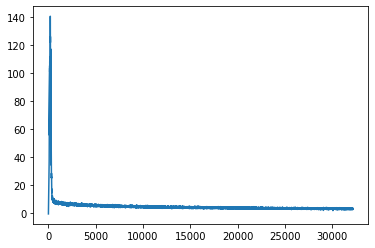

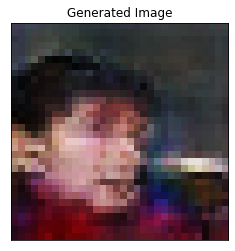

checkpointing at epoch: 30000
Iteration [30001/100000]......0.196(s) gen: 160.65750 - disc_fake: -160.38206 - disc_real: -157.32545 - disc_real: 3.05660
Iteration [30002/100000]......0.196(s) gen: 160.99554 - disc_fake: -160.47727 - disc_real: -157.60638 - disc_real: 2.87089
Iteration [30003/100000]......0.195(s) gen: 160.92897 - disc_fake: -161.02238 - disc_real: -157.76383 - disc_real: 3.25855
Iteration [30004/100000]......0.196(s) gen: 161.04141 - disc_fake: -160.80988 - disc_real: -157.67593 - disc_real: 3.13396
Iteration [30005/100000]......0.198(s) gen: 160.82233 - disc_fake: -160.95047 - disc_real: -157.65093 - disc_real: 3.29954
Iteration [30006/100000]......0.197(s) gen: 161.92432 - disc_fake: -161.25985 - disc_real: -158.10320 - disc_real: 3.15665
Iteration [30007/100000]......0.200(s) gen: 161.41412 - disc_fake: -161.61381 - disc_real: -158.48225 - disc_real: 3.13156
Iteration [30008/100000]......0.198(s) gen: 160.67897 - disc_fake: -160.74137 - disc_real: -157.86724 - disc_

Iteration [30069/100000]......0.194(s) gen: 160.31476 - disc_fake: -160.23702 - disc_real: -157.16758 - disc_real: 3.06944
Iteration [30070/100000]......0.194(s) gen: 160.57243 - disc_fake: -160.24391 - disc_real: -157.23689 - disc_real: 3.00703
Iteration [30071/100000]......0.197(s) gen: 160.32535 - disc_fake: -160.24624 - disc_real: -157.07897 - disc_real: 3.16727
Iteration [30072/100000]......0.197(s) gen: 160.67818 - disc_fake: -160.12090 - disc_real: -157.31637 - disc_real: 2.80453
Iteration [30073/100000]......0.199(s) gen: 161.30632 - disc_fake: -160.85980 - disc_real: -157.83848 - disc_real: 3.02132
Iteration [30074/100000]......0.197(s) gen: 161.82098 - disc_fake: -161.57330 - disc_real: -158.43441 - disc_real: 3.13889
Iteration [30075/100000]......0.197(s) gen: 162.01472 - disc_fake: -161.94075 - disc_real: -158.65178 - disc_real: 3.28897
Iteration [30076/100000]......0.197(s) gen: 161.16783 - disc_fake: -161.71357 - disc_real: -158.56718 - disc_real: 3.14639
Iteration [30077

Iteration [30136/100000]......0.199(s) gen: 160.49426 - disc_fake: -160.12431 - disc_real: -157.04369 - disc_real: 3.08062
Iteration [30137/100000]......0.200(s) gen: 160.35840 - disc_fake: -160.74659 - disc_real: -157.40439 - disc_real: 3.34220
Iteration [30138/100000]......0.201(s) gen: 160.54321 - disc_fake: -160.54605 - disc_real: -157.78753 - disc_real: 2.75851
Iteration [30139/100000]......0.201(s) gen: 160.77596 - disc_fake: -161.02142 - disc_real: -157.64991 - disc_real: 3.37151
Iteration [30140/100000]......0.201(s) gen: 160.86111 - disc_fake: -160.86364 - disc_real: -157.51705 - disc_real: 3.34659
Iteration [30141/100000]......0.202(s) gen: 161.61707 - disc_fake: -160.74814 - disc_real: -157.73733 - disc_real: 3.01081
Iteration [30142/100000]......0.200(s) gen: 161.57764 - disc_fake: -161.48947 - disc_real: -158.19149 - disc_real: 3.29798
Iteration [30143/100000]......0.200(s) gen: 162.01505 - disc_fake: -161.82299 - disc_real: -158.79399 - disc_real: 3.02899
Iteration [30144

Iteration [30203/100000]......0.198(s) gen: 161.24956 - disc_fake: -161.52557 - disc_real: -158.63350 - disc_real: 2.89207
Iteration [30204/100000]......0.197(s) gen: 160.67271 - disc_fake: -161.14799 - disc_real: -157.60190 - disc_real: 3.54609
Iteration [30205/100000]......0.199(s) gen: 160.40215 - disc_fake: -160.40031 - disc_real: -157.01000 - disc_real: 3.39031
Iteration [30206/100000]......0.201(s) gen: 159.81952 - disc_fake: -159.91855 - disc_real: -156.65899 - disc_real: 3.25956
Iteration [30207/100000]......0.201(s) gen: 160.08737 - disc_fake: -160.06025 - disc_real: -157.21415 - disc_real: 2.84610
Iteration [30208/100000]......0.201(s) gen: 160.59158 - disc_fake: -159.79348 - disc_real: -157.18766 - disc_real: 2.60583
Iteration [30209/100000]......0.202(s) gen: 161.18304 - disc_fake: -160.75307 - disc_real: -158.02449 - disc_real: 2.72858
Iteration [30210/100000]......0.204(s) gen: 161.04639 - disc_fake: -161.14016 - disc_real: -158.18574 - disc_real: 2.95442
Iteration [30211

Iteration [30270/100000]......0.201(s) gen: 161.13229 - disc_fake: -160.88669 - disc_real: -157.83056 - disc_real: 3.05613
Iteration [30271/100000]......0.201(s) gen: 160.79305 - disc_fake: -160.97054 - disc_real: -158.10240 - disc_real: 2.86813
Iteration [30272/100000]......0.202(s) gen: 160.71149 - disc_fake: -160.76932 - disc_real: -157.12487 - disc_real: 3.64445
Iteration [30273/100000]......0.200(s) gen: 160.90842 - disc_fake: -160.23384 - disc_real: -157.22692 - disc_real: 3.00693
Iteration [30274/100000]......0.204(s) gen: 160.24255 - disc_fake: -160.76273 - disc_real: -157.02692 - disc_real: 3.73582
Iteration [30275/100000]......0.206(s) gen: 160.71927 - disc_fake: -160.57483 - disc_real: -157.25517 - disc_real: 3.31966
Iteration [30276/100000]......0.205(s) gen: 161.10037 - disc_fake: -160.51598 - disc_real: -157.57260 - disc_real: 2.94338
Iteration [30277/100000]......0.205(s) gen: 161.61127 - disc_fake: -160.76072 - disc_real: -157.96413 - disc_real: 2.79659
Iteration [30278

Iteration [30337/100000]......0.200(s) gen: 161.58324 - disc_fake: -161.51859 - disc_real: -158.42043 - disc_real: 3.09817
Iteration [30338/100000]......0.199(s) gen: 161.96051 - disc_fake: -161.62103 - disc_real: -158.54544 - disc_real: 3.07559
Iteration [30339/100000]......0.198(s) gen: 162.06934 - disc_fake: -161.84666 - disc_real: -159.14981 - disc_real: 2.69685
Iteration [30340/100000]......0.199(s) gen: 162.22574 - disc_fake: -161.95272 - disc_real: -158.73749 - disc_real: 3.21523
Iteration [30341/100000]......0.201(s) gen: 162.54950 - disc_fake: -162.22338 - disc_real: -158.74139 - disc_real: 3.48199
Iteration [30342/100000]......0.200(s) gen: 162.36276 - disc_fake: -162.26933 - disc_real: -159.35279 - disc_real: 2.91654
Iteration [30343/100000]......0.200(s) gen: 162.85373 - disc_fake: -162.73070 - disc_real: -159.53199 - disc_real: 3.19872
Iteration [30344/100000]......0.201(s) gen: 162.70361 - disc_fake: -162.82359 - disc_real: -159.52462 - disc_real: 3.29897
Iteration [30345

Iteration [30404/100000]......0.197(s) gen: 162.54749 - disc_fake: -162.32011 - disc_real: -159.65421 - disc_real: 2.66590
Iteration [30405/100000]......0.201(s) gen: 163.20158 - disc_fake: -162.82208 - disc_real: -159.93936 - disc_real: 2.88272
Iteration [30406/100000]......0.213(s) gen: 162.83817 - disc_fake: -163.22661 - disc_real: -159.91798 - disc_real: 3.30863
Iteration [30407/100000]......0.203(s) gen: 161.96875 - disc_fake: -162.54484 - disc_real: -159.27268 - disc_real: 3.27216
Iteration [30408/100000]......0.200(s) gen: 161.95468 - disc_fake: -162.15511 - disc_real: -158.59640 - disc_real: 3.55871
Iteration [30409/100000]......0.200(s) gen: 160.67914 - disc_fake: -161.14841 - disc_real: -158.24037 - disc_real: 2.90804
Iteration [30410/100000]......0.199(s) gen: 161.35159 - disc_fake: -160.88685 - disc_real: -158.23249 - disc_real: 2.65436
Iteration [30411/100000]......0.199(s) gen: 161.13681 - disc_fake: -161.38331 - disc_real: -158.04132 - disc_real: 3.34198
Iteration [30412

Iteration [30471/100000]......0.200(s) gen: 163.73169 - disc_fake: -163.36652 - disc_real: -160.31398 - disc_real: 3.05254
Iteration [30472/100000]......0.202(s) gen: 162.87946 - disc_fake: -163.00906 - disc_real: -160.40377 - disc_real: 2.60529
Iteration [30473/100000]......0.205(s) gen: 162.89059 - disc_fake: -162.92672 - disc_real: -159.86498 - disc_real: 3.06174
Iteration [30474/100000]......0.205(s) gen: 162.33905 - disc_fake: -162.56503 - disc_real: -159.29543 - disc_real: 3.26960
Iteration [30475/100000]......0.209(s) gen: 162.33629 - disc_fake: -162.21536 - disc_real: -159.19781 - disc_real: 3.01755
Iteration [30476/100000]......0.211(s) gen: 161.91534 - disc_fake: -162.05265 - disc_real: -159.06004 - disc_real: 2.99261
Iteration [30477/100000]......0.209(s) gen: 162.50496 - disc_fake: -162.14099 - disc_real: -159.19267 - disc_real: 2.94832
Iteration [30478/100000]......0.206(s) gen: 162.73587 - disc_fake: -162.60007 - disc_real: -159.80498 - disc_real: 2.79510
Iteration [30479

Iteration [30538/100000]......0.200(s) gen: 162.42163 - disc_fake: -162.14495 - disc_real: -159.36045 - disc_real: 2.78450
Iteration [30539/100000]......0.200(s) gen: 161.87883 - disc_fake: -162.34778 - disc_real: -159.19644 - disc_real: 3.15134
Iteration [30540/100000]......0.199(s) gen: 161.84576 - disc_fake: -161.73558 - disc_real: -158.87567 - disc_real: 2.85991
Iteration [30541/100000]......0.200(s) gen: 161.78926 - disc_fake: -162.16094 - disc_real: -159.00862 - disc_real: 3.15233
Iteration [30542/100000]......0.211(s) gen: 162.16144 - disc_fake: -161.72441 - disc_real: -158.63793 - disc_real: 3.08647
Iteration [30543/100000]......0.200(s) gen: 161.56598 - disc_fake: -161.75679 - disc_real: -158.57035 - disc_real: 3.18644
Iteration [30544/100000]......0.204(s) gen: 161.82858 - disc_fake: -161.71137 - disc_real: -158.63878 - disc_real: 3.07259
Iteration [30545/100000]......0.194(s) gen: 161.94757 - disc_fake: -161.87095 - disc_real: -158.86824 - disc_real: 3.00271
Iteration [30546

Iteration [30605/100000]......0.194(s) gen: 162.99796 - disc_fake: -163.29176 - disc_real: -160.39352 - disc_real: 2.89825
Iteration [30606/100000]......0.193(s) gen: 162.97900 - disc_fake: -163.04155 - disc_real: -160.02595 - disc_real: 3.01560
Iteration [30607/100000]......0.195(s) gen: 162.06519 - disc_fake: -162.54042 - disc_real: -159.41998 - disc_real: 3.12044
Iteration [30608/100000]......0.195(s) gen: 162.58426 - disc_fake: -162.16989 - disc_real: -159.28979 - disc_real: 2.88010
Iteration [30609/100000]......0.200(s) gen: 162.13184 - disc_fake: -162.48726 - disc_real: -159.34464 - disc_real: 3.14261
Iteration [30610/100000]......0.201(s) gen: 162.46187 - disc_fake: -162.31750 - disc_real: -159.37277 - disc_real: 2.94473
Iteration [30611/100000]......0.202(s) gen: 161.89082 - disc_fake: -162.05952 - disc_real: -158.89442 - disc_real: 3.16510
Iteration [30612/100000]......0.202(s) gen: 161.97505 - disc_fake: -162.03935 - disc_real: -158.70761 - disc_real: 3.33174
Iteration [30613

Iteration [30673/100000]......0.198(s) gen: 164.45772 - disc_fake: -164.03334 - disc_real: -161.06796 - disc_real: 2.96538
Iteration [30674/100000]......0.198(s) gen: 164.01616 - disc_fake: -164.34178 - disc_real: -161.02802 - disc_real: 3.31376
Iteration [30675/100000]......0.196(s) gen: 163.49881 - disc_fake: -163.77758 - disc_real: -160.41205 - disc_real: 3.36554
Iteration [30676/100000]......0.196(s) gen: 162.82074 - disc_fake: -163.11606 - disc_real: -160.09078 - disc_real: 3.02528
Iteration [30677/100000]......0.197(s) gen: 162.23970 - disc_fake: -162.68716 - disc_real: -159.81739 - disc_real: 2.86977
Iteration [30678/100000]......0.200(s) gen: 162.09764 - disc_fake: -162.38044 - disc_real: -159.38097 - disc_real: 2.99947
Iteration [30679/100000]......0.198(s) gen: 162.37668 - disc_fake: -162.10459 - disc_real: -158.95991 - disc_real: 3.14468
Iteration [30680/100000]......0.199(s) gen: 162.77170 - disc_fake: -162.70318 - disc_real: -159.47638 - disc_real: 3.22680
Iteration [30681

Iteration [30740/100000]......0.200(s) gen: 163.57327 - disc_fake: -163.64424 - disc_real: -160.46308 - disc_real: 3.18116
Iteration [30741/100000]......0.200(s) gen: 163.69025 - disc_fake: -163.63698 - disc_real: -160.56840 - disc_real: 3.06858
Iteration [30742/100000]......0.201(s) gen: 163.46432 - disc_fake: -163.71797 - disc_real: -160.53830 - disc_real: 3.17967
Iteration [30743/100000]......0.201(s) gen: 163.64606 - disc_fake: -163.12305 - disc_real: -160.03635 - disc_real: 3.08670
Iteration [30744/100000]......0.200(s) gen: 163.16031 - disc_fake: -162.99876 - disc_real: -159.78499 - disc_real: 3.21378
Iteration [30745/100000]......0.201(s) gen: 163.41031 - disc_fake: -163.27573 - disc_real: -160.41964 - disc_real: 2.85609
Iteration [30746/100000]......0.201(s) gen: 163.53352 - disc_fake: -163.19189 - disc_real: -160.71798 - disc_real: 2.47391
Iteration [30747/100000]......0.203(s) gen: 163.72673 - disc_fake: -163.64048 - disc_real: -160.44437 - disc_real: 3.19611
Iteration [30748

Iteration [30807/100000]......0.199(s) gen: 161.84082 - disc_fake: -162.67081 - disc_real: -159.56342 - disc_real: 3.10739
Iteration [30808/100000]......0.201(s) gen: 162.10635 - disc_fake: -161.98687 - disc_real: -158.85775 - disc_real: 3.12912
Iteration [30809/100000]......0.204(s) gen: 162.96674 - disc_fake: -162.38090 - disc_real: -159.75173 - disc_real: 2.62917
Iteration [30810/100000]......0.209(s) gen: 163.26306 - disc_fake: -163.10062 - disc_real: -160.20174 - disc_real: 2.89888
Iteration [30811/100000]......0.209(s) gen: 163.88605 - disc_fake: -163.55164 - disc_real: -160.63754 - disc_real: 2.91410
Iteration [30812/100000]......0.208(s) gen: 164.04474 - disc_fake: -163.95187 - disc_real: -160.62145 - disc_real: 3.33042
Iteration [30813/100000]......0.207(s) gen: 163.96248 - disc_fake: -164.04223 - disc_real: -160.57320 - disc_real: 3.46903
Iteration [30814/100000]......0.205(s) gen: 164.31766 - disc_fake: -164.12943 - disc_real: -160.31621 - disc_real: 3.81322
Iteration [30815

Iteration [30875/100000]......0.195(s) gen: 162.97658 - disc_fake: -162.89747 - disc_real: -159.76527 - disc_real: 3.13220
Iteration [30876/100000]......0.194(s) gen: 164.01407 - disc_fake: -162.89143 - disc_real: -160.07793 - disc_real: 2.81350
Iteration [30877/100000]......0.196(s) gen: 164.20517 - disc_fake: -164.00529 - disc_real: -160.73636 - disc_real: 3.26893
Iteration [30878/100000]......0.196(s) gen: 164.23633 - disc_fake: -164.07129 - disc_real: -160.97922 - disc_real: 3.09207
Iteration [30879/100000]......0.198(s) gen: 164.31313 - disc_fake: -164.13679 - disc_real: -161.13190 - disc_real: 3.00489
Iteration [30880/100000]......0.198(s) gen: 164.55515 - disc_fake: -164.09836 - disc_real: -161.14478 - disc_real: 2.95358
Iteration [30881/100000]......0.200(s) gen: 163.71529 - disc_fake: -163.69738 - disc_real: -161.00501 - disc_real: 2.69237
Iteration [30882/100000]......0.198(s) gen: 164.19464 - disc_fake: -164.15259 - disc_real: -160.99161 - disc_real: 3.16098
Iteration [30883

Iteration [30942/100000]......0.203(s) gen: 164.13568 - disc_fake: -163.66879 - disc_real: -160.87826 - disc_real: 2.79053
Iteration [30943/100000]......0.200(s) gen: 164.81424 - disc_fake: -164.14789 - disc_real: -161.40251 - disc_real: 2.74539
Iteration [30944/100000]......0.199(s) gen: 164.67227 - disc_fake: -164.83569 - disc_real: -161.74070 - disc_real: 3.09500
Iteration [30945/100000]......0.197(s) gen: 164.46259 - disc_fake: -164.39498 - disc_real: -161.48748 - disc_real: 2.90750
Iteration [30946/100000]......0.198(s) gen: 163.87242 - disc_fake: -163.90812 - disc_real: -161.19676 - disc_real: 2.71136
Iteration [30947/100000]......0.199(s) gen: 163.85052 - disc_fake: -163.98539 - disc_real: -160.86909 - disc_real: 3.11631
Iteration [30948/100000]......0.248(s) gen: 163.42699 - disc_fake: -163.46902 - disc_real: -160.12247 - disc_real: 3.34655
Iteration [30949/100000]......0.209(s) gen: 163.68600 - disc_fake: -163.40100 - disc_real: -160.22881 - disc_real: 3.17219
Iteration [30950

Iteration [31009/100000]......0.198(s) gen: 163.49153 - disc_fake: -163.23041 - disc_real: -160.26804 - disc_real: 2.96237
Iteration [31010/100000]......0.198(s) gen: 163.57870 - disc_fake: -163.50392 - disc_real: -160.74355 - disc_real: 2.76037
Iteration [31011/100000]......0.198(s) gen: 163.53802 - disc_fake: -163.64984 - disc_real: -160.66959 - disc_real: 2.98025
Iteration [31012/100000]......0.195(s) gen: 164.21838 - disc_fake: -163.78563 - disc_real: -160.93390 - disc_real: 2.85173
Iteration [31013/100000]......0.195(s) gen: 164.66174 - disc_fake: -164.42499 - disc_real: -161.50470 - disc_real: 2.92029
Iteration [31014/100000]......0.199(s) gen: 164.86061 - disc_fake: -164.60045 - disc_real: -161.12762 - disc_real: 3.47284
Iteration [31015/100000]......0.199(s) gen: 164.29214 - disc_fake: -164.44523 - disc_real: -161.44938 - disc_real: 2.99585
Iteration [31016/100000]......0.254(s) gen: 163.18811 - disc_fake: -163.97807 - disc_real: -160.63348 - disc_real: 3.34459
Iteration [31017

Iteration [31076/100000]......0.201(s) gen: 163.61917 - disc_fake: -163.38315 - disc_real: -160.15020 - disc_real: 3.23294
Iteration [31077/100000]......0.216(s) gen: 162.76295 - disc_fake: -163.32388 - disc_real: -160.11432 - disc_real: 3.20956
Iteration [31078/100000]......0.201(s) gen: 163.77370 - disc_fake: -163.32277 - disc_real: -160.21675 - disc_real: 3.10602
Iteration [31079/100000]......0.198(s) gen: 163.68736 - disc_fake: -163.49396 - disc_real: -160.44687 - disc_real: 3.04709
Iteration [31080/100000]......0.198(s) gen: 164.45293 - disc_fake: -164.08022 - disc_real: -161.08706 - disc_real: 2.99316
Iteration [31081/100000]......0.194(s) gen: 164.49454 - disc_fake: -164.56182 - disc_real: -161.40542 - disc_real: 3.15641
Iteration [31082/100000]......0.194(s) gen: 165.56865 - disc_fake: -164.55345 - disc_real: -161.83725 - disc_real: 2.71619
Iteration [31083/100000]......0.195(s) gen: 165.84851 - disc_fake: -165.18940 - disc_real: -162.10047 - disc_real: 3.08893
Iteration [31084

Iteration [31143/100000]......0.201(s) gen: 163.96655 - disc_fake: -164.27460 - disc_real: -161.58450 - disc_real: 2.69010
Iteration [31144/100000]......0.199(s) gen: 164.34821 - disc_fake: -164.44593 - disc_real: -161.02839 - disc_real: 3.41754
Iteration [31145/100000]......0.199(s) gen: 165.04333 - disc_fake: -164.02779 - disc_real: -161.09967 - disc_real: 2.92812
Iteration [31146/100000]......0.200(s) gen: 164.14783 - disc_fake: -164.09919 - disc_real: -161.15949 - disc_real: 2.93970
Iteration [31147/100000]......0.201(s) gen: 163.95320 - disc_fake: -163.63911 - disc_real: -160.60110 - disc_real: 3.03800
Iteration [31148/100000]......0.200(s) gen: 163.62097 - disc_fake: -163.42114 - disc_real: -160.60822 - disc_real: 2.81292
Iteration [31149/100000]......0.256(s) gen: 163.05057 - disc_fake: -163.10237 - disc_real: -160.12967 - disc_real: 2.97270
Iteration [31150/100000]......0.195(s) gen: 163.97556 - disc_fake: -163.31298 - disc_real: -160.69147 - disc_real: 2.62151
Iteration [31151

Iteration [31210/100000]......0.198(s) gen: 164.49292 - disc_fake: -164.45017 - disc_real: -161.25526 - disc_real: 3.19491
Iteration [31211/100000]......0.199(s) gen: 164.34836 - disc_fake: -164.14994 - disc_real: -161.17692 - disc_real: 2.97302
Iteration [31212/100000]......0.201(s) gen: 164.68347 - disc_fake: -163.98123 - disc_real: -161.52517 - disc_real: 2.45606
Iteration [31213/100000]......0.202(s) gen: 165.00635 - disc_fake: -164.59185 - disc_real: -161.39927 - disc_real: 3.19258
Iteration [31214/100000]......0.203(s) gen: 164.71948 - disc_fake: -164.90408 - disc_real: -161.80031 - disc_real: 3.10376
Iteration [31215/100000]......0.206(s) gen: 165.62173 - disc_fake: -165.17646 - disc_real: -162.02530 - disc_real: 3.15116
Iteration [31216/100000]......0.204(s) gen: 164.74289 - disc_fake: -165.31017 - disc_real: -162.27878 - disc_real: 3.03139
Iteration [31217/100000]......0.200(s) gen: 163.90839 - disc_fake: -164.26711 - disc_real: -160.97935 - disc_real: 3.28776
Iteration [31218

Iteration [31277/100000]......0.204(s) gen: 165.60294 - disc_fake: -165.20863 - disc_real: -162.20851 - disc_real: 3.00012
Iteration [31278/100000]......0.199(s) gen: 164.67923 - disc_fake: -164.79217 - disc_real: -162.02855 - disc_real: 2.76362
Iteration [31279/100000]......0.198(s) gen: 164.21646 - disc_fake: -164.48336 - disc_real: -161.60169 - disc_real: 2.88167
Iteration [31280/100000]......0.199(s) gen: 162.97046 - disc_fake: -163.78974 - disc_real: -160.36469 - disc_real: 3.42505
Iteration [31281/100000]......0.205(s) gen: 162.83133 - disc_fake: -162.98424 - disc_real: -159.79532 - disc_real: 3.18892
Iteration [31282/100000]......0.201(s) gen: 162.61095 - disc_fake: -162.86496 - disc_real: -159.56716 - disc_real: 3.29780
Iteration [31283/100000]......0.204(s) gen: 162.66980 - disc_fake: -162.30545 - disc_real: -159.05497 - disc_real: 3.25048
Iteration [31284/100000]......0.199(s) gen: 163.33170 - disc_fake: -163.62733 - disc_real: -160.32527 - disc_real: 3.30206
Iteration [31285

Iteration [31343/100000]......0.198(s) gen: 163.77335 - disc_fake: -163.85472 - disc_real: -160.59798 - disc_real: 3.25674
Iteration [31344/100000]......0.198(s) gen: 164.67955 - disc_fake: -164.08360 - disc_real: -160.87639 - disc_real: 3.20721
Iteration [31345/100000]......0.203(s) gen: 165.32191 - disc_fake: -165.23106 - disc_real: -162.20476 - disc_real: 3.02630
Iteration [31346/100000]......0.205(s) gen: 165.17062 - disc_fake: -165.09831 - disc_real: -162.15884 - disc_real: 2.93947
Iteration [31347/100000]......0.204(s) gen: 165.12442 - disc_fake: -165.17459 - disc_real: -162.17715 - disc_real: 2.99744
Iteration [31348/100000]......0.204(s) gen: 165.34155 - disc_fake: -165.11581 - disc_real: -162.48666 - disc_real: 2.62914
Iteration [31349/100000]......0.202(s) gen: 165.04041 - disc_fake: -165.11504 - disc_real: -162.48460 - disc_real: 2.63043
Iteration [31350/100000]......0.201(s) gen: 164.77325 - disc_fake: -164.73037 - disc_real: -161.80511 - disc_real: 2.92526
Iteration [31351

Iteration [31411/100000]......0.198(s) gen: 166.84448 - disc_fake: -166.86066 - disc_real: -163.60488 - disc_real: 3.25577
Iteration [31412/100000]......0.199(s) gen: 166.83713 - disc_fake: -167.08893 - disc_real: -163.68725 - disc_real: 3.40168
Iteration [31413/100000]......0.200(s) gen: 165.92117 - disc_fake: -166.41807 - disc_real: -163.46437 - disc_real: 2.95370
Iteration [31414/100000]......0.200(s) gen: 165.84799 - disc_fake: -166.02990 - disc_real: -163.16025 - disc_real: 2.86965
Iteration [31415/100000]......0.204(s) gen: 165.41904 - disc_fake: -165.54644 - disc_real: -162.60725 - disc_real: 2.93918
Iteration [31416/100000]......0.205(s) gen: 165.47997 - disc_fake: -165.06198 - disc_real: -162.05965 - disc_real: 3.00233
Iteration [31417/100000]......0.210(s) gen: 165.33826 - disc_fake: -165.27818 - disc_real: -161.95122 - disc_real: 3.32696
Iteration [31418/100000]......0.201(s) gen: 165.39136 - disc_fake: -165.56831 - disc_real: -162.31345 - disc_real: 3.25486
Iteration [31419

Iteration [31479/100000]......0.200(s) gen: 165.29706 - disc_fake: -165.01699 - disc_real: -161.89166 - disc_real: 3.12533
Iteration [31480/100000]......0.199(s) gen: 165.71349 - disc_fake: -165.31456 - disc_real: -162.39095 - disc_real: 2.92361
Iteration [31481/100000]......0.199(s) gen: 165.80208 - disc_fake: -165.34031 - disc_real: -162.58372 - disc_real: 2.75659
Iteration [31482/100000]......0.199(s) gen: 165.85101 - disc_fake: -165.60263 - disc_real: -162.78424 - disc_real: 2.81840
Iteration [31483/100000]......0.199(s) gen: 165.14270 - disc_fake: -165.53677 - disc_real: -162.46591 - disc_real: 3.07086
Iteration [31484/100000]......0.202(s) gen: 164.44897 - disc_fake: -165.03458 - disc_real: -162.39600 - disc_real: 2.63858
Iteration [31485/100000]......0.198(s) gen: 164.26558 - disc_fake: -164.32177 - disc_real: -161.08047 - disc_real: 3.24130
Iteration [31486/100000]......0.198(s) gen: 163.73727 - disc_fake: -164.04269 - disc_real: -160.91347 - disc_real: 3.12922
Iteration [31487

Iteration [31546/100000]......0.197(s) gen: 166.26788 - disc_fake: -165.78947 - disc_real: -163.03925 - disc_real: 2.75023
Iteration [31547/100000]......0.200(s) gen: 166.16953 - disc_fake: -166.00085 - disc_real: -163.24635 - disc_real: 2.75450
Iteration [31548/100000]......0.204(s) gen: 165.52245 - disc_fake: -165.98762 - disc_real: -163.03336 - disc_real: 2.95426
Iteration [31549/100000]......0.206(s) gen: 165.48975 - disc_fake: -165.59947 - disc_real: -162.60358 - disc_real: 2.99589
Iteration [31550/100000]......0.206(s) gen: 165.41605 - disc_fake: -165.33557 - disc_real: -162.58571 - disc_real: 2.74985
Iteration [31551/100000]......0.204(s) gen: 165.44696 - disc_fake: -165.52552 - disc_real: -162.32097 - disc_real: 3.20455
Iteration [31552/100000]......0.203(s) gen: 165.99545 - disc_fake: -165.41920 - disc_real: -162.55258 - disc_real: 2.86662
Iteration [31553/100000]......0.201(s) gen: 166.34967 - disc_fake: -165.77868 - disc_real: -162.98096 - disc_real: 2.79772
Iteration [31554

Iteration [31613/100000]......0.201(s) gen: 165.59142 - disc_fake: -165.36350 - disc_real: -162.93198 - disc_real: 2.43152
Iteration [31614/100000]......0.200(s) gen: 166.01831 - disc_fake: -165.50185 - disc_real: -162.52984 - disc_real: 2.97201
Iteration [31615/100000]......0.200(s) gen: 165.77347 - disc_fake: -165.95228 - disc_real: -162.89272 - disc_real: 3.05956
Iteration [31616/100000]......0.197(s) gen: 165.63763 - disc_fake: -165.69785 - disc_real: -162.28697 - disc_real: 3.41088
Iteration [31617/100000]......0.198(s) gen: 165.71689 - disc_fake: -165.42970 - disc_real: -162.46787 - disc_real: 2.96183
Iteration [31618/100000]......0.198(s) gen: 166.01979 - disc_fake: -165.87553 - disc_real: -162.96769 - disc_real: 2.90784
Iteration [31619/100000]......0.199(s) gen: 166.32280 - disc_fake: -166.32301 - disc_real: -163.35939 - disc_real: 2.96362
Iteration [31620/100000]......0.197(s) gen: 166.37859 - disc_fake: -166.41155 - disc_real: -163.18088 - disc_real: 3.23068
Iteration [31621

Iteration [31681/100000]......0.199(s) gen: 165.44641 - disc_fake: -165.34405 - disc_real: -162.43649 - disc_real: 2.90756
Iteration [31682/100000]......0.198(s) gen: 165.27156 - disc_fake: -165.32095 - disc_real: -162.32304 - disc_real: 2.99791
Iteration [31683/100000]......0.193(s) gen: 165.85522 - disc_fake: -165.50401 - disc_real: -162.45147 - disc_real: 3.05254
Iteration [31684/100000]......0.196(s) gen: 165.40913 - disc_fake: -165.70300 - disc_real: -161.86440 - disc_real: 3.83861
Iteration [31685/100000]......0.195(s) gen: 165.47372 - disc_fake: -165.43213 - disc_real: -161.40762 - disc_real: 4.02450
Iteration [31686/100000]......0.194(s) gen: 164.80612 - disc_fake: -165.28474 - disc_real: -161.31393 - disc_real: 3.97081
Iteration [31687/100000]......0.194(s) gen: 164.73425 - disc_fake: -164.23976 - disc_real: -161.78108 - disc_real: 2.45869
Iteration [31688/100000]......0.194(s) gen: 165.24522 - disc_fake: -165.41517 - disc_real: -161.59885 - disc_real: 3.81632
Iteration [31689

Iteration [31748/100000]......0.202(s) gen: 165.72955 - disc_fake: -165.60182 - disc_real: -162.81967 - disc_real: 2.78215
Iteration [31749/100000]......0.200(s) gen: 165.80508 - disc_fake: -165.72399 - disc_real: -162.60250 - disc_real: 3.12149
Iteration [31750/100000]......0.198(s) gen: 165.44603 - disc_fake: -165.85468 - disc_real: -162.44028 - disc_real: 3.41440
Iteration [31751/100000]......0.197(s) gen: 165.24103 - disc_fake: -165.29448 - disc_real: -162.46315 - disc_real: 2.83134
Iteration [31752/100000]......0.197(s) gen: 165.26953 - disc_fake: -164.91487 - disc_real: -162.26187 - disc_real: 2.65301
Iteration [31753/100000]......0.194(s) gen: 165.08655 - disc_fake: -165.29977 - disc_real: -162.28559 - disc_real: 3.01418
Iteration [31754/100000]......0.197(s) gen: 165.15198 - disc_fake: -165.02933 - disc_real: -162.06652 - disc_real: 2.96281
Iteration [31755/100000]......0.196(s) gen: 165.34549 - disc_fake: -165.14125 - disc_real: -161.94425 - disc_real: 3.19700
Iteration [31756

Iteration [31815/100000]......0.195(s) gen: 165.25453 - disc_fake: -165.17894 - disc_real: -162.32681 - disc_real: 2.85213
Iteration [31816/100000]......0.197(s) gen: 165.39816 - disc_fake: -165.31638 - disc_real: -162.57913 - disc_real: 2.73725
Iteration [31817/100000]......0.196(s) gen: 165.75833 - disc_fake: -165.57609 - disc_real: -162.73725 - disc_real: 2.83884
Iteration [31818/100000]......0.196(s) gen: 166.23111 - disc_fake: -165.75253 - disc_real: -163.06696 - disc_real: 2.68557
Iteration [31819/100000]......0.197(s) gen: 165.86258 - disc_fake: -166.30444 - disc_real: -163.11779 - disc_real: 3.18665
Iteration [31820/100000]......0.196(s) gen: 166.54959 - disc_fake: -165.85816 - disc_real: -163.03413 - disc_real: 2.82403
Iteration [31821/100000]......0.197(s) gen: 166.38927 - disc_fake: -166.45389 - disc_real: -163.15645 - disc_real: 3.29745
Iteration [31822/100000]......0.198(s) gen: 166.21515 - disc_fake: -166.11286 - disc_real: -162.90617 - disc_real: 3.20669
Iteration [31823

Iteration [31883/100000]......0.202(s) gen: 164.91692 - disc_fake: -165.00648 - disc_real: -162.04689 - disc_real: 2.95960
Iteration [31884/100000]......0.200(s) gen: 164.89117 - disc_fake: -164.90238 - disc_real: -161.84153 - disc_real: 3.06085
Iteration [31885/100000]......0.202(s) gen: 164.66602 - disc_fake: -164.51392 - disc_real: -161.39988 - disc_real: 3.11403
Iteration [31886/100000]......0.202(s) gen: 164.78545 - disc_fake: -164.71590 - disc_real: -161.99050 - disc_real: 2.72540
Iteration [31887/100000]......0.261(s) gen: 165.58499 - disc_fake: -165.14679 - disc_real: -162.25792 - disc_real: 2.88887
Iteration [31888/100000]......0.194(s) gen: 165.79974 - disc_fake: -165.74466 - disc_real: -162.79201 - disc_real: 2.95264
Iteration [31889/100000]......0.197(s) gen: 167.02281 - disc_fake: -166.33707 - disc_real: -163.32818 - disc_real: 3.00889
Iteration [31890/100000]......0.196(s) gen: 167.02567 - disc_fake: -166.57159 - disc_real: -163.64204 - disc_real: 2.92956
Iteration [31891

Iteration [31950/100000]......0.199(s) gen: 165.76608 - disc_fake: -165.88688 - disc_real: -162.83322 - disc_real: 3.05366
Iteration [31951/100000]......0.203(s) gen: 165.80563 - disc_fake: -165.76922 - disc_real: -162.66572 - disc_real: 3.10350
Iteration [31952/100000]......0.204(s) gen: 165.93372 - disc_fake: -166.13967 - disc_real: -162.60251 - disc_real: 3.53716
Iteration [31953/100000]......0.202(s) gen: 166.22667 - disc_fake: -165.89661 - disc_real: -163.49793 - disc_real: 2.39868
Iteration [31954/100000]......0.205(s) gen: 166.58517 - disc_fake: -166.74611 - disc_real: -163.63678 - disc_real: 3.10933
Iteration [31955/100000]......0.206(s) gen: 168.29515 - disc_fake: -167.37881 - disc_real: -164.41606 - disc_real: 2.96274
Iteration [31956/100000]......0.204(s) gen: 167.46066 - disc_fake: -167.82534 - disc_real: -164.66194 - disc_real: 3.16341
Iteration [31957/100000]......0.201(s) gen: 167.78816 - disc_fake: -167.53744 - disc_real: -164.52055 - disc_real: 3.01689
Iteration [31958

Iteration [32017/100000]......0.225(s) gen: 166.59956 - disc_fake: -166.59789 - disc_real: -163.75769 - disc_real: 2.84020
Iteration [32018/100000]......0.239(s) gen: 166.12540 - disc_fake: -166.34564 - disc_real: -163.53554 - disc_real: 2.81010
Iteration [32019/100000]......0.195(s) gen: 165.71167 - disc_fake: -165.99419 - disc_real: -162.88324 - disc_real: 3.11095
Iteration [32020/100000]......0.195(s) gen: 165.36415 - disc_fake: -165.61134 - disc_real: -162.41458 - disc_real: 3.19676
Iteration [32021/100000]......0.198(s) gen: 165.44669 - disc_fake: -165.33274 - disc_real: -162.05464 - disc_real: 3.27809
Iteration [32022/100000]......0.199(s) gen: 166.24426 - disc_fake: -165.47924 - disc_real: -162.75426 - disc_real: 2.72498
Iteration [32023/100000]......0.203(s) gen: 166.34108 - disc_fake: -166.09938 - disc_real: -162.97000 - disc_real: 3.12939
Iteration [32024/100000]......0.201(s) gen: 166.99625 - disc_fake: -166.44509 - disc_real: -163.06547 - disc_real: 3.37962
Iteration [32025

Iteration [32084/100000]......0.197(s) gen: 167.46118 - disc_fake: -167.33199 - disc_real: -164.46803 - disc_real: 2.86396
Iteration [32085/100000]......0.196(s) gen: 166.91328 - disc_fake: -167.05818 - disc_real: -163.99745 - disc_real: 3.06073
Iteration [32086/100000]......0.196(s) gen: 166.39240 - disc_fake: -166.10961 - disc_real: -163.37817 - disc_real: 2.73144
Iteration [32087/100000]......0.197(s) gen: 166.56769 - disc_fake: -166.33095 - disc_real: -163.29110 - disc_real: 3.03985
Iteration [32088/100000]......0.195(s) gen: 166.47549 - disc_fake: -166.34611 - disc_real: -162.71734 - disc_real: 3.62877
Iteration [32089/100000]......0.195(s) gen: 166.32959 - disc_fake: -166.18187 - disc_real: -162.76692 - disc_real: 3.41495
Iteration [32090/100000]......0.193(s) gen: 166.57742 - disc_fake: -166.42083 - disc_real: -163.50705 - disc_real: 2.91378
Iteration [32091/100000]......0.199(s) gen: 166.95746 - disc_fake: -166.97331 - disc_real: -163.91948 - disc_real: 3.05383
Iteration [32092

Iteration [32151/100000]......0.199(s) gen: 167.70303 - disc_fake: -167.76404 - disc_real: -165.20761 - disc_real: 2.55643
Iteration [32152/100000]......0.213(s) gen: 167.27327 - disc_fake: -167.50661 - disc_real: -164.68116 - disc_real: 2.82544
Iteration [32153/100000]......0.203(s) gen: 167.11267 - disc_fake: -167.01405 - disc_real: -163.84113 - disc_real: 3.17292
Iteration [32154/100000]......0.207(s) gen: 167.04834 - disc_fake: -166.93176 - disc_real: -163.68568 - disc_real: 3.24608
Iteration [32155/100000]......0.206(s) gen: 166.66302 - disc_fake: -166.84147 - disc_real: -163.92722 - disc_real: 2.91425
Iteration [32156/100000]......0.204(s) gen: 166.42407 - disc_fake: -166.50822 - disc_real: -163.66667 - disc_real: 2.84154
Iteration [32157/100000]......0.202(s) gen: 166.23289 - disc_fake: -166.46230 - disc_real: -163.47896 - disc_real: 2.98333
Iteration [32158/100000]......0.199(s) gen: 166.93701 - disc_fake: -166.73849 - disc_real: -163.61450 - disc_real: 3.12399
Iteration [32159

Iteration [32218/100000]......0.201(s) gen: 165.66382 - disc_fake: -165.97638 - disc_real: -162.72542 - disc_real: 3.25096
Iteration [32219/100000]......0.201(s) gen: 165.46397 - disc_fake: -165.66826 - disc_real: -162.68104 - disc_real: 2.98722
Iteration [32220/100000]......0.199(s) gen: 165.81003 - disc_fake: -165.82351 - disc_real: -162.84893 - disc_real: 2.97458
Iteration [32221/100000]......0.199(s) gen: 165.93176 - disc_fake: -165.43096 - disc_real: -162.57935 - disc_real: 2.85161
Iteration [32222/100000]......0.198(s) gen: 165.97864 - disc_fake: -166.04524 - disc_real: -163.28564 - disc_real: 2.75961
Iteration [32223/100000]......0.199(s) gen: 166.63553 - disc_fake: -166.25660 - disc_real: -163.04148 - disc_real: 3.21512
Iteration [32224/100000]......0.198(s) gen: 166.45844 - disc_fake: -166.17291 - disc_real: -163.06007 - disc_real: 3.11284
Iteration [32225/100000]......0.199(s) gen: 166.28806 - disc_fake: -166.29106 - disc_real: -163.06379 - disc_real: 3.22728
Iteration [32226

Iteration [32286/100000]......0.197(s) gen: 167.80383 - disc_fake: -167.98031 - disc_real: -165.08951 - disc_real: 2.89080
Iteration [32287/100000]......0.197(s) gen: 168.25143 - disc_fake: -168.10147 - disc_real: -164.85240 - disc_real: 3.24907
Iteration [32288/100000]......0.197(s) gen: 168.04771 - disc_fake: -167.84961 - disc_real: -164.30525 - disc_real: 3.54436
Iteration [32289/100000]......0.200(s) gen: 167.81548 - disc_fake: -167.75248 - disc_real: -164.56390 - disc_real: 3.18859
Iteration [32290/100000]......0.199(s) gen: 167.79515 - disc_fake: -167.70248 - disc_real: -164.85326 - disc_real: 2.84922
Iteration [32291/100000]......0.201(s) gen: 168.00418 - disc_fake: -167.82487 - disc_real: -164.96918 - disc_real: 2.85569
Iteration [32292/100000]......0.202(s) gen: 168.38988 - disc_fake: -168.03463 - disc_real: -164.88095 - disc_real: 3.15367
Iteration [32293/100000]......0.200(s) gen: 168.83499 - disc_fake: -168.32789 - disc_real: -165.51160 - disc_real: 2.81629
Iteration [32294

Iteration [32354/100000]......0.196(s) gen: 167.39420 - disc_fake: -167.49613 - disc_real: -164.61434 - disc_real: 2.88179
Iteration [32355/100000]......0.194(s) gen: 167.45895 - disc_fake: -167.54343 - disc_real: -164.84344 - disc_real: 2.69999
Iteration [32356/100000]......0.195(s) gen: 167.81406 - disc_fake: -167.73140 - disc_real: -165.00457 - disc_real: 2.72682
Iteration [32357/100000]......0.195(s) gen: 168.11331 - disc_fake: -167.81544 - disc_real: -164.88445 - disc_real: 2.93099
Iteration [32358/100000]......0.195(s) gen: 169.32971 - disc_fake: -168.44565 - disc_real: -165.63839 - disc_real: 2.80726
Iteration [32359/100000]......0.198(s) gen: 169.43484 - disc_fake: -168.94585 - disc_real: -166.04890 - disc_real: 2.89695
Iteration [32360/100000]......0.198(s) gen: 169.48599 - disc_fake: -169.46002 - disc_real: -166.39089 - disc_real: 3.06913
Iteration [32361/100000]......0.197(s) gen: 169.56290 - disc_fake: -169.72037 - disc_real: -166.75143 - disc_real: 2.96894
Iteration [32362

Iteration [32422/100000]......0.201(s) gen: 168.43919 - disc_fake: -168.23613 - disc_real: -165.39564 - disc_real: 2.84049
Iteration [32423/100000]......0.201(s) gen: 168.40723 - disc_fake: -168.52951 - disc_real: -165.66869 - disc_real: 2.86082
Iteration [32424/100000]......0.204(s) gen: 167.54105 - disc_fake: -168.51612 - disc_real: -165.30911 - disc_real: 3.20701
Iteration [32425/100000]......0.203(s) gen: 167.85461 - disc_fake: -168.17537 - disc_real: -165.10557 - disc_real: 3.06980
Iteration [32426/100000]......0.201(s) gen: 168.86346 - disc_fake: -168.41353 - disc_real: -165.56209 - disc_real: 2.85144
Iteration [32427/100000]......0.200(s) gen: 168.81339 - disc_fake: -168.79699 - disc_real: -165.90731 - disc_real: 2.88969
Iteration [32428/100000]......0.198(s) gen: 168.28366 - disc_fake: -168.52190 - disc_real: -165.50634 - disc_real: 3.01557
Iteration [32429/100000]......0.200(s) gen: 168.34676 - disc_fake: -168.39586 - disc_real: -165.71648 - disc_real: 2.67938
Iteration [32430

Iteration [32490/100000]......0.199(s) gen: 167.76572 - disc_fake: -167.90026 - disc_real: -165.11316 - disc_real: 2.78710
Iteration [32491/100000]......0.201(s) gen: 167.91226 - disc_fake: -167.76059 - disc_real: -164.87830 - disc_real: 2.88229
Iteration [32492/100000]......0.201(s) gen: 167.26457 - disc_fake: -167.58192 - disc_real: -164.23272 - disc_real: 3.34920
Iteration [32493/100000]......0.200(s) gen: 168.09012 - disc_fake: -167.48554 - disc_real: -164.66201 - disc_real: 2.82353
Iteration [32494/100000]......0.200(s) gen: 167.82362 - disc_fake: -167.99404 - disc_real: -164.95265 - disc_real: 3.04140
Iteration [32495/100000]......0.200(s) gen: 167.81799 - disc_fake: -167.67143 - disc_real: -164.72281 - disc_real: 2.94862
Iteration [32496/100000]......0.198(s) gen: 168.14056 - disc_fake: -167.99192 - disc_real: -165.24026 - disc_real: 2.75165
Iteration [32497/100000]......0.199(s) gen: 168.81757 - disc_fake: -168.47630 - disc_real: -165.53025 - disc_real: 2.94606
Iteration [32498

Iteration [32557/100000]......0.203(s) gen: 168.01648 - disc_fake: -168.51235 - disc_real: -165.35962 - disc_real: 3.15273
Iteration [32558/100000]......0.205(s) gen: 167.94345 - disc_fake: -167.93539 - disc_real: -165.08310 - disc_real: 2.85228
Iteration [32559/100000]......0.208(s) gen: 167.96664 - disc_fake: -168.02756 - disc_real: -164.84405 - disc_real: 3.18351
Iteration [32560/100000]......0.207(s) gen: 168.31421 - disc_fake: -167.72041 - disc_real: -165.05594 - disc_real: 2.66447
Iteration [32561/100000]......0.205(s) gen: 168.45126 - disc_fake: -168.38626 - disc_real: -165.57154 - disc_real: 2.81472
Iteration [32562/100000]......0.204(s) gen: 168.52058 - disc_fake: -168.50099 - disc_real: -165.72484 - disc_real: 2.77615
Iteration [32563/100000]......0.209(s) gen: 169.10684 - disc_fake: -168.54726 - disc_real: -165.95658 - disc_real: 2.59069
Iteration [32564/100000]......0.199(s) gen: 170.38716 - disc_fake: -169.24713 - disc_real: -166.39989 - disc_real: 2.84724
Iteration [32565

Iteration [32624/100000]......0.210(s) gen: 169.91641 - disc_fake: -169.15436 - disc_real: -166.31396 - disc_real: 2.84040
Iteration [32625/100000]......0.208(s) gen: 169.92618 - disc_fake: -169.67848 - disc_real: -166.64810 - disc_real: 3.03038
Iteration [32626/100000]......0.204(s) gen: 169.85959 - disc_fake: -169.63160 - disc_real: -166.44675 - disc_real: 3.18485
Iteration [32627/100000]......0.203(s) gen: 169.29979 - disc_fake: -169.41339 - disc_real: -166.10900 - disc_real: 3.30439
Iteration [32628/100000]......0.201(s) gen: 168.93588 - disc_fake: -168.99467 - disc_real: -166.15612 - disc_real: 2.83855
Iteration [32629/100000]......0.198(s) gen: 168.46672 - disc_fake: -168.91258 - disc_real: -165.97584 - disc_real: 2.93674
Iteration [32630/100000]......0.198(s) gen: 168.12772 - disc_fake: -168.41940 - disc_real: -165.58922 - disc_real: 2.83018
Iteration [32631/100000]......0.199(s) gen: 167.35515 - disc_fake: -167.79186 - disc_real: -164.43310 - disc_real: 3.35876
Iteration [32632

Iteration [32691/100000]......0.202(s) gen: 169.74307 - disc_fake: -169.54170 - disc_real: -166.47435 - disc_real: 3.06735
Iteration [32692/100000]......0.201(s) gen: 169.13370 - disc_fake: -169.44380 - disc_real: -166.33591 - disc_real: 3.10789
Iteration [32693/100000]......0.213(s) gen: 169.85248 - disc_fake: -169.39689 - disc_real: -166.24818 - disc_real: 3.14872
Iteration [32694/100000]......0.210(s) gen: 169.17133 - disc_fake: -169.44188 - disc_real: -166.56065 - disc_real: 2.88123
Iteration [32695/100000]......0.213(s) gen: 168.69633 - disc_fake: -168.88831 - disc_real: -166.07010 - disc_real: 2.81822
Iteration [32696/100000]......0.220(s) gen: 168.62625 - disc_fake: -168.81181 - disc_real: -165.94307 - disc_real: 2.86875
Iteration [32697/100000]......0.215(s) gen: 168.29633 - disc_fake: -168.66212 - disc_real: -165.56916 - disc_real: 3.09297
Iteration [32698/100000]......0.211(s) gen: 168.41112 - disc_fake: -168.27732 - disc_real: -165.43659 - disc_real: 2.84073
Iteration [32699

Iteration [32758/100000]......0.195(s) gen: 169.31003 - disc_fake: -169.04563 - disc_real: -166.30285 - disc_real: 2.74278
Iteration [32759/100000]......0.195(s) gen: 169.83350 - disc_fake: -169.69874 - disc_real: -166.83986 - disc_real: 2.85888
Iteration [32760/100000]......0.198(s) gen: 169.87129 - disc_fake: -169.82337 - disc_real: -166.86107 - disc_real: 2.96230
Iteration [32761/100000]......0.210(s) gen: 169.53511 - disc_fake: -169.75835 - disc_real: -166.75178 - disc_real: 3.00657
Iteration [32762/100000]......0.196(s) gen: 168.96239 - disc_fake: -169.16315 - disc_real: -166.16600 - disc_real: 2.99715
Iteration [32763/100000]......0.205(s) gen: 168.83058 - disc_fake: -168.64269 - disc_real: -165.55554 - disc_real: 3.08715
Iteration [32764/100000]......0.199(s) gen: 168.59602 - disc_fake: -168.61270 - disc_real: -165.42314 - disc_real: 3.18956
Iteration [32765/100000]......0.196(s) gen: 168.47021 - disc_fake: -168.22328 - disc_real: -165.40245 - disc_real: 2.82083
Iteration [32766

Iteration [32825/100000]......0.203(s) gen: 169.88185 - disc_fake: -169.78509 - disc_real: -166.68040 - disc_real: 3.10469
Iteration [32826/100000]......0.205(s) gen: 169.65057 - disc_fake: -169.60517 - disc_real: -166.89013 - disc_real: 2.71504
Iteration [32827/100000]......0.206(s) gen: 169.72685 - disc_fake: -169.70427 - disc_real: -166.72126 - disc_real: 2.98300
Iteration [32828/100000]......0.206(s) gen: 169.59702 - disc_fake: -169.58802 - disc_real: -166.75339 - disc_real: 2.83464
Iteration [32829/100000]......0.207(s) gen: 170.06995 - disc_fake: -169.43260 - disc_real: -166.13662 - disc_real: 3.29597
Iteration [32830/100000]......0.203(s) gen: 169.90765 - disc_fake: -169.65468 - disc_real: -167.14084 - disc_real: 2.51384
Iteration [32831/100000]......0.213(s) gen: 169.58342 - disc_fake: -169.40963 - disc_real: -166.73678 - disc_real: 2.67285
Iteration [32832/100000]......0.196(s) gen: 168.34677 - disc_fake: -169.05550 - disc_real: -165.90273 - disc_real: 3.15277
Iteration [32833

Iteration [32892/100000]......0.197(s) gen: 167.53159 - disc_fake: -168.08987 - disc_real: -164.88949 - disc_real: 3.20038
Iteration [32893/100000]......0.197(s) gen: 168.28247 - disc_fake: -167.91177 - disc_real: -164.90005 - disc_real: 3.01172
Iteration [32894/100000]......0.198(s) gen: 168.62170 - disc_fake: -168.41682 - disc_real: -165.43510 - disc_real: 2.98172
Iteration [32895/100000]......0.200(s) gen: 169.08640 - disc_fake: -168.50830 - disc_real: -165.94299 - disc_real: 2.56531
Iteration [32896/100000]......0.200(s) gen: 168.84940 - disc_fake: -169.00568 - disc_real: -165.98671 - disc_real: 3.01897
Iteration [32897/100000]......0.205(s) gen: 168.91400 - disc_fake: -168.93730 - disc_real: -166.13050 - disc_real: 2.80681
Iteration [32898/100000]......0.203(s) gen: 168.78073 - disc_fake: -168.95055 - disc_real: -165.89061 - disc_real: 3.05993
Iteration [32899/100000]......0.199(s) gen: 168.90112 - disc_fake: -168.91404 - disc_real: -165.61674 - disc_real: 3.29730
Iteration [32900

Iteration [32959/100000]......0.199(s) gen: 169.90375 - disc_fake: -170.04692 - disc_real: -166.95151 - disc_real: 3.09541
Iteration [32960/100000]......0.201(s) gen: 169.93472 - disc_fake: -169.52490 - disc_real: -166.89806 - disc_real: 2.62684
Iteration [32961/100000]......0.204(s) gen: 169.95789 - disc_fake: -169.80399 - disc_real: -166.85418 - disc_real: 2.94981
Iteration [32962/100000]......0.205(s) gen: 169.79807 - disc_fake: -169.73632 - disc_real: -166.46467 - disc_real: 3.27165
Iteration [32963/100000]......0.203(s) gen: 169.34418 - disc_fake: -169.21800 - disc_real: -166.27187 - disc_real: 2.94613
Iteration [32964/100000]......0.201(s) gen: 168.91281 - disc_fake: -169.00839 - disc_real: -166.23499 - disc_real: 2.77340
Iteration [32965/100000]......0.199(s) gen: 168.80179 - disc_fake: -168.68937 - disc_real: -165.91207 - disc_real: 2.77730
Iteration [32966/100000]......0.197(s) gen: 168.85083 - disc_fake: -168.92104 - disc_real: -165.77143 - disc_real: 3.14960
Iteration [32967

Iteration [33027/100000]......0.201(s) gen: 169.83482 - disc_fake: -169.55912 - disc_real: -166.99123 - disc_real: 2.56789
Iteration [33028/100000]......0.202(s) gen: 170.26749 - disc_fake: -170.25337 - disc_real: -167.48405 - disc_real: 2.76931
Iteration [33029/100000]......0.203(s) gen: 170.67432 - disc_fake: -170.29191 - disc_real: -167.36174 - disc_real: 2.93017
Iteration [33030/100000]......0.211(s) gen: 170.40797 - disc_fake: -170.34318 - disc_real: -167.19704 - disc_real: 3.14615
Iteration [33031/100000]......0.201(s) gen: 170.07993 - disc_fake: -170.07092 - disc_real: -167.27411 - disc_real: 2.79681
Iteration [33032/100000]......0.198(s) gen: 169.86020 - disc_fake: -169.82926 - disc_real: -166.54559 - disc_real: 3.28367
Iteration [33033/100000]......0.213(s) gen: 169.07069 - disc_fake: -169.28264 - disc_real: -166.10262 - disc_real: 3.18003
Iteration [33034/100000]......0.196(s) gen: 168.86536 - disc_fake: -168.78690 - disc_real: -166.08623 - disc_real: 2.70067
Iteration [33035

Iteration [33094/100000]......0.198(s) gen: 170.72906 - disc_fake: -170.57451 - disc_real: -167.60141 - disc_real: 2.97310
Iteration [33095/100000]......0.196(s) gen: 169.76868 - disc_fake: -170.34396 - disc_real: -167.68305 - disc_real: 2.66091
Iteration [33096/100000]......0.196(s) gen: 169.83060 - disc_fake: -169.59312 - disc_real: -166.74212 - disc_real: 2.85100
Iteration [33097/100000]......0.196(s) gen: 169.99374 - disc_fake: -169.76988 - disc_real: -166.90486 - disc_real: 2.86502
Iteration [33098/100000]......0.198(s) gen: 169.98636 - disc_fake: -169.92986 - disc_real: -167.07975 - disc_real: 2.85012
Iteration [33099/100000]......0.199(s) gen: 170.17343 - disc_fake: -170.07617 - disc_real: -167.19914 - disc_real: 2.87704
Iteration [33100/100000]......0.197(s) gen: 169.89754 - disc_fake: -169.89170 - disc_real: -167.01872 - disc_real: 2.87298
Iteration [33101/100000]......0.196(s) gen: 170.17212 - disc_fake: -169.67084 - disc_real: -167.01445 - disc_real: 2.65639
Iteration [33102

Iteration [33161/100000]......0.199(s) gen: 169.84839 - disc_fake: -169.26032 - disc_real: -166.40509 - disc_real: 2.85523
Iteration [33162/100000]......0.300(s) gen: 169.85620 - disc_fake: -169.97308 - disc_real: -166.79090 - disc_real: 3.18219
Iteration [33163/100000]......0.221(s) gen: 170.31155 - disc_fake: -169.84424 - disc_real: -166.91542 - disc_real: 2.92882
Iteration [33164/100000]......0.198(s) gen: 169.50125 - disc_fake: -169.78227 - disc_real: -166.81349 - disc_real: 2.96877
Iteration [33165/100000]......0.199(s) gen: 168.98790 - disc_fake: -168.98587 - disc_real: -166.38207 - disc_real: 2.60380
Iteration [33166/100000]......0.202(s) gen: 170.00764 - disc_fake: -169.62122 - disc_real: -166.81850 - disc_real: 2.80273
Iteration [33167/100000]......0.202(s) gen: 170.43756 - disc_fake: -170.15448 - disc_real: -167.29829 - disc_real: 2.85619
Iteration [33168/100000]......0.201(s) gen: 169.95947 - disc_fake: -170.49074 - disc_real: -167.40254 - disc_real: 3.08820
Iteration [33169

Iteration [33229/100000]......0.197(s) gen: 168.82014 - disc_fake: -168.47344 - disc_real: -165.32561 - disc_real: 3.14783
Iteration [33230/100000]......0.196(s) gen: 169.31157 - disc_fake: -168.81700 - disc_real: -165.98065 - disc_real: 2.83635
Iteration [33231/100000]......0.196(s) gen: 169.56178 - disc_fake: -169.26240 - disc_real: -166.80151 - disc_real: 2.46089
Iteration [33232/100000]......0.195(s) gen: 170.06915 - disc_fake: -169.56594 - disc_real: -166.82911 - disc_real: 2.73683
Iteration [33233/100000]......0.196(s) gen: 170.31027 - disc_fake: -170.07517 - disc_real: -166.95492 - disc_real: 3.12025
Iteration [33234/100000]......0.196(s) gen: 170.81583 - disc_fake: -170.25723 - disc_real: -167.25550 - disc_real: 3.00173
Iteration [33235/100000]......0.196(s) gen: 170.40617 - disc_fake: -170.68541 - disc_real: -167.65439 - disc_real: 3.03102
Iteration [33236/100000]......0.196(s) gen: 170.42239 - disc_fake: -170.40238 - disc_real: -167.52727 - disc_real: 2.87511
Iteration [33237

Iteration [33296/100000]......0.200(s) gen: 170.61374 - disc_fake: -170.57254 - disc_real: -167.43835 - disc_real: 3.13419
Iteration [33297/100000]......0.200(s) gen: 170.54845 - disc_fake: -170.60791 - disc_real: -167.89039 - disc_real: 2.71752
Iteration [33298/100000]......0.200(s) gen: 171.13950 - disc_fake: -170.74414 - disc_real: -167.69094 - disc_real: 3.05320
Iteration [33299/100000]......0.200(s) gen: 170.68040 - disc_fake: -170.94400 - disc_real: -167.75035 - disc_real: 3.19364
Iteration [33300/100000]......0.213(s) gen: 169.59995 - disc_fake: -169.61490 - disc_real: -166.68240 - disc_real: 2.93250
Iteration [33301/100000]......0.196(s) gen: 169.80132 - disc_fake: -169.53439 - disc_real: -166.57012 - disc_real: 2.96428
Iteration [33302/100000]......0.197(s) gen: 169.20978 - disc_fake: -169.34866 - disc_real: -166.28271 - disc_real: 3.06595
Iteration [33303/100000]......0.198(s) gen: 168.61963 - disc_fake: -169.02301 - disc_real: -166.18031 - disc_real: 2.84270
Iteration [33304

Iteration [33364/100000]......0.197(s) gen: 169.55695 - disc_fake: -169.07134 - disc_real: -166.65334 - disc_real: 2.41800
Iteration [33365/100000]......0.197(s) gen: 170.06174 - disc_fake: -169.50627 - disc_real: -166.63456 - disc_real: 2.87171
Iteration [33366/100000]......0.199(s) gen: 170.59734 - disc_fake: -170.15623 - disc_real: -167.21170 - disc_real: 2.94453
Iteration [33367/100000]......0.200(s) gen: 170.07132 - disc_fake: -170.53723 - disc_real: -167.74846 - disc_real: 2.78877
Iteration [33368/100000]......0.202(s) gen: 169.84065 - disc_fake: -170.15761 - disc_real: -167.33998 - disc_real: 2.81763
Iteration [33369/100000]......0.200(s) gen: 169.88907 - disc_fake: -169.62320 - disc_real: -166.72065 - disc_real: 2.90255
Iteration [33370/100000]......0.198(s) gen: 169.88904 - disc_fake: -169.71718 - disc_real: -166.97892 - disc_real: 2.73826
Iteration [33371/100000]......0.198(s) gen: 170.08530 - disc_fake: -169.78544 - disc_real: -167.09219 - disc_real: 2.69325
Iteration [33372

Iteration [33431/100000]......0.203(s) gen: 168.18652 - disc_fake: -168.21149 - disc_real: -165.08452 - disc_real: 3.12697
Iteration [33432/100000]......0.200(s) gen: 168.90997 - disc_fake: -168.26900 - disc_real: -165.47368 - disc_real: 2.79532
Iteration [33433/100000]......0.200(s) gen: 169.32507 - disc_fake: -169.05776 - disc_real: -166.48860 - disc_real: 2.56916
Iteration [33434/100000]......0.201(s) gen: 169.99579 - disc_fake: -169.46010 - disc_real: -166.78138 - disc_real: 2.67872
Iteration [33435/100000]......0.199(s) gen: 170.28238 - disc_fake: -170.11788 - disc_real: -167.02917 - disc_real: 3.08871
Iteration [33436/100000]......0.199(s) gen: 170.53067 - disc_fake: -170.44998 - disc_real: -167.36537 - disc_real: 3.08461
Iteration [33437/100000]......0.196(s) gen: 170.88947 - disc_fake: -170.63391 - disc_real: -167.97029 - disc_real: 2.66362
Iteration [33438/100000]......0.198(s) gen: 170.92442 - disc_fake: -170.75433 - disc_real: -167.81755 - disc_real: 2.93679
Iteration [33439

Iteration [33498/100000]......0.202(s) gen: 169.03784 - disc_fake: -169.41113 - disc_real: -166.50988 - disc_real: 2.90125
Iteration [33499/100000]......0.201(s) gen: 170.04602 - disc_fake: -169.58658 - disc_real: -166.35379 - disc_real: 3.23279
Iteration [33500/100000]......0.204(s) gen: 170.13818 - disc_fake: -170.19491 - disc_real: -167.18110 - disc_real: 3.01382
Iteration [33501/100000]......0.204(s) gen: 169.90913 - disc_fake: -170.25949 - disc_real: -167.15435 - disc_real: 3.10514
Iteration [33502/100000]......0.202(s) gen: 170.09111 - disc_fake: -169.87423 - disc_real: -167.28925 - disc_real: 2.58498
Iteration [33503/100000]......0.202(s) gen: 169.91000 - disc_fake: -169.71818 - disc_real: -166.99369 - disc_real: 2.72449
Iteration [33504/100000]......0.198(s) gen: 169.69394 - disc_fake: -170.05667 - disc_real: -166.90141 - disc_real: 3.15526
Iteration [33505/100000]......0.198(s) gen: 169.73013 - disc_fake: -169.65679 - disc_real: -166.72879 - disc_real: 2.92801
Iteration [33506

Iteration [33565/100000]......0.194(s) gen: 170.28238 - disc_fake: -170.22418 - disc_real: -167.46927 - disc_real: 2.75491
Iteration [33566/100000]......0.194(s) gen: 170.66270 - disc_fake: -170.37655 - disc_real: -167.43867 - disc_real: 2.93789
Iteration [33567/100000]......0.196(s) gen: 170.80243 - disc_fake: -170.63940 - disc_real: -167.84524 - disc_real: 2.79415
Iteration [33568/100000]......0.195(s) gen: 170.83815 - disc_fake: -170.74295 - disc_real: -167.68523 - disc_real: 3.05772
Iteration [33569/100000]......0.195(s) gen: 170.55376 - disc_fake: -170.80565 - disc_real: -168.13335 - disc_real: 2.67231
Iteration [33570/100000]......0.196(s) gen: 169.93723 - disc_fake: -170.25985 - disc_real: -167.21375 - disc_real: 3.04611
Iteration [33571/100000]......0.197(s) gen: 169.91611 - disc_fake: -169.95674 - disc_real: -166.74824 - disc_real: 3.20850
Iteration [33572/100000]......0.198(s) gen: 169.76961 - disc_fake: -170.00798 - disc_real: -166.98621 - disc_real: 3.02178
Iteration [33573

Iteration [33633/100000]......0.198(s) gen: 171.16397 - disc_fake: -171.11090 - disc_real: -168.42144 - disc_real: 2.68946
Iteration [33634/100000]......0.199(s) gen: 171.33484 - disc_fake: -170.81183 - disc_real: -167.99756 - disc_real: 2.81427
Iteration [33635/100000]......0.198(s) gen: 170.93994 - disc_fake: -170.91254 - disc_real: -167.52715 - disc_real: 3.38539
Iteration [33636/100000]......0.199(s) gen: 170.55272 - disc_fake: -170.62254 - disc_real: -167.67737 - disc_real: 2.94516
Iteration [33637/100000]......0.198(s) gen: 170.34834 - disc_fake: -170.30255 - disc_real: -167.47222 - disc_real: 2.83033
Iteration [33638/100000]......0.197(s) gen: 170.59421 - disc_fake: -170.32864 - disc_real: -167.34452 - disc_real: 2.98412
Iteration [33639/100000]......0.197(s) gen: 170.54274 - disc_fake: -170.33610 - disc_real: -167.39535 - disc_real: 2.94075
Iteration [33640/100000]......0.196(s) gen: 170.91382 - disc_fake: -170.62222 - disc_real: -167.23572 - disc_real: 3.38650
Iteration [33641

Iteration [33700/100000]......0.195(s) gen: 170.30043 - disc_fake: -169.71088 - disc_real: -167.09742 - disc_real: 2.61346
Iteration [33701/100000]......0.194(s) gen: 170.49030 - disc_fake: -170.27403 - disc_real: -167.80584 - disc_real: 2.46819
Iteration [33702/100000]......0.203(s) gen: 171.78036 - disc_fake: -170.94116 - disc_real: -168.20307 - disc_real: 2.73809
Iteration [33703/100000]......0.198(s) gen: 173.00349 - disc_fake: -172.34015 - disc_real: -168.98252 - disc_real: 3.35764
Iteration [33704/100000]......0.199(s) gen: 171.76064 - disc_fake: -171.84757 - disc_real: -168.93091 - disc_real: 2.91666
Iteration [33705/100000]......0.201(s) gen: 171.59604 - disc_fake: -171.60145 - disc_real: -168.58304 - disc_real: 3.01841
Iteration [33706/100000]......0.201(s) gen: 171.00943 - disc_fake: -171.44933 - disc_real: -168.20245 - disc_real: 3.24688
Iteration [33707/100000]......0.201(s) gen: 170.75266 - disc_fake: -171.26187 - disc_real: -167.75492 - disc_real: 3.50696
Iteration [33708

Iteration [33767/100000]......0.200(s) gen: 170.85292 - disc_fake: -170.85424 - disc_real: -168.16108 - disc_real: 2.69316
Iteration [33768/100000]......0.198(s) gen: 171.27194 - disc_fake: -171.01325 - disc_real: -167.94851 - disc_real: 3.06473
Iteration [33769/100000]......0.197(s) gen: 171.07172 - disc_fake: -170.76106 - disc_real: -168.05979 - disc_real: 2.70127
Iteration [33770/100000]......0.196(s) gen: 170.34589 - disc_fake: -170.38496 - disc_real: -167.43673 - disc_real: 2.94823
Iteration [33771/100000]......0.195(s) gen: 170.18198 - disc_fake: -170.41482 - disc_real: -167.50025 - disc_real: 2.91457
Iteration [33772/100000]......0.196(s) gen: 169.47824 - disc_fake: -170.16781 - disc_real: -167.14718 - disc_real: 3.02063
Iteration [33773/100000]......0.208(s) gen: 169.87488 - disc_fake: -169.59630 - disc_real: -166.83145 - disc_real: 2.76484
Iteration [33774/100000]......0.209(s) gen: 169.67294 - disc_fake: -169.61939 - disc_real: -166.71832 - disc_real: 2.90107
Iteration [33775

Iteration [33835/100000]......0.198(s) gen: 169.83502 - disc_fake: -169.98914 - disc_real: -167.04227 - disc_real: 2.94687
Iteration [33836/100000]......0.198(s) gen: 170.65936 - disc_fake: -170.26489 - disc_real: -167.77087 - disc_real: 2.49402
Iteration [33837/100000]......0.197(s) gen: 172.20665 - disc_fake: -171.12296 - disc_real: -168.13415 - disc_real: 2.98881
Iteration [33838/100000]......0.198(s) gen: 172.07233 - disc_fake: -172.09723 - disc_real: -168.78524 - disc_real: 3.31199
Iteration [33839/100000]......0.198(s) gen: 171.06276 - disc_fake: -171.11389 - disc_real: -168.54980 - disc_real: 2.56410
Iteration [33840/100000]......0.199(s) gen: 171.29767 - disc_fake: -171.43756 - disc_real: -168.20297 - disc_real: 3.23460
Iteration [33841/100000]......0.201(s) gen: 171.49104 - disc_fake: -171.44825 - disc_real: -168.14874 - disc_real: 3.29951
Iteration [33842/100000]......0.202(s) gen: 170.86864 - disc_fake: -171.69702 - disc_real: -168.37982 - disc_real: 3.31720
Iteration [33843

Iteration [33902/100000]......0.205(s) gen: 171.95798 - disc_fake: -171.15119 - disc_real: -168.31976 - disc_real: 2.83143
Iteration [33903/100000]......0.205(s) gen: 172.13464 - disc_fake: -171.97834 - disc_real: -168.97378 - disc_real: 3.00456
Iteration [33904/100000]......0.203(s) gen: 171.59866 - disc_fake: -171.64989 - disc_real: -168.80343 - disc_real: 2.84646
Iteration [33905/100000]......0.202(s) gen: 170.60207 - disc_fake: -171.01684 - disc_real: -167.95561 - disc_real: 3.06124
Iteration [33906/100000]......0.202(s) gen: 169.56685 - disc_fake: -170.21839 - disc_real: -166.89734 - disc_real: 3.32105
Iteration [33907/100000]......0.199(s) gen: 169.22276 - disc_fake: -169.42435 - disc_real: -166.48249 - disc_real: 2.94186
Iteration [33908/100000]......0.200(s) gen: 169.44972 - disc_fake: -169.24897 - disc_real: -166.04915 - disc_real: 3.19981
Iteration [33909/100000]......0.199(s) gen: 170.01402 - disc_fake: -169.27155 - disc_real: -166.62991 - disc_real: 2.64164
Iteration [33910

Iteration [33969/100000]......0.214(s) gen: 169.67487 - disc_fake: -169.72833 - disc_real: -166.78125 - disc_real: 2.94708
Iteration [33970/100000]......0.217(s) gen: 169.97644 - disc_fake: -169.65194 - disc_real: -166.86219 - disc_real: 2.78975
Iteration [33971/100000]......0.204(s) gen: 170.29630 - disc_fake: -170.02952 - disc_real: -167.51978 - disc_real: 2.50974
Iteration [33972/100000]......0.203(s) gen: 170.44167 - disc_fake: -170.22758 - disc_real: -167.64320 - disc_real: 2.58438
Iteration [33973/100000]......0.200(s) gen: 171.63905 - disc_fake: -170.81696 - disc_real: -168.15222 - disc_real: 2.66474
Iteration [33974/100000]......0.209(s) gen: 171.63562 - disc_fake: -171.57508 - disc_real: -168.35193 - disc_real: 3.22315
Iteration [33975/100000]......0.198(s) gen: 171.05161 - disc_fake: -171.02537 - disc_real: -168.38589 - disc_real: 2.63948
Iteration [33976/100000]......0.196(s) gen: 170.97945 - disc_fake: -170.63087 - disc_real: -167.93171 - disc_real: 2.69916
Iteration [33977

Iteration [34036/100000]......0.203(s) gen: 171.14627 - disc_fake: -171.11994 - disc_real: -168.54026 - disc_real: 2.57968
Iteration [34037/100000]......0.202(s) gen: 171.27345 - disc_fake: -171.11548 - disc_real: -168.03806 - disc_real: 3.07743
Iteration [34038/100000]......0.200(s) gen: 170.60625 - disc_fake: -170.78614 - disc_real: -167.72615 - disc_real: 3.05999
Iteration [34039/100000]......0.202(s) gen: 171.11029 - disc_fake: -170.53250 - disc_real: -167.52854 - disc_real: 3.00397
Iteration [34040/100000]......0.201(s) gen: 171.21194 - disc_fake: -170.90176 - disc_real: -168.08938 - disc_real: 2.81238
Iteration [34041/100000]......0.201(s) gen: 171.72968 - disc_fake: -171.17400 - disc_real: -168.32353 - disc_real: 2.85046
Iteration [34042/100000]......0.203(s) gen: 171.19771 - disc_fake: -171.54951 - disc_real: -168.67519 - disc_real: 2.87432
Iteration [34043/100000]......0.202(s) gen: 170.94717 - disc_fake: -170.66194 - disc_real: -167.81355 - disc_real: 2.84839
Iteration [34044

Iteration [34104/100000]......0.200(s) gen: 172.35646 - disc_fake: -172.09527 - disc_real: -168.92574 - disc_real: 3.16953
Iteration [34105/100000]......0.201(s) gen: 171.87447 - disc_fake: -171.88503 - disc_real: -169.09692 - disc_real: 2.78810
Iteration [34106/100000]......0.204(s) gen: 171.48917 - disc_fake: -171.41799 - disc_real: -168.62730 - disc_real: 2.79069
Iteration [34107/100000]......0.203(s) gen: 171.89465 - disc_fake: -171.36490 - disc_real: -168.79335 - disc_real: 2.57155
Iteration [34108/100000]......0.201(s) gen: 171.90527 - disc_fake: -171.81885 - disc_real: -169.15388 - disc_real: 2.66497
Iteration [34109/100000]......0.198(s) gen: 171.47076 - disc_fake: -171.68649 - disc_real: -168.48020 - disc_real: 3.20629
Iteration [34110/100000]......0.197(s) gen: 171.53716 - disc_fake: -171.61804 - disc_real: -168.49671 - disc_real: 3.12133
Iteration [34111/100000]......0.197(s) gen: 171.11411 - disc_fake: -171.21183 - disc_real: -168.44331 - disc_real: 2.76851
Iteration [34112

Iteration [34171/100000]......0.199(s) gen: 171.08115 - disc_fake: -171.07558 - disc_real: -168.10180 - disc_real: 2.97378
Iteration [34172/100000]......0.199(s) gen: 171.46899 - disc_fake: -171.08304 - disc_real: -168.43182 - disc_real: 2.65122
Iteration [34173/100000]......0.199(s) gen: 171.81053 - disc_fake: -171.45568 - disc_real: -168.53424 - disc_real: 2.92143
Iteration [34174/100000]......0.199(s) gen: 171.72397 - disc_fake: -171.59349 - disc_real: -168.72090 - disc_real: 2.87260
Iteration [34175/100000]......0.197(s) gen: 170.73788 - disc_fake: -171.10381 - disc_real: -168.23565 - disc_real: 2.86816
Iteration [34176/100000]......0.199(s) gen: 171.43222 - disc_fake: -171.01548 - disc_real: -167.77655 - disc_real: 3.23892
Iteration [34177/100000]......0.197(s) gen: 171.72554 - disc_fake: -171.31697 - disc_real: -168.26729 - disc_real: 3.04968
Iteration [34178/100000]......0.197(s) gen: 171.93015 - disc_fake: -171.38572 - disc_real: -168.43418 - disc_real: 2.95154
Iteration [34179

Iteration [34238/100000]......0.201(s) gen: 171.98074 - disc_fake: -171.91382 - disc_real: -169.33590 - disc_real: 2.57792
Iteration [34239/100000]......0.199(s) gen: 172.47191 - disc_fake: -172.09096 - disc_real: -169.33916 - disc_real: 2.75179
Iteration [34240/100000]......0.198(s) gen: 172.09569 - disc_fake: -172.28788 - disc_real: -169.35588 - disc_real: 2.93200
Iteration [34241/100000]......0.196(s) gen: 172.18561 - disc_fake: -171.98706 - disc_real: -168.87564 - disc_real: 3.11142
Iteration [34242/100000]......0.197(s) gen: 172.40614 - disc_fake: -171.95386 - disc_real: -169.04492 - disc_real: 2.90894
Iteration [34243/100000]......0.197(s) gen: 172.36395 - disc_fake: -172.29366 - disc_real: -169.35127 - disc_real: 2.94239
Iteration [34244/100000]......0.197(s) gen: 172.56544 - disc_fake: -172.72075 - disc_real: -169.47067 - disc_real: 3.25008
Iteration [34245/100000]......0.199(s) gen: 173.03984 - disc_fake: -172.53135 - disc_real: -169.52926 - disc_real: 3.00209
Iteration [34246

Iteration [34305/100000]......0.200(s) gen: 171.58772 - disc_fake: -171.82622 - disc_real: -168.87489 - disc_real: 2.95133
Iteration [34306/100000]......0.200(s) gen: 171.61603 - disc_fake: -171.63895 - disc_real: -168.61496 - disc_real: 3.02399
Iteration [34307/100000]......0.203(s) gen: 171.95377 - disc_fake: -171.69938 - disc_real: -168.94318 - disc_real: 2.75620
Iteration [34308/100000]......0.200(s) gen: 172.23134 - disc_fake: -171.86648 - disc_real: -168.94424 - disc_real: 2.92224
Iteration [34309/100000]......0.205(s) gen: 172.24524 - disc_fake: -172.12869 - disc_real: -169.43374 - disc_real: 2.69495
Iteration [34310/100000]......0.199(s) gen: 171.71472 - disc_fake: -171.89283 - disc_real: -169.23458 - disc_real: 2.65825
Iteration [34311/100000]......0.199(s) gen: 172.32138 - disc_fake: -171.83557 - disc_real: -168.76693 - disc_real: 3.06863
Iteration [34312/100000]......0.198(s) gen: 172.24847 - disc_fake: -172.26672 - disc_real: -169.35233 - disc_real: 2.91438
Iteration [34313

Iteration [34372/100000]......0.201(s) gen: 172.14951 - disc_fake: -172.19971 - disc_real: -168.90026 - disc_real: 3.29945
Iteration [34373/100000]......0.201(s) gen: 171.31200 - disc_fake: -171.59770 - disc_real: -168.84858 - disc_real: 2.74912
Iteration [34374/100000]......0.201(s) gen: 170.76880 - disc_fake: -170.86501 - disc_real: -167.98055 - disc_real: 2.88446
Iteration [34375/100000]......0.200(s) gen: 169.91455 - disc_fake: -170.26933 - disc_real: -167.22509 - disc_real: 3.04424
Iteration [34376/100000]......0.200(s) gen: 170.35587 - disc_fake: -169.98599 - disc_real: -166.93969 - disc_real: 3.04630
Iteration [34377/100000]......0.200(s) gen: 170.10384 - disc_fake: -170.16854 - disc_real: -166.83421 - disc_real: 3.33433
Iteration [34378/100000]......0.201(s) gen: 169.72508 - disc_fake: -170.40070 - disc_real: -167.45386 - disc_real: 2.94684
Iteration [34379/100000]......0.202(s) gen: 170.04041 - disc_fake: -169.88154 - disc_real: -167.13930 - disc_real: 2.74224
Iteration [34380

Iteration [34439/100000]......0.201(s) gen: 172.41696 - disc_fake: -172.13732 - disc_real: -168.97169 - disc_real: 3.16562
Iteration [34440/100000]......0.200(s) gen: 172.36914 - disc_fake: -172.08955 - disc_real: -169.09721 - disc_real: 2.99233
Iteration [34441/100000]......0.199(s) gen: 172.22131 - disc_fake: -171.98243 - disc_real: -169.11745 - disc_real: 2.86498
Iteration [34442/100000]......0.196(s) gen: 172.34848 - disc_fake: -172.07937 - disc_real: -168.88484 - disc_real: 3.19452
Iteration [34443/100000]......0.197(s) gen: 172.81439 - disc_fake: -172.59522 - disc_real: -169.54174 - disc_real: 3.05349
Iteration [34444/100000]......0.196(s) gen: 173.03598 - disc_fake: -172.68773 - disc_real: -169.95081 - disc_real: 2.73691
Iteration [34445/100000]......0.197(s) gen: 172.62347 - disc_fake: -172.46490 - disc_real: -169.25744 - disc_real: 3.20746
Iteration [34446/100000]......0.196(s) gen: 171.73579 - disc_fake: -171.83510 - disc_real: -168.78565 - disc_real: 3.04945
Iteration [34447

Iteration [34506/100000]......0.204(s) gen: 171.39496 - disc_fake: -171.32876 - disc_real: -168.65552 - disc_real: 2.67324
Iteration [34507/100000]......0.203(s) gen: 172.34589 - disc_fake: -171.58141 - disc_real: -169.02601 - disc_real: 2.55541
Iteration [34508/100000]......0.202(s) gen: 172.82101 - disc_fake: -172.42157 - disc_real: -169.59558 - disc_real: 2.82599
Iteration [34509/100000]......0.200(s) gen: 172.63452 - disc_fake: -172.80622 - disc_real: -169.65616 - disc_real: 3.15006
Iteration [34510/100000]......0.199(s) gen: 172.89053 - disc_fake: -172.65518 - disc_real: -169.60571 - disc_real: 3.04947
Iteration [34511/100000]......0.198(s) gen: 172.74884 - disc_fake: -172.57277 - disc_real: -169.88779 - disc_real: 2.68499
Iteration [34512/100000]......0.198(s) gen: 172.56120 - disc_fake: -172.74387 - disc_real: -169.38203 - disc_real: 3.36184
Iteration [34513/100000]......0.199(s) gen: 172.18391 - disc_fake: -172.28326 - disc_real: -169.29565 - disc_real: 2.98762
Iteration [34514

Iteration [34573/100000]......0.217(s) gen: 172.26196 - disc_fake: -171.94394 - disc_real: -169.55860 - disc_real: 2.38534
Iteration [34574/100000]......0.202(s) gen: 171.35593 - disc_fake: -172.05033 - disc_real: -168.71407 - disc_real: 3.33626
Iteration [34575/100000]......0.206(s) gen: 171.79118 - disc_fake: -171.54106 - disc_real: -168.59287 - disc_real: 2.94819
Iteration [34576/100000]......0.205(s) gen: 171.85724 - disc_fake: -171.86825 - disc_real: -169.13162 - disc_real: 2.73663
Iteration [34577/100000]......0.205(s) gen: 172.26715 - disc_fake: -172.27126 - disc_real: -169.30042 - disc_real: 2.97084
Iteration [34578/100000]......0.204(s) gen: 171.44550 - disc_fake: -172.12039 - disc_real: -168.97291 - disc_real: 3.14749
Iteration [34579/100000]......0.203(s) gen: 172.37369 - disc_fake: -171.82298 - disc_real: -169.17628 - disc_real: 2.64669
Iteration [34580/100000]......0.206(s) gen: 172.25186 - disc_fake: -172.30536 - disc_real: -169.34418 - disc_real: 2.96118
Iteration [34581

Iteration [34640/100000]......0.202(s) gen: 173.27829 - disc_fake: -173.37124 - disc_real: -170.44879 - disc_real: 2.92245
Iteration [34641/100000]......0.201(s) gen: 173.56902 - disc_fake: -173.64891 - disc_real: -170.46509 - disc_real: 3.18382
Iteration [34642/100000]......0.204(s) gen: 172.63693 - disc_fake: -173.19541 - disc_real: -170.24701 - disc_real: 2.94840
Iteration [34643/100000]......0.203(s) gen: 172.13408 - disc_fake: -172.52943 - disc_real: -169.34069 - disc_real: 3.18874
Iteration [34644/100000]......0.205(s) gen: 172.07791 - disc_fake: -172.24158 - disc_real: -169.39570 - disc_real: 2.84587
Iteration [34645/100000]......0.202(s) gen: 171.30840 - disc_fake: -171.87560 - disc_real: -168.75539 - disc_real: 3.12021
Iteration [34646/100000]......0.203(s) gen: 171.85977 - disc_fake: -171.33275 - disc_real: -168.25852 - disc_real: 3.07423
Iteration [34647/100000]......0.198(s) gen: 172.14685 - disc_fake: -171.97171 - disc_real: -169.22454 - disc_real: 2.74717
Iteration [34648

Iteration [34707/100000]......0.198(s) gen: 173.25217 - disc_fake: -172.96810 - disc_real: -169.77516 - disc_real: 3.19294
Iteration [34708/100000]......0.197(s) gen: 173.31644 - disc_fake: -173.15441 - disc_real: -170.33295 - disc_real: 2.82146
Iteration [34709/100000]......0.199(s) gen: 173.24524 - disc_fake: -172.96095 - disc_real: -170.41279 - disc_real: 2.54816
Iteration [34710/100000]......0.200(s) gen: 173.07127 - disc_fake: -173.53030 - disc_real: -170.68235 - disc_real: 2.84794
Iteration [34711/100000]......0.200(s) gen: 173.61758 - disc_fake: -173.82420 - disc_real: -170.87808 - disc_real: 2.94612
Iteration [34712/100000]......0.198(s) gen: 173.14554 - disc_fake: -173.67584 - disc_real: -171.04852 - disc_real: 2.62732
Iteration [34713/100000]......0.198(s) gen: 172.79721 - disc_fake: -172.92104 - disc_real: -169.79924 - disc_real: 3.12180
Iteration [34714/100000]......0.198(s) gen: 172.52148 - disc_fake: -172.40736 - disc_real: -169.73022 - disc_real: 2.67714
Iteration [34715

Iteration [34774/100000]......0.203(s) gen: 173.28270 - disc_fake: -173.16732 - disc_real: -170.41971 - disc_real: 2.74761
Iteration [34775/100000]......0.200(s) gen: 173.58128 - disc_fake: -173.54678 - disc_real: -170.55080 - disc_real: 2.99597
Iteration [34776/100000]......0.199(s) gen: 173.68365 - disc_fake: -173.40147 - disc_real: -170.35844 - disc_real: 3.04302
Iteration [34777/100000]......0.198(s) gen: 173.04312 - disc_fake: -173.17359 - disc_real: -170.14929 - disc_real: 3.02430
Iteration [34778/100000]......0.202(s) gen: 172.45996 - disc_fake: -172.52121 - disc_real: -169.21473 - disc_real: 3.30648
Iteration [34779/100000]......0.204(s) gen: 173.01633 - disc_fake: -172.83597 - disc_real: -169.78630 - disc_real: 3.04967
Iteration [34780/100000]......0.203(s) gen: 172.95796 - disc_fake: -172.79852 - disc_real: -170.18796 - disc_real: 2.61056
Iteration [34781/100000]......0.202(s) gen: 172.95961 - disc_fake: -172.94927 - disc_real: -170.34026 - disc_real: 2.60901
Iteration [34782

Iteration [34842/100000]......0.198(s) gen: 173.29379 - disc_fake: -173.27547 - disc_real: -170.35152 - disc_real: 2.92395
Iteration [34843/100000]......0.198(s) gen: 173.40930 - disc_fake: -173.07975 - disc_real: -170.36349 - disc_real: 2.71626
Iteration [34844/100000]......0.198(s) gen: 173.57796 - disc_fake: -173.22521 - disc_real: -170.48642 - disc_real: 2.73878
Iteration [34845/100000]......0.197(s) gen: 173.26852 - disc_fake: -173.24024 - disc_real: -170.37119 - disc_real: 2.86906
Iteration [34846/100000]......0.194(s) gen: 173.56567 - disc_fake: -173.51621 - disc_real: -170.50891 - disc_real: 3.00731
Iteration [34847/100000]......0.194(s) gen: 173.52866 - disc_fake: -173.47348 - disc_real: -170.58661 - disc_real: 2.88687
Iteration [34848/100000]......0.196(s) gen: 173.02936 - disc_fake: -173.56378 - disc_real: -170.66629 - disc_real: 2.89749
Iteration [34849/100000]......0.197(s) gen: 173.16705 - disc_fake: -172.88862 - disc_real: -170.21371 - disc_real: 2.67491
Iteration [34850

Iteration [34909/100000]......0.202(s) gen: 173.36259 - disc_fake: -172.49297 - disc_real: -169.57991 - disc_real: 2.91306
Iteration [34910/100000]......0.199(s) gen: 173.23187 - disc_fake: -172.75078 - disc_real: -169.99920 - disc_real: 2.75158
Iteration [34911/100000]......0.196(s) gen: 173.44247 - disc_fake: -173.12973 - disc_real: -170.39613 - disc_real: 2.73360
Iteration [34912/100000]......0.194(s) gen: 173.40509 - disc_fake: -173.32420 - disc_real: -170.59482 - disc_real: 2.72938
Iteration [34913/100000]......0.194(s) gen: 173.64925 - disc_fake: -173.38742 - disc_real: -170.58504 - disc_real: 2.80238
Iteration [34914/100000]......0.195(s) gen: 173.81395 - disc_fake: -173.58121 - disc_real: -170.96993 - disc_real: 2.61129
Iteration [34915/100000]......0.195(s) gen: 173.13577 - disc_fake: -173.42705 - disc_real: -170.46074 - disc_real: 2.96631
Iteration [34916/100000]......0.193(s) gen: 172.00810 - disc_fake: -172.73782 - disc_real: -169.68012 - disc_real: 3.05771
Iteration [34917

Iteration [34976/100000]......0.194(s) gen: 174.66573 - disc_fake: -173.99121 - disc_real: -170.95804 - disc_real: 3.03317
Iteration [34977/100000]......0.195(s) gen: 173.96794 - disc_fake: -174.13660 - disc_real: -170.93548 - disc_real: 3.20112
Iteration [34978/100000]......0.193(s) gen: 173.64006 - disc_fake: -173.46423 - disc_real: -170.68353 - disc_real: 2.78071
Iteration [34979/100000]......0.192(s) gen: 173.12695 - disc_fake: -173.46592 - disc_real: -170.83519 - disc_real: 2.63073
Iteration [34980/100000]......0.192(s) gen: 173.33682 - disc_fake: -173.19868 - disc_real: -170.40639 - disc_real: 2.79229
Iteration [34981/100000]......0.195(s) gen: 173.27875 - disc_fake: -173.52237 - disc_real: -170.49559 - disc_real: 3.02678
Iteration [34982/100000]......0.197(s) gen: 173.87657 - disc_fake: -173.44544 - disc_real: -170.50345 - disc_real: 2.94199
Iteration [34983/100000]......0.196(s) gen: 173.89062 - disc_fake: -173.73607 - disc_real: -170.72505 - disc_real: 3.01103
Iteration [34984

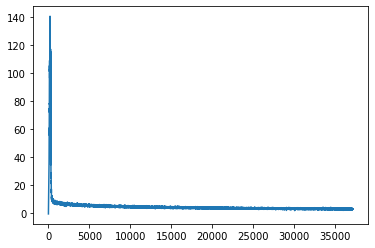

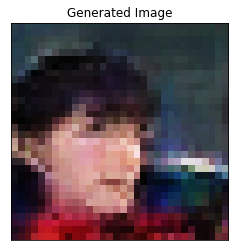

Iteration [35001/100000]......0.198(s) gen: 173.77832 - disc_fake: -173.57036 - disc_real: -170.64831 - disc_real: 2.92205
Iteration [35002/100000]......0.198(s) gen: 173.45264 - disc_fake: -173.23747 - disc_real: -170.19917 - disc_real: 3.03830
Iteration [35003/100000]......0.196(s) gen: 172.60040 - disc_fake: -172.87146 - disc_real: -169.95033 - disc_real: 2.92113
Iteration [35004/100000]......0.198(s) gen: 173.30020 - disc_fake: -172.66046 - disc_real: -169.77895 - disc_real: 2.88152
Iteration [35005/100000]......0.190(s) gen: 173.34277 - disc_fake: -173.20783 - disc_real: -170.44400 - disc_real: 2.76383
Iteration [35006/100000]......0.190(s) gen: 173.60776 - disc_fake: -173.24167 - disc_real: -170.59163 - disc_real: 2.65003
Iteration [35007/100000]......0.192(s) gen: 173.40945 - disc_fake: -173.52983 - disc_real: -170.66016 - disc_real: 2.86967
Iteration [35008/100000]......0.194(s) gen: 173.89215 - disc_fake: -173.79852 - disc_real: -170.87163 - disc_real: 2.92689
Iteration [35009

Iteration [35069/100000]......0.198(s) gen: 173.35396 - disc_fake: -173.38781 - disc_real: -170.54474 - disc_real: 2.84308
Iteration [35070/100000]......0.196(s) gen: 174.15656 - disc_fake: -173.60404 - disc_real: -170.92824 - disc_real: 2.67580
Iteration [35071/100000]......0.197(s) gen: 174.24631 - disc_fake: -174.13248 - disc_real: -171.05890 - disc_real: 3.07358
Iteration [35072/100000]......0.194(s) gen: 174.17484 - disc_fake: -174.35803 - disc_real: -171.20713 - disc_real: 3.15091
Iteration [35073/100000]......0.275(s) gen: 174.95654 - disc_fake: -174.48628 - disc_real: -171.73395 - disc_real: 2.75232
Iteration [35074/100000]......0.192(s) gen: 174.27666 - disc_fake: -174.53078 - disc_real: -171.76617 - disc_real: 2.76461
Iteration [35075/100000]......0.195(s) gen: 173.25842 - disc_fake: -173.74480 - disc_real: -170.98557 - disc_real: 2.75923
Iteration [35076/100000]......0.196(s) gen: 172.95978 - disc_fake: -173.08239 - disc_real: -170.18853 - disc_real: 2.89386
Iteration [35077

Iteration [35136/100000]......0.206(s) gen: 174.06955 - disc_fake: -173.87252 - disc_real: -170.93376 - disc_real: 2.93877
Iteration [35137/100000]......0.208(s) gen: 173.57593 - disc_fake: -173.87169 - disc_real: -170.59979 - disc_real: 3.27190
Iteration [35138/100000]......0.207(s) gen: 173.67294 - disc_fake: -173.72221 - disc_real: -170.42643 - disc_real: 3.29578
Iteration [35139/100000]......0.204(s) gen: 174.14908 - disc_fake: -173.73404 - disc_real: -171.12838 - disc_real: 2.60565
Iteration [35140/100000]......0.201(s) gen: 173.76419 - disc_fake: -173.71727 - disc_real: -170.65994 - disc_real: 3.05733
Iteration [35141/100000]......0.199(s) gen: 174.35452 - disc_fake: -173.85052 - disc_real: -171.10985 - disc_real: 2.74066
Iteration [35142/100000]......0.198(s) gen: 174.01425 - disc_fake: -174.23171 - disc_real: -171.17037 - disc_real: 3.06133
Iteration [35143/100000]......0.198(s) gen: 173.28035 - disc_fake: -173.72569 - disc_real: -170.76263 - disc_real: 2.96307
Iteration [35144

Iteration [35203/100000]......0.200(s) gen: 175.10965 - disc_fake: -175.02336 - disc_real: -171.88211 - disc_real: 3.14125
Iteration [35204/100000]......0.198(s) gen: 174.59741 - disc_fake: -174.84614 - disc_real: -171.79309 - disc_real: 3.05305
Iteration [35205/100000]......0.198(s) gen: 174.32635 - disc_fake: -174.18772 - disc_real: -171.26077 - disc_real: 2.92694
Iteration [35206/100000]......0.196(s) gen: 173.80746 - disc_fake: -174.27411 - disc_real: -171.37969 - disc_real: 2.89442
Iteration [35207/100000]......0.198(s) gen: 173.48996 - disc_fake: -173.90934 - disc_real: -170.44995 - disc_real: 3.45939
Iteration [35208/100000]......0.194(s) gen: 173.61267 - disc_fake: -173.57561 - disc_real: -170.52802 - disc_real: 3.04759
Iteration [35209/100000]......0.195(s) gen: 173.59334 - disc_fake: -173.54751 - disc_real: -170.27934 - disc_real: 3.26817
Iteration [35210/100000]......0.199(s) gen: 173.93423 - disc_fake: -173.64756 - disc_real: -171.00931 - disc_real: 2.63825
Iteration [35211

Iteration [35271/100000]......0.199(s) gen: 173.93692 - disc_fake: -173.59215 - disc_real: -170.81891 - disc_real: 2.77324
Iteration [35272/100000]......0.201(s) gen: 174.36440 - disc_fake: -173.81193 - disc_real: -170.86635 - disc_real: 2.94558
Iteration [35273/100000]......0.207(s) gen: 174.24107 - disc_fake: -174.15389 - disc_real: -171.33927 - disc_real: 2.81462
Iteration [35274/100000]......0.206(s) gen: 174.11578 - disc_fake: -174.18801 - disc_real: -171.52879 - disc_real: 2.65921
Iteration [35275/100000]......0.205(s) gen: 174.59364 - disc_fake: -174.50967 - disc_real: -171.58703 - disc_real: 2.92264
Iteration [35276/100000]......0.204(s) gen: 174.84039 - disc_fake: -174.92291 - disc_real: -171.57068 - disc_real: 3.35222
Iteration [35277/100000]......0.200(s) gen: 174.49753 - disc_fake: -174.46315 - disc_real: -171.69325 - disc_real: 2.76991
Iteration [35278/100000]......0.198(s) gen: 174.36613 - disc_fake: -174.48092 - disc_real: -171.55529 - disc_real: 2.92563
Iteration [35279

Iteration [35338/100000]......0.199(s) gen: 173.60413 - disc_fake: -173.49779 - disc_real: -170.59599 - disc_real: 2.90179
Iteration [35339/100000]......0.197(s) gen: 173.73396 - disc_fake: -173.64781 - disc_real: -170.01082 - disc_real: 3.63699
Iteration [35340/100000]......0.197(s) gen: 173.68140 - disc_fake: -173.28342 - disc_real: -170.37036 - disc_real: 2.91306
Iteration [35341/100000]......0.196(s) gen: 173.79594 - disc_fake: -173.64367 - disc_real: -170.95259 - disc_real: 2.69108
Iteration [35342/100000]......0.199(s) gen: 173.40927 - disc_fake: -173.72095 - disc_real: -170.86469 - disc_real: 2.85626
Iteration [35343/100000]......0.198(s) gen: 174.22964 - disc_fake: -174.01758 - disc_real: -170.98734 - disc_real: 3.03025
Iteration [35344/100000]......0.197(s) gen: 174.41522 - disc_fake: -174.28129 - disc_real: -171.44687 - disc_real: 2.83442
Iteration [35345/100000]......0.196(s) gen: 174.30708 - disc_fake: -173.87084 - disc_real: -171.31670 - disc_real: 2.55414
Iteration [35346

Iteration [35405/100000]......0.197(s) gen: 174.11667 - disc_fake: -174.31371 - disc_real: -171.26911 - disc_real: 3.04460
Iteration [35406/100000]......0.199(s) gen: 173.27719 - disc_fake: -173.40226 - disc_real: -170.35009 - disc_real: 3.05217
Iteration [35407/100000]......0.201(s) gen: 173.35513 - disc_fake: -173.34672 - disc_real: -170.55341 - disc_real: 2.79330
Iteration [35408/100000]......0.201(s) gen: 173.41710 - disc_fake: -173.31781 - disc_real: -170.46132 - disc_real: 2.85649
Iteration [35409/100000]......0.200(s) gen: 173.46214 - disc_fake: -173.11898 - disc_real: -170.41631 - disc_real: 2.70266
Iteration [35410/100000]......0.201(s) gen: 174.23734 - disc_fake: -173.87972 - disc_real: -171.16771 - disc_real: 2.71201
Iteration [35411/100000]......0.200(s) gen: 175.06796 - disc_fake: -174.47495 - disc_real: -171.41019 - disc_real: 3.06475
Iteration [35412/100000]......0.198(s) gen: 175.13632 - disc_fake: -175.12804 - disc_real: -171.97657 - disc_real: 3.15147
Iteration [35413

Iteration [35472/100000]......0.197(s) gen: 174.51817 - disc_fake: -174.58240 - disc_real: -171.71086 - disc_real: 2.87154
Iteration [35473/100000]......0.196(s) gen: 174.78397 - disc_fake: -174.65076 - disc_real: -171.50813 - disc_real: 3.14263
Iteration [35474/100000]......0.199(s) gen: 174.27473 - disc_fake: -174.49053 - disc_real: -171.47273 - disc_real: 3.01780
Iteration [35475/100000]......0.200(s) gen: 173.75494 - disc_fake: -174.19478 - disc_real: -171.21133 - disc_real: 2.98345
Iteration [35476/100000]......0.200(s) gen: 174.25085 - disc_fake: -173.88517 - disc_real: -170.97890 - disc_real: 2.90627
Iteration [35477/100000]......0.197(s) gen: 174.33662 - disc_fake: -174.17542 - disc_real: -171.06835 - disc_real: 3.10707
Iteration [35478/100000]......0.196(s) gen: 173.75589 - disc_fake: -174.06528 - disc_real: -170.52843 - disc_real: 3.53685
Iteration [35479/100000]......0.195(s) gen: 173.25084 - disc_fake: -173.17385 - disc_real: -170.40822 - disc_real: 2.76563
Iteration [35480

Iteration [35540/100000]......0.199(s) gen: 174.21512 - disc_fake: -174.90654 - disc_real: -171.64248 - disc_real: 3.26406
Iteration [35541/100000]......0.198(s) gen: 174.19266 - disc_fake: -173.89319 - disc_real: -171.17921 - disc_real: 2.71398
Iteration [35542/100000]......0.199(s) gen: 174.18451 - disc_fake: -173.86006 - disc_real: -170.80508 - disc_real: 3.05498
Iteration [35543/100000]......0.199(s) gen: 173.86780 - disc_fake: -173.74956 - disc_real: -170.77271 - disc_real: 2.97685
Iteration [35544/100000]......0.200(s) gen: 174.18352 - disc_fake: -174.14509 - disc_real: -171.31546 - disc_real: 2.82962
Iteration [35545/100000]......0.200(s) gen: 174.58015 - disc_fake: -174.38565 - disc_real: -171.72720 - disc_real: 2.65845
Iteration [35546/100000]......0.203(s) gen: 174.99677 - disc_fake: -174.91709 - disc_real: -171.83846 - disc_real: 3.07863
Iteration [35547/100000]......0.204(s) gen: 175.17001 - disc_fake: -174.90273 - disc_real: -171.98329 - disc_real: 2.91944
Iteration [35548

Iteration [35607/100000]......0.206(s) gen: 174.41281 - disc_fake: -174.74119 - disc_real: -171.34607 - disc_real: 3.39512
Iteration [35608/100000]......0.207(s) gen: 175.16336 - disc_fake: -174.63420 - disc_real: -171.86094 - disc_real: 2.77326
Iteration [35609/100000]......0.206(s) gen: 175.19711 - disc_fake: -175.16700 - disc_real: -172.30196 - disc_real: 2.86504
Iteration [35610/100000]......0.204(s) gen: 174.92365 - disc_fake: -174.93377 - disc_real: -172.03065 - disc_real: 2.90313
Iteration [35611/100000]......0.204(s) gen: 175.53790 - disc_fake: -175.32196 - disc_real: -172.44533 - disc_real: 2.87663
Iteration [35612/100000]......0.200(s) gen: 174.65875 - disc_fake: -175.20812 - disc_real: -171.87801 - disc_real: 3.33011
Iteration [35613/100000]......0.201(s) gen: 174.60579 - disc_fake: -174.59678 - disc_real: -171.41657 - disc_real: 3.18021
Iteration [35614/100000]......0.197(s) gen: 175.03029 - disc_fake: -174.44856 - disc_real: -171.35923 - disc_real: 3.08933
Iteration [35615

Iteration [35674/100000]......0.202(s) gen: 175.94537 - disc_fake: -175.83256 - disc_real: -172.79914 - disc_real: 3.03343
Iteration [35675/100000]......0.201(s) gen: 175.71999 - disc_fake: -175.92389 - disc_real: -172.87986 - disc_real: 3.04403
Iteration [35676/100000]......0.200(s) gen: 175.65128 - disc_fake: -175.54965 - disc_real: -172.59206 - disc_real: 2.95759
Iteration [35677/100000]......0.200(s) gen: 175.34372 - disc_fake: -175.18545 - disc_real: -172.40478 - disc_real: 2.78066
Iteration [35678/100000]......0.203(s) gen: 175.08481 - disc_fake: -175.00615 - disc_real: -172.04922 - disc_real: 2.95693
Iteration [35679/100000]......0.204(s) gen: 174.20787 - disc_fake: -174.68979 - disc_real: -171.66783 - disc_real: 3.02196
Iteration [35680/100000]......0.202(s) gen: 173.84608 - disc_fake: -174.07617 - disc_real: -171.08826 - disc_real: 2.98791
Iteration [35681/100000]......0.202(s) gen: 174.67139 - disc_fake: -174.23734 - disc_real: -171.48052 - disc_real: 2.75682
Iteration [35682

Iteration [35741/100000]......0.196(s) gen: 174.43661 - disc_fake: -174.37928 - disc_real: -171.64076 - disc_real: 2.73852
Iteration [35742/100000]......0.196(s) gen: 173.87927 - disc_fake: -174.24164 - disc_real: -171.07697 - disc_real: 3.16468
Iteration [35743/100000]......0.194(s) gen: 174.87067 - disc_fake: -174.17444 - disc_real: -171.40491 - disc_real: 2.76953
Iteration [35744/100000]......0.194(s) gen: 175.92570 - disc_fake: -175.18685 - disc_real: -172.17253 - disc_real: 3.01432
Iteration [35745/100000]......0.195(s) gen: 176.07256 - disc_fake: -175.68731 - disc_real: -172.82035 - disc_real: 2.86696
Iteration [35746/100000]......0.197(s) gen: 176.03676 - disc_fake: -175.97045 - disc_real: -172.78302 - disc_real: 3.18743
Iteration [35747/100000]......0.198(s) gen: 175.37357 - disc_fake: -175.88158 - disc_real: -172.71068 - disc_real: 3.17090
Iteration [35748/100000]......0.199(s) gen: 175.41782 - disc_fake: -175.62564 - disc_real: -172.50490 - disc_real: 3.12075
Iteration [35749

Iteration [35808/100000]......0.201(s) gen: 174.56003 - disc_fake: -174.79460 - disc_real: -171.93191 - disc_real: 2.86269
Iteration [35809/100000]......0.200(s) gen: 174.29814 - disc_fake: -174.49247 - disc_real: -171.53331 - disc_real: 2.95916
Iteration [35810/100000]......0.198(s) gen: 174.45076 - disc_fake: -174.28971 - disc_real: -171.08955 - disc_real: 3.20016
Iteration [35811/100000]......0.196(s) gen: 174.23627 - disc_fake: -174.09877 - disc_real: -171.10655 - disc_real: 2.99222
Iteration [35812/100000]......0.197(s) gen: 174.13885 - disc_fake: -174.35715 - disc_real: -171.22592 - disc_real: 3.13123
Iteration [35813/100000]......0.196(s) gen: 174.51755 - disc_fake: -174.09290 - disc_real: -171.44920 - disc_real: 2.64370
Iteration [35814/100000]......0.196(s) gen: 174.81030 - disc_fake: -174.44110 - disc_real: -171.36332 - disc_real: 3.07778
Iteration [35815/100000]......0.196(s) gen: 174.99306 - disc_fake: -174.70662 - disc_real: -171.47371 - disc_real: 3.23291
Iteration [35816

Iteration [35876/100000]......0.196(s) gen: 174.61093 - disc_fake: -174.49316 - disc_real: -171.27299 - disc_real: 3.22017
Iteration [35877/100000]......0.198(s) gen: 174.60825 - disc_fake: -174.52094 - disc_real: -171.91927 - disc_real: 2.60168
Iteration [35878/100000]......0.216(s) gen: 174.67238 - disc_fake: -174.58322 - disc_real: -171.85421 - disc_real: 2.72901
Iteration [35879/100000]......0.196(s) gen: 175.81296 - disc_fake: -174.81946 - disc_real: -172.21618 - disc_real: 2.60328
Iteration [35880/100000]......0.198(s) gen: 176.33138 - disc_fake: -175.45404 - disc_real: -172.80309 - disc_real: 2.65095
Iteration [35881/100000]......0.199(s) gen: 176.09338 - disc_fake: -175.99492 - disc_real: -173.11682 - disc_real: 2.87810
Iteration [35882/100000]......0.201(s) gen: 175.36249 - disc_fake: -175.82876 - disc_real: -172.70273 - disc_real: 3.12603
Iteration [35883/100000]......0.202(s) gen: 175.14204 - disc_fake: -175.36556 - disc_real: -172.01026 - disc_real: 3.35530
Iteration [35884

Iteration [35943/100000]......0.198(s) gen: 175.31030 - disc_fake: -175.73131 - disc_real: -173.01909 - disc_real: 2.71223
Iteration [35944/100000]......0.196(s) gen: 175.04407 - disc_fake: -175.25372 - disc_real: -172.54149 - disc_real: 2.71223
Iteration [35945/100000]......0.195(s) gen: 174.69150 - disc_fake: -174.98041 - disc_real: -172.19502 - disc_real: 2.78539
Iteration [35946/100000]......0.196(s) gen: 174.94312 - disc_fake: -174.91906 - disc_real: -171.81838 - disc_real: 3.10068
Iteration [35947/100000]......0.197(s) gen: 175.00902 - disc_fake: -174.89405 - disc_real: -171.88601 - disc_real: 3.00804
Iteration [35948/100000]......0.199(s) gen: 174.82875 - disc_fake: -175.03195 - disc_real: -172.14112 - disc_real: 2.89082
Iteration [35949/100000]......0.200(s) gen: 175.26869 - disc_fake: -174.98915 - disc_real: -171.93739 - disc_real: 3.05175
Iteration [35950/100000]......0.201(s) gen: 175.72444 - disc_fake: -175.23011 - disc_real: -172.44123 - disc_real: 2.78887
Iteration [35951

Iteration [36010/100000]......0.206(s) gen: 176.18770 - disc_fake: -176.67237 - disc_real: -173.80799 - disc_real: 2.86438
Iteration [36011/100000]......0.211(s) gen: 176.33200 - disc_fake: -176.29185 - disc_real: -173.41904 - disc_real: 2.87281
Iteration [36012/100000]......0.203(s) gen: 176.07492 - disc_fake: -176.18659 - disc_real: -173.39650 - disc_real: 2.79009
Iteration [36013/100000]......0.201(s) gen: 175.26912 - disc_fake: -175.84360 - disc_real: -172.78032 - disc_real: 3.06328
Iteration [36014/100000]......0.202(s) gen: 175.20883 - disc_fake: -175.33515 - disc_real: -172.33340 - disc_real: 3.00176
Iteration [36015/100000]......0.198(s) gen: 174.68843 - disc_fake: -175.16328 - disc_real: -171.94835 - disc_real: 3.21494
Iteration [36016/100000]......0.200(s) gen: 174.73454 - disc_fake: -174.58329 - disc_real: -171.30057 - disc_real: 3.28272
Iteration [36017/100000]......0.199(s) gen: 174.84695 - disc_fake: -175.17734 - disc_real: -171.75054 - disc_real: 3.42680
Iteration [36018

Iteration [36077/100000]......0.196(s) gen: 175.61896 - disc_fake: -175.41819 - disc_real: -172.52169 - disc_real: 2.89650
Iteration [36078/100000]......0.195(s) gen: 175.60074 - disc_fake: -175.62479 - disc_real: -172.79502 - disc_real: 2.82977
Iteration [36079/100000]......0.205(s) gen: 176.23299 - disc_fake: -175.85772 - disc_real: -173.11273 - disc_real: 2.74500
Iteration [36080/100000]......0.196(s) gen: 176.28116 - disc_fake: -176.18025 - disc_real: -173.68599 - disc_real: 2.49427
Iteration [36081/100000]......0.195(s) gen: 176.12135 - disc_fake: -176.18027 - disc_real: -173.20229 - disc_real: 2.97798
Iteration [36082/100000]......0.197(s) gen: 176.11578 - disc_fake: -176.11853 - disc_real: -173.34193 - disc_real: 2.77660
Iteration [36083/100000]......0.197(s) gen: 176.13416 - disc_fake: -176.15371 - disc_real: -173.17344 - disc_real: 2.98027
Iteration [36084/100000]......0.196(s) gen: 176.68265 - disc_fake: -176.30580 - disc_real: -173.22133 - disc_real: 3.08446
Iteration [36085

Iteration [36145/100000]......0.197(s) gen: 176.18037 - disc_fake: -175.91021 - disc_real: -172.63526 - disc_real: 3.27495
Iteration [36146/100000]......0.199(s) gen: 176.06790 - disc_fake: -176.00805 - disc_real: -173.15719 - disc_real: 2.85086
Iteration [36147/100000]......0.201(s) gen: 176.03516 - disc_fake: -176.02019 - disc_real: -173.11190 - disc_real: 2.90828
Iteration [36148/100000]......0.201(s) gen: 175.99260 - disc_fake: -175.66940 - disc_real: -172.99722 - disc_real: 2.67217
Iteration [36149/100000]......0.201(s) gen: 175.59920 - disc_fake: -175.59321 - disc_real: -172.85440 - disc_real: 2.73881
Iteration [36150/100000]......0.202(s) gen: 175.97098 - disc_fake: -176.09048 - disc_real: -173.26670 - disc_real: 2.82378
Iteration [36151/100000]......0.200(s) gen: 176.31615 - disc_fake: -176.24909 - disc_real: -173.42557 - disc_real: 2.82352
Iteration [36152/100000]......0.202(s) gen: 176.02573 - disc_fake: -176.24482 - disc_real: -173.19360 - disc_real: 3.05122
Iteration [36153

Iteration [36213/100000]......0.195(s) gen: 176.62555 - disc_fake: -176.37267 - disc_real: -173.74344 - disc_real: 2.62923
Iteration [36214/100000]......0.194(s) gen: 176.72734 - disc_fake: -176.60004 - disc_real: -173.65432 - disc_real: 2.94572
Iteration [36215/100000]......0.195(s) gen: 176.68127 - disc_fake: -176.75768 - disc_real: -173.83464 - disc_real: 2.92304
Iteration [36216/100000]......0.196(s) gen: 176.53543 - disc_fake: -176.60434 - disc_real: -173.55586 - disc_real: 3.04848
Iteration [36217/100000]......0.198(s) gen: 176.61551 - disc_fake: -176.73094 - disc_real: -174.06011 - disc_real: 2.67083
Iteration [36218/100000]......0.200(s) gen: 176.57086 - disc_fake: -176.55162 - disc_real: -173.78795 - disc_real: 2.76367
Iteration [36219/100000]......0.200(s) gen: 176.77296 - disc_fake: -176.70218 - disc_real: -173.88469 - disc_real: 2.81749
Iteration [36220/100000]......0.200(s) gen: 177.02698 - disc_fake: -176.75207 - disc_real: -174.10818 - disc_real: 2.64389
Iteration [36221

Iteration [36280/100000]......0.196(s) gen: 176.53015 - disc_fake: -176.50449 - disc_real: -173.75546 - disc_real: 2.74903
Iteration [36281/100000]......0.196(s) gen: 177.23186 - disc_fake: -176.74532 - disc_real: -174.20396 - disc_real: 2.54136
Iteration [36282/100000]......0.196(s) gen: 177.28746 - disc_fake: -176.74626 - disc_real: -174.30625 - disc_real: 2.44001
Iteration [36283/100000]......0.196(s) gen: 177.56064 - disc_fake: -177.43830 - disc_real: -174.41759 - disc_real: 3.02071
Iteration [36284/100000]......0.195(s) gen: 177.09253 - disc_fake: -177.12765 - disc_real: -174.27031 - disc_real: 2.85733
Iteration [36285/100000]......0.196(s) gen: 177.48840 - disc_fake: -177.20900 - disc_real: -174.46963 - disc_real: 2.73937
Iteration [36286/100000]......0.197(s) gen: 176.98769 - disc_fake: -177.29492 - disc_real: -174.48835 - disc_real: 2.80657
Iteration [36287/100000]......0.195(s) gen: 176.68178 - disc_fake: -176.32831 - disc_real: -173.45117 - disc_real: 2.87714
Iteration [36288

Iteration [36348/100000]......0.197(s) gen: 176.11745 - disc_fake: -176.01041 - disc_real: -173.26390 - disc_real: 2.74651
Iteration [36349/100000]......0.196(s) gen: 176.55859 - disc_fake: -176.20292 - disc_real: -173.25762 - disc_real: 2.94531
Iteration [36350/100000]......0.199(s) gen: 176.70055 - disc_fake: -176.32067 - disc_real: -173.56906 - disc_real: 2.75161
Iteration [36351/100000]......0.199(s) gen: 176.27693 - disc_fake: -176.32331 - disc_real: -173.22221 - disc_real: 3.10110
Iteration [36352/100000]......0.291(s) gen: 177.19263 - disc_fake: -176.26436 - disc_real: -173.52656 - disc_real: 2.73780
Iteration [36353/100000]......0.197(s) gen: 176.86450 - disc_fake: -176.86870 - disc_real: -174.06194 - disc_real: 2.80676
Iteration [36354/100000]......0.198(s) gen: 176.91425 - disc_fake: -176.90404 - disc_real: -174.10260 - disc_real: 2.80144
Iteration [36355/100000]......0.200(s) gen: 177.03683 - disc_fake: -176.84524 - disc_real: -174.21500 - disc_real: 2.63024
Iteration [36356

Iteration [36415/100000]......0.201(s) gen: 177.54871 - disc_fake: -176.85715 - disc_real: -174.20113 - disc_real: 2.65602
Iteration [36416/100000]......0.202(s) gen: 177.87363 - disc_fake: -177.41019 - disc_real: -174.49570 - disc_real: 2.91449
Iteration [36417/100000]......0.205(s) gen: 177.65552 - disc_fake: -178.04003 - disc_real: -174.75395 - disc_real: 3.28608
Iteration [36418/100000]......0.202(s) gen: 178.05020 - disc_fake: -177.75050 - disc_real: -175.05011 - disc_real: 2.70039
Iteration [36419/100000]......0.204(s) gen: 177.71078 - disc_fake: -177.92108 - disc_real: -174.67607 - disc_real: 3.24500
Iteration [36420/100000]......0.204(s) gen: 177.54794 - disc_fake: -177.49973 - disc_real: -174.55799 - disc_real: 2.94174
Iteration [36421/100000]......0.207(s) gen: 176.93900 - disc_fake: -177.04128 - disc_real: -173.91689 - disc_real: 3.12439
Iteration [36422/100000]......0.208(s) gen: 176.09164 - disc_fake: -176.76187 - disc_real: -173.54132 - disc_real: 3.22055
Iteration [36423

Iteration [36482/100000]......0.213(s) gen: 176.76387 - disc_fake: -177.00060 - disc_real: -174.19944 - disc_real: 2.80116
Iteration [36483/100000]......0.208(s) gen: 176.16251 - disc_fake: -176.40886 - disc_real: -172.85630 - disc_real: 3.55256
Iteration [36484/100000]......0.206(s) gen: 175.58047 - disc_fake: -175.79245 - disc_real: -172.79629 - disc_real: 2.99616
Iteration [36485/100000]......0.204(s) gen: 176.01117 - disc_fake: -175.77651 - disc_real: -172.72541 - disc_real: 3.05110
Iteration [36486/100000]......0.205(s) gen: 176.83203 - disc_fake: -176.00187 - disc_real: -173.34559 - disc_real: 2.65628
Iteration [36487/100000]......0.204(s) gen: 176.47659 - disc_fake: -176.60829 - disc_real: -173.61633 - disc_real: 2.99196
Iteration [36488/100000]......0.200(s) gen: 176.53311 - disc_fake: -176.50924 - disc_real: -173.63644 - disc_real: 2.87280
Iteration [36489/100000]......0.199(s) gen: 176.91760 - disc_fake: -176.80747 - disc_real: -174.01735 - disc_real: 2.79012
Iteration [36490

Iteration [36549/100000]......0.199(s) gen: 176.40088 - disc_fake: -176.08688 - disc_real: -173.06024 - disc_real: 3.02664
Iteration [36550/100000]......0.197(s) gen: 176.95554 - disc_fake: -176.39567 - disc_real: -173.69880 - disc_real: 2.69687
Iteration [36551/100000]......0.199(s) gen: 177.23495 - disc_fake: -177.26031 - disc_real: -174.35255 - disc_real: 2.90776
Iteration [36552/100000]......0.197(s) gen: 177.29808 - disc_fake: -177.22950 - disc_real: -174.22217 - disc_real: 3.00733
Iteration [36553/100000]......0.196(s) gen: 176.13200 - disc_fake: -176.98612 - disc_real: -173.80758 - disc_real: 3.17854
Iteration [36554/100000]......0.195(s) gen: 176.06015 - disc_fake: -176.10587 - disc_real: -173.00801 - disc_real: 3.09786
Iteration [36555/100000]......0.195(s) gen: 176.15561 - disc_fake: -175.69470 - disc_real: -172.82006 - disc_real: 2.87464
Iteration [36556/100000]......0.196(s) gen: 176.50046 - disc_fake: -176.34427 - disc_real: -174.01996 - disc_real: 2.32431
Iteration [36557

Iteration [36616/100000]......0.200(s) gen: 176.08562 - disc_fake: -176.53741 - disc_real: -173.01460 - disc_real: 3.52281
Iteration [36617/100000]......0.196(s) gen: 176.27379 - disc_fake: -175.76980 - disc_real: -173.17602 - disc_real: 2.59378
Iteration [36618/100000]......0.199(s) gen: 176.01202 - disc_fake: -176.12862 - disc_real: -173.58567 - disc_real: 2.54295
Iteration [36619/100000]......0.200(s) gen: 175.72595 - disc_fake: -175.88042 - disc_real: -173.09489 - disc_real: 2.78553
Iteration [36620/100000]......0.200(s) gen: 175.83298 - disc_fake: -175.76287 - disc_real: -172.90013 - disc_real: 2.86274
Iteration [36621/100000]......0.200(s) gen: 175.83534 - disc_fake: -175.56679 - disc_real: -172.05763 - disc_real: 3.50916
Iteration [36622/100000]......0.199(s) gen: 176.25403 - disc_fake: -175.78550 - disc_real: -172.77928 - disc_real: 3.00623
Iteration [36623/100000]......0.200(s) gen: 175.45168 - disc_fake: -175.98052 - disc_real: -172.85279 - disc_real: 3.12773
Iteration [36624

Iteration [36683/100000]......0.198(s) gen: 176.35834 - disc_fake: -176.47437 - disc_real: -173.26948 - disc_real: 3.20489
Iteration [36684/100000]......0.197(s) gen: 176.15326 - disc_fake: -176.17293 - disc_real: -172.70402 - disc_real: 3.46891
Iteration [36685/100000]......0.197(s) gen: 175.94272 - disc_fake: -175.68569 - disc_real: -172.90342 - disc_real: 2.78227
Iteration [36686/100000]......0.195(s) gen: 175.75616 - disc_fake: -175.79160 - disc_real: -172.89233 - disc_real: 2.89927
Iteration [36687/100000]......0.198(s) gen: 176.52124 - disc_fake: -176.14196 - disc_real: -173.41083 - disc_real: 2.73114
Iteration [36688/100000]......0.198(s) gen: 176.58743 - disc_fake: -176.61034 - disc_real: -173.64991 - disc_real: 2.96043
Iteration [36689/100000]......0.201(s) gen: 177.31105 - disc_fake: -176.64534 - disc_real: -174.25637 - disc_real: 2.38897
Iteration [36690/100000]......0.200(s) gen: 178.14697 - disc_fake: -177.63248 - disc_real: -174.98590 - disc_real: 2.64657
Iteration [36691

Iteration [36750/100000]......0.196(s) gen: 176.97221 - disc_fake: -176.52170 - disc_real: -173.90396 - disc_real: 2.61773
Iteration [36751/100000]......0.197(s) gen: 177.44891 - disc_fake: -176.92798 - disc_real: -174.33033 - disc_real: 2.59766
Iteration [36752/100000]......0.195(s) gen: 177.73088 - disc_fake: -177.79526 - disc_real: -174.99664 - disc_real: 2.79862
Iteration [36753/100000]......0.198(s) gen: 178.06888 - disc_fake: -178.10693 - disc_real: -175.35202 - disc_real: 2.75492
Iteration [36754/100000]......0.196(s) gen: 177.94971 - disc_fake: -178.18905 - disc_real: -175.26575 - disc_real: 2.92330
Iteration [36755/100000]......0.198(s) gen: 177.66447 - disc_fake: -177.69081 - disc_real: -174.81634 - disc_real: 2.87447
Iteration [36756/100000]......0.199(s) gen: 177.68484 - disc_fake: -177.72750 - disc_real: -174.79899 - disc_real: 2.92851
Iteration [36757/100000]......0.193(s) gen: 176.92531 - disc_fake: -177.29648 - disc_real: -174.46982 - disc_real: 2.82666
Iteration [36758

Iteration [36818/100000]......0.196(s) gen: 177.83183 - disc_fake: -178.14197 - disc_real: -175.13049 - disc_real: 3.01149
Iteration [36819/100000]......0.197(s) gen: 177.60045 - disc_fake: -177.64249 - disc_real: -174.84592 - disc_real: 2.79657
Iteration [36820/100000]......0.196(s) gen: 177.82513 - disc_fake: -177.44607 - disc_real: -175.23080 - disc_real: 2.21527
Iteration [36821/100000]......0.198(s) gen: 177.25919 - disc_fake: -177.55073 - disc_real: -174.71282 - disc_real: 2.83791
Iteration [36822/100000]......0.200(s) gen: 176.69058 - disc_fake: -177.07022 - disc_real: -174.19254 - disc_real: 2.87768
Iteration [36823/100000]......0.200(s) gen: 176.91983 - disc_fake: -176.68974 - disc_real: -173.90615 - disc_real: 2.78359
Iteration [36824/100000]......0.201(s) gen: 176.63124 - disc_fake: -176.84195 - disc_real: -173.86857 - disc_real: 2.97338
Iteration [36825/100000]......0.199(s) gen: 177.43953 - disc_fake: -176.91507 - disc_real: -173.66020 - disc_real: 3.25488
Iteration [36826

Iteration [36886/100000]......0.197(s) gen: 177.06561 - disc_fake: -176.78624 - disc_real: -174.07290 - disc_real: 2.71334
Iteration [36887/100000]......0.195(s) gen: 177.65808 - disc_fake: -177.25606 - disc_real: -174.32585 - disc_real: 2.93021
Iteration [36888/100000]......0.198(s) gen: 177.85719 - disc_fake: -177.89699 - disc_real: -175.06590 - disc_real: 2.83109
Iteration [36889/100000]......0.201(s) gen: 178.01364 - disc_fake: -177.86005 - disc_real: -175.03879 - disc_real: 2.82125
Iteration [36890/100000]......0.205(s) gen: 177.13547 - disc_fake: -177.41306 - disc_real: -174.93652 - disc_real: 2.47654
Iteration [36891/100000]......0.205(s) gen: 177.51340 - disc_fake: -177.02322 - disc_real: -174.33235 - disc_real: 2.69087
Iteration [36892/100000]......0.207(s) gen: 177.31552 - disc_fake: -177.53053 - disc_real: -174.51196 - disc_real: 3.01857
Iteration [36893/100000]......0.205(s) gen: 177.29507 - disc_fake: -177.31924 - disc_real: -174.39752 - disc_real: 2.92172
Iteration [36894

Iteration [36953/100000]......0.196(s) gen: 177.02209 - disc_fake: -177.24016 - disc_real: -174.08011 - disc_real: 3.16004
Iteration [36954/100000]......0.195(s) gen: 176.70551 - disc_fake: -176.73396 - disc_real: -173.62926 - disc_real: 3.10470
Iteration [36955/100000]......0.194(s) gen: 176.86411 - disc_fake: -176.68359 - disc_real: -173.71956 - disc_real: 2.96403
Iteration [36956/100000]......0.196(s) gen: 177.13803 - disc_fake: -177.07727 - disc_real: -174.33812 - disc_real: 2.73915
Iteration [36957/100000]......0.195(s) gen: 177.08502 - disc_fake: -177.33189 - disc_real: -174.42010 - disc_real: 2.91180
Iteration [36958/100000]......0.195(s) gen: 177.05270 - disc_fake: -177.10638 - disc_real: -174.12824 - disc_real: 2.97813
Iteration [36959/100000]......0.194(s) gen: 177.65225 - disc_fake: -177.20941 - disc_real: -174.35573 - disc_real: 2.85367
Iteration [36960/100000]......0.195(s) gen: 177.10297 - disc_fake: -177.19658 - disc_real: -174.73001 - disc_real: 2.46656
Iteration [36961

Iteration [37020/100000]......0.194(s) gen: 177.05371 - disc_fake: -177.24540 - disc_real: -174.47411 - disc_real: 2.77129
Iteration [37021/100000]......0.195(s) gen: 176.96951 - disc_fake: -176.73938 - disc_real: -174.31034 - disc_real: 2.42904
Iteration [37022/100000]......0.195(s) gen: 176.65637 - disc_fake: -176.83416 - disc_real: -173.87873 - disc_real: 2.95544
Iteration [37023/100000]......0.195(s) gen: 177.15224 - disc_fake: -176.74868 - disc_real: -174.14376 - disc_real: 2.60493
Iteration [37024/100000]......0.197(s) gen: 177.57928 - disc_fake: -177.02406 - disc_real: -174.21844 - disc_real: 2.80562
Iteration [37025/100000]......0.195(s) gen: 177.12659 - disc_fake: -177.16592 - disc_real: -174.68835 - disc_real: 2.47757
Iteration [37026/100000]......0.198(s) gen: 177.71681 - disc_fake: -177.41011 - disc_real: -174.61578 - disc_real: 2.79433
Iteration [37027/100000]......0.198(s) gen: 178.10487 - disc_fake: -177.67660 - disc_real: -174.53607 - disc_real: 3.14052
Iteration [37028

Iteration [37087/100000]......0.203(s) gen: 177.13840 - disc_fake: -178.27611 - disc_real: -174.92872 - disc_real: 3.34740
Iteration [37088/100000]......0.202(s) gen: 177.51756 - disc_fake: -177.02863 - disc_real: -174.92146 - disc_real: 2.10717
Iteration [37089/100000]......0.200(s) gen: 177.00008 - disc_fake: -177.33127 - disc_real: -174.72375 - disc_real: 2.60752
Iteration [37090/100000]......0.199(s) gen: 176.88162 - disc_fake: -176.85626 - disc_real: -173.94041 - disc_real: 2.91586
Iteration [37091/100000]......0.196(s) gen: 177.71664 - disc_fake: -177.55097 - disc_real: -174.15859 - disc_real: 3.39239
Iteration [37092/100000]......0.195(s) gen: 177.21005 - disc_fake: -177.16249 - disc_real: -174.21932 - disc_real: 2.94317
Iteration [37093/100000]......0.198(s) gen: 176.58379 - disc_fake: -176.94204 - disc_real: -174.19333 - disc_real: 2.74871
Iteration [37094/100000]......0.200(s) gen: 177.23457 - disc_fake: -176.97693 - disc_real: -174.05311 - disc_real: 2.92382
Iteration [37095

Iteration [37155/100000]......0.197(s) gen: 178.27736 - disc_fake: -178.38080 - disc_real: -175.24644 - disc_real: 3.13436
Iteration [37156/100000]......0.197(s) gen: 178.01437 - disc_fake: -178.22628 - disc_real: -175.47740 - disc_real: 2.74888
Iteration [37157/100000]......0.200(s) gen: 178.36636 - disc_fake: -178.01137 - disc_real: -175.28950 - disc_real: 2.72187
Iteration [37158/100000]......0.201(s) gen: 177.73486 - disc_fake: -178.09653 - disc_real: -175.16313 - disc_real: 2.93340
Iteration [37159/100000]......0.201(s) gen: 178.22275 - disc_fake: -177.84358 - disc_real: -175.04169 - disc_real: 2.80189
Iteration [37160/100000]......0.202(s) gen: 178.15955 - disc_fake: -178.20264 - disc_real: -175.39436 - disc_real: 2.80828
Iteration [37161/100000]......0.203(s) gen: 177.81979 - disc_fake: -177.83025 - disc_real: -175.10530 - disc_real: 2.72494
Iteration [37162/100000]......0.205(s) gen: 177.98227 - disc_fake: -177.59695 - disc_real: -174.89688 - disc_real: 2.70007
Iteration [37163

Iteration [37222/100000]......0.197(s) gen: 178.56984 - disc_fake: -178.09426 - disc_real: -175.67197 - disc_real: 2.42229
Iteration [37223/100000]......0.197(s) gen: 178.58844 - disc_fake: -178.76639 - disc_real: -175.60434 - disc_real: 3.16205
Iteration [37224/100000]......0.196(s) gen: 178.61310 - disc_fake: -178.33297 - disc_real: -175.73110 - disc_real: 2.60188
Iteration [37225/100000]......0.195(s) gen: 178.69894 - disc_fake: -178.65066 - disc_real: -176.15262 - disc_real: 2.49804
Iteration [37226/100000]......0.197(s) gen: 178.41208 - disc_fake: -178.42130 - disc_real: -175.41867 - disc_real: 3.00263
Iteration [37227/100000]......0.197(s) gen: 178.15314 - disc_fake: -178.18117 - disc_real: -175.50753 - disc_real: 2.67364
Iteration [37228/100000]......0.198(s) gen: 178.33865 - disc_fake: -178.20048 - disc_real: -174.85297 - disc_real: 3.34752
Iteration [37229/100000]......0.201(s) gen: 178.57318 - disc_fake: -178.03601 - disc_real: -175.47475 - disc_real: 2.56127
Iteration [37230

Iteration [37290/100000]......0.198(s) gen: 178.91557 - disc_fake: -178.61339 - disc_real: -175.94951 - disc_real: 2.66388
Iteration [37291/100000]......0.200(s) gen: 179.20317 - disc_fake: -179.09535 - disc_real: -176.21403 - disc_real: 2.88132
Iteration [37292/100000]......0.200(s) gen: 179.11795 - disc_fake: -179.01139 - disc_real: -176.39649 - disc_real: 2.61490
Iteration [37293/100000]......0.199(s) gen: 179.05984 - disc_fake: -179.03235 - disc_real: -176.18499 - disc_real: 2.84736
Iteration [37294/100000]......0.198(s) gen: 179.46191 - disc_fake: -179.15246 - disc_real: -176.34770 - disc_real: 2.80476
Iteration [37295/100000]......0.196(s) gen: 179.63498 - disc_fake: -179.25665 - disc_real: -176.54684 - disc_real: 2.70980
Iteration [37296/100000]......0.198(s) gen: 179.46284 - disc_fake: -179.51196 - disc_real: -176.86603 - disc_real: 2.64593
Iteration [37297/100000]......0.196(s) gen: 179.50027 - disc_fake: -179.55680 - disc_real: -176.42032 - disc_real: 3.13648
Iteration [37298

Iteration [37357/100000]......0.196(s) gen: 179.01541 - disc_fake: -178.99855 - disc_real: -176.34786 - disc_real: 2.65069
Iteration [37358/100000]......0.196(s) gen: 178.52522 - disc_fake: -178.57093 - disc_real: -176.17382 - disc_real: 2.39711
Iteration [37359/100000]......0.197(s) gen: 179.36270 - disc_fake: -178.65257 - disc_real: -175.93120 - disc_real: 2.72137
Iteration [37360/100000]......0.195(s) gen: 178.95686 - disc_fake: -179.28118 - disc_real: -176.74698 - disc_real: 2.53420
Iteration [37361/100000]......0.195(s) gen: 179.25824 - disc_fake: -179.28005 - disc_real: -176.30340 - disc_real: 2.97665
Iteration [37362/100000]......0.194(s) gen: 178.82539 - disc_fake: -178.91902 - disc_real: -176.21240 - disc_real: 2.70662
Iteration [37363/100000]......0.195(s) gen: 177.90616 - disc_fake: -178.38485 - disc_real: -175.31654 - disc_real: 3.06830
Iteration [37364/100000]......0.195(s) gen: 178.10352 - disc_fake: -177.72610 - disc_real: -174.97368 - disc_real: 2.75241
Iteration [37365

Iteration [37424/100000]......0.204(s) gen: 178.48181 - disc_fake: -178.79343 - disc_real: -175.83506 - disc_real: 2.95837
Iteration [37425/100000]......0.202(s) gen: 178.90250 - disc_fake: -178.58484 - disc_real: -176.09023 - disc_real: 2.49460
Iteration [37426/100000]......0.201(s) gen: 179.33940 - disc_fake: -179.04409 - disc_real: -176.36489 - disc_real: 2.67921
Iteration [37427/100000]......0.200(s) gen: 179.55121 - disc_fake: -179.53113 - disc_real: -176.51110 - disc_real: 3.02003
Iteration [37428/100000]......0.198(s) gen: 180.05621 - disc_fake: -179.79027 - disc_real: -177.13434 - disc_real: 2.65593
Iteration [37429/100000]......0.196(s) gen: 179.34467 - disc_fake: -179.63364 - disc_real: -176.79675 - disc_real: 2.83689
Iteration [37430/100000]......0.196(s) gen: 179.18164 - disc_fake: -179.18261 - disc_real: -176.44534 - disc_real: 2.73727
Iteration [37431/100000]......0.197(s) gen: 179.22397 - disc_fake: -179.10663 - disc_real: -176.66499 - disc_real: 2.44164
Iteration [37432

Iteration [37491/100000]......0.196(s) gen: 178.40570 - disc_fake: -178.27155 - disc_real: -175.53408 - disc_real: 2.73748
Iteration [37492/100000]......0.203(s) gen: 178.49419 - disc_fake: -178.10557 - disc_real: -175.11525 - disc_real: 2.99032
Iteration [37493/100000]......0.199(s) gen: 178.64555 - disc_fake: -178.41419 - disc_real: -175.39129 - disc_real: 3.02290
Iteration [37494/100000]......0.199(s) gen: 178.92654 - disc_fake: -178.49980 - disc_real: -175.44879 - disc_real: 3.05101
Iteration [37495/100000]......0.203(s) gen: 179.35016 - disc_fake: -178.91294 - disc_real: -175.57158 - disc_real: 3.34135
Iteration [37496/100000]......0.201(s) gen: 179.26581 - disc_fake: -178.92606 - disc_real: -175.97318 - disc_real: 2.95288
Iteration [37497/100000]......0.200(s) gen: 179.62125 - disc_fake: -179.30246 - disc_real: -176.12455 - disc_real: 3.17791
Iteration [37498/100000]......0.200(s) gen: 180.07068 - disc_fake: -179.85854 - disc_real: -176.82213 - disc_real: 3.03641
Iteration [37499

Iteration [37558/100000]......0.200(s) gen: 179.89261 - disc_fake: -179.39296 - disc_real: -176.52252 - disc_real: 2.87044
Iteration [37559/100000]......0.198(s) gen: 179.74150 - disc_fake: -179.71838 - disc_real: -177.13478 - disc_real: 2.58359
Iteration [37560/100000]......0.198(s) gen: 180.01964 - disc_fake: -179.74233 - disc_real: -177.04615 - disc_real: 2.69619
Iteration [37561/100000]......0.198(s) gen: 179.46802 - disc_fake: -179.77819 - disc_real: -177.16286 - disc_real: 2.61532
Iteration [37562/100000]......0.196(s) gen: 178.88800 - disc_fake: -179.28541 - disc_real: -176.60593 - disc_real: 2.67948
Iteration [37563/100000]......0.196(s) gen: 178.02092 - disc_fake: -178.42783 - disc_real: -175.25975 - disc_real: 3.16808
Iteration [37564/100000]......0.196(s) gen: 177.97984 - disc_fake: -178.29523 - disc_real: -175.18781 - disc_real: 3.10742
Iteration [37565/100000]......0.197(s) gen: 178.17624 - disc_fake: -178.18315 - disc_real: -175.09841 - disc_real: 3.08474
Iteration [37566

Iteration [37625/100000]......0.202(s) gen: 178.31241 - disc_fake: -178.10859 - disc_real: -175.22371 - disc_real: 2.88488
Iteration [37626/100000]......0.200(s) gen: 178.33206 - disc_fake: -178.13254 - disc_real: -175.41719 - disc_real: 2.71535
Iteration [37627/100000]......0.213(s) gen: 177.97737 - disc_fake: -177.94241 - disc_real: -175.03051 - disc_real: 2.91190
Iteration [37628/100000]......0.203(s) gen: 178.91473 - disc_fake: -178.19688 - disc_real: -175.58672 - disc_real: 2.61017
Iteration [37629/100000]......0.201(s) gen: 179.15031 - disc_fake: -178.94461 - disc_real: -176.26616 - disc_real: 2.67845
Iteration [37630/100000]......0.202(s) gen: 178.86401 - disc_fake: -179.01867 - disc_real: -176.23922 - disc_real: 2.77945
Iteration [37631/100000]......0.208(s) gen: 179.02771 - disc_fake: -178.79181 - disc_real: -175.93351 - disc_real: 2.85830
Iteration [37632/100000]......0.200(s) gen: 178.83838 - disc_fake: -178.34749 - disc_real: -175.47550 - disc_real: 2.87199
Iteration [37633

Iteration [37692/100000]......0.199(s) gen: 179.43829 - disc_fake: -179.77275 - disc_real: -176.83499 - disc_real: 2.93776
Iteration [37693/100000]......0.197(s) gen: 178.94730 - disc_fake: -179.51255 - disc_real: -176.45376 - disc_real: 3.05879
Iteration [37694/100000]......0.198(s) gen: 178.31000 - disc_fake: -178.55173 - disc_real: -175.60551 - disc_real: 2.94622
Iteration [37695/100000]......0.200(s) gen: 177.40863 - disc_fake: -178.22105 - disc_real: -174.80152 - disc_real: 3.41953
Iteration [37696/100000]......0.198(s) gen: 177.91399 - disc_fake: -177.78880 - disc_real: -174.14588 - disc_real: 3.64292
Iteration [37697/100000]......0.199(s) gen: 177.45073 - disc_fake: -177.81586 - disc_real: -174.48115 - disc_real: 3.33471
Iteration [37698/100000]......0.197(s) gen: 177.55885 - disc_fake: -177.38156 - disc_real: -174.25663 - disc_real: 3.12492
Iteration [37699/100000]......0.198(s) gen: 178.62482 - disc_fake: -177.92202 - disc_real: -175.43653 - disc_real: 2.48549
Iteration [37700

Iteration [37759/100000]......0.202(s) gen: 178.11185 - disc_fake: -178.98008 - disc_real: -175.01240 - disc_real: 3.96768
Iteration [37760/100000]......0.201(s) gen: 178.17830 - disc_fake: -178.35902 - disc_real: -176.08086 - disc_real: 2.27816
Iteration [37761/100000]......0.201(s) gen: 178.21533 - disc_fake: -177.86709 - disc_real: -175.35205 - disc_real: 2.51504
Iteration [37762/100000]......0.202(s) gen: 179.45932 - disc_fake: -178.54642 - disc_real: -176.60995 - disc_real: 1.93647
Iteration [37763/100000]......0.199(s) gen: 179.66298 - disc_fake: -179.50043 - disc_real: -176.53263 - disc_real: 2.96779
Iteration [37764/100000]......0.199(s) gen: 179.76202 - disc_fake: -179.39582 - disc_real: -176.15749 - disc_real: 3.23833
Iteration [37765/100000]......0.198(s) gen: 179.85854 - disc_fake: -179.32726 - disc_real: -176.33380 - disc_real: 2.99347
Iteration [37766/100000]......0.200(s) gen: 179.90411 - disc_fake: -180.00759 - disc_real: -176.77648 - disc_real: 3.23112
Iteration [37767

Iteration [37827/100000]......0.198(s) gen: 179.76633 - disc_fake: -179.67682 - disc_real: -176.95376 - disc_real: 2.72306
Iteration [37828/100000]......0.197(s) gen: 179.13504 - disc_fake: -179.57817 - disc_real: -176.48348 - disc_real: 3.09468
Iteration [37829/100000]......0.198(s) gen: 179.46721 - disc_fake: -179.59518 - disc_real: -176.72279 - disc_real: 2.87240
Iteration [37830/100000]......0.196(s) gen: 179.08698 - disc_fake: -179.40702 - disc_real: -176.24554 - disc_real: 3.16148
Iteration [37831/100000]......0.195(s) gen: 178.67731 - disc_fake: -178.95577 - disc_real: -175.70803 - disc_real: 3.24775
Iteration [37832/100000]......0.195(s) gen: 178.66959 - disc_fake: -178.24019 - disc_real: -175.89810 - disc_real: 2.34209
Iteration [37833/100000]......0.195(s) gen: 178.51936 - disc_fake: -178.49459 - disc_real: -175.62299 - disc_real: 2.87161
Iteration [37834/100000]......0.195(s) gen: 177.52063 - disc_fake: -178.37132 - disc_real: -175.44034 - disc_real: 2.93098
Iteration [37835

Iteration [37894/100000]......0.197(s) gen: 179.41479 - disc_fake: -179.28152 - disc_real: -176.21094 - disc_real: 3.07057
Iteration [37895/100000]......0.197(s) gen: 179.75293 - disc_fake: -179.72068 - disc_real: -177.00918 - disc_real: 2.71150
Iteration [37896/100000]......0.195(s) gen: 179.37601 - disc_fake: -179.80407 - disc_real: -176.43107 - disc_real: 3.37299
Iteration [37897/100000]......0.196(s) gen: 179.64124 - disc_fake: -180.05421 - disc_real: -176.85410 - disc_real: 3.20011
Iteration [37898/100000]......0.196(s) gen: 179.57700 - disc_fake: -179.86311 - disc_real: -177.11704 - disc_real: 2.74607
Iteration [37899/100000]......0.198(s) gen: 179.00424 - disc_fake: -179.32866 - disc_real: -176.36971 - disc_real: 2.95894
Iteration [37900/100000]......0.201(s) gen: 179.41609 - disc_fake: -179.19651 - disc_real: -176.83949 - disc_real: 2.35703
Iteration [37901/100000]......0.201(s) gen: 180.46335 - disc_fake: -179.76471 - disc_real: -177.42594 - disc_real: 2.33877
Iteration [37902

Iteration [37962/100000]......0.197(s) gen: 180.55890 - disc_fake: -180.10268 - disc_real: -177.38049 - disc_real: 2.72220
Iteration [37963/100000]......0.197(s) gen: 181.31865 - disc_fake: -180.91806 - disc_real: -177.82418 - disc_real: 3.09389
Iteration [37964/100000]......0.197(s) gen: 181.32980 - disc_fake: -181.50362 - disc_real: -178.23984 - disc_real: 3.26378
Iteration [37965/100000]......0.195(s) gen: 180.86957 - disc_fake: -181.11948 - disc_real: -177.95935 - disc_real: 3.16013
Iteration [37966/100000]......0.197(s) gen: 181.23730 - disc_fake: -180.70078 - disc_real: -177.80559 - disc_real: 2.89519
Iteration [37967/100000]......0.199(s) gen: 180.64719 - disc_fake: -180.62517 - disc_real: -177.82456 - disc_real: 2.80061
Iteration [37968/100000]......0.200(s) gen: 179.71692 - disc_fake: -180.16048 - disc_real: -177.42363 - disc_real: 2.73686
Iteration [37969/100000]......0.204(s) gen: 179.06488 - disc_fake: -179.62465 - disc_real: -176.75932 - disc_real: 2.86533
Iteration [37970

Iteration [38029/100000]......0.203(s) gen: 178.19815 - disc_fake: -178.22948 - disc_real: -175.82543 - disc_real: 2.40405
Iteration [38030/100000]......0.204(s) gen: 178.33984 - disc_fake: -178.59414 - disc_real: -175.59312 - disc_real: 3.00102
Iteration [38031/100000]......0.202(s) gen: 177.95786 - disc_fake: -178.73550 - disc_real: -175.47747 - disc_real: 3.25803
Iteration [38032/100000]......0.203(s) gen: 179.44368 - disc_fake: -178.79450 - disc_real: -175.95346 - disc_real: 2.84104
Iteration [38033/100000]......0.201(s) gen: 180.78369 - disc_fake: -179.67526 - disc_real: -176.89733 - disc_real: 2.77793
Iteration [38034/100000]......0.200(s) gen: 181.55667 - disc_fake: -181.09413 - disc_real: -178.30193 - disc_real: 2.79220
Iteration [38035/100000]......0.199(s) gen: 181.04543 - disc_fake: -181.24551 - disc_real: -178.21702 - disc_real: 3.02849
Iteration [38036/100000]......0.199(s) gen: 180.75487 - disc_fake: -180.94776 - disc_real: -178.17626 - disc_real: 2.77150
Iteration [38037

Iteration [38097/100000]......0.198(s) gen: 179.69345 - disc_fake: -179.56993 - disc_real: -176.90107 - disc_real: 2.66886
Iteration [38098/100000]......0.197(s) gen: 179.81429 - disc_fake: -179.53505 - disc_real: -176.85517 - disc_real: 2.67988
Iteration [38099/100000]......0.200(s) gen: 179.68817 - disc_fake: -179.57993 - disc_real: -176.81085 - disc_real: 2.76908
Iteration [38100/100000]......0.202(s) gen: 179.33813 - disc_fake: -179.41162 - disc_real: -176.33366 - disc_real: 3.07795
Iteration [38101/100000]......0.201(s) gen: 179.77209 - disc_fake: -179.33074 - disc_real: -176.52439 - disc_real: 2.80635
Iteration [38102/100000]......0.202(s) gen: 179.93826 - disc_fake: -180.09529 - disc_real: -176.86524 - disc_real: 3.23004
Iteration [38103/100000]......0.201(s) gen: 179.71986 - disc_fake: -179.72591 - disc_real: -176.76006 - disc_real: 2.96585
Iteration [38104/100000]......0.200(s) gen: 178.92566 - disc_fake: -179.02400 - disc_real: -176.33061 - disc_real: 2.69339
Iteration [38105

Iteration [38164/100000]......0.197(s) gen: 180.36366 - disc_fake: -180.15952 - disc_real: -177.42935 - disc_real: 2.73017
Iteration [38165/100000]......0.197(s) gen: 180.54970 - disc_fake: -180.45592 - disc_real: -177.55652 - disc_real: 2.89940
Iteration [38166/100000]......0.198(s) gen: 180.21608 - disc_fake: -180.36442 - disc_real: -177.48864 - disc_real: 2.87579
Iteration [38167/100000]......0.198(s) gen: 179.86136 - disc_fake: -180.13446 - disc_real: -177.12578 - disc_real: 3.00867
Iteration [38168/100000]......0.200(s) gen: 180.30812 - disc_fake: -179.97921 - disc_real: -177.14923 - disc_real: 2.82998
Iteration [38169/100000]......0.201(s) gen: 180.28058 - disc_fake: -180.25836 - disc_real: -177.41006 - disc_real: 2.84829
Iteration [38170/100000]......0.200(s) gen: 179.30829 - disc_fake: -179.67513 - disc_real: -176.66607 - disc_real: 3.00907
Iteration [38171/100000]......0.201(s) gen: 179.96365 - disc_fake: -179.54283 - disc_real: -176.52823 - disc_real: 3.01460
Iteration [38172

Iteration [38231/100000]......0.197(s) gen: 180.56439 - disc_fake: -180.42839 - disc_real: -177.69139 - disc_real: 2.73699
Iteration [38232/100000]......0.195(s) gen: 180.15973 - disc_fake: -180.42289 - disc_real: -177.55303 - disc_real: 2.86986
Iteration [38233/100000]......0.194(s) gen: 180.88129 - disc_fake: -180.22441 - disc_real: -177.40333 - disc_real: 2.82108
Iteration [38234/100000]......0.194(s) gen: 181.05621 - disc_fake: -180.90739 - disc_real: -178.11744 - disc_real: 2.78995
Iteration [38235/100000]......0.196(s) gen: 180.54527 - disc_fake: -180.80776 - disc_real: -177.84147 - disc_real: 2.96628
Iteration [38236/100000]......0.194(s) gen: 179.69507 - disc_fake: -180.12717 - disc_real: -177.31057 - disc_real: 2.81660
Iteration [38237/100000]......0.194(s) gen: 178.91534 - disc_fake: -179.46370 - disc_real: -176.50800 - disc_real: 2.95570
Iteration [38238/100000]......0.196(s) gen: 178.91257 - disc_fake: -179.04919 - disc_real: -176.12772 - disc_real: 2.92148
Iteration [38239

Iteration [38299/100000]......0.201(s) gen: 181.47240 - disc_fake: -181.46807 - disc_real: -178.72255 - disc_real: 2.74553
Iteration [38300/100000]......0.204(s) gen: 181.33191 - disc_fake: -181.26493 - disc_real: -178.59042 - disc_real: 2.67450
Iteration [38301/100000]......0.204(s) gen: 181.19104 - disc_fake: -181.21780 - disc_real: -178.14963 - disc_real: 3.06818
Iteration [38302/100000]......0.203(s) gen: 180.50461 - disc_fake: -180.62337 - disc_real: -177.43157 - disc_real: 3.19180
Iteration [38303/100000]......0.205(s) gen: 180.29871 - disc_fake: -180.45455 - disc_real: -177.16023 - disc_real: 3.29432
Iteration [38304/100000]......0.205(s) gen: 179.53218 - disc_fake: -179.67670 - disc_real: -176.45970 - disc_real: 3.21700
Iteration [38305/100000]......0.202(s) gen: 179.81366 - disc_fake: -179.56570 - disc_real: -176.19348 - disc_real: 3.37222
Iteration [38306/100000]......0.202(s) gen: 179.72435 - disc_fake: -179.37430 - disc_real: -176.66152 - disc_real: 2.71278
Iteration [38307

Iteration [38366/100000]......0.199(s) gen: 181.09949 - disc_fake: -181.35927 - disc_real: -178.21642 - disc_real: 3.14285
Iteration [38367/100000]......0.198(s) gen: 180.84076 - disc_fake: -180.67725 - disc_real: -177.96752 - disc_real: 2.70973
Iteration [38368/100000]......0.199(s) gen: 180.21460 - disc_fake: -180.33572 - disc_real: -177.78596 - disc_real: 2.54976
Iteration [38369/100000]......0.197(s) gen: 179.49020 - disc_fake: -179.92850 - disc_real: -177.30060 - disc_real: 2.62790
Iteration [38370/100000]......0.201(s) gen: 179.05734 - disc_fake: -179.38413 - disc_real: -176.33805 - disc_real: 3.04609
Iteration [38371/100000]......0.197(s) gen: 178.36691 - disc_fake: -178.59153 - disc_real: -175.60086 - disc_real: 2.99067
Iteration [38372/100000]......0.196(s) gen: 178.39331 - disc_fake: -178.40280 - disc_real: -175.01322 - disc_real: 3.38958
Iteration [38373/100000]......0.197(s) gen: 178.27145 - disc_fake: -178.04431 - disc_real: -175.10509 - disc_real: 2.93922
Iteration [38374

Iteration [38433/100000]......0.197(s) gen: 180.68556 - disc_fake: -180.25139 - disc_real: -177.51639 - disc_real: 2.73499
Iteration [38434/100000]......0.195(s) gen: 180.79782 - disc_fake: -180.83412 - disc_real: -177.57389 - disc_real: 3.26022
Iteration [38435/100000]......0.203(s) gen: 180.99345 - disc_fake: -180.55312 - disc_real: -178.07957 - disc_real: 2.47356
Iteration [38436/100000]......0.210(s) gen: 180.36298 - disc_fake: -180.58613 - disc_real: -177.98398 - disc_real: 2.60215
Iteration [38437/100000]......0.204(s) gen: 180.23126 - disc_fake: -180.21844 - disc_real: -177.41007 - disc_real: 2.80837
Iteration [38438/100000]......0.203(s) gen: 179.20535 - disc_fake: -179.95990 - disc_real: -176.81006 - disc_real: 3.14984
Iteration [38439/100000]......0.205(s) gen: 178.98996 - disc_fake: -179.33605 - disc_real: -176.93327 - disc_real: 2.40278
Iteration [38440/100000]......0.205(s) gen: 179.98260 - disc_fake: -179.83497 - disc_real: -177.13918 - disc_real: 2.69579
Iteration [38441

Iteration [38500/100000]......0.212(s) gen: 181.22606 - disc_fake: -180.72332 - disc_real: -178.22833 - disc_real: 2.49500
Iteration [38501/100000]......0.204(s) gen: 181.80286 - disc_fake: -181.29288 - disc_real: -178.47578 - disc_real: 2.81711
Iteration [38502/100000]......0.205(s) gen: 180.64767 - disc_fake: -181.01599 - disc_real: -178.24157 - disc_real: 2.77442
Iteration [38503/100000]......0.203(s) gen: 180.37204 - disc_fake: -180.28645 - disc_real: -177.58065 - disc_real: 2.70580
Iteration [38504/100000]......0.201(s) gen: 180.30034 - disc_fake: -180.33190 - disc_real: -177.81275 - disc_real: 2.51915
Iteration [38505/100000]......0.206(s) gen: 180.58778 - disc_fake: -180.25734 - disc_real: -177.52186 - disc_real: 2.73548
Iteration [38506/100000]......0.206(s) gen: 180.70947 - disc_fake: -180.63413 - disc_real: -177.70871 - disc_real: 2.92542
Iteration [38507/100000]......0.205(s) gen: 180.79153 - disc_fake: -180.65571 - disc_real: -177.67940 - disc_real: 2.97631
Iteration [38508

Iteration [38567/100000]......0.196(s) gen: 180.74625 - disc_fake: -180.95039 - disc_real: -178.13110 - disc_real: 2.81929
Iteration [38568/100000]......0.195(s) gen: 180.94653 - disc_fake: -180.98145 - disc_real: -178.23191 - disc_real: 2.74954
Iteration [38569/100000]......0.193(s) gen: 180.57364 - disc_fake: -180.85891 - disc_real: -177.83048 - disc_real: 3.02843
Iteration [38570/100000]......0.194(s) gen: 180.48630 - disc_fake: -180.66095 - disc_real: -177.68260 - disc_real: 2.97834
Iteration [38571/100000]......0.193(s) gen: 180.16464 - disc_fake: -180.43228 - disc_real: -177.19406 - disc_real: 3.23823
Iteration [38572/100000]......0.193(s) gen: 180.84668 - disc_fake: -180.16686 - disc_real: -177.90211 - disc_real: 2.26476
Iteration [38573/100000]......0.194(s) gen: 180.51094 - disc_fake: -180.75603 - disc_real: -177.99338 - disc_real: 2.76265
Iteration [38574/100000]......0.195(s) gen: 180.92268 - disc_fake: -180.55019 - disc_real: -177.70721 - disc_real: 2.84299
Iteration [38575

Iteration [38634/100000]......0.199(s) gen: 181.12560 - disc_fake: -181.29352 - disc_real: -178.86068 - disc_real: 2.43285
Iteration [38635/100000]......0.197(s) gen: 181.35663 - disc_fake: -181.14610 - disc_real: -178.27149 - disc_real: 2.87461
Iteration [38636/100000]......0.198(s) gen: 181.17606 - disc_fake: -181.00038 - disc_real: -178.36334 - disc_real: 2.63705
Iteration [38637/100000]......0.197(s) gen: 182.15015 - disc_fake: -181.48682 - disc_real: -178.72806 - disc_real: 2.75876
Iteration [38638/100000]......0.199(s) gen: 181.90280 - disc_fake: -182.11486 - disc_real: -179.43432 - disc_real: 2.68054
Iteration [38639/100000]......0.200(s) gen: 181.84775 - disc_fake: -181.79163 - disc_real: -179.29206 - disc_real: 2.49957
Iteration [38640/100000]......0.209(s) gen: 182.51315 - disc_fake: -182.30409 - disc_real: -179.44534 - disc_real: 2.85875
Iteration [38641/100000]......0.204(s) gen: 182.08670 - disc_fake: -182.07327 - disc_real: -179.38786 - disc_real: 2.68541
Iteration [38642

Iteration [38701/100000]......0.201(s) gen: 182.30994 - disc_fake: -181.79908 - disc_real: -179.02175 - disc_real: 2.77733
Iteration [38702/100000]......0.200(s) gen: 181.34848 - disc_fake: -181.83334 - disc_real: -178.89540 - disc_real: 2.93795
Iteration [38703/100000]......0.199(s) gen: 181.16133 - disc_fake: -181.47282 - disc_real: -178.68874 - disc_real: 2.78408
Iteration [38704/100000]......0.198(s) gen: 181.59366 - disc_fake: -181.54594 - disc_real: -178.70305 - disc_real: 2.84289
Iteration [38705/100000]......0.199(s) gen: 181.51709 - disc_fake: -181.51090 - disc_real: -178.50651 - disc_real: 3.00439
Iteration [38706/100000]......0.197(s) gen: 181.33591 - disc_fake: -181.10674 - disc_real: -178.66038 - disc_real: 2.44636
Iteration [38707/100000]......0.197(s) gen: 181.60132 - disc_fake: -181.34821 - disc_real: -178.56177 - disc_real: 2.78643
Iteration [38708/100000]......0.197(s) gen: 182.21893 - disc_fake: -181.61846 - disc_real: -178.91009 - disc_real: 2.70837
Iteration [38709

Iteration [38769/100000]......0.198(s) gen: 182.87965 - disc_fake: -182.98105 - disc_real: -180.10762 - disc_real: 2.87344
Iteration [38770/100000]......0.197(s) gen: 182.10097 - disc_fake: -182.74267 - disc_real: -180.05889 - disc_real: 2.68378
Iteration [38771/100000]......0.199(s) gen: 182.20840 - disc_fake: -182.62189 - disc_real: -179.45684 - disc_real: 3.16505
Iteration [38772/100000]......0.197(s) gen: 181.63091 - disc_fake: -182.13742 - disc_real: -179.42876 - disc_real: 2.70866
Iteration [38773/100000]......0.198(s) gen: 181.13901 - disc_fake: -181.63824 - disc_real: -178.45559 - disc_real: 3.18265
Iteration [38774/100000]......0.196(s) gen: 180.56750 - disc_fake: -181.15235 - disc_real: -178.24627 - disc_real: 2.90608
Iteration [38775/100000]......0.198(s) gen: 180.80663 - disc_fake: -181.02378 - disc_real: -177.62076 - disc_real: 3.40302
Iteration [38776/100000]......0.196(s) gen: 181.17938 - disc_fake: -180.88128 - disc_real: -178.04767 - disc_real: 2.83361
Iteration [38777

Iteration [38836/100000]......0.201(s) gen: 182.04794 - disc_fake: -181.87394 - disc_real: -179.04788 - disc_real: 2.82606
Iteration [38837/100000]......0.199(s) gen: 181.87674 - disc_fake: -181.82207 - disc_real: -178.76938 - disc_real: 3.05270
Iteration [38838/100000]......0.196(s) gen: 182.24533 - disc_fake: -182.16662 - disc_real: -179.29074 - disc_real: 2.87589
Iteration [38839/100000]......0.193(s) gen: 182.66077 - disc_fake: -182.46586 - disc_real: -179.29861 - disc_real: 3.16725
Iteration [38840/100000]......0.193(s) gen: 181.61136 - disc_fake: -182.11113 - disc_real: -178.73490 - disc_real: 3.37623
Iteration [38841/100000]......0.195(s) gen: 181.49521 - disc_fake: -181.56203 - disc_real: -178.96170 - disc_real: 2.60033
Iteration [38842/100000]......0.194(s) gen: 181.85187 - disc_fake: -181.77885 - disc_real: -179.18607 - disc_real: 2.59278
Iteration [38843/100000]......0.193(s) gen: 182.04025 - disc_fake: -181.95008 - disc_real: -179.51432 - disc_real: 2.43576
Iteration [38844

Iteration [38903/100000]......0.197(s) gen: 182.82274 - disc_fake: -182.43627 - disc_real: -179.55256 - disc_real: 2.88371
Iteration [38904/100000]......0.199(s) gen: 181.94293 - disc_fake: -182.41965 - disc_real: -179.44787 - disc_real: 2.97179
Iteration [38905/100000]......0.200(s) gen: 181.94171 - disc_fake: -181.91421 - disc_real: -179.05355 - disc_real: 2.86066
Iteration [38906/100000]......0.202(s) gen: 181.87689 - disc_fake: -181.74176 - disc_real: -179.05514 - disc_real: 2.68662
Iteration [38907/100000]......0.201(s) gen: 181.75812 - disc_fake: -181.66046 - disc_real: -178.70840 - disc_real: 2.95206
Iteration [38908/100000]......0.201(s) gen: 181.09947 - disc_fake: -181.18743 - disc_real: -178.56053 - disc_real: 2.62690
Iteration [38909/100000]......0.199(s) gen: 181.02713 - disc_fake: -181.18261 - disc_real: -178.03037 - disc_real: 3.15224
Iteration [38910/100000]......0.197(s) gen: 181.28021 - disc_fake: -180.98707 - disc_real: -178.10652 - disc_real: 2.88055
Iteration [38911

Iteration [38971/100000]......0.199(s) gen: 183.75757 - disc_fake: -183.51637 - disc_real: -180.69063 - disc_real: 2.82574
Iteration [38972/100000]......0.197(s) gen: 182.84232 - disc_fake: -183.16074 - disc_real: -180.36931 - disc_real: 2.79143
Iteration [38973/100000]......0.200(s) gen: 182.59485 - disc_fake: -182.52286 - disc_real: -179.94140 - disc_real: 2.58146
Iteration [38974/100000]......0.201(s) gen: 182.41331 - disc_fake: -182.35962 - disc_real: -179.77209 - disc_real: 2.58754
Iteration [38975/100000]......0.203(s) gen: 181.72525 - disc_fake: -181.99513 - disc_real: -179.12877 - disc_real: 2.86636
Iteration [38976/100000]......0.199(s) gen: 181.41531 - disc_fake: -181.77792 - disc_real: -178.87998 - disc_real: 2.89793
Iteration [38977/100000]......0.197(s) gen: 181.75314 - disc_fake: -181.51720 - disc_real: -178.28252 - disc_real: 3.23468
Iteration [38978/100000]......0.196(s) gen: 181.47653 - disc_fake: -181.91265 - disc_real: -178.77823 - disc_real: 3.13443
Iteration [38979

Iteration [39038/100000]......0.199(s) gen: 181.49716 - disc_fake: -181.83465 - disc_real: -178.77831 - disc_real: 3.05635
Iteration [39039/100000]......0.199(s) gen: 183.01294 - disc_fake: -182.11248 - disc_real: -179.04072 - disc_real: 3.07176
Iteration [39040/100000]......0.197(s) gen: 183.08096 - disc_fake: -182.84466 - disc_real: -180.15720 - disc_real: 2.68746
Iteration [39041/100000]......0.196(s) gen: 183.54404 - disc_fake: -183.46746 - disc_real: -180.34712 - disc_real: 3.12033
Iteration [39042/100000]......0.197(s) gen: 183.31192 - disc_fake: -183.25539 - disc_real: -180.84422 - disc_real: 2.41117
Iteration [39043/100000]......0.197(s) gen: 183.18196 - disc_fake: -183.18277 - disc_real: -180.30451 - disc_real: 2.87826
Iteration [39044/100000]......0.198(s) gen: 182.93771 - disc_fake: -183.04894 - disc_real: -180.33077 - disc_real: 2.71816
Iteration [39045/100000]......0.196(s) gen: 182.59729 - disc_fake: -182.81661 - disc_real: -179.68380 - disc_real: 3.13281
Iteration [39046

Iteration [39106/100000]......0.201(s) gen: 183.62387 - disc_fake: -183.91547 - disc_real: -181.18736 - disc_real: 2.72811
Iteration [39107/100000]......0.197(s) gen: 183.67159 - disc_fake: -183.45143 - disc_real: -181.06727 - disc_real: 2.38416
Iteration [39108/100000]......0.198(s) gen: 183.45108 - disc_fake: -183.29506 - disc_real: -180.65035 - disc_real: 2.64471
Iteration [39109/100000]......0.196(s) gen: 183.38510 - disc_fake: -183.27136 - disc_real: -180.25403 - disc_real: 3.01732
Iteration [39110/100000]......0.200(s) gen: 182.92609 - disc_fake: -183.09943 - disc_real: -180.28671 - disc_real: 2.81272
Iteration [39111/100000]......0.198(s) gen: 183.09206 - disc_fake: -182.59160 - disc_real: -180.11497 - disc_real: 2.47663
Iteration [39112/100000]......0.196(s) gen: 182.74614 - disc_fake: -182.64726 - disc_real: -180.03311 - disc_real: 2.61414
Iteration [39113/100000]......0.194(s) gen: 183.06476 - disc_fake: -182.72008 - disc_real: -180.20567 - disc_real: 2.51441
Iteration [39114

Iteration [39174/100000]......0.201(s) gen: 181.65741 - disc_fake: -182.42422 - disc_real: -179.15656 - disc_real: 3.26766
Iteration [39175/100000]......0.197(s) gen: 181.34160 - disc_fake: -181.77572 - disc_real: -178.69902 - disc_real: 3.07670
Iteration [39176/100000]......0.197(s) gen: 181.75000 - disc_fake: -181.58327 - disc_real: -179.05496 - disc_real: 2.52831
Iteration [39177/100000]......0.196(s) gen: 181.66824 - disc_fake: -181.42043 - disc_real: -178.57164 - disc_real: 2.84879
Iteration [39178/100000]......0.196(s) gen: 181.40189 - disc_fake: -181.61758 - disc_real: -178.56104 - disc_real: 3.05655
Iteration [39179/100000]......0.197(s) gen: 181.64307 - disc_fake: -181.21790 - disc_real: -178.13975 - disc_real: 3.07815
Iteration [39180/100000]......0.199(s) gen: 182.32570 - disc_fake: -181.86662 - disc_real: -178.49885 - disc_real: 3.36778
Iteration [39181/100000]......0.201(s) gen: 183.04108 - disc_fake: -182.49224 - disc_real: -179.62872 - disc_real: 2.86352
Iteration [39182

Iteration [39241/100000]......0.197(s) gen: 182.78296 - disc_fake: -182.95220 - disc_real: -179.71957 - disc_real: 3.23263
Iteration [39242/100000]......0.199(s) gen: 182.42288 - disc_fake: -182.96440 - disc_real: -179.64528 - disc_real: 3.31912
Iteration [39243/100000]......0.198(s) gen: 182.45102 - disc_fake: -182.39949 - disc_real: -179.72285 - disc_real: 2.67664
Iteration [39244/100000]......0.198(s) gen: 182.68655 - disc_fake: -182.37670 - disc_real: -179.61441 - disc_real: 2.76229
Iteration [39245/100000]......0.197(s) gen: 182.21326 - disc_fake: -182.40837 - disc_real: -179.16660 - disc_real: 3.24177
Iteration [39246/100000]......0.196(s) gen: 181.44868 - disc_fake: -181.79349 - disc_real: -179.00573 - disc_real: 2.78776
Iteration [39247/100000]......0.197(s) gen: 181.76849 - disc_fake: -181.77568 - disc_real: -179.14290 - disc_real: 2.63278
Iteration [39248/100000]......0.197(s) gen: 181.65134 - disc_fake: -181.86073 - disc_real: -178.98002 - disc_real: 2.88070
Iteration [39249

Iteration [39309/100000]......0.194(s) gen: 183.97162 - disc_fake: -183.21384 - disc_real: -180.53289 - disc_real: 2.68095
Iteration [39310/100000]......0.194(s) gen: 183.63704 - disc_fake: -183.56292 - disc_real: -180.54682 - disc_real: 3.01609
Iteration [39311/100000]......0.194(s) gen: 183.32106 - disc_fake: -183.15020 - disc_real: -180.43233 - disc_real: 2.71787
Iteration [39312/100000]......0.195(s) gen: 182.60269 - disc_fake: -183.02134 - disc_real: -179.89066 - disc_real: 3.13068
Iteration [39313/100000]......0.195(s) gen: 182.30612 - disc_fake: -182.50050 - disc_real: -180.01399 - disc_real: 2.48651
Iteration [39314/100000]......0.194(s) gen: 183.49423 - disc_fake: -182.81609 - disc_real: -180.49649 - disc_real: 2.31960
Iteration [39315/100000]......0.196(s) gen: 183.53493 - disc_fake: -183.61443 - disc_real: -180.82267 - disc_real: 2.79175
Iteration [39316/100000]......0.198(s) gen: 183.52473 - disc_fake: -183.92949 - disc_real: -181.09600 - disc_real: 2.83349
Iteration [39317

Iteration [39376/100000]......0.196(s) gen: 183.55406 - disc_fake: -183.84299 - disc_real: -181.07014 - disc_real: 2.77285
Iteration [39377/100000]......0.199(s) gen: 183.56113 - disc_fake: -183.82181 - disc_real: -181.19404 - disc_real: 2.62777
Iteration [39378/100000]......0.201(s) gen: 183.31920 - disc_fake: -183.44106 - disc_real: -180.89414 - disc_real: 2.54691
Iteration [39379/100000]......0.204(s) gen: 182.84991 - disc_fake: -183.14402 - disc_real: -180.06027 - disc_real: 3.08375
Iteration [39380/100000]......0.208(s) gen: 183.41075 - disc_fake: -183.08039 - disc_real: -180.47861 - disc_real: 2.60178
Iteration [39381/100000]......0.207(s) gen: 182.84914 - disc_fake: -182.92988 - disc_real: -180.06260 - disc_real: 2.86729
Iteration [39382/100000]......0.207(s) gen: 183.23627 - disc_fake: -182.94664 - disc_real: -180.02205 - disc_real: 2.92459
Iteration [39383/100000]......0.204(s) gen: 183.55447 - disc_fake: -183.00534 - disc_real: -180.55747 - disc_real: 2.44787
Iteration [39384

Iteration [39444/100000]......0.198(s) gen: 183.34320 - disc_fake: -183.53120 - disc_real: -180.77406 - disc_real: 2.75713
Iteration [39445/100000]......0.198(s) gen: 183.55786 - disc_fake: -183.13212 - disc_real: -180.23416 - disc_real: 2.89796
Iteration [39446/100000]......0.199(s) gen: 182.90480 - disc_fake: -183.32850 - disc_real: -180.30600 - disc_real: 3.02250
Iteration [39447/100000]......0.198(s) gen: 183.46246 - disc_fake: -183.07372 - disc_real: -180.78301 - disc_real: 2.29070
Iteration [39448/100000]......0.198(s) gen: 182.84898 - disc_fake: -183.37007 - disc_real: -180.36555 - disc_real: 3.00451
Iteration [39449/100000]......0.200(s) gen: 182.65855 - disc_fake: -182.92836 - disc_real: -180.10512 - disc_real: 2.82324
Iteration [39450/100000]......0.204(s) gen: 182.12128 - disc_fake: -182.53029 - disc_real: -179.47975 - disc_real: 3.05055
Iteration [39451/100000]......0.204(s) gen: 182.45776 - disc_fake: -182.28144 - disc_real: -179.33404 - disc_real: 2.94740
Iteration [39452

Iteration [39511/100000]......0.204(s) gen: 184.10794 - disc_fake: -183.81016 - disc_real: -181.12597 - disc_real: 2.68419
Iteration [39512/100000]......0.202(s) gen: 183.82823 - disc_fake: -183.62614 - disc_real: -180.92906 - disc_real: 2.69707
Iteration [39513/100000]......0.206(s) gen: 183.30879 - disc_fake: -183.47053 - disc_real: -180.13633 - disc_real: 3.33420
Iteration [39514/100000]......0.207(s) gen: 182.78833 - disc_fake: -183.03149 - disc_real: -179.89908 - disc_real: 3.13241
Iteration [39515/100000]......0.207(s) gen: 182.69566 - disc_fake: -182.63505 - disc_real: -179.99644 - disc_real: 2.63860
Iteration [39516/100000]......0.203(s) gen: 183.09546 - disc_fake: -182.73740 - disc_real: -180.12025 - disc_real: 2.61714
Iteration [39517/100000]......0.201(s) gen: 183.32446 - disc_fake: -183.12408 - disc_real: -180.36722 - disc_real: 2.75687
Iteration [39518/100000]......0.199(s) gen: 183.56018 - disc_fake: -183.41836 - disc_real: -180.61966 - disc_real: 2.79871
Iteration [39519

Iteration [39579/100000]......0.198(s) gen: 183.63300 - disc_fake: -183.33772 - disc_real: -180.64700 - disc_real: 2.69073
Iteration [39580/100000]......0.195(s) gen: 183.28403 - disc_fake: -183.24515 - disc_real: -180.35219 - disc_real: 2.89296
Iteration [39581/100000]......0.197(s) gen: 183.89978 - disc_fake: -183.27417 - disc_real: -180.46459 - disc_real: 2.80958
Iteration [39582/100000]......0.197(s) gen: 184.68036 - disc_fake: -184.06194 - disc_real: -181.38299 - disc_real: 2.67895
Iteration [39583/100000]......0.197(s) gen: 184.67952 - disc_fake: -184.87508 - disc_real: -182.18525 - disc_real: 2.68983
Iteration [39584/100000]......0.197(s) gen: 184.66594 - disc_fake: -184.74855 - disc_real: -181.99764 - disc_real: 2.75091
Iteration [39585/100000]......0.196(s) gen: 184.70436 - disc_fake: -184.66527 - disc_real: -182.03558 - disc_real: 2.62969
Iteration [39586/100000]......0.194(s) gen: 184.80624 - disc_fake: -184.67639 - disc_real: -181.94767 - disc_real: 2.72872
Iteration [39587

Iteration [39646/100000]......0.198(s) gen: 185.11536 - disc_fake: -185.10132 - disc_real: -182.16192 - disc_real: 2.93940
Iteration [39647/100000]......0.196(s) gen: 184.26227 - disc_fake: -184.74492 - disc_real: -182.25335 - disc_real: 2.49157
Iteration [39648/100000]......0.197(s) gen: 184.49646 - disc_fake: -184.39147 - disc_real: -181.58422 - disc_real: 2.80725
Iteration [39649/100000]......0.197(s) gen: 184.21248 - disc_fake: -184.32477 - disc_real: -181.69253 - disc_real: 2.63223
Iteration [39650/100000]......0.199(s) gen: 183.78862 - disc_fake: -183.94002 - disc_real: -180.98320 - disc_real: 2.95681
Iteration [39651/100000]......0.198(s) gen: 183.63918 - disc_fake: -183.25994 - disc_real: -180.52999 - disc_real: 2.72994
Iteration [39652/100000]......0.199(s) gen: 183.70496 - disc_fake: -183.44958 - disc_real: -180.33199 - disc_real: 3.11759
Iteration [39653/100000]......0.197(s) gen: 183.97949 - disc_fake: -183.73492 - disc_real: -180.95216 - disc_real: 2.78276
Iteration [39654

Iteration [39713/100000]......0.197(s) gen: 185.36902 - disc_fake: -185.08043 - disc_real: -182.29325 - disc_real: 2.78718
Iteration [39714/100000]......0.197(s) gen: 185.03168 - disc_fake: -185.14158 - disc_real: -182.32213 - disc_real: 2.81945
Iteration [39715/100000]......0.199(s) gen: 185.03061 - disc_fake: -184.70003 - disc_real: -182.01029 - disc_real: 2.68974
Iteration [39716/100000]......0.198(s) gen: 184.81006 - disc_fake: -184.79283 - disc_real: -182.12859 - disc_real: 2.66424
Iteration [39717/100000]......0.198(s) gen: 184.40445 - disc_fake: -184.40522 - disc_real: -181.59650 - disc_real: 2.80872
Iteration [39718/100000]......0.196(s) gen: 184.68063 - disc_fake: -184.05992 - disc_real: -181.39948 - disc_real: 2.66044
Iteration [39719/100000]......0.198(s) gen: 185.25023 - disc_fake: -184.76492 - disc_real: -182.03195 - disc_real: 2.73296
Iteration [39720/100000]......0.197(s) gen: 185.12424 - disc_fake: -184.74824 - disc_real: -182.13973 - disc_real: 2.60850
Iteration [39721

Iteration [39781/100000]......0.196(s) gen: 184.87679 - disc_fake: -184.43969 - disc_real: -181.75183 - disc_real: 2.68785
Iteration [39782/100000]......0.198(s) gen: 183.98737 - disc_fake: -184.28528 - disc_real: -181.04650 - disc_real: 3.23878
Iteration [39783/100000]......0.200(s) gen: 184.21729 - disc_fake: -183.92812 - disc_real: -180.66558 - disc_real: 3.26254
Iteration [39784/100000]......0.198(s) gen: 184.41473 - disc_fake: -184.03674 - disc_real: -181.40248 - disc_real: 2.63426
Iteration [39785/100000]......0.199(s) gen: 184.58398 - disc_fake: -184.27899 - disc_real: -181.52851 - disc_real: 2.75048
Iteration [39786/100000]......0.199(s) gen: 184.80244 - disc_fake: -184.65433 - disc_real: -181.80712 - disc_real: 2.84722
Iteration [39787/100000]......0.197(s) gen: 185.63528 - disc_fake: -185.27243 - disc_real: -181.76505 - disc_real: 3.50738
Iteration [39788/100000]......0.199(s) gen: 185.41805 - disc_fake: -185.02944 - disc_real: -181.96370 - disc_real: 3.06574
Iteration [39789

Iteration [39849/100000]......0.196(s) gen: 185.14206 - disc_fake: -185.22075 - disc_real: -182.35125 - disc_real: 2.86951
Iteration [39850/100000]......0.196(s) gen: 184.22942 - disc_fake: -184.44685 - disc_real: -181.75551 - disc_real: 2.69134
Iteration [39851/100000]......0.197(s) gen: 183.85141 - disc_fake: -184.06212 - disc_real: -181.44987 - disc_real: 2.61224
Iteration [39852/100000]......0.197(s) gen: 184.41957 - disc_fake: -183.82140 - disc_real: -181.12219 - disc_real: 2.69921
Iteration [39853/100000]......0.197(s) gen: 183.41531 - disc_fake: -183.70378 - disc_real: -180.78881 - disc_real: 2.91497
Iteration [39854/100000]......0.196(s) gen: 184.28024 - disc_fake: -183.73703 - disc_real: -180.89358 - disc_real: 2.84345
Iteration [39855/100000]......0.198(s) gen: 184.55072 - disc_fake: -184.12488 - disc_real: -181.33103 - disc_real: 2.79385
Iteration [39856/100000]......0.198(s) gen: 185.33054 - disc_fake: -184.91905 - disc_real: -181.66422 - disc_real: 3.25483
Iteration [39857

Iteration [39917/100000]......0.198(s) gen: 185.51068 - disc_fake: -185.49318 - disc_real: -182.99141 - disc_real: 2.50177
Iteration [39918/100000]......0.200(s) gen: 184.93883 - disc_fake: -184.97752 - disc_real: -182.28889 - disc_real: 2.68864
Iteration [39919/100000]......0.202(s) gen: 184.72766 - disc_fake: -184.72358 - disc_real: -181.83144 - disc_real: 2.89214
Iteration [39920/100000]......0.200(s) gen: 184.65169 - disc_fake: -184.45964 - disc_real: -181.77149 - disc_real: 2.68815
Iteration [39921/100000]......0.200(s) gen: 184.91257 - disc_fake: -184.40629 - disc_real: -181.99930 - disc_real: 2.40699
Iteration [39922/100000]......0.198(s) gen: 185.03856 - disc_fake: -184.71815 - disc_real: -181.81599 - disc_real: 2.90217
Iteration [39923/100000]......0.197(s) gen: 184.87636 - disc_fake: -185.19589 - disc_real: -182.12603 - disc_real: 3.06985
Iteration [39924/100000]......0.194(s) gen: 185.21844 - disc_fake: -184.79879 - disc_real: -182.21791 - disc_real: 2.58087
Iteration [39925

Iteration [39984/100000]......0.195(s) gen: 185.58606 - disc_fake: -185.14390 - disc_real: -182.27257 - disc_real: 2.87133
Iteration [39985/100000]......0.196(s) gen: 184.67448 - disc_fake: -185.35178 - disc_real: -182.57763 - disc_real: 2.77415
Iteration [39986/100000]......0.197(s) gen: 184.95139 - disc_fake: -184.93540 - disc_real: -181.87965 - disc_real: 3.05576
Iteration [39987/100000]......0.196(s) gen: 184.87619 - disc_fake: -185.07987 - disc_real: -182.40807 - disc_real: 2.67180
Iteration [39988/100000]......0.198(s) gen: 184.44684 - disc_fake: -184.99659 - disc_real: -181.92251 - disc_real: 3.07408
Iteration [39989/100000]......0.197(s) gen: 184.60199 - disc_fake: -184.42550 - disc_real: -181.66175 - disc_real: 2.76375
Iteration [39990/100000]......0.199(s) gen: 185.15547 - disc_fake: -184.73575 - disc_real: -181.71399 - disc_real: 3.02176
Iteration [39991/100000]......0.199(s) gen: 184.84872 - disc_fake: -184.60356 - disc_real: -181.89983 - disc_real: 2.70373
Iteration [39992

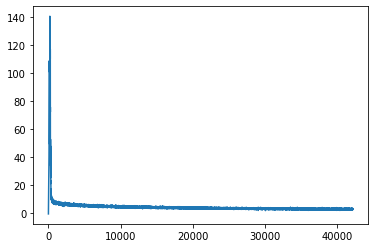

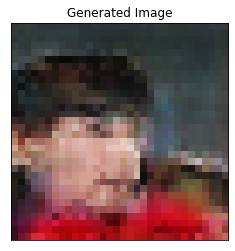

checkpointing at epoch: 40000
Iteration [40001/100000]......0.196(s) gen: 185.55603 - disc_fake: -185.65531 - disc_real: -182.37191 - disc_real: 3.28340
Iteration [40002/100000]......0.194(s) gen: 185.23808 - disc_fake: -185.27810 - disc_real: -182.44958 - disc_real: 2.82853
Iteration [40003/100000]......0.194(s) gen: 185.22778 - disc_fake: -184.93860 - disc_real: -182.03954 - disc_real: 2.89906
Iteration [40004/100000]......0.194(s) gen: 184.75217 - disc_fake: -184.83770 - disc_real: -181.86443 - disc_real: 2.97328
Iteration [40005/100000]......0.194(s) gen: 184.60529 - disc_fake: -184.58318 - disc_real: -181.48246 - disc_real: 3.10072
Iteration [40006/100000]......0.193(s) gen: 184.03014 - disc_fake: -184.22377 - disc_real: -181.31314 - disc_real: 2.91063
Iteration [40007/100000]......0.196(s) gen: 183.16103 - disc_fake: -183.86042 - disc_real: -180.73363 - disc_real: 3.12679
Iteration [40008/100000]......0.197(s) gen: 183.53030 - disc_fake: -183.29517 - disc_real: -180.48968 - disc_

Iteration [40068/100000]......0.194(s) gen: 185.72018 - disc_fake: -185.96666 - disc_real: -182.89594 - disc_real: 3.07072
Iteration [40069/100000]......0.195(s) gen: 185.53146 - disc_fake: -185.53492 - disc_real: -182.69958 - disc_real: 2.83534
Iteration [40070/100000]......0.195(s) gen: 184.70128 - disc_fake: -185.24154 - disc_real: -182.02260 - disc_real: 3.21894
Iteration [40071/100000]......0.195(s) gen: 184.50278 - disc_fake: -184.48452 - disc_real: -181.42237 - disc_real: 3.06215
Iteration [40072/100000]......0.197(s) gen: 183.73184 - disc_fake: -184.28250 - disc_real: -180.69052 - disc_real: 3.59199
Iteration [40073/100000]......0.196(s) gen: 183.35852 - disc_fake: -183.23073 - disc_real: -180.55911 - disc_real: 2.67161
Iteration [40074/100000]......0.199(s) gen: 183.84312 - disc_fake: -183.47074 - disc_real: -181.30419 - disc_real: 2.16655
Iteration [40075/100000]......0.200(s) gen: 184.90936 - disc_fake: -184.24381 - disc_real: -181.59492 - disc_real: 2.64889
Iteration [40076

Iteration [40136/100000]......0.197(s) gen: 184.64575 - disc_fake: -184.18098 - disc_real: -181.40196 - disc_real: 2.77903
Iteration [40137/100000]......0.196(s) gen: 184.64505 - disc_fake: -184.30048 - disc_real: -181.78417 - disc_real: 2.51631
Iteration [40138/100000]......0.197(s) gen: 185.11728 - disc_fake: -184.96661 - disc_real: -182.08434 - disc_real: 2.88227
Iteration [40139/100000]......0.197(s) gen: 185.88849 - disc_fake: -185.54134 - disc_real: -182.60586 - disc_real: 2.93548
Iteration [40140/100000]......0.193(s) gen: 185.78375 - disc_fake: -186.06105 - disc_real: -182.91505 - disc_real: 3.14600
Iteration [40141/100000]......0.194(s) gen: 186.36383 - disc_fake: -185.70975 - disc_real: -183.06693 - disc_real: 2.64282
Iteration [40142/100000]......0.194(s) gen: 185.26924 - disc_fake: -185.80008 - disc_real: -182.48035 - disc_real: 3.31973
Iteration [40143/100000]......0.197(s) gen: 185.79083 - disc_fake: -185.81551 - disc_real: -182.93379 - disc_real: 2.88172
Iteration [40144

Iteration [40203/100000]......0.202(s) gen: 185.21713 - disc_fake: -185.41512 - disc_real: -182.80107 - disc_real: 2.61405
Iteration [40204/100000]......0.201(s) gen: 185.25897 - disc_fake: -185.04897 - disc_real: -182.37075 - disc_real: 2.67823
Iteration [40205/100000]......0.202(s) gen: 184.63939 - disc_fake: -185.32988 - disc_real: -182.40356 - disc_real: 2.92631
Iteration [40206/100000]......0.200(s) gen: 184.21709 - disc_fake: -184.47980 - disc_real: -181.13965 - disc_real: 3.34016
Iteration [40207/100000]......0.195(s) gen: 184.28137 - disc_fake: -184.21042 - disc_real: -181.44262 - disc_real: 2.76780
Iteration [40208/100000]......0.197(s) gen: 184.21123 - disc_fake: -184.34854 - disc_real: -181.44997 - disc_real: 2.89857
Iteration [40209/100000]......0.198(s) gen: 184.10504 - disc_fake: -184.41341 - disc_real: -181.77525 - disc_real: 2.63816
Iteration [40210/100000]......0.197(s) gen: 184.56186 - disc_fake: -184.32348 - disc_real: -181.68727 - disc_real: 2.63621
Iteration [40211

Iteration [40270/100000]......0.203(s) gen: 185.47531 - disc_fake: -185.45621 - disc_real: -182.65589 - disc_real: 2.80031
Iteration [40271/100000]......0.202(s) gen: 185.00854 - disc_fake: -185.13869 - disc_real: -182.41236 - disc_real: 2.72633
Iteration [40272/100000]......0.199(s) gen: 185.01799 - disc_fake: -184.83633 - disc_real: -182.10804 - disc_real: 2.72830
Iteration [40273/100000]......0.198(s) gen: 185.03024 - disc_fake: -184.87522 - disc_real: -182.20919 - disc_real: 2.66603
Iteration [40274/100000]......0.199(s) gen: 185.26233 - disc_fake: -185.15762 - disc_real: -182.52956 - disc_real: 2.62806
Iteration [40275/100000]......0.200(s) gen: 185.00494 - disc_fake: -184.93364 - disc_real: -182.31238 - disc_real: 2.62126
Iteration [40276/100000]......0.200(s) gen: 185.29332 - disc_fake: -185.24764 - disc_real: -182.57638 - disc_real: 2.67126
Iteration [40277/100000]......0.198(s) gen: 185.70901 - disc_fake: -185.20016 - disc_real: -182.57752 - disc_real: 2.62263
Iteration [40278

Iteration [40337/100000]......0.199(s) gen: 185.57465 - disc_fake: -185.55652 - disc_real: -183.11373 - disc_real: 2.44279
Iteration [40338/100000]......0.202(s) gen: 184.98428 - disc_fake: -185.24323 - disc_real: -182.35123 - disc_real: 2.89200
Iteration [40339/100000]......0.203(s) gen: 184.98538 - disc_fake: -185.12098 - disc_real: -182.36126 - disc_real: 2.75972
Iteration [40340/100000]......0.202(s) gen: 185.39240 - disc_fake: -185.07789 - disc_real: -182.14616 - disc_real: 2.93173
Iteration [40341/100000]......0.201(s) gen: 185.47018 - disc_fake: -185.05749 - disc_real: -182.41482 - disc_real: 2.64267
Iteration [40342/100000]......0.201(s) gen: 185.86548 - disc_fake: -185.49284 - disc_real: -182.57805 - disc_real: 2.91479
Iteration [40343/100000]......0.199(s) gen: 185.77672 - disc_fake: -185.41064 - disc_real: -182.64940 - disc_real: 2.76124
Iteration [40344/100000]......0.196(s) gen: 185.16736 - disc_fake: -185.48240 - disc_real: -182.56433 - disc_real: 2.91807
Iteration [40345

Iteration [40404/100000]......0.196(s) gen: 185.94292 - disc_fake: -185.80370 - disc_real: -183.00226 - disc_real: 2.80145
Iteration [40405/100000]......0.196(s) gen: 185.79211 - disc_fake: -185.86814 - disc_real: -183.05022 - disc_real: 2.81792
Iteration [40406/100000]......0.199(s) gen: 185.67860 - disc_fake: -185.76717 - disc_real: -182.87294 - disc_real: 2.89423
Iteration [40407/100000]......0.201(s) gen: 185.38988 - disc_fake: -185.43942 - disc_real: -182.63367 - disc_real: 2.80575
Iteration [40408/100000]......0.202(s) gen: 185.82214 - disc_fake: -185.45156 - disc_real: -182.49082 - disc_real: 2.96074
Iteration [40409/100000]......0.207(s) gen: 186.25525 - disc_fake: -185.91882 - disc_real: -183.15412 - disc_real: 2.76470
Iteration [40410/100000]......0.197(s) gen: 186.42113 - disc_fake: -186.40080 - disc_real: -183.65472 - disc_real: 2.74608
Iteration [40411/100000]......0.197(s) gen: 186.81387 - disc_fake: -186.42399 - disc_real: -183.62955 - disc_real: 2.79444
Iteration [40412

Iteration [40472/100000]......0.197(s) gen: 185.42017 - disc_fake: -185.84056 - disc_real: -182.56565 - disc_real: 3.27491
Iteration [40473/100000]......0.197(s) gen: 185.28322 - disc_fake: -185.34200 - disc_real: -182.26159 - disc_real: 3.08041
Iteration [40474/100000]......0.197(s) gen: 185.52747 - disc_fake: -185.31784 - disc_real: -182.62367 - disc_real: 2.69418
Iteration [40475/100000]......0.195(s) gen: 185.26880 - disc_fake: -185.39380 - disc_real: -182.73016 - disc_real: 2.66364
Iteration [40476/100000]......0.194(s) gen: 185.21156 - disc_fake: -185.15838 - disc_real: -182.64852 - disc_real: 2.50986
Iteration [40477/100000]......0.197(s) gen: 185.59402 - disc_fake: -185.53867 - disc_real: -183.13658 - disc_real: 2.40209
Iteration [40478/100000]......0.195(s) gen: 185.69923 - disc_fake: -185.48048 - disc_real: -183.04159 - disc_real: 2.43890
Iteration [40479/100000]......0.197(s) gen: 185.81250 - disc_fake: -185.37644 - disc_real: -182.69132 - disc_real: 2.68512
Iteration [40480

Iteration [40539/100000]......0.196(s) gen: 186.07640 - disc_fake: -186.19088 - disc_real: -182.95002 - disc_real: 3.24085
Iteration [40540/100000]......0.195(s) gen: 185.81464 - disc_fake: -186.28093 - disc_real: -183.21953 - disc_real: 3.06140
Iteration [40541/100000]......0.197(s) gen: 186.28778 - disc_fake: -185.90823 - disc_real: -183.53925 - disc_real: 2.36898
Iteration [40542/100000]......0.196(s) gen: 186.49121 - disc_fake: -186.39644 - disc_real: -183.80356 - disc_real: 2.59288
Iteration [40543/100000]......0.198(s) gen: 186.56723 - disc_fake: -186.60743 - disc_real: -183.83400 - disc_real: 2.77343
Iteration [40544/100000]......0.199(s) gen: 186.05087 - disc_fake: -186.49040 - disc_real: -183.92306 - disc_real: 2.56733
Iteration [40545/100000]......0.200(s) gen: 186.08191 - disc_fake: -186.48917 - disc_real: -183.83973 - disc_real: 2.64944
Iteration [40546/100000]......0.200(s) gen: 185.86365 - disc_fake: -186.43552 - disc_real: -183.22610 - disc_real: 3.20941
Iteration [40547

Iteration [40607/100000]......0.201(s) gen: 187.61502 - disc_fake: -186.92809 - disc_real: -183.90355 - disc_real: 3.02455
Iteration [40608/100000]......0.200(s) gen: 187.40201 - disc_fake: -186.61577 - disc_real: -183.89358 - disc_real: 2.72220
Iteration [40609/100000]......0.199(s) gen: 186.97607 - disc_fake: -186.65919 - disc_real: -184.02312 - disc_real: 2.63607
Iteration [40610/100000]......0.197(s) gen: 186.88889 - disc_fake: -186.81747 - disc_real: -183.95535 - disc_real: 2.86212
Iteration [40611/100000]......0.198(s) gen: 186.74211 - disc_fake: -186.84366 - disc_real: -184.23430 - disc_real: 2.60936
Iteration [40612/100000]......0.198(s) gen: 186.16827 - disc_fake: -186.59278 - disc_real: -183.99584 - disc_real: 2.59694
Iteration [40613/100000]......0.200(s) gen: 185.63980 - disc_fake: -186.06886 - disc_real: -183.14176 - disc_real: 2.92709
Iteration [40614/100000]......0.201(s) gen: 185.65524 - disc_fake: -185.74308 - disc_real: -182.71699 - disc_real: 3.02610
Iteration [40615

Iteration [40674/100000]......0.200(s) gen: 187.43097 - disc_fake: -187.55255 - disc_real: -184.59781 - disc_real: 2.95474
Iteration [40675/100000]......0.199(s) gen: 187.48203 - disc_fake: -187.19720 - disc_real: -184.31720 - disc_real: 2.87999
Iteration [40676/100000]......0.199(s) gen: 187.19331 - disc_fake: -187.40084 - disc_real: -184.53364 - disc_real: 2.86721
Iteration [40677/100000]......0.200(s) gen: 186.95703 - disc_fake: -186.95472 - disc_real: -184.02289 - disc_real: 2.93183
Iteration [40678/100000]......0.201(s) gen: 186.85599 - disc_fake: -186.87810 - disc_real: -183.99339 - disc_real: 2.88471
Iteration [40679/100000]......0.201(s) gen: 186.37959 - disc_fake: -186.60779 - disc_real: -183.51619 - disc_real: 3.09160
Iteration [40680/100000]......0.201(s) gen: 187.15311 - disc_fake: -186.62108 - disc_real: -183.89220 - disc_real: 2.72888
Iteration [40681/100000]......0.199(s) gen: 187.18919 - disc_fake: -187.05865 - disc_real: -183.79561 - disc_real: 3.26304
Iteration [40682

Iteration [40741/100000]......0.199(s) gen: 187.24995 - disc_fake: -187.13179 - disc_real: -184.02660 - disc_real: 3.10519
Iteration [40742/100000]......0.197(s) gen: 187.48633 - disc_fake: -187.20288 - disc_real: -184.27967 - disc_real: 2.92321
Iteration [40743/100000]......0.196(s) gen: 187.53867 - disc_fake: -187.41022 - disc_real: -184.47124 - disc_real: 2.93898
Iteration [40744/100000]......0.197(s) gen: 187.46002 - disc_fake: -187.46206 - disc_real: -184.87741 - disc_real: 2.58466
Iteration [40745/100000]......0.200(s) gen: 187.74011 - disc_fake: -187.50812 - disc_real: -184.87983 - disc_real: 2.62829
Iteration [40746/100000]......0.200(s) gen: 187.58253 - disc_fake: -187.32555 - disc_real: -184.55360 - disc_real: 2.77195
Iteration [40747/100000]......0.204(s) gen: 186.94615 - disc_fake: -187.04818 - disc_real: -184.13432 - disc_real: 2.91387
Iteration [40748/100000]......0.203(s) gen: 187.06903 - disc_fake: -186.71895 - disc_real: -184.03684 - disc_real: 2.68211
Iteration [40749

Iteration [40808/100000]......0.197(s) gen: 188.57628 - disc_fake: -188.34645 - disc_real: -185.70504 - disc_real: 2.64141
Iteration [40809/100000]......0.193(s) gen: 187.86638 - disc_fake: -188.03324 - disc_real: -185.24430 - disc_real: 2.78895
Iteration [40810/100000]......0.191(s) gen: 188.07526 - disc_fake: -188.02097 - disc_real: -185.11720 - disc_real: 2.90377
Iteration [40811/100000]......0.193(s) gen: 187.98454 - disc_fake: -188.12988 - disc_real: -185.04361 - disc_real: 3.08627
Iteration [40812/100000]......0.194(s) gen: 187.75620 - disc_fake: -187.65187 - disc_real: -184.71786 - disc_real: 2.93401
Iteration [40813/100000]......0.196(s) gen: 186.88840 - disc_fake: -187.33760 - disc_real: -184.57332 - disc_real: 2.76428
Iteration [40814/100000]......0.196(s) gen: 186.58293 - disc_fake: -186.53025 - disc_real: -183.94382 - disc_real: 2.58643
Iteration [40815/100000]......0.196(s) gen: 186.76089 - disc_fake: -186.59290 - disc_real: -183.67700 - disc_real: 2.91590
Iteration [40816

Iteration [40875/100000]......0.197(s) gen: 186.32634 - disc_fake: -186.32358 - disc_real: -183.32555 - disc_real: 2.99803
Iteration [40876/100000]......0.196(s) gen: 186.69073 - disc_fake: -186.26483 - disc_real: -183.56709 - disc_real: 2.69774
Iteration [40877/100000]......0.200(s) gen: 186.39436 - disc_fake: -186.66330 - disc_real: -183.33036 - disc_real: 3.33294
Iteration [40878/100000]......0.200(s) gen: 187.08846 - disc_fake: -186.42674 - disc_real: -183.72051 - disc_real: 2.70623
Iteration [40879/100000]......0.203(s) gen: 187.51285 - disc_fake: -187.23048 - disc_real: -184.08548 - disc_real: 3.14500
Iteration [40880/100000]......0.202(s) gen: 187.47897 - disc_fake: -187.63234 - disc_real: -184.45665 - disc_real: 3.17569
Iteration [40881/100000]......0.201(s) gen: 186.60670 - disc_fake: -187.47449 - disc_real: -184.45465 - disc_real: 3.01984
Iteration [40882/100000]......0.201(s) gen: 186.77972 - disc_fake: -187.32728 - disc_real: -184.32887 - disc_real: 2.99842
Iteration [40883

Iteration [40943/100000]......0.199(s) gen: 187.63254 - disc_fake: -187.65200 - disc_real: -184.76934 - disc_real: 2.88266
Iteration [40944/100000]......0.199(s) gen: 187.41594 - disc_fake: -187.51755 - disc_real: -184.60798 - disc_real: 2.90958
Iteration [40945/100000]......0.199(s) gen: 188.28954 - disc_fake: -187.84555 - disc_real: -184.87379 - disc_real: 2.97176
Iteration [40946/100000]......0.197(s) gen: 188.16547 - disc_fake: -188.05203 - disc_real: -185.25647 - disc_real: 2.79556
Iteration [40947/100000]......0.198(s) gen: 188.51155 - disc_fake: -187.99978 - disc_real: -185.31310 - disc_real: 2.68668
Iteration [40948/100000]......0.199(s) gen: 188.20908 - disc_fake: -188.22592 - disc_real: -185.48929 - disc_real: 2.73664
Iteration [40949/100000]......0.196(s) gen: 188.24625 - disc_fake: -188.21971 - disc_real: -185.15057 - disc_real: 3.06914
Iteration [40950/100000]......0.197(s) gen: 187.94434 - disc_fake: -188.09842 - disc_real: -185.26073 - disc_real: 2.83769
Iteration [40951

Iteration [41011/100000]......0.198(s) gen: 187.42484 - disc_fake: -187.46001 - disc_real: -184.79881 - disc_real: 2.66120
Iteration [41012/100000]......0.197(s) gen: 187.68269 - disc_fake: -187.51939 - disc_real: -184.97406 - disc_real: 2.54532
Iteration [41013/100000]......0.200(s) gen: 187.49893 - disc_fake: -187.69592 - disc_real: -184.66266 - disc_real: 3.03327
Iteration [41014/100000]......0.202(s) gen: 187.14029 - disc_fake: -187.37595 - disc_real: -184.37514 - disc_real: 3.00081
Iteration [41015/100000]......0.211(s) gen: 187.33514 - disc_fake: -187.13790 - disc_real: -184.20031 - disc_real: 2.93760
Iteration [41016/100000]......0.201(s) gen: 187.78485 - disc_fake: -187.56649 - disc_real: -184.60982 - disc_real: 2.95666
Iteration [41017/100000]......0.201(s) gen: 188.39218 - disc_fake: -187.92677 - disc_real: -184.97210 - disc_real: 2.95468
Iteration [41018/100000]......0.201(s) gen: 188.47919 - disc_fake: -188.26349 - disc_real: -185.60984 - disc_real: 2.65365
Iteration [41019

Iteration [41079/100000]......0.201(s) gen: 186.66463 - disc_fake: -186.42822 - disc_real: -183.72492 - disc_real: 2.70331
Iteration [41080/100000]......0.199(s) gen: 186.71393 - disc_fake: -186.46569 - disc_real: -183.72175 - disc_real: 2.74394
Iteration [41081/100000]......0.197(s) gen: 188.21765 - disc_fake: -186.72994 - disc_real: -184.12343 - disc_real: 2.60651
Iteration [41082/100000]......0.196(s) gen: 188.50684 - disc_fake: -188.14043 - disc_real: -185.35744 - disc_real: 2.78299
Iteration [41083/100000]......0.197(s) gen: 188.44037 - disc_fake: -188.73959 - disc_real: -185.68561 - disc_real: 3.05397
Iteration [41084/100000]......0.197(s) gen: 188.49666 - disc_fake: -188.42323 - disc_real: -185.40412 - disc_real: 3.01911
Iteration [41085/100000]......0.197(s) gen: 188.17093 - disc_fake: -188.41014 - disc_real: -185.59112 - disc_real: 2.81902
Iteration [41086/100000]......0.197(s) gen: 187.10789 - disc_fake: -187.60638 - disc_real: -184.68129 - disc_real: 2.92510
Iteration [41087

Iteration [41146/100000]......0.202(s) gen: 187.68350 - disc_fake: -187.49170 - disc_real: -184.95547 - disc_real: 2.53623
Iteration [41147/100000]......0.202(s) gen: 187.57907 - disc_fake: -187.90061 - disc_real: -184.97235 - disc_real: 2.92826
Iteration [41148/100000]......0.201(s) gen: 187.88728 - disc_fake: -187.62998 - disc_real: -184.81618 - disc_real: 2.81380
Iteration [41149/100000]......0.201(s) gen: 187.95297 - disc_fake: -187.80020 - disc_real: -185.19659 - disc_real: 2.60361
Iteration [41150/100000]......0.199(s) gen: 188.23743 - disc_fake: -187.92797 - disc_real: -185.13354 - disc_real: 2.79443
Iteration [41151/100000]......0.199(s) gen: 188.60194 - disc_fake: -188.02530 - disc_real: -185.30526 - disc_real: 2.72004
Iteration [41152/100000]......0.197(s) gen: 188.18672 - disc_fake: -188.26127 - disc_real: -185.59172 - disc_real: 2.66955
Iteration [41153/100000]......0.196(s) gen: 188.18567 - disc_fake: -187.98607 - disc_real: -185.15307 - disc_real: 2.83300
Iteration [41154

Iteration [41213/100000]......0.211(s) gen: 187.73325 - disc_fake: -187.64178 - disc_real: -184.78032 - disc_real: 2.86146
Iteration [41214/100000]......0.212(s) gen: 188.51013 - disc_fake: -187.80558 - disc_real: -184.93074 - disc_real: 2.87483
Iteration [41215/100000]......0.215(s) gen: 188.21210 - disc_fake: -188.25867 - disc_real: -185.44758 - disc_real: 2.81108
Iteration [41216/100000]......0.215(s) gen: 187.50728 - disc_fake: -187.57517 - disc_real: -184.77105 - disc_real: 2.80412
Iteration [41217/100000]......0.213(s) gen: 187.12634 - disc_fake: -187.17378 - disc_real: -184.58421 - disc_real: 2.58957
Iteration [41218/100000]......0.205(s) gen: 187.15616 - disc_fake: -187.20627 - disc_real: -184.53445 - disc_real: 2.67183
Iteration [41219/100000]......0.204(s) gen: 187.45099 - disc_fake: -187.20272 - disc_real: -184.42803 - disc_real: 2.77469
Iteration [41220/100000]......0.203(s) gen: 187.36572 - disc_fake: -187.32763 - disc_real: -184.37713 - disc_real: 2.95051
Iteration [41221

Iteration [41280/100000]......0.194(s) gen: 186.27014 - disc_fake: -185.92088 - disc_real: -183.55316 - disc_real: 2.36772
Iteration [41281/100000]......0.197(s) gen: 187.19531 - disc_fake: -186.48193 - disc_real: -184.25708 - disc_real: 2.22484
Iteration [41282/100000]......0.199(s) gen: 187.61420 - disc_fake: -187.15100 - disc_real: -184.35960 - disc_real: 2.79140
Iteration [41283/100000]......0.199(s) gen: 188.09521 - disc_fake: -187.52286 - disc_real: -184.73386 - disc_real: 2.78900
Iteration [41284/100000]......0.199(s) gen: 188.21414 - disc_fake: -187.93481 - disc_real: -185.34140 - disc_real: 2.59341
Iteration [41285/100000]......0.198(s) gen: 188.30276 - disc_fake: -187.94990 - disc_real: -185.39130 - disc_real: 2.55861
Iteration [41286/100000]......0.199(s) gen: 188.22620 - disc_fake: -188.14159 - disc_real: -185.30293 - disc_real: 2.83866
Iteration [41287/100000]......0.199(s) gen: 187.97751 - disc_fake: -187.81299 - disc_real: -184.79887 - disc_real: 3.01412
Iteration [41288

Iteration [41347/100000]......0.197(s) gen: 188.36795 - disc_fake: -188.80347 - disc_real: -185.97903 - disc_real: 2.82444
Iteration [41348/100000]......0.198(s) gen: 188.24866 - disc_fake: -188.38446 - disc_real: -185.75411 - disc_real: 2.63035
Iteration [41349/100000]......0.199(s) gen: 187.78351 - disc_fake: -187.97666 - disc_real: -185.26888 - disc_real: 2.70779
Iteration [41350/100000]......0.197(s) gen: 187.80566 - disc_fake: -187.95695 - disc_real: -185.36850 - disc_real: 2.58846
Iteration [41351/100000]......0.195(s) gen: 187.58240 - disc_fake: -187.88717 - disc_real: -185.07957 - disc_real: 2.80760
Iteration [41352/100000]......0.196(s) gen: 187.49622 - disc_fake: -187.61016 - disc_real: -184.79701 - disc_real: 2.81315
Iteration [41353/100000]......0.199(s) gen: 187.76602 - disc_fake: -187.61125 - disc_real: -184.91266 - disc_real: 2.69858
Iteration [41354/100000]......0.197(s) gen: 188.44502 - disc_fake: -187.86063 - disc_real: -185.21702 - disc_real: 2.64361
Iteration [41355

Iteration [41414/100000]......0.202(s) gen: 189.13797 - disc_fake: -188.67415 - disc_real: -186.10332 - disc_real: 2.57083
Iteration [41415/100000]......0.201(s) gen: 189.24078 - disc_fake: -188.68447 - disc_real: -186.07325 - disc_real: 2.61122
Iteration [41416/100000]......0.200(s) gen: 189.48944 - disc_fake: -189.11682 - disc_real: -186.57240 - disc_real: 2.54442
Iteration [41417/100000]......0.202(s) gen: 189.58871 - disc_fake: -189.38158 - disc_real: -186.61266 - disc_real: 2.76892
Iteration [41418/100000]......0.200(s) gen: 189.28127 - disc_fake: -189.14615 - disc_real: -186.32513 - disc_real: 2.82101
Iteration [41419/100000]......0.203(s) gen: 188.54427 - disc_fake: -188.62571 - disc_real: -185.79620 - disc_real: 2.82951
Iteration [41420/100000]......0.201(s) gen: 188.18430 - disc_fake: -188.37276 - disc_real: -185.56752 - disc_real: 2.80524
Iteration [41421/100000]......0.199(s) gen: 188.87384 - disc_fake: -188.62051 - disc_real: -185.73043 - disc_real: 2.89008
Iteration [41422

Iteration [41481/100000]......0.195(s) gen: 188.32828 - disc_fake: -188.36596 - disc_real: -185.62075 - disc_real: 2.74522
Iteration [41482/100000]......0.196(s) gen: 188.20015 - disc_fake: -188.26763 - disc_real: -185.28726 - disc_real: 2.98037
Iteration [41483/100000]......0.197(s) gen: 188.48747 - disc_fake: -188.28612 - disc_real: -185.21841 - disc_real: 3.06770
Iteration [41484/100000]......0.196(s) gen: 188.38922 - disc_fake: -188.16702 - disc_real: -185.65334 - disc_real: 2.51367
Iteration [41485/100000]......0.198(s) gen: 188.74567 - disc_fake: -188.60042 - disc_real: -186.12207 - disc_real: 2.47835
Iteration [41486/100000]......0.198(s) gen: 188.85034 - disc_fake: -188.46461 - disc_real: -185.88040 - disc_real: 2.58422
Iteration [41487/100000]......0.201(s) gen: 188.26465 - disc_fake: -188.53674 - disc_real: -185.63796 - disc_real: 2.89878
Iteration [41488/100000]......0.199(s) gen: 188.42407 - disc_fake: -188.34024 - disc_real: -185.68262 - disc_real: 2.65761
Iteration [41489

Iteration [41549/100000]......0.200(s) gen: 188.54503 - disc_fake: -188.51657 - disc_real: -185.89569 - disc_real: 2.62088
Iteration [41550/100000]......0.199(s) gen: 188.62930 - disc_fake: -188.71736 - disc_real: -185.88932 - disc_real: 2.82804
Iteration [41551/100000]......0.200(s) gen: 188.43048 - disc_fake: -188.62342 - disc_real: -185.62593 - disc_real: 2.99748
Iteration [41552/100000]......0.200(s) gen: 188.14835 - disc_fake: -188.32845 - disc_real: -185.21134 - disc_real: 3.11711
Iteration [41553/100000]......0.200(s) gen: 188.31656 - disc_fake: -188.06044 - disc_real: -185.32918 - disc_real: 2.73126
Iteration [41554/100000]......0.200(s) gen: 187.78979 - disc_fake: -188.19918 - disc_real: -184.75550 - disc_real: 3.44369
Iteration [41555/100000]......0.198(s) gen: 188.79962 - disc_fake: -187.94000 - disc_real: -185.07468 - disc_real: 2.86531
Iteration [41556/100000]......0.200(s) gen: 189.34276 - disc_fake: -188.94165 - disc_real: -186.19114 - disc_real: 2.75050
Iteration [41557

Iteration [41616/100000]......0.205(s) gen: 188.97101 - disc_fake: -188.70047 - disc_real: -185.96609 - disc_real: 2.73439
Iteration [41617/100000]......0.202(s) gen: 188.71645 - disc_fake: -188.75962 - disc_real: -185.84470 - disc_real: 2.91492
Iteration [41618/100000]......0.200(s) gen: 189.51442 - disc_fake: -188.93645 - disc_real: -186.22421 - disc_real: 2.71224
Iteration [41619/100000]......0.200(s) gen: 189.72281 - disc_fake: -189.43624 - disc_real: -186.66290 - disc_real: 2.77334
Iteration [41620/100000]......0.198(s) gen: 189.23489 - disc_fake: -189.58935 - disc_real: -186.79221 - disc_real: 2.79714
Iteration [41621/100000]......0.197(s) gen: 189.66263 - disc_fake: -189.29516 - disc_real: -186.29040 - disc_real: 3.00476
Iteration [41622/100000]......0.197(s) gen: 189.29785 - disc_fake: -189.25038 - disc_real: -186.27513 - disc_real: 2.97525
Iteration [41623/100000]......0.201(s) gen: 189.32248 - disc_fake: -189.21755 - disc_real: -186.45950 - disc_real: 2.75805
Iteration [41624

Iteration [41683/100000]......0.196(s) gen: 189.25400 - disc_fake: -189.86364 - disc_real: -186.83616 - disc_real: 3.02748
Iteration [41684/100000]......0.195(s) gen: 188.66327 - disc_fake: -188.86147 - disc_real: -186.06630 - disc_real: 2.79517
Iteration [41685/100000]......0.197(s) gen: 188.54022 - disc_fake: -188.59037 - disc_real: -185.78103 - disc_real: 2.80934
Iteration [41686/100000]......0.198(s) gen: 188.70963 - disc_fake: -188.67299 - disc_real: -185.83159 - disc_real: 2.84140
Iteration [41687/100000]......0.195(s) gen: 188.36324 - disc_fake: -188.28552 - disc_real: -185.44550 - disc_real: 2.84002
Iteration [41688/100000]......0.197(s) gen: 187.71933 - disc_fake: -188.20681 - disc_real: -185.15466 - disc_real: 3.05215
Iteration [41689/100000]......0.199(s) gen: 187.96782 - disc_fake: -187.87527 - disc_real: -184.88027 - disc_real: 2.99500
Iteration [41690/100000]......0.197(s) gen: 188.30289 - disc_fake: -188.07195 - disc_real: -185.29735 - disc_real: 2.77460
Iteration [41691

Iteration [41750/100000]......0.197(s) gen: 189.81841 - disc_fake: -189.65218 - disc_real: -186.41964 - disc_real: 3.23253
Iteration [41751/100000]......0.198(s) gen: 189.41449 - disc_fake: -189.42933 - disc_real: -186.12082 - disc_real: 3.30851
Iteration [41752/100000]......0.198(s) gen: 188.97903 - disc_fake: -188.77118 - disc_real: -186.19299 - disc_real: 2.57819
Iteration [41753/100000]......0.198(s) gen: 188.58395 - disc_fake: -188.71285 - disc_real: -185.72406 - disc_real: 2.98879
Iteration [41754/100000]......0.200(s) gen: 188.63443 - disc_fake: -188.35437 - disc_real: -185.65607 - disc_real: 2.69830
Iteration [41755/100000]......0.201(s) gen: 188.18022 - disc_fake: -188.27392 - disc_real: -185.77993 - disc_real: 2.49400
Iteration [41756/100000]......0.202(s) gen: 188.03732 - disc_fake: -188.13725 - disc_real: -185.26075 - disc_real: 2.87650
Iteration [41757/100000]......0.201(s) gen: 188.23122 - disc_fake: -187.79102 - disc_real: -185.04533 - disc_real: 2.74568
Iteration [41758

Iteration [41817/100000]......0.209(s) gen: 189.15350 - disc_fake: -189.23420 - disc_real: -186.69689 - disc_real: 2.53731
Iteration [41818/100000]......0.206(s) gen: 189.69495 - disc_fake: -189.39475 - disc_real: -186.51672 - disc_real: 2.87803
Iteration [41819/100000]......0.203(s) gen: 190.10416 - disc_fake: -190.04650 - disc_real: -187.01039 - disc_real: 3.03611
Iteration [41820/100000]......0.202(s) gen: 189.66568 - disc_fake: -189.49279 - disc_real: -186.96239 - disc_real: 2.53040
Iteration [41821/100000]......0.203(s) gen: 188.81729 - disc_fake: -189.42249 - disc_real: -186.47439 - disc_real: 2.94810
Iteration [41822/100000]......0.203(s) gen: 189.32378 - disc_fake: -188.88285 - disc_real: -186.48646 - disc_real: 2.39639
Iteration [41823/100000]......0.202(s) gen: 189.41356 - disc_fake: -189.22586 - disc_real: -186.34268 - disc_real: 2.88319
Iteration [41824/100000]......0.201(s) gen: 189.22704 - disc_fake: -189.24742 - disc_real: -186.18123 - disc_real: 3.06619
Iteration [41825

Iteration [41884/100000]......0.196(s) gen: 188.71860 - disc_fake: -188.50399 - disc_real: -185.89556 - disc_real: 2.60843
Iteration [41885/100000]......0.196(s) gen: 189.45204 - disc_fake: -189.00675 - disc_real: -186.05475 - disc_real: 2.95200
Iteration [41886/100000]......0.198(s) gen: 189.21039 - disc_fake: -189.36838 - disc_real: -186.51252 - disc_real: 2.85586
Iteration [41887/100000]......0.201(s) gen: 189.50626 - disc_fake: -189.20415 - disc_real: -186.39456 - disc_real: 2.80959
Iteration [41888/100000]......0.203(s) gen: 189.24472 - disc_fake: -189.24113 - disc_real: -186.44374 - disc_real: 2.79739
Iteration [41889/100000]......0.205(s) gen: 189.26222 - disc_fake: -189.10748 - disc_real: -186.36105 - disc_real: 2.74642
Iteration [41890/100000]......0.205(s) gen: 189.01590 - disc_fake: -189.15464 - disc_real: -186.19224 - disc_real: 2.96240
Iteration [41891/100000]......0.205(s) gen: 189.33252 - disc_fake: -188.82270 - disc_real: -185.78071 - disc_real: 3.04199
Iteration [41892

Iteration [41951/100000]......0.197(s) gen: 190.16565 - disc_fake: -189.67797 - disc_real: -186.91133 - disc_real: 2.76664
Iteration [41952/100000]......0.197(s) gen: 189.90894 - disc_fake: -189.73281 - disc_real: -186.87693 - disc_real: 2.85588
Iteration [41953/100000]......0.199(s) gen: 189.46136 - disc_fake: -190.07943 - disc_real: -186.91773 - disc_real: 3.16170
Iteration [41954/100000]......0.199(s) gen: 189.09291 - disc_fake: -189.33042 - disc_real: -186.42444 - disc_real: 2.90598
Iteration [41955/100000]......0.200(s) gen: 189.24631 - disc_fake: -189.05637 - disc_real: -186.49084 - disc_real: 2.56553
Iteration [41956/100000]......0.199(s) gen: 188.97293 - disc_fake: -189.26316 - disc_real: -186.14290 - disc_real: 3.12026
Iteration [41957/100000]......0.200(s) gen: 188.56073 - disc_fake: -188.89669 - disc_real: -186.00866 - disc_real: 2.88803
Iteration [41958/100000]......0.198(s) gen: 188.27676 - disc_fake: -188.24342 - disc_real: -185.43455 - disc_real: 2.80887
Iteration [41959

Iteration [42019/100000]......0.198(s) gen: 188.80318 - disc_fake: -189.03667 - disc_real: -186.31418 - disc_real: 2.72249
Iteration [42020/100000]......0.198(s) gen: 189.04343 - disc_fake: -188.82163 - disc_real: -186.50088 - disc_real: 2.32075
Iteration [42021/100000]......0.197(s) gen: 189.42520 - disc_fake: -189.17540 - disc_real: -186.47672 - disc_real: 2.69868
Iteration [42022/100000]......0.196(s) gen: 189.24245 - disc_fake: -189.29826 - disc_real: -186.44181 - disc_real: 2.85645
Iteration [42023/100000]......0.199(s) gen: 189.40294 - disc_fake: -189.28733 - disc_real: -185.98863 - disc_real: 3.29870
Iteration [42024/100000]......0.198(s) gen: 189.57338 - disc_fake: -189.74128 - disc_real: -186.96319 - disc_real: 2.77809
Iteration [42025/100000]......0.197(s) gen: 189.63791 - disc_fake: -189.60683 - disc_real: -186.79880 - disc_real: 2.80803
Iteration [42026/100000]......0.198(s) gen: 189.35358 - disc_fake: -189.53456 - disc_real: -186.31725 - disc_real: 3.21731
Iteration [42027

Iteration [42086/100000]......0.198(s) gen: 189.66528 - disc_fake: -189.44005 - disc_real: -186.74544 - disc_real: 2.69461
Iteration [42087/100000]......0.198(s) gen: 189.92188 - disc_fake: -189.90977 - disc_real: -187.29222 - disc_real: 2.61755
Iteration [42088/100000]......0.198(s) gen: 189.60291 - disc_fake: -190.08518 - disc_real: -186.79945 - disc_real: 3.28573
Iteration [42089/100000]......0.200(s) gen: 189.49142 - disc_fake: -189.51120 - disc_real: -186.57363 - disc_real: 2.93757
Iteration [42090/100000]......0.197(s) gen: 189.34607 - disc_fake: -189.15011 - disc_real: -186.11563 - disc_real: 3.03448
Iteration [42091/100000]......0.200(s) gen: 189.13901 - disc_fake: -189.01964 - disc_real: -185.88125 - disc_real: 3.13839
Iteration [42092/100000]......0.197(s) gen: 188.64587 - disc_fake: -188.81199 - disc_real: -185.55999 - disc_real: 3.25200
Iteration [42093/100000]......0.196(s) gen: 189.31100 - disc_fake: -188.89469 - disc_real: -186.01465 - disc_real: 2.88003
Iteration [42094

Iteration [42154/100000]......0.198(s) gen: 188.69078 - disc_fake: -188.60804 - disc_real: -185.42668 - disc_real: 3.18137
Iteration [42155/100000]......0.200(s) gen: 188.94255 - disc_fake: -188.36054 - disc_real: -185.96027 - disc_real: 2.40027
Iteration [42156/100000]......0.199(s) gen: 189.28760 - disc_fake: -189.09510 - disc_real: -186.47660 - disc_real: 2.61851
Iteration [42157/100000]......0.199(s) gen: 190.35898 - disc_fake: -189.32688 - disc_real: -187.06228 - disc_real: 2.26460
Iteration [42158/100000]......0.199(s) gen: 190.09622 - disc_fake: -189.98337 - disc_real: -187.25984 - disc_real: 2.72353
Iteration [42159/100000]......0.198(s) gen: 189.83469 - disc_fake: -189.99267 - disc_real: -187.08588 - disc_real: 2.90679
Iteration [42160/100000]......0.198(s) gen: 189.81708 - disc_fake: -189.54629 - disc_real: -186.87719 - disc_real: 2.66910
Iteration [42161/100000]......0.196(s) gen: 190.22150 - disc_fake: -189.90740 - disc_real: -186.79813 - disc_real: 3.10927
Iteration [42162

Iteration [42221/100000]......0.199(s) gen: 189.07562 - disc_fake: -189.42047 - disc_real: -186.62722 - disc_real: 2.79324
Iteration [42222/100000]......0.199(s) gen: 189.05696 - disc_fake: -189.49097 - disc_real: -186.78147 - disc_real: 2.70951
Iteration [42223/100000]......0.199(s) gen: 188.96832 - disc_fake: -189.08059 - disc_real: -186.46652 - disc_real: 2.61407
Iteration [42224/100000]......0.198(s) gen: 188.83937 - disc_fake: -188.94537 - disc_real: -186.69235 - disc_real: 2.25302
Iteration [42225/100000]......0.199(s) gen: 189.05409 - disc_fake: -189.01564 - disc_real: -186.33412 - disc_real: 2.68152
Iteration [42226/100000]......0.202(s) gen: 189.66565 - disc_fake: -189.28484 - disc_real: -186.72805 - disc_real: 2.55680
Iteration [42227/100000]......0.204(s) gen: 189.46759 - disc_fake: -189.06135 - disc_real: -186.44202 - disc_real: 2.61933
Iteration [42228/100000]......0.208(s) gen: 189.19212 - disc_fake: -188.98954 - disc_real: -186.13249 - disc_real: 2.85706
Iteration [42229

Iteration [42288/100000]......0.198(s) gen: 190.72171 - disc_fake: -190.92818 - disc_real: -187.75121 - disc_real: 3.17697
Iteration [42289/100000]......0.199(s) gen: 189.79602 - disc_fake: -190.39982 - disc_real: -187.37098 - disc_real: 3.02884
Iteration [42290/100000]......0.199(s) gen: 190.27155 - disc_fake: -189.73734 - disc_real: -187.04197 - disc_real: 2.69537
Iteration [42291/100000]......0.200(s) gen: 190.39732 - disc_fake: -190.35507 - disc_real: -187.52443 - disc_real: 2.83065
Iteration [42292/100000]......0.201(s) gen: 190.20032 - disc_fake: -190.35088 - disc_real: -187.51351 - disc_real: 2.83737
Iteration [42293/100000]......0.197(s) gen: 190.62576 - disc_fake: -190.41816 - disc_real: -187.79216 - disc_real: 2.62600
Iteration [42294/100000]......0.199(s) gen: 190.43329 - disc_fake: -190.74239 - disc_real: -187.64996 - disc_real: 3.09243
Iteration [42295/100000]......0.200(s) gen: 190.54248 - disc_fake: -190.65726 - disc_real: -187.78836 - disc_real: 2.86890
Iteration [42296

Iteration [42355/100000]......0.202(s) gen: 189.43637 - disc_fake: -189.48029 - disc_real: -186.87961 - disc_real: 2.60068
Iteration [42356/100000]......0.205(s) gen: 189.54953 - disc_fake: -189.44011 - disc_real: -186.66473 - disc_real: 2.77538
Iteration [42357/100000]......0.203(s) gen: 189.55234 - disc_fake: -189.28118 - disc_real: -186.34675 - disc_real: 2.93442
Iteration [42358/100000]......0.204(s) gen: 189.91611 - disc_fake: -189.53127 - disc_real: -186.71711 - disc_real: 2.81416
Iteration [42359/100000]......0.201(s) gen: 189.93967 - disc_fake: -189.95291 - disc_real: -187.02986 - disc_real: 2.92305
Iteration [42360/100000]......0.199(s) gen: 190.16376 - disc_fake: -190.07160 - disc_real: -187.20248 - disc_real: 2.86912
Iteration [42361/100000]......0.197(s) gen: 190.66006 - disc_fake: -190.32890 - disc_real: -187.81773 - disc_real: 2.51117
Iteration [42362/100000]......0.196(s) gen: 191.21664 - disc_fake: -190.67939 - disc_real: -187.84411 - disc_real: 2.83528
Iteration [42363

Iteration [42422/100000]......0.213(s) gen: 191.51128 - disc_fake: -191.14709 - disc_real: -188.28681 - disc_real: 2.86028
Iteration [42423/100000]......0.215(s) gen: 192.17436 - disc_fake: -191.57039 - disc_real: -188.74575 - disc_real: 2.82465
Iteration [42424/100000]......0.212(s) gen: 191.46899 - disc_fake: -191.42981 - disc_real: -188.50168 - disc_real: 2.92813
Iteration [42425/100000]......0.209(s) gen: 191.11777 - disc_fake: -191.39442 - disc_real: -188.38265 - disc_real: 3.01177
Iteration [42426/100000]......0.208(s) gen: 190.94495 - disc_fake: -190.98033 - disc_real: -187.79654 - disc_real: 3.18379
Iteration [42427/100000]......0.204(s) gen: 190.16757 - disc_fake: -190.52459 - disc_real: -187.82134 - disc_real: 2.70326
Iteration [42428/100000]......0.203(s) gen: 190.19452 - disc_fake: -190.31942 - disc_real: -187.89179 - disc_real: 2.42763
Iteration [42429/100000]......0.202(s) gen: 190.25183 - disc_fake: -190.20292 - disc_real: -187.54455 - disc_real: 2.65837
Iteration [42430

Iteration [42490/100000]......0.197(s) gen: 190.49257 - disc_fake: -190.37430 - disc_real: -187.87047 - disc_real: 2.50383
Iteration [42491/100000]......0.195(s) gen: 190.94867 - disc_fake: -190.56366 - disc_real: -187.86409 - disc_real: 2.69957
Iteration [42492/100000]......0.197(s) gen: 191.27599 - disc_fake: -190.93484 - disc_real: -188.10704 - disc_real: 2.82780
Iteration [42493/100000]......0.197(s) gen: 191.19995 - disc_fake: -191.33699 - disc_real: -188.44117 - disc_real: 2.89582
Iteration [42494/100000]......0.201(s) gen: 191.49451 - disc_fake: -191.34520 - disc_real: -188.53804 - disc_real: 2.80715
Iteration [42495/100000]......0.201(s) gen: 191.26254 - disc_fake: -191.35515 - disc_real: -188.29958 - disc_real: 3.05558
Iteration [42496/100000]......0.201(s) gen: 190.99844 - disc_fake: -190.99020 - disc_real: -188.27805 - disc_real: 2.71215
Iteration [42497/100000]......0.203(s) gen: 190.54633 - disc_fake: -190.84655 - disc_real: -188.11627 - disc_real: 2.73028
Iteration [42498

Iteration [42557/100000]......0.203(s) gen: 189.86797 - disc_fake: -190.17741 - disc_real: -187.22941 - disc_real: 2.94800
Iteration [42558/100000]......0.204(s) gen: 189.91031 - disc_fake: -189.86132 - disc_real: -187.05610 - disc_real: 2.80521
Iteration [42559/100000]......0.203(s) gen: 190.39885 - disc_fake: -190.06011 - disc_real: -187.25925 - disc_real: 2.80086
Iteration [42560/100000]......0.201(s) gen: 190.04320 - disc_fake: -190.19422 - disc_real: -187.39316 - disc_real: 2.80106
Iteration [42561/100000]......0.199(s) gen: 190.65530 - disc_fake: -190.53949 - disc_real: -187.60503 - disc_real: 2.93446
Iteration [42562/100000]......0.197(s) gen: 190.55008 - disc_fake: -190.58563 - disc_real: -187.96113 - disc_real: 2.62450
Iteration [42563/100000]......0.197(s) gen: 190.26610 - disc_fake: -190.51520 - disc_real: -187.12175 - disc_real: 3.39345
Iteration [42564/100000]......0.199(s) gen: 190.86577 - disc_fake: -190.39959 - disc_real: -187.67814 - disc_real: 2.72145
Iteration [42565

Iteration [42625/100000]......0.202(s) gen: 190.07887 - disc_fake: -190.30898 - disc_real: -187.38692 - disc_real: 2.92206
Iteration [42626/100000]......0.202(s) gen: 190.36908 - disc_fake: -190.14634 - disc_real: -187.32582 - disc_real: 2.82051
Iteration [42627/100000]......0.202(s) gen: 190.59814 - disc_fake: -190.31528 - disc_real: -187.86967 - disc_real: 2.44561
Iteration [42628/100000]......0.203(s) gen: 190.92198 - disc_fake: -190.59629 - disc_real: -187.78991 - disc_real: 2.80638
Iteration [42629/100000]......0.202(s) gen: 191.08859 - disc_fake: -190.92492 - disc_real: -188.15213 - disc_real: 2.77278
Iteration [42630/100000]......0.201(s) gen: 191.08932 - disc_fake: -191.05897 - disc_real: -188.29323 - disc_real: 2.76574
Iteration [42631/100000]......0.200(s) gen: 191.07451 - disc_fake: -191.08726 - disc_real: -188.31589 - disc_real: 2.77137
Iteration [42632/100000]......0.199(s) gen: 190.98209 - disc_fake: -190.79486 - disc_real: -188.18127 - disc_real: 2.61359
Iteration [42633

Iteration [42693/100000]......0.201(s) gen: 191.09445 - disc_fake: -190.32405 - disc_real: -187.92539 - disc_real: 2.39866
Iteration [42694/100000]......0.202(s) gen: 191.43202 - disc_fake: -191.20888 - disc_real: -188.25166 - disc_real: 2.95722
Iteration [42695/100000]......0.203(s) gen: 191.51273 - disc_fake: -191.23563 - disc_real: -188.32664 - disc_real: 2.90899
Iteration [42696/100000]......0.203(s) gen: 191.26970 - disc_fake: -191.58499 - disc_real: -188.81878 - disc_real: 2.76621
Iteration [42697/100000]......0.204(s) gen: 191.10097 - disc_fake: -191.23339 - disc_real: -188.38463 - disc_real: 2.84876
Iteration [42698/100000]......0.203(s) gen: 190.87756 - disc_fake: -190.75958 - disc_real: -187.75905 - disc_real: 3.00053
Iteration [42699/100000]......0.202(s) gen: 191.01344 - disc_fake: -190.85585 - disc_real: -187.77938 - disc_real: 3.07647
Iteration [42700/100000]......0.199(s) gen: 190.72148 - disc_fake: -190.98427 - disc_real: -187.52427 - disc_real: 3.46000
Iteration [42701

Iteration [42761/100000]......0.198(s) gen: 190.93387 - disc_fake: -191.32174 - disc_real: -188.67957 - disc_real: 2.64217
Iteration [42762/100000]......0.199(s) gen: 191.20509 - disc_fake: -191.00251 - disc_real: -188.36389 - disc_real: 2.63862
Iteration [42763/100000]......0.201(s) gen: 191.17108 - disc_fake: -191.46318 - disc_real: -188.64197 - disc_real: 2.82121
Iteration [42764/100000]......0.204(s) gen: 191.74664 - disc_fake: -191.31761 - disc_real: -188.38740 - disc_real: 2.93021
Iteration [42765/100000]......0.204(s) gen: 191.34264 - disc_fake: -191.71438 - disc_real: -188.58222 - disc_real: 3.13217
Iteration [42766/100000]......0.202(s) gen: 191.67186 - disc_fake: -191.60435 - disc_real: -188.64275 - disc_real: 2.96160
Iteration [42767/100000]......0.202(s) gen: 191.41194 - disc_fake: -191.50270 - disc_real: -188.81790 - disc_real: 2.68480
Iteration [42768/100000]......0.198(s) gen: 191.40862 - disc_fake: -191.23028 - disc_real: -188.58740 - disc_real: 2.64288
Iteration [42769

Iteration [42829/100000]......0.197(s) gen: 190.98828 - disc_fake: -190.96510 - disc_real: -188.11160 - disc_real: 2.85350
Iteration [42830/100000]......0.198(s) gen: 191.25233 - disc_fake: -191.33411 - disc_real: -188.35347 - disc_real: 2.98065
Iteration [42831/100000]......0.200(s) gen: 191.59973 - disc_fake: -191.07500 - disc_real: -188.23709 - disc_real: 2.83791
Iteration [42832/100000]......0.200(s) gen: 191.76630 - disc_fake: -191.81674 - disc_real: -188.95042 - disc_real: 2.86632
Iteration [42833/100000]......0.202(s) gen: 191.57465 - disc_fake: -191.77558 - disc_real: -189.08057 - disc_real: 2.69501
Iteration [42834/100000]......0.201(s) gen: 191.66702 - disc_fake: -191.33002 - disc_real: -188.77780 - disc_real: 2.55222
Iteration [42835/100000]......0.202(s) gen: 191.25937 - disc_fake: -191.58547 - disc_real: -188.82408 - disc_real: 2.76138
Iteration [42836/100000]......0.199(s) gen: 191.30798 - disc_fake: -191.27504 - disc_real: -188.34064 - disc_real: 2.93440
Iteration [42837

Iteration [42896/100000]......0.202(s) gen: 191.28305 - disc_fake: -191.03549 - disc_real: -188.06195 - disc_real: 2.97354
Iteration [42897/100000]......0.200(s) gen: 190.96304 - disc_fake: -191.34083 - disc_real: -187.99806 - disc_real: 3.34277
Iteration [42898/100000]......0.199(s) gen: 190.80713 - disc_fake: -190.76821 - disc_real: -187.70566 - disc_real: 3.06255
Iteration [42899/100000]......0.198(s) gen: 191.01743 - disc_fake: -190.75077 - disc_real: -188.16248 - disc_real: 2.58829
Iteration [42900/100000]......0.196(s) gen: 191.45874 - disc_fake: -191.06702 - disc_real: -188.78460 - disc_real: 2.28242
Iteration [42901/100000]......0.196(s) gen: 191.55153 - disc_fake: -191.64738 - disc_real: -188.63732 - disc_real: 3.01006
Iteration [42902/100000]......0.197(s) gen: 191.88229 - disc_fake: -191.79750 - disc_real: -188.73088 - disc_real: 3.06662
Iteration [42903/100000]......0.200(s) gen: 191.88684 - disc_fake: -192.03650 - disc_real: -189.14302 - disc_real: 2.89348
Iteration [42904

Iteration [42963/100000]......0.201(s) gen: 192.22380 - disc_fake: -192.44721 - disc_real: -189.25083 - disc_real: 3.19639
Iteration [42964/100000]......0.202(s) gen: 192.47388 - disc_fake: -192.36458 - disc_real: -189.94659 - disc_real: 2.41799
Iteration [42965/100000]......0.201(s) gen: 192.39297 - disc_fake: -192.37187 - disc_real: -189.78642 - disc_real: 2.58545
Iteration [42966/100000]......0.201(s) gen: 191.81149 - disc_fake: -192.22997 - disc_real: -189.39278 - disc_real: 2.83719
Iteration [42967/100000]......0.201(s) gen: 191.65733 - disc_fake: -191.62684 - disc_real: -188.84872 - disc_real: 2.77812
Iteration [42968/100000]......0.200(s) gen: 191.32745 - disc_fake: -191.38356 - disc_real: -188.59239 - disc_real: 2.79117
Iteration [42969/100000]......0.201(s) gen: 190.64175 - disc_fake: -190.85683 - disc_real: -188.03924 - disc_real: 2.81759
Iteration [42970/100000]......0.198(s) gen: 190.96812 - disc_fake: -190.51673 - disc_real: -187.83562 - disc_real: 2.68111
Iteration [42971

Iteration [43031/100000]......0.197(s) gen: 191.34186 - disc_fake: -191.23023 - disc_real: -188.65041 - disc_real: 2.57982
Iteration [43032/100000]......0.195(s) gen: 191.03470 - disc_fake: -191.20201 - disc_real: -188.53782 - disc_real: 2.66419
Iteration [43033/100000]......0.199(s) gen: 191.78491 - disc_fake: -191.35875 - disc_real: -188.87620 - disc_real: 2.48255
Iteration [43034/100000]......0.200(s) gen: 191.89046 - disc_fake: -191.60712 - disc_real: -188.90692 - disc_real: 2.70020
Iteration [43035/100000]......0.205(s) gen: 192.91901 - disc_fake: -192.48329 - disc_real: -189.77266 - disc_real: 2.71064
Iteration [43036/100000]......0.208(s) gen: 192.61990 - disc_fake: -192.55162 - disc_real: -189.93412 - disc_real: 2.61750
Iteration [43037/100000]......0.209(s) gen: 192.05270 - disc_fake: -192.46449 - disc_real: -189.68295 - disc_real: 2.78154
Iteration [43038/100000]......0.209(s) gen: 192.21219 - disc_fake: -192.30414 - disc_real: -189.38659 - disc_real: 2.91755
Iteration [43039

Iteration [43099/100000]......0.194(s) gen: 192.45541 - disc_fake: -192.26685 - disc_real: -189.26501 - disc_real: 3.00183
Iteration [43100/100000]......0.193(s) gen: 192.58093 - disc_fake: -192.22282 - disc_real: -189.64724 - disc_real: 2.57558
Iteration [43101/100000]......0.196(s) gen: 193.15723 - disc_fake: -192.48645 - disc_real: -189.99133 - disc_real: 2.49512
Iteration [43102/100000]......0.196(s) gen: 192.96335 - disc_fake: -192.77498 - disc_real: -190.12932 - disc_real: 2.64566
Iteration [43103/100000]......0.195(s) gen: 193.11742 - disc_fake: -192.86130 - disc_real: -189.97497 - disc_real: 2.88633
Iteration [43104/100000]......0.197(s) gen: 192.55382 - disc_fake: -192.52075 - disc_real: -189.83496 - disc_real: 2.68579
Iteration [43105/100000]......0.198(s) gen: 192.63245 - disc_fake: -192.67235 - disc_real: -189.70785 - disc_real: 2.96450
Iteration [43106/100000]......0.202(s) gen: 192.76593 - disc_fake: -192.72151 - disc_real: -190.13013 - disc_real: 2.59138
Iteration [43107

Iteration [43166/100000]......0.198(s) gen: 191.92010 - disc_fake: -191.52669 - disc_real: -188.80762 - disc_real: 2.71908
Iteration [43167/100000]......0.196(s) gen: 191.66263 - disc_fake: -191.73164 - disc_real: -189.23086 - disc_real: 2.50078
Iteration [43168/100000]......0.199(s) gen: 192.11786 - disc_fake: -191.89593 - disc_real: -189.25902 - disc_real: 2.63691
Iteration [43169/100000]......0.199(s) gen: 191.95236 - disc_fake: -192.16129 - disc_real: -189.69473 - disc_real: 2.46657
Iteration [43170/100000]......0.201(s) gen: 192.48196 - disc_fake: -192.12152 - disc_real: -189.17201 - disc_real: 2.94951
Iteration [43171/100000]......0.201(s) gen: 192.95285 - disc_fake: -192.69078 - disc_real: -189.95202 - disc_real: 2.73876
Iteration [43172/100000]......0.201(s) gen: 192.93320 - disc_fake: -193.11728 - disc_real: -189.92029 - disc_real: 3.19698
Iteration [43173/100000]......0.201(s) gen: 193.10727 - disc_fake: -193.04409 - disc_real: -190.25094 - disc_real: 2.79315
Iteration [43174

Iteration [43233/100000]......0.201(s) gen: 192.32147 - disc_fake: -192.51022 - disc_real: -189.61695 - disc_real: 2.89327
Iteration [43234/100000]......0.200(s) gen: 192.55573 - disc_fake: -192.39626 - disc_real: -189.54557 - disc_real: 2.85069
Iteration [43235/100000]......0.201(s) gen: 192.53888 - disc_fake: -192.45283 - disc_real: -189.70875 - disc_real: 2.74408
Iteration [43236/100000]......0.200(s) gen: 193.10339 - disc_fake: -192.74254 - disc_real: -190.14445 - disc_real: 2.59808
Iteration [43237/100000]......0.200(s) gen: 193.24582 - disc_fake: -192.95536 - disc_real: -190.37706 - disc_real: 2.57830
Iteration [43238/100000]......0.199(s) gen: 193.37407 - disc_fake: -193.29756 - disc_real: -190.54701 - disc_real: 2.75055
Iteration [43239/100000]......0.201(s) gen: 193.54019 - disc_fake: -193.45386 - disc_real: -190.65057 - disc_real: 2.80329
Iteration [43240/100000]......0.203(s) gen: 193.53540 - disc_fake: -193.60576 - disc_real: -190.50041 - disc_real: 3.10535
Iteration [43241

Iteration [43301/100000]......0.196(s) gen: 194.09410 - disc_fake: -194.17795 - disc_real: -191.16602 - disc_real: 3.01192
Iteration [43302/100000]......0.199(s) gen: 194.12411 - disc_fake: -193.69654 - disc_real: -191.05291 - disc_real: 2.64362
Iteration [43303/100000]......0.201(s) gen: 193.69644 - disc_fake: -193.83146 - disc_real: -191.00279 - disc_real: 2.82867
Iteration [43304/100000]......0.200(s) gen: 193.84473 - disc_fake: -193.69741 - disc_real: -191.09207 - disc_real: 2.60534
Iteration [43305/100000]......0.202(s) gen: 193.94528 - disc_fake: -193.90836 - disc_real: -191.14358 - disc_real: 2.76477
Iteration [43306/100000]......0.201(s) gen: 193.74637 - disc_fake: -194.14278 - disc_real: -191.11183 - disc_real: 3.03095
Iteration [43307/100000]......0.199(s) gen: 193.81833 - disc_fake: -193.68330 - disc_real: -190.93966 - disc_real: 2.74363
Iteration [43308/100000]......0.197(s) gen: 193.67847 - disc_fake: -193.63156 - disc_real: -190.72132 - disc_real: 2.91024
Iteration [43309

Iteration [43368/100000]......0.197(s) gen: 194.01871 - disc_fake: -193.92820 - disc_real: -191.27163 - disc_real: 2.65657
Iteration [43369/100000]......0.201(s) gen: 194.12987 - disc_fake: -194.03786 - disc_real: -190.99142 - disc_real: 3.04643
Iteration [43370/100000]......0.203(s) gen: 194.68387 - disc_fake: -194.13350 - disc_real: -191.20001 - disc_real: 2.93349
Iteration [43371/100000]......0.203(s) gen: 193.98108 - disc_fake: -194.35943 - disc_real: -191.27393 - disc_real: 3.08549
Iteration [43372/100000]......0.202(s) gen: 193.69855 - disc_fake: -194.03073 - disc_real: -191.19812 - disc_real: 2.83262
Iteration [43373/100000]......0.200(s) gen: 193.47005 - disc_fake: -193.47325 - disc_real: -190.81127 - disc_real: 2.66198
Iteration [43374/100000]......0.199(s) gen: 192.86179 - disc_fake: -193.05075 - disc_real: -190.41438 - disc_real: 2.63637
Iteration [43375/100000]......0.203(s) gen: 192.64984 - disc_fake: -192.68468 - disc_real: -189.98507 - disc_real: 2.69961
Iteration [43376

Iteration [43436/100000]......0.199(s) gen: 192.10379 - disc_fake: -192.37827 - disc_real: -189.21925 - disc_real: 3.15902
Iteration [43437/100000]......0.198(s) gen: 192.13263 - disc_fake: -191.85934 - disc_real: -188.80422 - disc_real: 3.05512
Iteration [43438/100000]......0.196(s) gen: 191.72491 - disc_fake: -192.01924 - disc_real: -188.69312 - disc_real: 3.32612
Iteration [43439/100000]......0.195(s) gen: 191.79271 - disc_fake: -192.21577 - disc_real: -188.99860 - disc_real: 3.21717
Iteration [43440/100000]......0.197(s) gen: 192.63980 - disc_fake: -191.76208 - disc_real: -189.45780 - disc_real: 2.30428
Iteration [43441/100000]......0.198(s) gen: 192.65152 - disc_fake: -192.88656 - disc_real: -189.41576 - disc_real: 3.47080
Iteration [43442/100000]......0.201(s) gen: 192.74789 - disc_fake: -192.55625 - disc_real: -189.67936 - disc_real: 2.87689
Iteration [43443/100000]......0.201(s) gen: 193.04848 - disc_fake: -192.66091 - disc_real: -190.28887 - disc_real: 2.37204
Iteration [43444

Iteration [43503/100000]......0.199(s) gen: 192.65390 - disc_fake: -192.75479 - disc_real: -189.50543 - disc_real: 3.24936
Iteration [43504/100000]......0.199(s) gen: 192.81699 - disc_fake: -192.82142 - disc_real: -189.71022 - disc_real: 3.11121
Iteration [43505/100000]......0.201(s) gen: 192.43814 - disc_fake: -192.45437 - disc_real: -189.55998 - disc_real: 2.89439
Iteration [43506/100000]......0.198(s) gen: 192.16779 - disc_fake: -192.40583 - disc_real: -189.72102 - disc_real: 2.68481
Iteration [43507/100000]......0.200(s) gen: 192.92532 - disc_fake: -192.66062 - disc_real: -190.02557 - disc_real: 2.63505
Iteration [43508/100000]......0.201(s) gen: 193.15683 - disc_fake: -192.87921 - disc_real: -190.10620 - disc_real: 2.77302
Iteration [43509/100000]......0.209(s) gen: 193.03482 - disc_fake: -192.86326 - disc_real: -189.85781 - disc_real: 3.00545
Iteration [43510/100000]......0.210(s) gen: 192.80043 - disc_fake: -192.84158 - disc_real: -189.98358 - disc_real: 2.85800
Iteration [43511

Iteration [43570/100000]......0.200(s) gen: 192.39268 - disc_fake: -192.39669 - disc_real: -189.63405 - disc_real: 2.76264
Iteration [43571/100000]......0.199(s) gen: 193.33707 - disc_fake: -192.67762 - disc_real: -189.89363 - disc_real: 2.78399
Iteration [43572/100000]......0.197(s) gen: 193.59442 - disc_fake: -193.22220 - disc_real: -190.39345 - disc_real: 2.82875
Iteration [43573/100000]......0.196(s) gen: 193.87816 - disc_fake: -193.48493 - disc_real: -190.71642 - disc_real: 2.76851
Iteration [43574/100000]......0.196(s) gen: 193.86569 - disc_fake: -193.59996 - disc_real: -191.05712 - disc_real: 2.54284
Iteration [43575/100000]......0.198(s) gen: 194.33453 - disc_fake: -194.11524 - disc_real: -190.89771 - disc_real: 3.21753
Iteration [43576/100000]......0.199(s) gen: 194.48593 - disc_fake: -194.52054 - disc_real: -191.45450 - disc_real: 3.06605
Iteration [43577/100000]......0.199(s) gen: 194.20708 - disc_fake: -194.61823 - disc_real: -191.36934 - disc_real: 3.24889
Iteration [43578

Iteration [43637/100000]......0.199(s) gen: 192.12785 - disc_fake: -191.73100 - disc_real: -189.17692 - disc_real: 2.55408
Iteration [43638/100000]......0.198(s) gen: 191.72678 - disc_fake: -192.07197 - disc_real: -188.80935 - disc_real: 3.26262
Iteration [43639/100000]......0.200(s) gen: 192.47923 - disc_fake: -191.75851 - disc_real: -188.92593 - disc_real: 2.83258
Iteration [43640/100000]......0.199(s) gen: 192.93433 - disc_fake: -192.57812 - disc_real: -189.74637 - disc_real: 2.83175
Iteration [43641/100000]......0.200(s) gen: 193.24977 - disc_fake: -192.84333 - disc_real: -190.30900 - disc_real: 2.53434
Iteration [43642/100000]......0.198(s) gen: 193.42125 - disc_fake: -193.31437 - disc_real: -190.64043 - disc_real: 2.67394
Iteration [43643/100000]......0.202(s) gen: 193.48456 - disc_fake: -193.36516 - disc_real: -190.49050 - disc_real: 2.87466
Iteration [43644/100000]......0.200(s) gen: 193.63499 - disc_fake: -193.61677 - disc_real: -190.81522 - disc_real: 2.80155
Iteration [43645

Iteration [43704/100000]......0.193(s) gen: 194.48233 - disc_fake: -194.45385 - disc_real: -191.80797 - disc_real: 2.64587
Iteration [43705/100000]......0.194(s) gen: 194.28075 - disc_fake: -194.17123 - disc_real: -191.48185 - disc_real: 2.68937
Iteration [43706/100000]......0.195(s) gen: 194.00970 - disc_fake: -193.97196 - disc_real: -190.77778 - disc_real: 3.19418
Iteration [43707/100000]......0.195(s) gen: 193.75702 - disc_fake: -193.74476 - disc_real: -191.20952 - disc_real: 2.53524
Iteration [43708/100000]......0.197(s) gen: 194.32268 - disc_fake: -193.81586 - disc_real: -191.40382 - disc_real: 2.41204
Iteration [43709/100000]......0.196(s) gen: 194.92372 - disc_fake: -194.12185 - disc_real: -191.81201 - disc_real: 2.30984
Iteration [43710/100000]......0.198(s) gen: 195.15970 - disc_fake: -194.70402 - disc_real: -191.90554 - disc_real: 2.79847
Iteration [43711/100000]......0.199(s) gen: 194.54272 - disc_fake: -194.76716 - disc_real: -191.69506 - disc_real: 3.07209
Iteration [43712

Iteration [43771/100000]......0.201(s) gen: 193.72786 - disc_fake: -194.04479 - disc_real: -191.16246 - disc_real: 2.88233
Iteration [43772/100000]......0.202(s) gen: 193.52509 - disc_fake: -193.25366 - disc_real: -190.13175 - disc_real: 3.12190
Iteration [43773/100000]......0.202(s) gen: 193.22214 - disc_fake: -193.20010 - disc_real: -190.08194 - disc_real: 3.11816
Iteration [43774/100000]......0.199(s) gen: 192.76266 - disc_fake: -192.78868 - disc_real: -189.60402 - disc_real: 3.18466
Iteration [43775/100000]......0.199(s) gen: 193.21515 - disc_fake: -192.80789 - disc_real: -189.91733 - disc_real: 2.89056
Iteration [43776/100000]......0.198(s) gen: 193.09714 - disc_fake: -193.16550 - disc_real: -190.57944 - disc_real: 2.58606
Iteration [43777/100000]......0.199(s) gen: 193.18573 - disc_fake: -193.44562 - disc_real: -190.58727 - disc_real: 2.85836
Iteration [43778/100000]......0.198(s) gen: 193.41971 - disc_fake: -193.56764 - disc_real: -190.75438 - disc_real: 2.81326
Iteration [43779

Iteration [43838/100000]......0.203(s) gen: 194.37440 - disc_fake: -193.79347 - disc_real: -190.94599 - disc_real: 2.84748
Iteration [43839/100000]......0.204(s) gen: 194.04889 - disc_fake: -193.96487 - disc_real: -190.96750 - disc_real: 2.99736
Iteration [43840/100000]......0.202(s) gen: 193.45020 - disc_fake: -193.59922 - disc_real: -190.95159 - disc_real: 2.64763
Iteration [43841/100000]......0.199(s) gen: 193.56375 - disc_fake: -193.75981 - disc_real: -191.20311 - disc_real: 2.55670
Iteration [43842/100000]......0.197(s) gen: 194.14359 - disc_fake: -193.75928 - disc_real: -190.94333 - disc_real: 2.81594
Iteration [43843/100000]......0.196(s) gen: 194.66479 - disc_fake: -194.40318 - disc_real: -191.51064 - disc_real: 2.89254
Iteration [43844/100000]......0.195(s) gen: 195.17473 - disc_fake: -194.72028 - disc_real: -192.08386 - disc_real: 2.63642
Iteration [43845/100000]......0.193(s) gen: 194.69312 - disc_fake: -195.01389 - disc_real: -192.52650 - disc_real: 2.48740
Iteration [43846

Iteration [43905/100000]......0.199(s) gen: 195.15894 - disc_fake: -195.30544 - disc_real: -192.78367 - disc_real: 2.52177
Iteration [43906/100000]......0.199(s) gen: 195.09178 - disc_fake: -194.82752 - disc_real: -192.67755 - disc_real: 2.14998
Iteration [43907/100000]......0.201(s) gen: 194.42451 - disc_fake: -194.62188 - disc_real: -191.77719 - disc_real: 2.84470
Iteration [43908/100000]......0.201(s) gen: 194.39627 - disc_fake: -194.16251 - disc_real: -191.15034 - disc_real: 3.01217
Iteration [43909/100000]......0.203(s) gen: 193.67957 - disc_fake: -193.82931 - disc_real: -190.93668 - disc_real: 2.89263
Iteration [43910/100000]......0.205(s) gen: 193.93944 - disc_fake: -193.98433 - disc_real: -191.16459 - disc_real: 2.81974
Iteration [43911/100000]......0.205(s) gen: 194.06300 - disc_fake: -194.17342 - disc_real: -191.08181 - disc_real: 3.09161
Iteration [43912/100000]......0.205(s) gen: 194.03505 - disc_fake: -193.51764 - disc_real: -191.45981 - disc_real: 2.05783
Iteration [43913

Iteration [43972/100000]......0.198(s) gen: 193.30840 - disc_fake: -193.57035 - disc_real: -190.20738 - disc_real: 3.36297
Iteration [43973/100000]......0.198(s) gen: 193.65529 - disc_fake: -193.37579 - disc_real: -190.44367 - disc_real: 2.93212
Iteration [43974/100000]......0.199(s) gen: 193.39056 - disc_fake: -193.70836 - disc_real: -190.36214 - disc_real: 3.34622
Iteration [43975/100000]......0.202(s) gen: 193.56369 - disc_fake: -193.04543 - disc_real: -190.37342 - disc_real: 2.67201
Iteration [43976/100000]......0.202(s) gen: 193.81018 - disc_fake: -193.75032 - disc_real: -190.77580 - disc_real: 2.97452
Iteration [43977/100000]......0.200(s) gen: 193.56918 - disc_fake: -193.39170 - disc_real: -190.66277 - disc_real: 2.72893
Iteration [43978/100000]......0.200(s) gen: 193.58777 - disc_fake: -193.49528 - disc_real: -190.88073 - disc_real: 2.61455
Iteration [43979/100000]......0.202(s) gen: 193.69803 - disc_fake: -193.71594 - disc_real: -190.82086 - disc_real: 2.89507
Iteration [43980

Iteration [44039/100000]......0.200(s) gen: 193.43320 - disc_fake: -192.96335 - disc_real: -190.27749 - disc_real: 2.68586
Iteration [44040/100000]......0.201(s) gen: 193.59985 - disc_fake: -193.13926 - disc_real: -190.77581 - disc_real: 2.36345
Iteration [44041/100000]......0.201(s) gen: 193.66116 - disc_fake: -193.55537 - disc_real: -190.89497 - disc_real: 2.66040
Iteration [44042/100000]......0.202(s) gen: 194.18951 - disc_fake: -193.89897 - disc_real: -191.16703 - disc_real: 2.73194
Iteration [44043/100000]......0.202(s) gen: 194.79979 - disc_fake: -194.87435 - disc_real: -191.94859 - disc_real: 2.92576
Iteration [44044/100000]......0.201(s) gen: 195.29190 - disc_fake: -194.71415 - disc_real: -192.02684 - disc_real: 2.68731
Iteration [44045/100000]......0.199(s) gen: 195.66905 - disc_fake: -195.46677 - disc_real: -192.81572 - disc_real: 2.65105
Iteration [44046/100000]......0.198(s) gen: 195.54376 - disc_fake: -195.72382 - disc_real: -192.97554 - disc_real: 2.74828
Iteration [44047

Iteration [44106/100000]......0.193(s) gen: 194.56747 - disc_fake: -194.39632 - disc_real: -191.48728 - disc_real: 2.90903
Iteration [44107/100000]......0.193(s) gen: 194.99069 - disc_fake: -194.60196 - disc_real: -191.86619 - disc_real: 2.73577
Iteration [44108/100000]......0.195(s) gen: 195.28984 - disc_fake: -194.65486 - disc_real: -192.04442 - disc_real: 2.61045
Iteration [44109/100000]......0.196(s) gen: 195.03653 - disc_fake: -194.84875 - disc_real: -192.16595 - disc_real: 2.68280
Iteration [44110/100000]......0.196(s) gen: 195.35645 - disc_fake: -194.83467 - disc_real: -192.07938 - disc_real: 2.75530
Iteration [44111/100000]......0.197(s) gen: 194.57950 - disc_fake: -194.83560 - disc_real: -191.95061 - disc_real: 2.88499
Iteration [44112/100000]......0.199(s) gen: 194.41336 - disc_fake: -194.34591 - disc_real: -191.54984 - disc_real: 2.79607
Iteration [44113/100000]......0.199(s) gen: 194.16660 - disc_fake: -194.28531 - disc_real: -191.05331 - disc_real: 3.23200
Iteration [44114

Iteration [44173/100000]......0.200(s) gen: 195.11011 - disc_fake: -194.52138 - disc_real: -191.85657 - disc_real: 2.66481
Iteration [44174/100000]......0.201(s) gen: 194.60085 - disc_fake: -194.75728 - disc_real: -191.83186 - disc_real: 2.92542
Iteration [44175/100000]......0.200(s) gen: 194.00497 - disc_fake: -194.35399 - disc_real: -191.21655 - disc_real: 3.13744
Iteration [44176/100000]......0.201(s) gen: 194.36679 - disc_fake: -194.27901 - disc_real: -191.41801 - disc_real: 2.86100
Iteration [44177/100000]......0.200(s) gen: 194.24072 - disc_fake: -193.96995 - disc_real: -191.28269 - disc_real: 2.68726
Iteration [44178/100000]......0.197(s) gen: 194.03476 - disc_fake: -194.38555 - disc_real: -191.02907 - disc_real: 3.35648
Iteration [44179/100000]......0.196(s) gen: 194.23146 - disc_fake: -194.24863 - disc_real: -191.23665 - disc_real: 3.01198
Iteration [44180/100000]......0.197(s) gen: 194.55907 - disc_fake: -194.15886 - disc_real: -191.55594 - disc_real: 2.60292
Iteration [44181

Iteration [44240/100000]......0.201(s) gen: 194.16730 - disc_fake: -194.27553 - disc_real: -191.54297 - disc_real: 2.73256
Iteration [44241/100000]......0.202(s) gen: 194.04895 - disc_fake: -194.07996 - disc_real: -191.18808 - disc_real: 2.89188
Iteration [44242/100000]......0.201(s) gen: 194.26050 - disc_fake: -194.30114 - disc_real: -191.24124 - disc_real: 3.05990
Iteration [44243/100000]......0.202(s) gen: 194.18463 - disc_fake: -194.63076 - disc_real: -192.02274 - disc_real: 2.60802
Iteration [44244/100000]......0.199(s) gen: 194.51720 - disc_fake: -194.76557 - disc_real: -192.44976 - disc_real: 2.31581
Iteration [44245/100000]......0.198(s) gen: 194.90065 - disc_fake: -194.79611 - disc_real: -192.27009 - disc_real: 2.52603
Iteration [44246/100000]......0.197(s) gen: 195.05386 - disc_fake: -195.02851 - disc_real: -192.38828 - disc_real: 2.64023
Iteration [44247/100000]......0.199(s) gen: 194.66760 - disc_fake: -194.91454 - disc_real: -192.26065 - disc_real: 2.65389
Iteration [44248

Iteration [44307/100000]......0.197(s) gen: 194.78706 - disc_fake: -194.60002 - disc_real: -191.82970 - disc_real: 2.77032
Iteration [44308/100000]......0.197(s) gen: 195.64471 - disc_fake: -194.70956 - disc_real: -192.20986 - disc_real: 2.49970
Iteration [44309/100000]......0.197(s) gen: 195.54959 - disc_fake: -195.02740 - disc_real: -192.39505 - disc_real: 2.63235
Iteration [44310/100000]......0.195(s) gen: 195.31303 - disc_fake: -194.93343 - disc_real: -192.32704 - disc_real: 2.60639
Iteration [44311/100000]......0.196(s) gen: 194.81871 - disc_fake: -195.07566 - disc_real: -192.16459 - disc_real: 2.91107
Iteration [44312/100000]......0.196(s) gen: 195.00800 - disc_fake: -194.87844 - disc_real: -192.10531 - disc_real: 2.77313
Iteration [44313/100000]......0.195(s) gen: 194.58389 - disc_fake: -194.84362 - disc_real: -192.29088 - disc_real: 2.55275
Iteration [44314/100000]......0.195(s) gen: 194.90353 - disc_fake: -194.88000 - disc_real: -192.00166 - disc_real: 2.87834
Iteration [44315

Iteration [44374/100000]......0.202(s) gen: 194.43410 - disc_fake: -193.74583 - disc_real: -191.27010 - disc_real: 2.47573
Iteration [44375/100000]......0.200(s) gen: 194.31497 - disc_fake: -194.08386 - disc_real: -191.17589 - disc_real: 2.90797
Iteration [44376/100000]......0.199(s) gen: 195.06935 - disc_fake: -194.32663 - disc_real: -191.76153 - disc_real: 2.56510
Iteration [44377/100000]......0.197(s) gen: 195.46317 - disc_fake: -195.11694 - disc_real: -192.46176 - disc_real: 2.65518
Iteration [44378/100000]......0.195(s) gen: 196.15356 - disc_fake: -195.82815 - disc_real: -193.32146 - disc_real: 2.50669
Iteration [44379/100000]......0.195(s) gen: 196.22102 - disc_fake: -196.45170 - disc_real: -193.70389 - disc_real: 2.74781
Iteration [44380/100000]......0.197(s) gen: 196.47720 - disc_fake: -196.78495 - disc_real: -193.95359 - disc_real: 2.83136
Iteration [44381/100000]......0.198(s) gen: 196.62354 - disc_fake: -196.48860 - disc_real: -193.60974 - disc_real: 2.87886
Iteration [44382

Iteration [44442/100000]......0.199(s) gen: 195.29338 - disc_fake: -194.81901 - disc_real: -192.01358 - disc_real: 2.80543
Iteration [44443/100000]......0.201(s) gen: 196.42551 - disc_fake: -195.92514 - disc_real: -192.93560 - disc_real: 2.98954
Iteration [44444/100000]......0.201(s) gen: 197.40976 - disc_fake: -196.83723 - disc_real: -193.63592 - disc_real: 3.20130
Iteration [44445/100000]......0.201(s) gen: 196.44359 - disc_fake: -196.96705 - disc_real: -193.79391 - disc_real: 3.17314
Iteration [44446/100000]......0.198(s) gen: 196.47046 - disc_fake: -196.89099 - disc_real: -194.26079 - disc_real: 2.63019
Iteration [44447/100000]......0.197(s) gen: 195.74757 - disc_fake: -196.16819 - disc_real: -193.36203 - disc_real: 2.80615
Iteration [44448/100000]......0.196(s) gen: 195.69334 - disc_fake: -195.61797 - disc_real: -193.45134 - disc_real: 2.16663
Iteration [44449/100000]......0.197(s) gen: 195.32745 - disc_fake: -195.37704 - disc_real: -193.12132 - disc_real: 2.25573
Iteration [44450

Iteration [44510/100000]......0.198(s) gen: 195.96729 - disc_fake: -195.82502 - disc_real: -192.90031 - disc_real: 2.92471
Iteration [44511/100000]......0.195(s) gen: 196.41194 - disc_fake: -195.98650 - disc_real: -193.08782 - disc_real: 2.89867
Iteration [44512/100000]......0.198(s) gen: 196.29733 - disc_fake: -195.87696 - disc_real: -193.06577 - disc_real: 2.81118
Iteration [44513/100000]......0.198(s) gen: 196.28651 - disc_fake: -196.28864 - disc_real: -193.37865 - disc_real: 2.90998
Iteration [44514/100000]......0.199(s) gen: 196.06094 - disc_fake: -196.00436 - disc_real: -193.29669 - disc_real: 2.70767
Iteration [44515/100000]......0.200(s) gen: 196.40857 - disc_fake: -196.36444 - disc_real: -193.54520 - disc_real: 2.81924
Iteration [44516/100000]......0.201(s) gen: 196.30411 - disc_fake: -196.27020 - disc_real: -193.52583 - disc_real: 2.74437
Iteration [44517/100000]......0.202(s) gen: 196.03427 - disc_fake: -196.05061 - disc_real: -193.41935 - disc_real: 2.63126
Iteration [44518

Iteration [44577/100000]......0.206(s) gen: 195.84360 - disc_fake: -195.65367 - disc_real: -192.60914 - disc_real: 3.04453
Iteration [44578/100000]......0.198(s) gen: 195.87904 - disc_fake: -195.71588 - disc_real: -192.85363 - disc_real: 2.86225
Iteration [44579/100000]......0.201(s) gen: 196.36896 - disc_fake: -195.98604 - disc_real: -192.80067 - disc_real: 3.18537
Iteration [44580/100000]......0.205(s) gen: 196.01505 - disc_fake: -195.82142 - disc_real: -192.69022 - disc_real: 3.13120
Iteration [44581/100000]......0.205(s) gen: 196.37389 - disc_fake: -196.06852 - disc_real: -193.20760 - disc_real: 2.86092
Iteration [44582/100000]......0.202(s) gen: 196.30826 - disc_fake: -196.18663 - disc_real: -193.64995 - disc_real: 2.53668
Iteration [44583/100000]......0.204(s) gen: 195.78133 - disc_fake: -195.97909 - disc_real: -193.27515 - disc_real: 2.70394
Iteration [44584/100000]......0.201(s) gen: 195.23050 - disc_fake: -195.42857 - disc_real: -192.96114 - disc_real: 2.46743
Iteration [44585

Iteration [44644/100000]......0.203(s) gen: 195.87524 - disc_fake: -196.51408 - disc_real: -194.09204 - disc_real: 2.42204
Iteration [44645/100000]......0.206(s) gen: 196.56433 - disc_fake: -196.31498 - disc_real: -193.75240 - disc_real: 2.56259
Iteration [44646/100000]......0.210(s) gen: 195.88159 - disc_fake: -196.30963 - disc_real: -193.42776 - disc_real: 2.88187
Iteration [44647/100000]......0.208(s) gen: 195.83438 - disc_fake: -195.97238 - disc_real: -193.15468 - disc_real: 2.81770
Iteration [44648/100000]......0.206(s) gen: 195.31909 - disc_fake: -195.64963 - disc_real: -192.58351 - disc_real: 3.06613
Iteration [44649/100000]......0.205(s) gen: 195.35291 - disc_fake: -195.09945 - disc_real: -192.05155 - disc_real: 3.04790
Iteration [44650/100000]......0.203(s) gen: 195.34155 - disc_fake: -194.90988 - disc_real: -191.56740 - disc_real: 3.34249
Iteration [44651/100000]......0.203(s) gen: 195.03485 - disc_fake: -194.95266 - disc_real: -191.83796 - disc_real: 3.11470
Iteration [44652

Iteration [44711/100000]......0.205(s) gen: 197.46049 - disc_fake: -196.74304 - disc_real: -193.90765 - disc_real: 2.83539
Iteration [44712/100000]......0.201(s) gen: 197.88615 - disc_fake: -197.03055 - disc_real: -194.02812 - disc_real: 3.00243
Iteration [44713/100000]......0.203(s) gen: 197.87486 - disc_fake: -197.39446 - disc_real: -194.43028 - disc_real: 2.96418
Iteration [44714/100000]......0.206(s) gen: 197.71173 - disc_fake: -197.55015 - disc_real: -194.76733 - disc_real: 2.78282
Iteration [44715/100000]......0.204(s) gen: 197.62880 - disc_fake: -197.65388 - disc_real: -194.69029 - disc_real: 2.96359
Iteration [44716/100000]......0.202(s) gen: 196.84265 - disc_fake: -197.06985 - disc_real: -194.49972 - disc_real: 2.57014
Iteration [44717/100000]......0.201(s) gen: 196.65744 - disc_fake: -196.75579 - disc_real: -194.32952 - disc_real: 2.42627
Iteration [44718/100000]......0.199(s) gen: 196.06442 - disc_fake: -196.42062 - disc_real: -193.28277 - disc_real: 3.13785
Iteration [44719

Iteration [44778/100000]......0.202(s) gen: 196.71690 - disc_fake: -196.92645 - disc_real: -194.29615 - disc_real: 2.63029
Iteration [44779/100000]......0.201(s) gen: 196.49301 - disc_fake: -196.64739 - disc_real: -193.95062 - disc_real: 2.69678
Iteration [44780/100000]......0.203(s) gen: 196.34842 - disc_fake: -196.46904 - disc_real: -193.31870 - disc_real: 3.15033
Iteration [44781/100000]......0.201(s) gen: 196.03006 - disc_fake: -196.09909 - disc_real: -192.81236 - disc_real: 3.28673
Iteration [44782/100000]......0.200(s) gen: 195.54752 - disc_fake: -195.68176 - disc_real: -192.72639 - disc_real: 2.95536
Iteration [44783/100000]......0.199(s) gen: 195.57118 - disc_fake: -195.50256 - disc_real: -192.45477 - disc_real: 3.04779
Iteration [44784/100000]......0.198(s) gen: 195.81094 - disc_fake: -195.77902 - disc_real: -193.04358 - disc_real: 2.73544
Iteration [44785/100000]......0.198(s) gen: 195.86456 - disc_fake: -195.93966 - disc_real: -193.24240 - disc_real: 2.69726
Iteration [44786

Iteration [44845/100000]......0.198(s) gen: 196.55313 - disc_fake: -196.43029 - disc_real: -193.37112 - disc_real: 3.05917
Iteration [44846/100000]......0.195(s) gen: 196.13000 - disc_fake: -196.34054 - disc_real: -193.64138 - disc_real: 2.69915
Iteration [44847/100000]......0.199(s) gen: 196.19672 - disc_fake: -196.04618 - disc_real: -193.61751 - disc_real: 2.42867
Iteration [44848/100000]......0.198(s) gen: 195.86882 - disc_fake: -196.51057 - disc_real: -193.60542 - disc_real: 2.90515
Iteration [44849/100000]......0.202(s) gen: 195.88510 - disc_fake: -196.22920 - disc_real: -193.22566 - disc_real: 3.00353
Iteration [44850/100000]......0.201(s) gen: 196.03076 - disc_fake: -195.82133 - disc_real: -193.73017 - disc_real: 2.09116
Iteration [44851/100000]......0.201(s) gen: 196.12071 - disc_fake: -195.94703 - disc_real: -193.26513 - disc_real: 2.68190
Iteration [44852/100000]......0.200(s) gen: 196.05530 - disc_fake: -196.11464 - disc_real: -193.34922 - disc_real: 2.76543
Iteration [44853

Iteration [44912/100000]......0.199(s) gen: 197.85788 - disc_fake: -197.47429 - disc_real: -194.74178 - disc_real: 2.73251
Iteration [44913/100000]......0.203(s) gen: 197.34802 - disc_fake: -197.34448 - disc_real: -194.53330 - disc_real: 2.81118
Iteration [44914/100000]......0.202(s) gen: 197.45677 - disc_fake: -197.18154 - disc_real: -194.66308 - disc_real: 2.51846
Iteration [44915/100000]......0.201(s) gen: 197.72766 - disc_fake: -197.45798 - disc_real: -194.88340 - disc_real: 2.57458
Iteration [44916/100000]......0.197(s) gen: 196.68745 - disc_fake: -197.18788 - disc_real: -194.21668 - disc_real: 2.97120
Iteration [44917/100000]......0.198(s) gen: 196.55145 - disc_fake: -196.50341 - disc_real: -193.66633 - disc_real: 2.83707
Iteration [44918/100000]......0.200(s) gen: 196.08717 - disc_fake: -196.02323 - disc_real: -193.13483 - disc_real: 2.88840
Iteration [44919/100000]......0.201(s) gen: 196.11369 - disc_fake: -195.97276 - disc_real: -193.19240 - disc_real: 2.78036
Iteration [44920

Iteration [44979/100000]......0.196(s) gen: 197.34982 - disc_fake: -197.35739 - disc_real: -194.78040 - disc_real: 2.57699
Iteration [44980/100000]......0.196(s) gen: 196.68593 - disc_fake: -196.57043 - disc_real: -194.03609 - disc_real: 2.53434
Iteration [44981/100000]......0.196(s) gen: 196.43912 - disc_fake: -196.30519 - disc_real: -193.52635 - disc_real: 2.77883
Iteration [44982/100000]......0.196(s) gen: 195.98514 - disc_fake: -196.00082 - disc_real: -193.01812 - disc_real: 2.98269
Iteration [44983/100000]......0.194(s) gen: 196.21179 - disc_fake: -196.19529 - disc_real: -193.16493 - disc_real: 3.03036
Iteration [44984/100000]......0.194(s) gen: 195.62389 - disc_fake: -195.85983 - disc_real: -192.92599 - disc_real: 2.93384
Iteration [44985/100000]......0.193(s) gen: 195.76088 - disc_fake: -195.19706 - disc_real: -192.69260 - disc_real: 2.50446
Iteration [44986/100000]......0.192(s) gen: 196.44363 - disc_fake: -195.83047 - disc_real: -193.30066 - disc_real: 2.52982
Iteration [44987

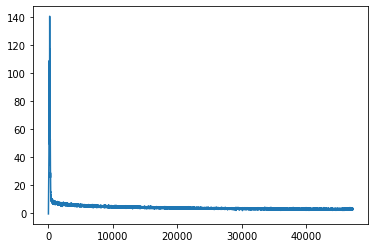

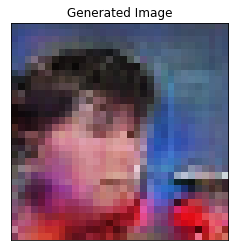

Iteration [45001/100000]......0.199(s) gen: 196.77490 - disc_fake: -196.38559 - disc_real: -193.70842 - disc_real: 2.67717
Iteration [45002/100000]......0.193(s) gen: 197.03461 - disc_fake: -196.32429 - disc_real: -193.99973 - disc_real: 2.32456
Iteration [45003/100000]......0.193(s) gen: 196.32040 - disc_fake: -196.80267 - disc_real: -194.26460 - disc_real: 2.53807
Iteration [45004/100000]......0.194(s) gen: 196.62050 - disc_fake: -196.51917 - disc_real: -194.19016 - disc_real: 2.32901
Iteration [45005/100000]......0.194(s) gen: 197.28131 - disc_fake: -196.80609 - disc_real: -194.13399 - disc_real: 2.67211
Iteration [45006/100000]......0.196(s) gen: 197.44183 - disc_fake: -197.24384 - disc_real: -194.25828 - disc_real: 2.98556
Iteration [45007/100000]......0.194(s) gen: 196.85349 - disc_fake: -197.14663 - disc_real: -194.37354 - disc_real: 2.77309
Iteration [45008/100000]......0.194(s) gen: 196.32965 - disc_fake: -196.92149 - disc_real: -193.88695 - disc_real: 3.03454
Iteration [45009

Iteration [45068/100000]......0.204(s) gen: 196.73758 - disc_fake: -196.29931 - disc_real: -193.76638 - disc_real: 2.53293
Iteration [45069/100000]......0.205(s) gen: 197.26208 - disc_fake: -196.68692 - disc_real: -194.20564 - disc_real: 2.48128
Iteration [45070/100000]......0.204(s) gen: 197.62997 - disc_fake: -197.39614 - disc_real: -194.63132 - disc_real: 2.76483
Iteration [45071/100000]......0.205(s) gen: 197.35211 - disc_fake: -197.46666 - disc_real: -194.89466 - disc_real: 2.57201
Iteration [45072/100000]......0.202(s) gen: 196.93442 - disc_fake: -197.39149 - disc_real: -194.46208 - disc_real: 2.92942
Iteration [45073/100000]......0.200(s) gen: 197.06671 - disc_fake: -197.19447 - disc_real: -194.35071 - disc_real: 2.84377
Iteration [45074/100000]......0.198(s) gen: 196.75600 - disc_fake: -196.77443 - disc_real: -193.91676 - disc_real: 2.85768
Iteration [45075/100000]......0.198(s) gen: 196.53860 - disc_fake: -196.49922 - disc_real: -193.50738 - disc_real: 2.99184
Iteration [45076

Iteration [45136/100000]......0.197(s) gen: 197.63431 - disc_fake: -197.22641 - disc_real: -194.70452 - disc_real: 2.52189
Iteration [45137/100000]......0.196(s) gen: 197.64435 - disc_fake: -197.41646 - disc_real: -194.99048 - disc_real: 2.42597
Iteration [45138/100000]......0.196(s) gen: 197.21652 - disc_fake: -197.50146 - disc_real: -194.74831 - disc_real: 2.75315
Iteration [45139/100000]......0.197(s) gen: 197.32220 - disc_fake: -197.17197 - disc_real: -194.35331 - disc_real: 2.81866
Iteration [45140/100000]......0.196(s) gen: 197.44975 - disc_fake: -197.31147 - disc_real: -194.68976 - disc_real: 2.62172
Iteration [45141/100000]......0.197(s) gen: 197.25337 - disc_fake: -197.36354 - disc_real: -194.31960 - disc_real: 3.04394
Iteration [45142/100000]......0.196(s) gen: 196.95392 - disc_fake: -197.18080 - disc_real: -194.14662 - disc_real: 3.03419
Iteration [45143/100000]......0.198(s) gen: 196.76210 - disc_fake: -197.09935 - disc_real: -193.88451 - disc_real: 3.21483
Iteration [45144

Iteration [45203/100000]......0.200(s) gen: 197.06873 - disc_fake: -196.94224 - disc_real: -194.14085 - disc_real: 2.80139
Iteration [45204/100000]......0.200(s) gen: 196.75005 - disc_fake: -196.95549 - disc_real: -194.15054 - disc_real: 2.80495
Iteration [45205/100000]......0.199(s) gen: 196.43202 - disc_fake: -196.71344 - disc_real: -194.06209 - disc_real: 2.65135
Iteration [45206/100000]......0.198(s) gen: 196.49928 - disc_fake: -196.69204 - disc_real: -193.71585 - disc_real: 2.97619
Iteration [45207/100000]......0.201(s) gen: 196.91428 - disc_fake: -196.42714 - disc_real: -193.81686 - disc_real: 2.61028
Iteration [45208/100000]......0.200(s) gen: 196.93555 - disc_fake: -196.88078 - disc_real: -193.96090 - disc_real: 2.91988
Iteration [45209/100000]......0.198(s) gen: 196.41238 - disc_fake: -196.67821 - disc_real: -193.77539 - disc_real: 2.90283
Iteration [45210/100000]......0.196(s) gen: 196.20749 - disc_fake: -196.40051 - disc_real: -193.56562 - disc_real: 2.83489
Iteration [45211

Iteration [45270/100000]......0.201(s) gen: 197.03986 - disc_fake: -197.02239 - disc_real: -194.79270 - disc_real: 2.22969
Iteration [45271/100000]......0.200(s) gen: 197.67313 - disc_fake: -197.33115 - disc_real: -194.75829 - disc_real: 2.57286
Iteration [45272/100000]......0.198(s) gen: 197.25397 - disc_fake: -197.39711 - disc_real: -194.57848 - disc_real: 2.81863
Iteration [45273/100000]......0.198(s) gen: 197.27536 - disc_fake: -197.28739 - disc_real: -194.42279 - disc_real: 2.86461
Iteration [45274/100000]......0.200(s) gen: 197.52510 - disc_fake: -197.27384 - disc_real: -194.59774 - disc_real: 2.67610
Iteration [45275/100000]......0.201(s) gen: 196.67703 - disc_fake: -197.15330 - disc_real: -194.45338 - disc_real: 2.69992
Iteration [45276/100000]......0.202(s) gen: 197.06305 - disc_fake: -197.17423 - disc_real: -193.86420 - disc_real: 3.31003
Iteration [45277/100000]......0.202(s) gen: 197.24403 - disc_fake: -196.95106 - disc_real: -194.02490 - disc_real: 2.92615
Iteration [45278

Iteration [45337/100000]......0.199(s) gen: 197.75223 - disc_fake: -197.30605 - disc_real: -194.59388 - disc_real: 2.71217
Iteration [45338/100000]......0.198(s) gen: 197.24527 - disc_fake: -197.47953 - disc_real: -194.63461 - disc_real: 2.84492
Iteration [45339/100000]......0.197(s) gen: 197.38647 - disc_fake: -197.20725 - disc_real: -194.20116 - disc_real: 3.00609
Iteration [45340/100000]......0.198(s) gen: 197.88870 - disc_fake: -197.59604 - disc_real: -194.67615 - disc_real: 2.91989
Iteration [45341/100000]......0.198(s) gen: 198.32310 - disc_fake: -198.19165 - disc_real: -195.51751 - disc_real: 2.67415
Iteration [45342/100000]......0.199(s) gen: 197.60217 - disc_fake: -198.26246 - disc_real: -195.44003 - disc_real: 2.82243
Iteration [45343/100000]......0.199(s) gen: 197.20349 - disc_fake: -197.78017 - disc_real: -194.96647 - disc_real: 2.81371
Iteration [45344/100000]......0.199(s) gen: 197.17163 - disc_fake: -197.15053 - disc_real: -194.74922 - disc_real: 2.40131
Iteration [45345

Iteration [45405/100000]......0.198(s) gen: 198.75830 - disc_fake: -198.22888 - disc_real: -195.49606 - disc_real: 2.73282
Iteration [45406/100000]......0.197(s) gen: 198.96960 - disc_fake: -198.64919 - disc_real: -195.86650 - disc_real: 2.78269
Iteration [45407/100000]......0.197(s) gen: 198.96310 - disc_fake: -199.04838 - disc_real: -196.07037 - disc_real: 2.97802
Iteration [45408/100000]......0.196(s) gen: 199.39046 - disc_fake: -199.18122 - disc_real: -196.07607 - disc_real: 3.10515
Iteration [45409/100000]......0.196(s) gen: 198.12639 - disc_fake: -198.66312 - disc_real: -195.88625 - disc_real: 2.77687
Iteration [45410/100000]......0.199(s) gen: 197.70604 - disc_fake: -198.06985 - disc_real: -195.23885 - disc_real: 2.83099
Iteration [45411/100000]......0.201(s) gen: 197.47856 - disc_fake: -197.67076 - disc_real: -195.09799 - disc_real: 2.57277
Iteration [45412/100000]......0.201(s) gen: 197.50864 - disc_fake: -197.56047 - disc_real: -194.73215 - disc_real: 2.82831
Iteration [45413

Iteration [45472/100000]......0.198(s) gen: 198.99098 - disc_fake: -198.79267 - disc_real: -195.79481 - disc_real: 2.99786
Iteration [45473/100000]......0.200(s) gen: 198.68964 - disc_fake: -198.54560 - disc_real: -195.73872 - disc_real: 2.80688
Iteration [45474/100000]......0.206(s) gen: 198.55093 - disc_fake: -198.11790 - disc_real: -195.79374 - disc_real: 2.32416
Iteration [45475/100000]......0.204(s) gen: 198.32524 - disc_fake: -198.22146 - disc_real: -195.81329 - disc_real: 2.40817
Iteration [45476/100000]......0.202(s) gen: 197.53096 - disc_fake: -198.10891 - disc_real: -195.12112 - disc_real: 2.98779
Iteration [45477/100000]......0.201(s) gen: 197.63367 - disc_fake: -197.52226 - disc_real: -194.72205 - disc_real: 2.80021
Iteration [45478/100000]......0.199(s) gen: 197.38605 - disc_fake: -197.51315 - disc_real: -194.23385 - disc_real: 3.27930
Iteration [45479/100000]......0.199(s) gen: 196.83478 - disc_fake: -197.21946 - disc_real: -194.29520 - disc_real: 2.92426
Iteration [45480

Iteration [45540/100000]......0.199(s) gen: 196.82777 - disc_fake: -197.19672 - disc_real: -194.14120 - disc_real: 3.05553
Iteration [45541/100000]......0.200(s) gen: 197.07532 - disc_fake: -196.74070 - disc_real: -194.31178 - disc_real: 2.42892
Iteration [45542/100000]......0.199(s) gen: 196.98640 - disc_fake: -196.95587 - disc_real: -194.15667 - disc_real: 2.79920
Iteration [45543/100000]......0.198(s) gen: 197.39523 - disc_fake: -196.92062 - disc_real: -193.78871 - disc_real: 3.13192
Iteration [45544/100000]......0.200(s) gen: 197.28622 - disc_fake: -197.22632 - disc_real: -194.71609 - disc_real: 2.51023
Iteration [45545/100000]......0.201(s) gen: 198.13159 - disc_fake: -197.75823 - disc_real: -195.16410 - disc_real: 2.59413
Iteration [45546/100000]......0.201(s) gen: 198.18469 - disc_fake: -198.02121 - disc_real: -195.15406 - disc_real: 2.86714
Iteration [45547/100000]......0.202(s) gen: 198.46265 - disc_fake: -198.33521 - disc_real: -195.84543 - disc_real: 2.48978
Iteration [45548

Iteration [45607/100000]......0.198(s) gen: 198.62909 - disc_fake: -198.93403 - disc_real: -195.97478 - disc_real: 2.95925
Iteration [45608/100000]......0.197(s) gen: 198.30736 - disc_fake: -198.35648 - disc_real: -195.70707 - disc_real: 2.64941
Iteration [45609/100000]......0.197(s) gen: 197.96640 - disc_fake: -198.26715 - disc_real: -195.34807 - disc_real: 2.91908
Iteration [45610/100000]......0.196(s) gen: 197.51802 - disc_fake: -197.99424 - disc_real: -195.12775 - disc_real: 2.86648
Iteration [45611/100000]......0.198(s) gen: 197.09125 - disc_fake: -197.39090 - disc_real: -194.71973 - disc_real: 2.67117
Iteration [45612/100000]......0.199(s) gen: 197.00375 - disc_fake: -197.08623 - disc_real: -194.25262 - disc_real: 2.83362
Iteration [45613/100000]......0.201(s) gen: 196.42038 - disc_fake: -196.95309 - disc_real: -194.09308 - disc_real: 2.86002
Iteration [45614/100000]......0.200(s) gen: 197.67981 - disc_fake: -197.11761 - disc_real: -194.70926 - disc_real: 2.40836
Iteration [45615

Iteration [45674/100000]......0.195(s) gen: 198.52180 - disc_fake: -198.25221 - disc_real: -195.54666 - disc_real: 2.70555
Iteration [45675/100000]......0.195(s) gen: 197.93292 - disc_fake: -198.37847 - disc_real: -195.51087 - disc_real: 2.86760
Iteration [45676/100000]......0.195(s) gen: 197.52791 - disc_fake: -198.05047 - disc_real: -194.53252 - disc_real: 3.51794
Iteration [45677/100000]......0.197(s) gen: 197.85187 - disc_fake: -197.56490 - disc_real: -195.22187 - disc_real: 2.34303
Iteration [45678/100000]......0.198(s) gen: 197.47644 - disc_fake: -197.59274 - disc_real: -194.78344 - disc_real: 2.80931
Iteration [45679/100000]......0.199(s) gen: 197.69409 - disc_fake: -197.65394 - disc_real: -194.98855 - disc_real: 2.66540
Iteration [45680/100000]......0.201(s) gen: 197.88602 - disc_fake: -197.93000 - disc_real: -194.68268 - disc_real: 3.24732
Iteration [45681/100000]......0.201(s) gen: 197.90927 - disc_fake: -197.74872 - disc_real: -194.73608 - disc_real: 3.01263
Iteration [45682

Iteration [45742/100000]......0.196(s) gen: 198.43362 - disc_fake: -198.08358 - disc_real: -195.54998 - disc_real: 2.53360
Iteration [45743/100000]......0.198(s) gen: 198.70361 - disc_fake: -198.20909 - disc_real: -195.85650 - disc_real: 2.35259
Iteration [45744/100000]......0.199(s) gen: 198.62543 - disc_fake: -198.47424 - disc_real: -195.81835 - disc_real: 2.65589
Iteration [45745/100000]......0.197(s) gen: 198.23119 - disc_fake: -198.34935 - disc_real: -195.49659 - disc_real: 2.85276
Iteration [45746/100000]......0.199(s) gen: 198.18549 - disc_fake: -198.12601 - disc_real: -195.60588 - disc_real: 2.52012
Iteration [45747/100000]......0.203(s) gen: 198.52325 - disc_fake: -198.46954 - disc_real: -195.59376 - disc_real: 2.87578
Iteration [45748/100000]......0.204(s) gen: 198.73956 - disc_fake: -198.79494 - disc_real: -196.22755 - disc_real: 2.56739
Iteration [45749/100000]......0.204(s) gen: 198.58212 - disc_fake: -198.69755 - disc_real: -195.92518 - disc_real: 2.77237
Iteration [45750

Iteration [45810/100000]......0.200(s) gen: 198.41153 - disc_fake: -198.30185 - disc_real: -195.19001 - disc_real: 3.11183
Iteration [45811/100000]......0.199(s) gen: 198.17430 - disc_fake: -198.52902 - disc_real: -195.47565 - disc_real: 3.05337
Iteration [45812/100000]......0.200(s) gen: 198.32452 - disc_fake: -197.62789 - disc_real: -195.06748 - disc_real: 2.56041
Iteration [45813/100000]......0.201(s) gen: 198.20401 - disc_fake: -198.10607 - disc_real: -195.52877 - disc_real: 2.57729
Iteration [45814/100000]......0.202(s) gen: 198.61189 - disc_fake: -198.24622 - disc_real: -195.61412 - disc_real: 2.63210
Iteration [45815/100000]......0.206(s) gen: 198.43950 - disc_fake: -198.54272 - disc_real: -195.75330 - disc_real: 2.78943
Iteration [45816/100000]......0.204(s) gen: 198.23399 - disc_fake: -198.26680 - disc_real: -195.50006 - disc_real: 2.76674
Iteration [45817/100000]......0.203(s) gen: 198.51329 - disc_fake: -198.45658 - disc_real: -195.39622 - disc_real: 3.06037
Iteration [45818

Iteration [45878/100000]......0.199(s) gen: 198.00208 - disc_fake: -198.26772 - disc_real: -195.28605 - disc_real: 2.98167
Iteration [45879/100000]......0.201(s) gen: 197.91646 - disc_fake: -197.93431 - disc_real: -195.87776 - disc_real: 2.05656
Iteration [45880/100000]......0.200(s) gen: 198.45764 - disc_fake: -198.25687 - disc_real: -195.67787 - disc_real: 2.57900
Iteration [45881/100000]......0.201(s) gen: 198.34293 - disc_fake: -198.40024 - disc_real: -195.41211 - disc_real: 2.98813
Iteration [45882/100000]......0.201(s) gen: 198.34937 - disc_fake: -198.45098 - disc_real: -195.58734 - disc_real: 2.86364
Iteration [45883/100000]......0.201(s) gen: 198.55133 - disc_fake: -198.49764 - disc_real: -195.94462 - disc_real: 2.55302
Iteration [45884/100000]......0.201(s) gen: 198.61057 - disc_fake: -198.57765 - disc_real: -196.03384 - disc_real: 2.54381
Iteration [45885/100000]......0.199(s) gen: 198.07309 - disc_fake: -198.46828 - disc_real: -195.79439 - disc_real: 2.67389
Iteration [45886

Iteration [45946/100000]......0.197(s) gen: 197.66852 - disc_fake: -197.82526 - disc_real: -194.85215 - disc_real: 2.97312
Iteration [45947/100000]......0.196(s) gen: 197.35309 - disc_fake: -197.44486 - disc_real: -194.49329 - disc_real: 2.95157
Iteration [45948/100000]......0.197(s) gen: 197.81128 - disc_fake: -197.49377 - disc_real: -194.64490 - disc_real: 2.84886
Iteration [45949/100000]......0.195(s) gen: 197.27509 - disc_fake: -197.55091 - disc_real: -195.01592 - disc_real: 2.53499
Iteration [45950/100000]......0.197(s) gen: 197.97510 - disc_fake: -197.75882 - disc_real: -195.13367 - disc_real: 2.62514
Iteration [45951/100000]......0.197(s) gen: 198.47255 - disc_fake: -198.08305 - disc_real: -195.40700 - disc_real: 2.67604
Iteration [45952/100000]......0.199(s) gen: 198.64471 - disc_fake: -198.54655 - disc_real: -196.00538 - disc_real: 2.54117
Iteration [45953/100000]......0.199(s) gen: 198.39282 - disc_fake: -198.34053 - disc_real: -195.58357 - disc_real: 2.75696
Iteration [45954

Iteration [46014/100000]......0.198(s) gen: 198.35966 - disc_fake: -198.30762 - disc_real: -195.59667 - disc_real: 2.71095
Iteration [46015/100000]......0.199(s) gen: 198.61824 - disc_fake: -198.34438 - disc_real: -195.60885 - disc_real: 2.73553
Iteration [46016/100000]......0.202(s) gen: 198.33212 - disc_fake: -198.53373 - disc_real: -195.69382 - disc_real: 2.83991
Iteration [46017/100000]......0.203(s) gen: 198.31599 - disc_fake: -198.48665 - disc_real: -195.76324 - disc_real: 2.72341
Iteration [46018/100000]......0.202(s) gen: 198.75124 - disc_fake: -198.46662 - disc_real: -195.76149 - disc_real: 2.70513
Iteration [46019/100000]......0.203(s) gen: 199.25468 - disc_fake: -198.70565 - disc_real: -196.22269 - disc_real: 2.48296
Iteration [46020/100000]......0.202(s) gen: 199.70908 - disc_fake: -199.27055 - disc_real: -196.21972 - disc_real: 3.05083
Iteration [46021/100000]......0.202(s) gen: 199.23544 - disc_fake: -199.16615 - disc_real: -196.66637 - disc_real: 2.49978
Iteration [46022

Iteration [46081/100000]......0.197(s) gen: 197.54218 - disc_fake: -197.44188 - disc_real: -195.11750 - disc_real: 2.32438
Iteration [46082/100000]......0.195(s) gen: 197.30579 - disc_fake: -197.49147 - disc_real: -195.01028 - disc_real: 2.48119
Iteration [46083/100000]......0.194(s) gen: 197.88132 - disc_fake: -197.39691 - disc_real: -195.00612 - disc_real: 2.39079
Iteration [46084/100000]......0.194(s) gen: 198.35349 - disc_fake: -198.02114 - disc_real: -195.60234 - disc_real: 2.41880
Iteration [46085/100000]......0.196(s) gen: 198.74930 - disc_fake: -198.52261 - disc_real: -195.58042 - disc_real: 2.94219
Iteration [46086/100000]......0.195(s) gen: 198.19073 - disc_fake: -198.63488 - disc_real: -195.78754 - disc_real: 2.84735
Iteration [46087/100000]......0.197(s) gen: 198.28784 - disc_fake: -198.10285 - disc_real: -195.32166 - disc_real: 2.78119
Iteration [46088/100000]......0.199(s) gen: 198.69730 - disc_fake: -198.37908 - disc_real: -195.92617 - disc_real: 2.45291
Iteration [46089

Iteration [46148/100000]......0.199(s) gen: 198.84961 - disc_fake: -198.46199 - disc_real: -196.11014 - disc_real: 2.35186
Iteration [46149/100000]......0.202(s) gen: 198.65108 - disc_fake: -198.54376 - disc_real: -195.89740 - disc_real: 2.64636
Iteration [46150/100000]......0.201(s) gen: 199.09030 - disc_fake: -198.73574 - disc_real: -195.83412 - disc_real: 2.90162
Iteration [46151/100000]......0.199(s) gen: 199.33701 - disc_fake: -199.01727 - disc_real: -196.09163 - disc_real: 2.92563
Iteration [46152/100000]......0.198(s) gen: 199.45370 - disc_fake: -199.09761 - disc_real: -196.19511 - disc_real: 2.90251
Iteration [46153/100000]......0.195(s) gen: 198.98953 - disc_fake: -199.07240 - disc_real: -196.32387 - disc_real: 2.74852
Iteration [46154/100000]......0.197(s) gen: 198.65286 - disc_fake: -198.65822 - disc_real: -196.01152 - disc_real: 2.64669
Iteration [46155/100000]......0.198(s) gen: 198.67258 - disc_fake: -198.71660 - disc_real: -196.10208 - disc_real: 2.61452
Iteration [46156

Iteration [46215/100000]......0.200(s) gen: 198.41003 - disc_fake: -198.51632 - disc_real: -195.76628 - disc_real: 2.75005
Iteration [46216/100000]......0.200(s) gen: 198.41396 - disc_fake: -198.43581 - disc_real: -195.86205 - disc_real: 2.57376
Iteration [46217/100000]......0.198(s) gen: 198.49629 - disc_fake: -198.54639 - disc_real: -195.90033 - disc_real: 2.64606
Iteration [46218/100000]......0.198(s) gen: 199.24486 - disc_fake: -198.63545 - disc_real: -196.06334 - disc_real: 2.57211
Iteration [46219/100000]......0.197(s) gen: 199.65285 - disc_fake: -199.47003 - disc_real: -196.71004 - disc_real: 2.75999
Iteration [46220/100000]......0.196(s) gen: 199.63612 - disc_fake: -199.55471 - disc_real: -197.11368 - disc_real: 2.44103
Iteration [46221/100000]......0.197(s) gen: 199.82599 - disc_fake: -199.70778 - disc_real: -197.16061 - disc_real: 2.54717
Iteration [46222/100000]......0.199(s) gen: 199.84241 - disc_fake: -199.82906 - disc_real: -196.90524 - disc_real: 2.92382
Iteration [46223

Iteration [46282/100000]......0.199(s) gen: 199.13000 - disc_fake: -199.26396 - disc_real: -196.39105 - disc_real: 2.87292
Iteration [46283/100000]......0.199(s) gen: 200.05988 - disc_fake: -199.68766 - disc_real: -196.89341 - disc_real: 2.79426
Iteration [46284/100000]......0.201(s) gen: 200.38736 - disc_fake: -200.46733 - disc_real: -197.83181 - disc_real: 2.63552
Iteration [46285/100000]......0.201(s) gen: 200.29514 - disc_fake: -200.59661 - disc_real: -197.89364 - disc_real: 2.70297
Iteration [46286/100000]......0.202(s) gen: 200.31755 - disc_fake: -200.32365 - disc_real: -197.82141 - disc_real: 2.50224
Iteration [46287/100000]......0.201(s) gen: 200.38200 - disc_fake: -200.22852 - disc_real: -197.45157 - disc_real: 2.77695
Iteration [46288/100000]......0.199(s) gen: 200.21524 - disc_fake: -200.23866 - disc_real: -197.46213 - disc_real: 2.77653
Iteration [46289/100000]......0.197(s) gen: 200.07968 - disc_fake: -200.15153 - disc_real: -197.24501 - disc_real: 2.90652
Iteration [46290

Iteration [46349/100000]......0.194(s) gen: 200.59567 - disc_fake: -199.74105 - disc_real: -196.84124 - disc_real: 2.89981
Iteration [46350/100000]......0.195(s) gen: 200.41650 - disc_fake: -199.82673 - disc_real: -197.04481 - disc_real: 2.78192
Iteration [46351/100000]......0.196(s) gen: 199.62909 - disc_fake: -199.64159 - disc_real: -197.20480 - disc_real: 2.43679
Iteration [46352/100000]......0.197(s) gen: 199.73776 - disc_fake: -199.67093 - disc_real: -196.96609 - disc_real: 2.70484
Iteration [46353/100000]......0.197(s) gen: 199.13205 - disc_fake: -199.38773 - disc_real: -196.38537 - disc_real: 3.00236
Iteration [46354/100000]......0.198(s) gen: 199.35342 - disc_fake: -199.09074 - disc_real: -195.94272 - disc_real: 3.14802
Iteration [46355/100000]......0.198(s) gen: 198.28596 - disc_fake: -199.08592 - disc_real: -196.01898 - disc_real: 3.06693
Iteration [46356/100000]......0.197(s) gen: 198.84528 - disc_fake: -198.58126 - disc_real: -196.15095 - disc_real: 2.43031
Iteration [46357

Iteration [46416/100000]......0.200(s) gen: 200.19846 - disc_fake: -199.89174 - disc_real: -197.22832 - disc_real: 2.66342
Iteration [46417/100000]......0.198(s) gen: 200.78915 - disc_fake: -200.23582 - disc_real: -197.62490 - disc_real: 2.61092
Iteration [46418/100000]......0.197(s) gen: 200.18085 - disc_fake: -200.00064 - disc_real: -197.36768 - disc_real: 2.63297
Iteration [46419/100000]......0.197(s) gen: 199.91335 - disc_fake: -200.03016 - disc_real: -197.52057 - disc_real: 2.50959
Iteration [46420/100000]......0.198(s) gen: 199.91362 - disc_fake: -200.03157 - disc_real: -197.26285 - disc_real: 2.76872
Iteration [46421/100000]......0.198(s) gen: 199.86172 - disc_fake: -199.95808 - disc_real: -196.81084 - disc_real: 3.14724
Iteration [46422/100000]......0.201(s) gen: 199.44043 - disc_fake: -199.20154 - disc_real: -196.49092 - disc_real: 2.71061
Iteration [46423/100000]......0.200(s) gen: 198.95490 - disc_fake: -199.17914 - disc_real: -196.43758 - disc_real: 2.74156
Iteration [46424

Iteration [46483/100000]......0.203(s) gen: 201.28336 - disc_fake: -200.78490 - disc_real: -197.89082 - disc_real: 2.89408
Iteration [46484/100000]......0.202(s) gen: 201.20694 - disc_fake: -201.21822 - disc_real: -198.48664 - disc_real: 2.73158
Iteration [46485/100000]......0.201(s) gen: 200.85785 - disc_fake: -201.12709 - disc_real: -198.16703 - disc_real: 2.96006
Iteration [46486/100000]......0.202(s) gen: 200.99759 - disc_fake: -200.93306 - disc_real: -197.99720 - disc_real: 2.93587
Iteration [46487/100000]......0.201(s) gen: 201.03761 - disc_fake: -201.25842 - disc_real: -198.39457 - disc_real: 2.86385
Iteration [46488/100000]......0.198(s) gen: 200.73184 - disc_fake: -200.62260 - disc_real: -197.97564 - disc_real: 2.64696
Iteration [46489/100000]......0.197(s) gen: 200.28751 - disc_fake: -200.25042 - disc_real: -197.62884 - disc_real: 2.62158
Iteration [46490/100000]......0.197(s) gen: 200.14648 - disc_fake: -200.13563 - disc_real: -197.00278 - disc_real: 3.13285
Iteration [46491

Iteration [46550/100000]......0.196(s) gen: 199.88960 - disc_fake: -199.96849 - disc_real: -197.52263 - disc_real: 2.44586
Iteration [46551/100000]......0.194(s) gen: 199.85628 - disc_fake: -200.15286 - disc_real: -197.52422 - disc_real: 2.62864
Iteration [46552/100000]......0.195(s) gen: 199.35852 - disc_fake: -199.66341 - disc_real: -196.66212 - disc_real: 3.00129
Iteration [46553/100000]......0.199(s) gen: 198.76616 - disc_fake: -199.41826 - disc_real: -196.16176 - disc_real: 3.25650
Iteration [46554/100000]......0.202(s) gen: 199.53165 - disc_fake: -199.01216 - disc_real: -196.30126 - disc_real: 2.71090
Iteration [46555/100000]......0.206(s) gen: 199.36389 - disc_fake: -199.43519 - disc_real: -196.96396 - disc_real: 2.47123
Iteration [46556/100000]......0.206(s) gen: 199.47504 - disc_fake: -199.67691 - disc_real: -197.17385 - disc_real: 2.50307
Iteration [46557/100000]......0.206(s) gen: 200.92514 - disc_fake: -200.04140 - disc_real: -197.29687 - disc_real: 2.74453
Iteration [46558

Iteration [46617/100000]......0.205(s) gen: 200.23514 - disc_fake: -200.56695 - disc_real: -197.52831 - disc_real: 3.03864
Iteration [46618/100000]......0.207(s) gen: 200.56349 - disc_fake: -200.44180 - disc_real: -197.51426 - disc_real: 2.92753
Iteration [46619/100000]......0.205(s) gen: 200.90939 - disc_fake: -200.74524 - disc_real: -197.86049 - disc_real: 2.88475
Iteration [46620/100000]......0.203(s) gen: 200.80949 - disc_fake: -201.21112 - disc_real: -197.92631 - disc_real: 3.28481
Iteration [46621/100000]......0.201(s) gen: 201.37828 - disc_fake: -200.75825 - disc_real: -198.58871 - disc_real: 2.16954
Iteration [46622/100000]......0.199(s) gen: 201.14316 - disc_fake: -201.47578 - disc_real: -198.44120 - disc_real: 3.03459
Iteration [46623/100000]......0.198(s) gen: 200.97852 - disc_fake: -200.92825 - disc_real: -198.24549 - disc_real: 2.68276
Iteration [46624/100000]......0.196(s) gen: 200.90363 - disc_fake: -201.14359 - disc_real: -198.54940 - disc_real: 2.59419
Iteration [46625

Iteration [46684/100000]......0.193(s) gen: 199.86404 - disc_fake: -199.86584 - disc_real: -196.83812 - disc_real: 3.02772
Iteration [46685/100000]......0.193(s) gen: 200.26913 - disc_fake: -199.95750 - disc_real: -197.21935 - disc_real: 2.73815
Iteration [46686/100000]......0.193(s) gen: 201.05411 - disc_fake: -200.69666 - disc_real: -197.86718 - disc_real: 2.82948
Iteration [46687/100000]......0.193(s) gen: 201.43265 - disc_fake: -201.42667 - disc_real: -198.66375 - disc_real: 2.76292
Iteration [46688/100000]......0.194(s) gen: 201.24281 - disc_fake: -201.88896 - disc_real: -198.75527 - disc_real: 3.13369
Iteration [46689/100000]......0.194(s) gen: 201.24448 - disc_fake: -201.76937 - disc_real: -198.86059 - disc_real: 2.90878
Iteration [46690/100000]......0.194(s) gen: 201.40027 - disc_fake: -201.37226 - disc_real: -198.53363 - disc_real: 2.83863
Iteration [46691/100000]......0.195(s) gen: 201.51230 - disc_fake: -201.19518 - disc_real: -198.43046 - disc_real: 2.76472
Iteration [46692

Iteration [46751/100000]......0.206(s) gen: 199.59883 - disc_fake: -200.38375 - disc_real: -197.32110 - disc_real: 3.06265
Iteration [46752/100000]......0.206(s) gen: 200.84308 - disc_fake: -200.22399 - disc_real: -197.74248 - disc_real: 2.48152
Iteration [46753/100000]......0.203(s) gen: 201.17842 - disc_fake: -201.29710 - disc_real: -198.61613 - disc_real: 2.68097
Iteration [46754/100000]......0.203(s) gen: 200.92163 - disc_fake: -200.96736 - disc_real: -198.38893 - disc_real: 2.57843
Iteration [46755/100000]......0.201(s) gen: 201.10641 - disc_fake: -200.95193 - disc_real: -198.29846 - disc_real: 2.65346
Iteration [46756/100000]......0.198(s) gen: 200.93628 - disc_fake: -200.92403 - disc_real: -198.18402 - disc_real: 2.74001
Iteration [46757/100000]......0.198(s) gen: 200.65358 - disc_fake: -200.65669 - disc_real: -198.03029 - disc_real: 2.62640
Iteration [46758/100000]......0.199(s) gen: 200.51074 - disc_fake: -200.83050 - disc_real: -198.02760 - disc_real: 2.80290
Iteration [46759

Iteration [46818/100000]......0.205(s) gen: 201.24944 - disc_fake: -201.00090 - disc_real: -198.25862 - disc_real: 2.74228
Iteration [46819/100000]......0.203(s) gen: 201.39163 - disc_fake: -201.13711 - disc_real: -198.81576 - disc_real: 2.32135
Iteration [46820/100000]......0.200(s) gen: 201.27490 - disc_fake: -201.59292 - disc_real: -198.49606 - disc_real: 3.09686
Iteration [46821/100000]......0.202(s) gen: 201.46385 - disc_fake: -201.40823 - disc_real: -198.28085 - disc_real: 3.12739
Iteration [46822/100000]......0.201(s) gen: 200.75323 - disc_fake: -200.80515 - disc_real: -198.07277 - disc_real: 2.73239
Iteration [46823/100000]......0.200(s) gen: 200.78168 - disc_fake: -200.61335 - disc_real: -198.15686 - disc_real: 2.45649
Iteration [46824/100000]......0.199(s) gen: 200.24298 - disc_fake: -200.64402 - disc_real: -197.85594 - disc_real: 2.78808
Iteration [46825/100000]......0.200(s) gen: 200.19011 - disc_fake: -200.43420 - disc_real: -197.61266 - disc_real: 2.82154
Iteration [46826

Iteration [46885/100000]......0.204(s) gen: 200.77071 - disc_fake: -200.73526 - disc_real: -197.81058 - disc_real: 2.92467
Iteration [46886/100000]......0.204(s) gen: 200.75287 - disc_fake: -200.77985 - disc_real: -198.11199 - disc_real: 2.66786
Iteration [46887/100000]......0.202(s) gen: 201.41295 - disc_fake: -201.02534 - disc_real: -198.34962 - disc_real: 2.67572
Iteration [46888/100000]......0.202(s) gen: 201.82167 - disc_fake: -201.18265 - disc_real: -198.57059 - disc_real: 2.61206
Iteration [46889/100000]......0.202(s) gen: 202.28453 - disc_fake: -201.97830 - disc_real: -199.10263 - disc_real: 2.87567
Iteration [46890/100000]......0.202(s) gen: 202.34653 - disc_fake: -201.99314 - disc_real: -199.45768 - disc_real: 2.53546
Iteration [46891/100000]......0.198(s) gen: 202.16815 - disc_fake: -202.13783 - disc_real: -199.32520 - disc_real: 2.81264
Iteration [46892/100000]......0.198(s) gen: 201.78946 - disc_fake: -201.99181 - disc_real: -199.14254 - disc_real: 2.84926
Iteration [46893

Iteration [46952/100000]......0.198(s) gen: 200.64728 - disc_fake: -200.82959 - disc_real: -197.80605 - disc_real: 3.02353
Iteration [46953/100000]......0.197(s) gen: 200.31555 - disc_fake: -200.36276 - disc_real: -197.31648 - disc_real: 3.04629
Iteration [46954/100000]......0.198(s) gen: 200.71112 - disc_fake: -200.20178 - disc_real: -197.64889 - disc_real: 2.55289
Iteration [46955/100000]......0.198(s) gen: 201.07011 - disc_fake: -200.58039 - disc_real: -198.03375 - disc_real: 2.54664
Iteration [46956/100000]......0.197(s) gen: 201.95134 - disc_fake: -201.52505 - disc_real: -198.81567 - disc_real: 2.70938
Iteration [46957/100000]......0.198(s) gen: 202.19257 - disc_fake: -202.23005 - disc_real: -199.52205 - disc_real: 2.70800
Iteration [46958/100000]......0.200(s) gen: 202.37149 - disc_fake: -202.30326 - disc_real: -199.64192 - disc_real: 2.66134
Iteration [46959/100000]......0.200(s) gen: 202.47260 - disc_fake: -202.30672 - disc_real: -199.94856 - disc_real: 2.35815
Iteration [46960

Iteration [47019/100000]......0.201(s) gen: 200.55820 - disc_fake: -199.86220 - disc_real: -197.12321 - disc_real: 2.73898
Iteration [47020/100000]......0.203(s) gen: 201.50444 - disc_fake: -200.76201 - disc_real: -198.43134 - disc_real: 2.33066
Iteration [47021/100000]......0.203(s) gen: 202.06329 - disc_fake: -201.46517 - disc_real: -198.93401 - disc_real: 2.53117
Iteration [47022/100000]......0.203(s) gen: 201.96758 - disc_fake: -202.00710 - disc_real: -199.17541 - disc_real: 2.83169
Iteration [47023/100000]......0.202(s) gen: 201.93317 - disc_fake: -201.91966 - disc_real: -198.99777 - disc_real: 2.92189
Iteration [47024/100000]......0.204(s) gen: 202.24089 - disc_fake: -202.20055 - disc_real: -199.12899 - disc_real: 3.07155
Iteration [47025/100000]......0.207(s) gen: 202.50241 - disc_fake: -201.98701 - disc_real: -199.02266 - disc_real: 2.96435
Iteration [47026/100000]......0.213(s) gen: 202.54095 - disc_fake: -202.37176 - disc_real: -199.37744 - disc_real: 2.99431
Iteration [47027

Iteration [47086/100000]......0.199(s) gen: 201.61111 - disc_fake: -201.32609 - disc_real: -198.86808 - disc_real: 2.45801
Iteration [47087/100000]......0.198(s) gen: 202.00327 - disc_fake: -201.70629 - disc_real: -198.76836 - disc_real: 2.93793
Iteration [47088/100000]......0.198(s) gen: 202.10039 - disc_fake: -201.87081 - disc_real: -199.26663 - disc_real: 2.60417
Iteration [47089/100000]......0.198(s) gen: 202.12540 - disc_fake: -201.96580 - disc_real: -199.35511 - disc_real: 2.61069
Iteration [47090/100000]......0.199(s) gen: 202.25844 - disc_fake: -202.38055 - disc_real: -199.30902 - disc_real: 3.07153
Iteration [47091/100000]......0.198(s) gen: 202.35266 - disc_fake: -202.25898 - disc_real: -199.29292 - disc_real: 2.96606
Iteration [47092/100000]......0.201(s) gen: 202.15370 - disc_fake: -202.09879 - disc_real: -199.45609 - disc_real: 2.64269
Iteration [47093/100000]......0.202(s) gen: 202.04500 - disc_fake: -201.93298 - disc_real: -199.10804 - disc_real: 2.82493
Iteration [47094

Iteration [47153/100000]......0.202(s) gen: 201.60054 - disc_fake: -202.02357 - disc_real: -199.42619 - disc_real: 2.59738
Iteration [47154/100000]......0.201(s) gen: 201.42943 - disc_fake: -201.61063 - disc_real: -198.58802 - disc_real: 3.02260
Iteration [47155/100000]......0.201(s) gen: 200.96371 - disc_fake: -201.25558 - disc_real: -198.47172 - disc_real: 2.78386
Iteration [47156/100000]......0.200(s) gen: 200.81906 - disc_fake: -200.77722 - disc_real: -197.98282 - disc_real: 2.79439
Iteration [47157/100000]......0.197(s) gen: 201.01788 - disc_fake: -200.73429 - disc_real: -198.41551 - disc_real: 2.31878
Iteration [47158/100000]......0.195(s) gen: 200.62172 - disc_fake: -200.71421 - disc_real: -198.16807 - disc_real: 2.54614
Iteration [47159/100000]......0.198(s) gen: 200.97937 - disc_fake: -200.78572 - disc_real: -198.14067 - disc_real: 2.64505
Iteration [47160/100000]......0.198(s) gen: 201.46991 - disc_fake: -201.08987 - disc_real: -198.74157 - disc_real: 2.34830
Iteration [47161

Iteration [47220/100000]......0.207(s) gen: 201.71255 - disc_fake: -201.62766 - disc_real: -198.56550 - disc_real: 3.06216
Iteration [47221/100000]......0.208(s) gen: 201.84999 - disc_fake: -201.55834 - disc_real: -199.26480 - disc_real: 2.29354
Iteration [47222/100000]......0.206(s) gen: 201.82202 - disc_fake: -201.81064 - disc_real: -198.91707 - disc_real: 2.89358
Iteration [47223/100000]......0.205(s) gen: 202.15112 - disc_fake: -201.79218 - disc_real: -199.38124 - disc_real: 2.41094
Iteration [47224/100000]......0.202(s) gen: 202.27509 - disc_fake: -202.28412 - disc_real: -199.65587 - disc_real: 2.62825
Iteration [47225/100000]......0.200(s) gen: 202.67328 - disc_fake: -202.58146 - disc_real: -199.88777 - disc_real: 2.69369
Iteration [47226/100000]......0.198(s) gen: 202.24916 - disc_fake: -202.59388 - disc_real: -199.52149 - disc_real: 3.07238
Iteration [47227/100000]......0.201(s) gen: 202.02719 - disc_fake: -202.07957 - disc_real: -199.08549 - disc_real: 2.99409
Iteration [47228

Iteration [47288/100000]......0.198(s) gen: 201.57077 - disc_fake: -201.50037 - disc_real: -198.31165 - disc_real: 3.18872
Iteration [47289/100000]......0.196(s) gen: 201.47128 - disc_fake: -201.39281 - disc_real: -198.53440 - disc_real: 2.85841
Iteration [47290/100000]......0.197(s) gen: 201.46497 - disc_fake: -201.07164 - disc_real: -198.57946 - disc_real: 2.49218
Iteration [47291/100000]......0.198(s) gen: 202.07634 - disc_fake: -201.46992 - disc_real: -198.74925 - disc_real: 2.72068
Iteration [47292/100000]......0.197(s) gen: 201.63469 - disc_fake: -201.63745 - disc_real: -199.15477 - disc_real: 2.48268
Iteration [47293/100000]......0.197(s) gen: 202.02338 - disc_fake: -201.64565 - disc_real: -199.32983 - disc_real: 2.31582
Iteration [47294/100000]......0.197(s) gen: 201.75604 - disc_fake: -202.12698 - disc_real: -199.47025 - disc_real: 2.65673
Iteration [47295/100000]......0.196(s) gen: 201.17383 - disc_fake: -201.54243 - disc_real: -198.98853 - disc_real: 2.55389
Iteration [47296

Iteration [47355/100000]......0.202(s) gen: 202.11090 - disc_fake: -201.80391 - disc_real: -198.94347 - disc_real: 2.86044
Iteration [47356/100000]......0.202(s) gen: 201.48001 - disc_fake: -201.79690 - disc_real: -199.13564 - disc_real: 2.66126
Iteration [47357/100000]......0.203(s) gen: 201.69708 - disc_fake: -201.61023 - disc_real: -198.85248 - disc_real: 2.75775
Iteration [47358/100000]......0.204(s) gen: 202.10510 - disc_fake: -201.98277 - disc_real: -199.19229 - disc_real: 2.79047
Iteration [47359/100000]......0.207(s) gen: 202.21208 - disc_fake: -202.29264 - disc_real: -199.70225 - disc_real: 2.59039
Iteration [47360/100000]......0.208(s) gen: 201.96188 - disc_fake: -202.08748 - disc_real: -199.55971 - disc_real: 2.52777
Iteration [47361/100000]......0.208(s) gen: 202.77539 - disc_fake: -202.28276 - disc_real: -199.59031 - disc_real: 2.69246
Iteration [47362/100000]......0.205(s) gen: 202.72260 - disc_fake: -202.54544 - disc_real: -199.75541 - disc_real: 2.79003
Iteration [47363

Iteration [47422/100000]......0.198(s) gen: 202.18253 - disc_fake: -202.23923 - disc_real: -199.63069 - disc_real: 2.60854
Iteration [47423/100000]......0.203(s) gen: 202.41937 - disc_fake: -202.31633 - disc_real: -199.64806 - disc_real: 2.66826
Iteration [47424/100000]......0.203(s) gen: 202.65211 - disc_fake: -202.50369 - disc_real: -199.77475 - disc_real: 2.72894
Iteration [47425/100000]......0.202(s) gen: 202.62582 - disc_fake: -202.75815 - disc_real: -200.15066 - disc_real: 2.60749
Iteration [47426/100000]......0.201(s) gen: 202.66238 - disc_fake: -202.56583 - disc_real: -200.06581 - disc_real: 2.50002
Iteration [47427/100000]......0.202(s) gen: 202.57123 - disc_fake: -202.77952 - disc_real: -199.87974 - disc_real: 2.89978
Iteration [47428/100000]......0.203(s) gen: 202.50323 - disc_fake: -202.61326 - disc_real: -199.95090 - disc_real: 2.66237
Iteration [47429/100000]......0.202(s) gen: 202.09552 - disc_fake: -202.29093 - disc_real: -199.35278 - disc_real: 2.93815
Iteration [47430

Iteration [47489/100000]......0.198(s) gen: 202.83755 - disc_fake: -202.78516 - disc_real: -199.91979 - disc_real: 2.86537
Iteration [47490/100000]......0.199(s) gen: 202.76906 - disc_fake: -202.71425 - disc_real: -199.82597 - disc_real: 2.88828
Iteration [47491/100000]......0.198(s) gen: 202.67661 - disc_fake: -202.76520 - disc_real: -199.91328 - disc_real: 2.85193
Iteration [47492/100000]......0.197(s) gen: 202.77478 - disc_fake: -202.54188 - disc_real: -199.69857 - disc_real: 2.84331
Iteration [47493/100000]......0.197(s) gen: 202.86606 - disc_fake: -202.39334 - disc_real: -199.71588 - disc_real: 2.67747
Iteration [47494/100000]......0.196(s) gen: 202.24066 - disc_fake: -202.32027 - disc_real: -199.60088 - disc_real: 2.71939
Iteration [47495/100000]......0.200(s) gen: 202.34143 - disc_fake: -202.36807 - disc_real: -199.19559 - disc_real: 3.17249
Iteration [47496/100000]......0.201(s) gen: 201.64862 - disc_fake: -201.96279 - disc_real: -199.13202 - disc_real: 2.83078
Iteration [47497

Iteration [47556/100000]......0.205(s) gen: 202.14801 - disc_fake: -201.81440 - disc_real: -198.90100 - disc_real: 2.91340
Iteration [47557/100000]......0.205(s) gen: 201.82945 - disc_fake: -201.76889 - disc_real: -199.06005 - disc_real: 2.70884
Iteration [47558/100000]......0.206(s) gen: 202.09410 - disc_fake: -201.89490 - disc_real: -199.33163 - disc_real: 2.56327
Iteration [47559/100000]......0.209(s) gen: 202.47353 - disc_fake: -202.20087 - disc_real: -199.63552 - disc_real: 2.56535
Iteration [47560/100000]......0.211(s) gen: 202.76300 - disc_fake: -202.35295 - disc_real: -199.64843 - disc_real: 2.70452
Iteration [47561/100000]......0.211(s) gen: 202.37491 - disc_fake: -202.42357 - disc_real: -199.68119 - disc_real: 2.74238
Iteration [47562/100000]......0.207(s) gen: 202.48337 - disc_fake: -202.46562 - disc_real: -199.24373 - disc_real: 3.22190
Iteration [47563/100000]......0.206(s) gen: 202.54294 - disc_fake: -202.21880 - disc_real: -199.57906 - disc_real: 2.63975
Iteration [47564

Iteration [47623/100000]......0.202(s) gen: 204.70490 - disc_fake: -204.36645 - disc_real: -201.42103 - disc_real: 2.94541
Iteration [47624/100000]......0.200(s) gen: 204.28885 - disc_fake: -204.53788 - disc_real: -201.79958 - disc_real: 2.73830
Iteration [47625/100000]......0.199(s) gen: 203.56378 - disc_fake: -203.78560 - disc_real: -201.21505 - disc_real: 2.57055
Iteration [47626/100000]......0.194(s) gen: 203.23096 - disc_fake: -203.61992 - disc_real: -200.76557 - disc_real: 2.85435
Iteration [47627/100000]......0.196(s) gen: 202.87692 - disc_fake: -203.40682 - disc_real: -200.59140 - disc_real: 2.81541
Iteration [47628/100000]......0.198(s) gen: 202.00552 - disc_fake: -202.56908 - disc_real: -199.94520 - disc_real: 2.62388
Iteration [47629/100000]......0.197(s) gen: 202.34402 - disc_fake: -202.29665 - disc_real: -199.40987 - disc_real: 2.88678
Iteration [47630/100000]......0.197(s) gen: 202.26343 - disc_fake: -202.25369 - disc_real: -199.60733 - disc_real: 2.64636
Iteration [47631

Iteration [47691/100000]......0.200(s) gen: 202.53369 - disc_fake: -202.42090 - disc_real: -199.93323 - disc_real: 2.48767
Iteration [47692/100000]......0.198(s) gen: 202.78136 - disc_fake: -202.72705 - disc_real: -200.22924 - disc_real: 2.49781
Iteration [47693/100000]......0.198(s) gen: 202.96898 - disc_fake: -202.59569 - disc_real: -199.83700 - disc_real: 2.75869
Iteration [47694/100000]......0.196(s) gen: 203.04340 - disc_fake: -203.01241 - disc_real: -200.35476 - disc_real: 2.65765
Iteration [47695/100000]......0.197(s) gen: 202.96518 - disc_fake: -203.17104 - disc_real: -200.22225 - disc_real: 2.94879
Iteration [47696/100000]......0.195(s) gen: 202.84567 - disc_fake: -202.69924 - disc_real: -199.72310 - disc_real: 2.97614
Iteration [47697/100000]......0.196(s) gen: 203.21756 - disc_fake: -202.60977 - disc_real: -200.20516 - disc_real: 2.40462
Iteration [47698/100000]......0.197(s) gen: 203.26334 - disc_fake: -203.05816 - disc_real: -200.24835 - disc_real: 2.80981
Iteration [47699

Iteration [47758/100000]......0.202(s) gen: 202.97186 - disc_fake: -203.15605 - disc_real: -200.35526 - disc_real: 2.80080
Iteration [47759/100000]......0.200(s) gen: 203.05406 - disc_fake: -202.96424 - disc_real: -199.96530 - disc_real: 2.99894
Iteration [47760/100000]......0.198(s) gen: 203.01807 - disc_fake: -202.57864 - disc_real: -199.88971 - disc_real: 2.68894
Iteration [47761/100000]......0.197(s) gen: 202.83769 - disc_fake: -202.85169 - disc_real: -200.13545 - disc_real: 2.71624
Iteration [47762/100000]......0.196(s) gen: 203.14059 - disc_fake: -202.72811 - disc_real: -200.28995 - disc_real: 2.43816
Iteration [47763/100000]......0.198(s) gen: 203.71136 - disc_fake: -203.33281 - disc_real: -200.59781 - disc_real: 2.73500
Iteration [47764/100000]......0.197(s) gen: 203.35300 - disc_fake: -203.17298 - disc_real: -200.46771 - disc_real: 2.70527
Iteration [47765/100000]......0.199(s) gen: 203.66470 - disc_fake: -203.47147 - disc_real: -200.71891 - disc_real: 2.75256
Iteration [47766

Iteration [47825/100000]......0.201(s) gen: 202.78700 - disc_fake: -202.82110 - disc_real: -200.38080 - disc_real: 2.44030
Iteration [47826/100000]......0.203(s) gen: 202.75851 - disc_fake: -202.73878 - disc_real: -199.97084 - disc_real: 2.76794
Iteration [47827/100000]......0.202(s) gen: 202.03459 - disc_fake: -202.41627 - disc_real: -199.26045 - disc_real: 3.15582
Iteration [47828/100000]......0.202(s) gen: 201.94295 - disc_fake: -202.18401 - disc_real: -199.59300 - disc_real: 2.59101
Iteration [47829/100000]......0.200(s) gen: 201.85162 - disc_fake: -202.16836 - disc_real: -199.41154 - disc_real: 2.75682
Iteration [47830/100000]......0.199(s) gen: 201.78595 - disc_fake: -202.19139 - disc_real: -198.93535 - disc_real: 3.25604
Iteration [47831/100000]......0.197(s) gen: 201.06990 - disc_fake: -201.37176 - disc_real: -198.94661 - disc_real: 2.42515
Iteration [47832/100000]......0.196(s) gen: 201.86346 - disc_fake: -201.49907 - disc_real: -198.93691 - disc_real: 2.56216
Iteration [47833

Iteration [47892/100000]......0.196(s) gen: 203.19684 - disc_fake: -203.88650 - disc_real: -200.73741 - disc_real: 3.14908
Iteration [47893/100000]......0.198(s) gen: 202.95981 - disc_fake: -203.34336 - disc_real: -200.43795 - disc_real: 2.90541
Iteration [47894/100000]......0.195(s) gen: 202.43709 - disc_fake: -202.49175 - disc_real: -200.07201 - disc_real: 2.41974
Iteration [47895/100000]......0.198(s) gen: 202.25995 - disc_fake: -202.64277 - disc_real: -199.95861 - disc_real: 2.68416
Iteration [47896/100000]......0.197(s) gen: 203.39148 - disc_fake: -202.72580 - disc_real: -200.63156 - disc_real: 2.09424
Iteration [47897/100000]......0.198(s) gen: 203.74629 - disc_fake: -203.27202 - disc_real: -201.11440 - disc_real: 2.15761
Iteration [47898/100000]......0.196(s) gen: 204.21523 - disc_fake: -204.07664 - disc_real: -201.05652 - disc_real: 3.02013
Iteration [47899/100000]......0.195(s) gen: 204.68918 - disc_fake: -203.89251 - disc_real: -201.31276 - disc_real: 2.57975
Iteration [47900

Iteration [47959/100000]......0.198(s) gen: 202.90433 - disc_fake: -202.92552 - disc_real: -200.49597 - disc_real: 2.42956
Iteration [47960/100000]......0.199(s) gen: 202.66698 - disc_fake: -202.61100 - disc_real: -200.31335 - disc_real: 2.29765
Iteration [47961/100000]......0.199(s) gen: 202.82718 - disc_fake: -202.61130 - disc_real: -200.03603 - disc_real: 2.57527
Iteration [47962/100000]......0.197(s) gen: 202.39883 - disc_fake: -202.79193 - disc_real: -199.97284 - disc_real: 2.81909
Iteration [47963/100000]......0.199(s) gen: 202.87289 - disc_fake: -202.86961 - disc_real: -200.02327 - disc_real: 2.84634
Iteration [47964/100000]......0.197(s) gen: 202.97885 - disc_fake: -202.93827 - disc_real: -199.98989 - disc_real: 2.94838
Iteration [47965/100000]......0.198(s) gen: 203.56888 - disc_fake: -203.29193 - disc_real: -200.55618 - disc_real: 2.73575
Iteration [47966/100000]......0.197(s) gen: 203.40924 - disc_fake: -203.33245 - disc_real: -200.45966 - disc_real: 2.87280
Iteration [47967

Iteration [48026/100000]......0.199(s) gen: 203.85904 - disc_fake: -203.46417 - disc_real: -201.02790 - disc_real: 2.43627
Iteration [48027/100000]......0.199(s) gen: 203.85718 - disc_fake: -204.15465 - disc_real: -201.10999 - disc_real: 3.04465
Iteration [48028/100000]......0.199(s) gen: 203.50940 - disc_fake: -203.66909 - disc_real: -200.80826 - disc_real: 2.86083
Iteration [48029/100000]......0.200(s) gen: 202.86255 - disc_fake: -202.99855 - disc_real: -200.38324 - disc_real: 2.61531
Iteration [48030/100000]......0.197(s) gen: 202.79797 - disc_fake: -202.76200 - disc_real: -200.26857 - disc_real: 2.49343
Iteration [48031/100000]......0.198(s) gen: 202.27582 - disc_fake: -202.47719 - disc_real: -199.56604 - disc_real: 2.91115
Iteration [48032/100000]......0.197(s) gen: 202.37007 - disc_fake: -202.21429 - disc_real: -199.86013 - disc_real: 2.35416
Iteration [48033/100000]......0.197(s) gen: 203.21213 - disc_fake: -202.59762 - disc_real: -199.99977 - disc_real: 2.59786
Iteration [48034

Iteration [48094/100000]......0.201(s) gen: 203.72159 - disc_fake: -203.57912 - disc_real: -200.87675 - disc_real: 2.70236
Iteration [48095/100000]......0.202(s) gen: 203.38702 - disc_fake: -203.57200 - disc_real: -200.76619 - disc_real: 2.80581
Iteration [48096/100000]......0.200(s) gen: 203.78275 - disc_fake: -203.54652 - disc_real: -200.44802 - disc_real: 3.09850
Iteration [48097/100000]......0.199(s) gen: 203.43428 - disc_fake: -203.50347 - disc_real: -200.75990 - disc_real: 2.74357
Iteration [48098/100000]......0.197(s) gen: 203.39354 - disc_fake: -203.66762 - disc_real: -200.29266 - disc_real: 3.37496
Iteration [48099/100000]......0.199(s) gen: 203.15503 - disc_fake: -203.01715 - disc_real: -200.32488 - disc_real: 2.69227
Iteration [48100/100000]......0.199(s) gen: 203.20149 - disc_fake: -203.33904 - disc_real: -200.65432 - disc_real: 2.68471
Iteration [48101/100000]......0.200(s) gen: 203.94565 - disc_fake: -203.38332 - disc_real: -200.67109 - disc_real: 2.71223
Iteration [48102

Iteration [48161/100000]......0.200(s) gen: 204.60277 - disc_fake: -204.48032 - disc_real: -201.77843 - disc_real: 2.70189
Iteration [48162/100000]......0.200(s) gen: 205.21933 - disc_fake: -204.71898 - disc_real: -202.05187 - disc_real: 2.66711
Iteration [48163/100000]......0.200(s) gen: 205.26790 - disc_fake: -205.13772 - disc_real: -202.24603 - disc_real: 2.89170
Iteration [48164/100000]......0.198(s) gen: 205.08975 - disc_fake: -204.86880 - disc_real: -202.13949 - disc_real: 2.72932
Iteration [48165/100000]......0.198(s) gen: 204.83252 - disc_fake: -204.67199 - disc_real: -202.08279 - disc_real: 2.58919
Iteration [48166/100000]......0.199(s) gen: 204.07175 - disc_fake: -204.53777 - disc_real: -201.62705 - disc_real: 2.91072
Iteration [48167/100000]......0.199(s) gen: 203.88814 - disc_fake: -203.81136 - disc_real: -201.04480 - disc_real: 2.76657
Iteration [48168/100000]......0.201(s) gen: 203.52045 - disc_fake: -203.87550 - disc_real: -201.08846 - disc_real: 2.78703
Iteration [48169

Iteration [48228/100000]......0.202(s) gen: 204.39594 - disc_fake: -204.40900 - disc_real: -201.63960 - disc_real: 2.76939
Iteration [48229/100000]......0.207(s) gen: 204.34200 - disc_fake: -204.17226 - disc_real: -201.45042 - disc_real: 2.72184
Iteration [48230/100000]......0.208(s) gen: 204.45815 - disc_fake: -204.31788 - disc_real: -201.97589 - disc_real: 2.34199
Iteration [48231/100000]......0.206(s) gen: 204.43860 - disc_fake: -204.29742 - disc_real: -201.65068 - disc_real: 2.64674
Iteration [48232/100000]......0.205(s) gen: 204.44084 - disc_fake: -204.50471 - disc_real: -201.48010 - disc_real: 3.02460
Iteration [48233/100000]......0.206(s) gen: 204.66267 - disc_fake: -204.52328 - disc_real: -202.22895 - disc_real: 2.29433
Iteration [48234/100000]......0.204(s) gen: 204.46481 - disc_fake: -204.54426 - disc_real: -201.89361 - disc_real: 2.65065
Iteration [48235/100000]......0.204(s) gen: 204.47238 - disc_fake: -204.37050 - disc_real: -201.52131 - disc_real: 2.84919
Iteration [48236

Iteration [48295/100000]......0.205(s) gen: 204.84335 - disc_fake: -204.33518 - disc_real: -201.86312 - disc_real: 2.47206
Iteration [48296/100000]......0.204(s) gen: 205.15350 - disc_fake: -204.97698 - disc_real: -201.97409 - disc_real: 3.00289
Iteration [48297/100000]......0.201(s) gen: 205.05991 - disc_fake: -204.74211 - disc_real: -201.75001 - disc_real: 2.99211
Iteration [48298/100000]......0.200(s) gen: 205.20113 - disc_fake: -204.66471 - disc_real: -201.79442 - disc_real: 2.87028
Iteration [48299/100000]......0.199(s) gen: 204.68832 - disc_fake: -204.76899 - disc_real: -202.22870 - disc_real: 2.54029
Iteration [48300/100000]......0.196(s) gen: 204.74660 - disc_fake: -204.64334 - disc_real: -202.61458 - disc_real: 2.02876
Iteration [48301/100000]......0.199(s) gen: 204.27129 - disc_fake: -204.38694 - disc_real: -202.12466 - disc_real: 2.26229
Iteration [48302/100000]......0.198(s) gen: 203.93822 - disc_fake: -204.36529 - disc_real: -201.56200 - disc_real: 2.80329
Iteration [48303

Iteration [48362/100000]......0.202(s) gen: 204.51031 - disc_fake: -204.50854 - disc_real: -201.87354 - disc_real: 2.63499
Iteration [48363/100000]......0.202(s) gen: 204.15820 - disc_fake: -204.75266 - disc_real: -201.80810 - disc_real: 2.94456
Iteration [48364/100000]......0.200(s) gen: 204.17410 - disc_fake: -204.43345 - disc_real: -201.65945 - disc_real: 2.77400
Iteration [48365/100000]......0.198(s) gen: 204.12474 - disc_fake: -203.96700 - disc_real: -201.52278 - disc_real: 2.44421
Iteration [48366/100000]......0.196(s) gen: 203.65848 - disc_fake: -203.85771 - disc_real: -201.23974 - disc_real: 2.61798
Iteration [48367/100000]......0.196(s) gen: 203.25446 - disc_fake: -203.84549 - disc_real: -200.66577 - disc_real: 3.17972
Iteration [48368/100000]......0.196(s) gen: 203.19992 - disc_fake: -203.07528 - disc_real: -200.12546 - disc_real: 2.94981
Iteration [48369/100000]......0.197(s) gen: 203.47546 - disc_fake: -203.64516 - disc_real: -200.76013 - disc_real: 2.88503
Iteration [48370

Iteration [48430/100000]......0.197(s) gen: 204.09131 - disc_fake: -204.02164 - disc_real: -201.48562 - disc_real: 2.53601
Iteration [48431/100000]......0.198(s) gen: 203.91266 - disc_fake: -204.23021 - disc_real: -201.19170 - disc_real: 3.03851
Iteration [48432/100000]......0.199(s) gen: 204.14407 - disc_fake: -203.75847 - disc_real: -200.82958 - disc_real: 2.92890
Iteration [48433/100000]......0.198(s) gen: 203.77429 - disc_fake: -203.83578 - disc_real: -201.10573 - disc_real: 2.73005
Iteration [48434/100000]......0.197(s) gen: 203.77243 - disc_fake: -203.28785 - disc_real: -200.89257 - disc_real: 2.39529
Iteration [48435/100000]......0.197(s) gen: 203.21254 - disc_fake: -203.40088 - disc_real: -200.69612 - disc_real: 2.70477
Iteration [48436/100000]......0.196(s) gen: 203.36673 - disc_fake: -203.22221 - disc_real: -200.62335 - disc_real: 2.59886
Iteration [48437/100000]......0.196(s) gen: 203.92392 - disc_fake: -203.47736 - disc_real: -201.08904 - disc_real: 2.38832
Iteration [48438

Iteration [48497/100000]......0.198(s) gen: 204.64842 - disc_fake: -204.81540 - disc_real: -202.02649 - disc_real: 2.78891
Iteration [48498/100000]......0.197(s) gen: 204.72937 - disc_fake: -204.89579 - disc_real: -201.46844 - disc_real: 3.42734
Iteration [48499/100000]......0.198(s) gen: 204.64163 - disc_fake: -204.51639 - disc_real: -201.88138 - disc_real: 2.63501
Iteration [48500/100000]......0.196(s) gen: 204.36081 - disc_fake: -204.33549 - disc_real: -201.46207 - disc_real: 2.87342
Iteration [48501/100000]......0.199(s) gen: 203.96979 - disc_fake: -203.96946 - disc_real: -201.38654 - disc_real: 2.58293
Iteration [48502/100000]......0.199(s) gen: 203.89725 - disc_fake: -204.10981 - disc_real: -201.96058 - disc_real: 2.14923
Iteration [48503/100000]......0.199(s) gen: 203.50235 - disc_fake: -204.01218 - disc_real: -201.04522 - disc_real: 2.96696
Iteration [48504/100000]......0.200(s) gen: 203.01172 - disc_fake: -203.26535 - disc_real: -200.86601 - disc_real: 2.39934
Iteration [48505

Iteration [48564/100000]......0.201(s) gen: 204.43332 - disc_fake: -204.35372 - disc_real: -201.66003 - disc_real: 2.69370
Iteration [48565/100000]......0.201(s) gen: 204.07639 - disc_fake: -204.36010 - disc_real: -201.16765 - disc_real: 3.19245
Iteration [48566/100000]......0.203(s) gen: 204.01234 - disc_fake: -204.16559 - disc_real: -201.17658 - disc_real: 2.98901
Iteration [48567/100000]......0.203(s) gen: 204.09235 - disc_fake: -204.09334 - disc_real: -201.10099 - disc_real: 2.99234
Iteration [48568/100000]......0.200(s) gen: 204.23288 - disc_fake: -203.84648 - disc_real: -200.93405 - disc_real: 2.91242
Iteration [48569/100000]......0.200(s) gen: 203.74814 - disc_fake: -204.01029 - disc_real: -201.00967 - disc_real: 3.00062
Iteration [48570/100000]......0.199(s) gen: 203.66655 - disc_fake: -203.53491 - disc_real: -200.83733 - disc_real: 2.69758
Iteration [48571/100000]......0.200(s) gen: 203.82483 - disc_fake: -203.58712 - disc_real: -200.90968 - disc_real: 2.67744
Iteration [48572

Iteration [48631/100000]......0.202(s) gen: 204.42310 - disc_fake: -204.71173 - disc_real: -201.86639 - disc_real: 2.84535
Iteration [48632/100000]......0.201(s) gen: 204.37161 - disc_fake: -204.28839 - disc_real: -201.35642 - disc_real: 2.93197
Iteration [48633/100000]......0.202(s) gen: 204.16840 - disc_fake: -204.16768 - disc_real: -201.33599 - disc_real: 2.83169
Iteration [48634/100000]......0.200(s) gen: 204.11874 - disc_fake: -203.94075 - disc_real: -201.37326 - disc_real: 2.56749
Iteration [48635/100000]......0.199(s) gen: 203.99371 - disc_fake: -204.03943 - disc_real: -201.18463 - disc_real: 2.85481
Iteration [48636/100000]......0.197(s) gen: 204.13818 - disc_fake: -204.08975 - disc_real: -201.42570 - disc_real: 2.66405
Iteration [48637/100000]......0.197(s) gen: 204.69987 - disc_fake: -204.11955 - disc_real: -201.84567 - disc_real: 2.27388
Iteration [48638/100000]......0.197(s) gen: 205.08740 - disc_fake: -204.80500 - disc_real: -202.42384 - disc_real: 2.38116
Iteration [48639

Iteration [48698/100000]......0.198(s) gen: 205.39882 - disc_fake: -204.92036 - disc_real: -202.42862 - disc_real: 2.49174
Iteration [48699/100000]......0.200(s) gen: 205.57492 - disc_fake: -205.36360 - disc_real: -202.62902 - disc_real: 2.73458
Iteration [48700/100000]......0.200(s) gen: 205.78839 - disc_fake: -205.43357 - disc_real: -202.86252 - disc_real: 2.57105
Iteration [48701/100000]......0.202(s) gen: 206.08620 - disc_fake: -205.75456 - disc_real: -202.82405 - disc_real: 2.93051
Iteration [48702/100000]......0.202(s) gen: 206.15610 - disc_fake: -205.95962 - disc_real: -202.93435 - disc_real: 3.02527
Iteration [48703/100000]......0.203(s) gen: 205.88820 - disc_fake: -205.86585 - disc_real: -203.29398 - disc_real: 2.57187
Iteration [48704/100000]......0.205(s) gen: 205.96410 - disc_fake: -206.03625 - disc_real: -203.32161 - disc_real: 2.71464
Iteration [48705/100000]......0.204(s) gen: 205.89490 - disc_fake: -206.16245 - disc_real: -203.30677 - disc_real: 2.85568
Iteration [48706

Iteration [48765/100000]......0.200(s) gen: 205.61929 - disc_fake: -205.71407 - disc_real: -202.98343 - disc_real: 2.73065
Iteration [48766/100000]......0.198(s) gen: 205.54027 - disc_fake: -205.21878 - disc_real: -202.41718 - disc_real: 2.80161
Iteration [48767/100000]......0.199(s) gen: 205.19159 - disc_fake: -205.27791 - disc_real: -202.31635 - disc_real: 2.96156
Iteration [48768/100000]......0.197(s) gen: 205.12628 - disc_fake: -204.88923 - disc_real: -202.07651 - disc_real: 2.81272
Iteration [48769/100000]......0.197(s) gen: 205.34694 - disc_fake: -205.00516 - disc_real: -202.56437 - disc_real: 2.44079
Iteration [48770/100000]......0.199(s) gen: 205.02289 - disc_fake: -205.21832 - disc_real: -202.52439 - disc_real: 2.69393
Iteration [48771/100000]......0.200(s) gen: 205.33282 - disc_fake: -205.02656 - disc_real: -202.25966 - disc_real: 2.76690
Iteration [48772/100000]......0.200(s) gen: 205.20010 - disc_fake: -205.08142 - disc_real: -202.31707 - disc_real: 2.76435
Iteration [48773

Iteration [48832/100000]......0.206(s) gen: 204.48700 - disc_fake: -204.43478 - disc_real: -201.40336 - disc_real: 3.03142
Iteration [48833/100000]......0.196(s) gen: 204.78767 - disc_fake: -204.67030 - disc_real: -201.71153 - disc_real: 2.95877
Iteration [48834/100000]......0.195(s) gen: 204.73505 - disc_fake: -204.55112 - disc_real: -201.70377 - disc_real: 2.84736
Iteration [48835/100000]......0.204(s) gen: 204.83981 - disc_fake: -204.65552 - disc_real: -202.03358 - disc_real: 2.62194
Iteration [48836/100000]......0.193(s) gen: 205.21909 - disc_fake: -204.86375 - disc_real: -201.95017 - disc_real: 2.91357
Iteration [48837/100000]......0.194(s) gen: 205.76767 - disc_fake: -205.17789 - disc_real: -202.72437 - disc_real: 2.45352
Iteration [48838/100000]......0.194(s) gen: 205.68446 - disc_fake: -205.60652 - disc_real: -202.92934 - disc_real: 2.67718
Iteration [48839/100000]......0.195(s) gen: 205.93521 - disc_fake: -205.54132 - disc_real: -203.25281 - disc_real: 2.28850
Iteration [48840

Iteration [48900/100000]......0.195(s) gen: 204.42473 - disc_fake: -204.49593 - disc_real: -201.77386 - disc_real: 2.72207
Iteration [48901/100000]......0.194(s) gen: 204.26181 - disc_fake: -204.21498 - disc_real: -201.61293 - disc_real: 2.60205
Iteration [48902/100000]......0.197(s) gen: 204.32797 - disc_fake: -204.28246 - disc_real: -201.75680 - disc_real: 2.52566
Iteration [48903/100000]......0.199(s) gen: 204.47943 - disc_fake: -204.37266 - disc_real: -201.95147 - disc_real: 2.42119
Iteration [48904/100000]......0.201(s) gen: 204.68057 - disc_fake: -204.44869 - disc_real: -202.01604 - disc_real: 2.43265
Iteration [48905/100000]......0.203(s) gen: 205.30885 - disc_fake: -205.11056 - disc_real: -202.50740 - disc_real: 2.60316
Iteration [48906/100000]......0.202(s) gen: 205.67560 - disc_fake: -205.53281 - disc_real: -202.93271 - disc_real: 2.60011
Iteration [48907/100000]......0.201(s) gen: 206.18297 - disc_fake: -205.83605 - disc_real: -203.17898 - disc_real: 2.65707
Iteration [48908

Iteration [48967/100000]......0.198(s) gen: 205.66673 - disc_fake: -205.26846 - disc_real: -202.73786 - disc_real: 2.53060
Iteration [48968/100000]......0.197(s) gen: 205.09012 - disc_fake: -205.26045 - disc_real: -202.53624 - disc_real: 2.72421
Iteration [48969/100000]......0.196(s) gen: 204.94095 - disc_fake: -205.03472 - disc_real: -202.48520 - disc_real: 2.54952
Iteration [48970/100000]......0.199(s) gen: 204.17998 - disc_fake: -205.12551 - disc_real: -201.86457 - disc_real: 3.26094
Iteration [48971/100000]......0.198(s) gen: 205.01039 - disc_fake: -204.65858 - disc_real: -201.91791 - disc_real: 2.74067
Iteration [48972/100000]......0.200(s) gen: 205.41077 - disc_fake: -205.00990 - disc_real: -202.20504 - disc_real: 2.80486
Iteration [48973/100000]......0.198(s) gen: 205.80252 - disc_fake: -205.46906 - disc_real: -203.29217 - disc_real: 2.17689
Iteration [48974/100000]......0.196(s) gen: 206.39679 - disc_fake: -206.15719 - disc_real: -203.52834 - disc_real: 2.62885
Iteration [48975

Iteration [49034/100000]......0.195(s) gen: 206.11063 - disc_fake: -206.33586 - disc_real: -203.56086 - disc_real: 2.77500
Iteration [49035/100000]......0.196(s) gen: 206.13852 - disc_fake: -206.05446 - disc_real: -203.23100 - disc_real: 2.82346
Iteration [49036/100000]......0.196(s) gen: 205.80226 - disc_fake: -205.95991 - disc_real: -203.43958 - disc_real: 2.52033
Iteration [49037/100000]......0.197(s) gen: 205.79160 - disc_fake: -205.75285 - disc_real: -203.33716 - disc_real: 2.41570
Iteration [49038/100000]......0.197(s) gen: 205.90880 - disc_fake: -205.88022 - disc_real: -203.09080 - disc_real: 2.78943
Iteration [49039/100000]......0.196(s) gen: 205.94937 - disc_fake: -205.69231 - disc_real: -203.10014 - disc_real: 2.59217
Iteration [49040/100000]......0.198(s) gen: 205.41138 - disc_fake: -205.77178 - disc_real: -203.11146 - disc_real: 2.66032
Iteration [49041/100000]......0.198(s) gen: 205.78381 - disc_fake: -205.83971 - disc_real: -203.10372 - disc_real: 2.73599
Iteration [49042

Iteration [49101/100000]......0.199(s) gen: 205.85294 - disc_fake: -205.93971 - disc_real: -203.43754 - disc_real: 2.50217
Iteration [49102/100000]......0.199(s) gen: 205.72743 - disc_fake: -205.83206 - disc_real: -203.13842 - disc_real: 2.69365
Iteration [49103/100000]......0.201(s) gen: 205.05775 - disc_fake: -205.36168 - disc_real: -202.64735 - disc_real: 2.71432
Iteration [49104/100000]......0.199(s) gen: 205.41658 - disc_fake: -205.11654 - disc_real: -202.74332 - disc_real: 2.37322
Iteration [49105/100000]......0.200(s) gen: 205.32285 - disc_fake: -205.36974 - disc_real: -202.58748 - disc_real: 2.78227
Iteration [49106/100000]......0.199(s) gen: 205.25186 - disc_fake: -205.04493 - disc_real: -202.54562 - disc_real: 2.49931
Iteration [49107/100000]......0.198(s) gen: 204.97070 - disc_fake: -204.94529 - disc_real: -202.29372 - disc_real: 2.65158
Iteration [49108/100000]......0.200(s) gen: 204.85489 - disc_fake: -204.97303 - disc_real: -202.24746 - disc_real: 2.72557
Iteration [49109

Iteration [49169/100000]......0.197(s) gen: 206.38742 - disc_fake: -206.06366 - disc_real: -203.54809 - disc_real: 2.51557
Iteration [49170/100000]......0.198(s) gen: 206.17378 - disc_fake: -206.21660 - disc_real: -203.42577 - disc_real: 2.79083
Iteration [49171/100000]......0.202(s) gen: 206.08957 - disc_fake: -206.00579 - disc_real: -203.22601 - disc_real: 2.77978
Iteration [49172/100000]......0.201(s) gen: 205.86815 - disc_fake: -205.91111 - disc_real: -203.41490 - disc_real: 2.49621
Iteration [49173/100000]......0.199(s) gen: 206.23737 - disc_fake: -205.99245 - disc_real: -203.13592 - disc_real: 2.85653
Iteration [49174/100000]......0.197(s) gen: 206.10350 - disc_fake: -206.10074 - disc_real: -203.69776 - disc_real: 2.40298
Iteration [49175/100000]......0.196(s) gen: 206.18283 - disc_fake: -206.16277 - disc_real: -203.64787 - disc_real: 2.51490
Iteration [49176/100000]......0.195(s) gen: 206.57106 - disc_fake: -206.24661 - disc_real: -203.28235 - disc_real: 2.96427
Iteration [49177

Iteration [49236/100000]......0.197(s) gen: 207.01657 - disc_fake: -206.48305 - disc_real: -203.67884 - disc_real: 2.80421
Iteration [49237/100000]......0.194(s) gen: 207.39532 - disc_fake: -206.96929 - disc_real: -203.66089 - disc_real: 3.30840
Iteration [49238/100000]......0.195(s) gen: 207.09802 - disc_fake: -207.05209 - disc_real: -204.06791 - disc_real: 2.98419
Iteration [49239/100000]......0.196(s) gen: 207.40942 - disc_fake: -207.24340 - disc_real: -204.37295 - disc_real: 2.87045
Iteration [49240/100000]......0.194(s) gen: 206.92412 - disc_fake: -206.78416 - disc_real: -204.48693 - disc_real: 2.29723
Iteration [49241/100000]......0.192(s) gen: 206.67117 - disc_fake: -206.71517 - disc_real: -204.25734 - disc_real: 2.45784
Iteration [49242/100000]......0.192(s) gen: 205.87265 - disc_fake: -206.35668 - disc_real: -203.85974 - disc_real: 2.49695
Iteration [49243/100000]......0.194(s) gen: 206.06546 - disc_fake: -206.05725 - disc_real: -203.24755 - disc_real: 2.80970
Iteration [49244

Iteration [49304/100000]......0.198(s) gen: 205.52042 - disc_fake: -204.99149 - disc_real: -202.88686 - disc_real: 2.10462
Iteration [49305/100000]......0.202(s) gen: 205.55190 - disc_fake: -205.48987 - disc_real: -202.86792 - disc_real: 2.62195
Iteration [49306/100000]......0.202(s) gen: 205.75883 - disc_fake: -205.79752 - disc_real: -203.17220 - disc_real: 2.62533
Iteration [49307/100000]......0.204(s) gen: 206.22102 - disc_fake: -205.93397 - disc_real: -203.25348 - disc_real: 2.68049
Iteration [49308/100000]......0.200(s) gen: 206.98233 - disc_fake: -206.60210 - disc_real: -203.97146 - disc_real: 2.63064
Iteration [49309/100000]......0.199(s) gen: 207.14090 - disc_fake: -207.01711 - disc_real: -204.23153 - disc_real: 2.78558
Iteration [49310/100000]......0.197(s) gen: 207.18665 - disc_fake: -207.00529 - disc_real: -203.99150 - disc_real: 3.01378
Iteration [49311/100000]......0.197(s) gen: 206.87682 - disc_fake: -206.90759 - disc_real: -204.38722 - disc_real: 2.52037
Iteration [49312

Iteration [49372/100000]......0.193(s) gen: 207.47757 - disc_fake: -207.20175 - disc_real: -204.43819 - disc_real: 2.76356
Iteration [49373/100000]......0.193(s) gen: 207.14008 - disc_fake: -206.99797 - disc_real: -204.41447 - disc_real: 2.58350
Iteration [49374/100000]......0.194(s) gen: 207.18472 - disc_fake: -206.99489 - disc_real: -204.27634 - disc_real: 2.71855
Iteration [49375/100000]......0.195(s) gen: 206.68011 - disc_fake: -206.85285 - disc_real: -204.39927 - disc_real: 2.45358
Iteration [49376/100000]......0.195(s) gen: 206.74812 - disc_fake: -206.71669 - disc_real: -204.21406 - disc_real: 2.50263
Iteration [49377/100000]......0.195(s) gen: 206.26932 - disc_fake: -206.55172 - disc_real: -203.98998 - disc_real: 2.56174
Iteration [49378/100000]......0.197(s) gen: 206.21114 - disc_fake: -206.44508 - disc_real: -203.51391 - disc_real: 2.93117
Iteration [49379/100000]......0.201(s) gen: 206.25877 - disc_fake: -206.33719 - disc_real: -203.45318 - disc_real: 2.88401
Iteration [49380

Iteration [49439/100000]......0.194(s) gen: 206.88170 - disc_fake: -206.56651 - disc_real: -204.09666 - disc_real: 2.46985
Iteration [49440/100000]......0.192(s) gen: 206.81921 - disc_fake: -206.68633 - disc_real: -204.03224 - disc_real: 2.65408
Iteration [49441/100000]......0.195(s) gen: 207.03000 - disc_fake: -206.98346 - disc_real: -204.14740 - disc_real: 2.83606
Iteration [49442/100000]......0.195(s) gen: 206.60490 - disc_fake: -206.62104 - disc_real: -203.82881 - disc_real: 2.79222
Iteration [49443/100000]......0.192(s) gen: 206.58203 - disc_fake: -206.40563 - disc_real: -203.76418 - disc_real: 2.64145
Iteration [49444/100000]......0.191(s) gen: 206.82684 - disc_fake: -206.45500 - disc_real: -203.75384 - disc_real: 2.70117
Iteration [49445/100000]......0.194(s) gen: 206.75830 - disc_fake: -206.80785 - disc_real: -204.05431 - disc_real: 2.75355
Iteration [49446/100000]......0.194(s) gen: 206.94180 - disc_fake: -206.83454 - disc_real: -204.28373 - disc_real: 2.55081
Iteration [49447

Iteration [49507/100000]......0.200(s) gen: 206.18184 - disc_fake: -206.64685 - disc_real: -204.05679 - disc_real: 2.59006
Iteration [49508/100000]......0.197(s) gen: 205.86676 - disc_fake: -206.22104 - disc_real: -203.56537 - disc_real: 2.65568
Iteration [49509/100000]......0.198(s) gen: 205.83479 - disc_fake: -206.20005 - disc_real: -203.62872 - disc_real: 2.57133
Iteration [49510/100000]......0.197(s) gen: 206.03419 - disc_fake: -206.16176 - disc_real: -203.38051 - disc_real: 2.78125
Iteration [49511/100000]......0.197(s) gen: 206.42625 - disc_fake: -206.22525 - disc_real: -203.39702 - disc_real: 2.82823
Iteration [49512/100000]......0.198(s) gen: 207.11926 - disc_fake: -206.38370 - disc_real: -203.95208 - disc_real: 2.43163
Iteration [49513/100000]......0.200(s) gen: 206.84979 - disc_fake: -207.31300 - disc_real: -204.28392 - disc_real: 3.02908
Iteration [49514/100000]......0.200(s) gen: 206.73012 - disc_fake: -206.76547 - disc_real: -204.29558 - disc_real: 2.46989
Iteration [49515

Iteration [49574/100000]......0.204(s) gen: 207.12869 - disc_fake: -207.69768 - disc_real: -204.94974 - disc_real: 2.74794
Iteration [49575/100000]......0.207(s) gen: 207.21791 - disc_fake: -207.45771 - disc_real: -204.67493 - disc_real: 2.78278
Iteration [49576/100000]......0.205(s) gen: 207.07700 - disc_fake: -207.07206 - disc_real: -204.48579 - disc_real: 2.58627
Iteration [49577/100000]......0.202(s) gen: 206.46962 - disc_fake: -206.66031 - disc_real: -204.24048 - disc_real: 2.41984
Iteration [49578/100000]......0.200(s) gen: 206.54875 - disc_fake: -206.11443 - disc_real: -203.61575 - disc_real: 2.49868
Iteration [49579/100000]......0.199(s) gen: 205.84653 - disc_fake: -206.06662 - disc_real: -203.25984 - disc_real: 2.80677
Iteration [49580/100000]......0.198(s) gen: 206.15794 - disc_fake: -206.22273 - disc_real: -203.60923 - disc_real: 2.61350
Iteration [49581/100000]......0.199(s) gen: 206.46802 - disc_fake: -206.30998 - disc_real: -203.50696 - disc_real: 2.80302
Iteration [49582

Iteration [49641/100000]......0.196(s) gen: 207.76810 - disc_fake: -207.98387 - disc_real: -205.29233 - disc_real: 2.69154
Iteration [49642/100000]......0.197(s) gen: 207.57016 - disc_fake: -207.46799 - disc_real: -204.49602 - disc_real: 2.97197
Iteration [49643/100000]......0.199(s) gen: 207.42398 - disc_fake: -207.40171 - disc_real: -204.14570 - disc_real: 3.25601
Iteration [49644/100000]......0.201(s) gen: 206.71922 - disc_fake: -207.02179 - disc_real: -204.08845 - disc_real: 2.93334
Iteration [49645/100000]......0.204(s) gen: 207.11447 - disc_fake: -206.83197 - disc_real: -204.30901 - disc_real: 2.52296
Iteration [49646/100000]......0.203(s) gen: 206.76840 - disc_fake: -206.64554 - disc_real: -204.28814 - disc_real: 2.35739
Iteration [49647/100000]......0.200(s) gen: 206.68939 - disc_fake: -206.76883 - disc_real: -204.50185 - disc_real: 2.26698
Iteration [49648/100000]......0.199(s) gen: 207.33694 - disc_fake: -207.10442 - disc_real: -204.40838 - disc_real: 2.69604
Iteration [49649

Iteration [49709/100000]......0.198(s) gen: 207.15800 - disc_fake: -206.97140 - disc_real: -204.13574 - disc_real: 2.83566
Iteration [49710/100000]......0.199(s) gen: 207.05878 - disc_fake: -207.24260 - disc_real: -204.63238 - disc_real: 2.61022
Iteration [49711/100000]......0.202(s) gen: 207.67661 - disc_fake: -207.72424 - disc_real: -204.70626 - disc_real: 3.01798
Iteration [49712/100000]......0.200(s) gen: 207.93600 - disc_fake: -207.58188 - disc_real: -204.74337 - disc_real: 2.83851
Iteration [49713/100000]......0.200(s) gen: 207.57739 - disc_fake: -207.58669 - disc_real: -204.91997 - disc_real: 2.66672
Iteration [49714/100000]......0.200(s) gen: 207.48480 - disc_fake: -207.74611 - disc_real: -204.82288 - disc_real: 2.92323
Iteration [49715/100000]......0.199(s) gen: 207.04535 - disc_fake: -206.97820 - disc_real: -204.54344 - disc_real: 2.43476
Iteration [49716/100000]......0.196(s) gen: 207.79356 - disc_fake: -207.24516 - disc_real: -204.73477 - disc_real: 2.51038
Iteration [49717

Iteration [49776/100000]......0.202(s) gen: 207.37340 - disc_fake: -207.21533 - disc_real: -204.36875 - disc_real: 2.84658
Iteration [49777/100000]......0.203(s) gen: 206.65985 - disc_fake: -207.12881 - disc_real: -204.27644 - disc_real: 2.85237
Iteration [49778/100000]......0.200(s) gen: 206.61330 - disc_fake: -206.75851 - disc_real: -204.05246 - disc_real: 2.70604
Iteration [49779/100000]......0.199(s) gen: 206.91243 - disc_fake: -206.51842 - disc_real: -203.64016 - disc_real: 2.87826
Iteration [49780/100000]......0.197(s) gen: 207.73380 - disc_fake: -207.17687 - disc_real: -204.05190 - disc_real: 3.12497
Iteration [49781/100000]......0.196(s) gen: 208.05786 - disc_fake: -207.54697 - disc_real: -204.93044 - disc_real: 2.61653
Iteration [49782/100000]......0.198(s) gen: 208.52776 - disc_fake: -208.21031 - disc_real: -205.57516 - disc_real: 2.63514
Iteration [49783/100000]......0.199(s) gen: 208.36115 - disc_fake: -208.55698 - disc_real: -205.70003 - disc_real: 2.85695
Iteration [49784

Iteration [49844/100000]......0.197(s) gen: 208.25798 - disc_fake: -208.47279 - disc_real: -205.30534 - disc_real: 3.16745
Iteration [49845/100000]......0.196(s) gen: 208.44232 - disc_fake: -208.12906 - disc_real: -205.22257 - disc_real: 2.90649
Iteration [49846/100000]......0.194(s) gen: 208.10184 - disc_fake: -208.08602 - disc_real: -205.13042 - disc_real: 2.95560
Iteration [49847/100000]......0.194(s) gen: 208.09521 - disc_fake: -207.72425 - disc_real: -205.12707 - disc_real: 2.59717
Iteration [49848/100000]......0.196(s) gen: 207.90677 - disc_fake: -207.90260 - disc_real: -205.35739 - disc_real: 2.54522
Iteration [49849/100000]......0.195(s) gen: 208.63345 - disc_fake: -208.13154 - disc_real: -205.71477 - disc_real: 2.41677
Iteration [49850/100000]......0.195(s) gen: 208.84416 - disc_fake: -208.70431 - disc_real: -205.89279 - disc_real: 2.81152
Iteration [49851/100000]......0.194(s) gen: 209.38562 - disc_fake: -208.84859 - disc_real: -206.08591 - disc_real: 2.76268
Iteration [49852

Iteration [49911/100000]......0.197(s) gen: 208.63992 - disc_fake: -208.60348 - disc_real: -205.90196 - disc_real: 2.70152
Iteration [49912/100000]......0.194(s) gen: 208.43661 - disc_fake: -208.40764 - disc_real: -205.71503 - disc_real: 2.69261
Iteration [49913/100000]......0.195(s) gen: 208.64191 - disc_fake: -208.54007 - disc_real: -205.90167 - disc_real: 2.63840
Iteration [49914/100000]......0.197(s) gen: 208.34354 - disc_fake: -208.61901 - disc_real: -205.77063 - disc_real: 2.84838
Iteration [49915/100000]......0.197(s) gen: 208.20285 - disc_fake: -208.12743 - disc_real: -205.52741 - disc_real: 2.60002
Iteration [49916/100000]......0.201(s) gen: 208.11967 - disc_fake: -207.90017 - disc_real: -205.13381 - disc_real: 2.76636
Iteration [49917/100000]......0.201(s) gen: 207.80872 - disc_fake: -207.66108 - disc_real: -204.91097 - disc_real: 2.75010
Iteration [49918/100000]......0.200(s) gen: 207.87383 - disc_fake: -207.62683 - disc_real: -205.39674 - disc_real: 2.23009
Iteration [49919

Iteration [49978/100000]......0.194(s) gen: 208.95042 - disc_fake: -208.75182 - disc_real: -205.77733 - disc_real: 2.97448
Iteration [49979/100000]......0.194(s) gen: 209.33728 - disc_fake: -209.14586 - disc_real: -206.35887 - disc_real: 2.78699
Iteration [49980/100000]......0.200(s) gen: 208.95557 - disc_fake: -208.72089 - disc_real: -206.46897 - disc_real: 2.25192
Iteration [49981/100000]......0.197(s) gen: 208.14934 - disc_fake: -209.04715 - disc_real: -206.02956 - disc_real: 3.01759
Iteration [49982/100000]......0.198(s) gen: 207.77565 - disc_fake: -207.82948 - disc_real: -204.84330 - disc_real: 2.98618
Iteration [49983/100000]......0.199(s) gen: 207.76430 - disc_fake: -207.53594 - disc_real: -205.10781 - disc_real: 2.42813
Iteration [49984/100000]......0.200(s) gen: 207.84450 - disc_fake: -207.64655 - disc_real: -205.30518 - disc_real: 2.34138
Iteration [49985/100000]......0.199(s) gen: 208.92670 - disc_fake: -208.11292 - disc_real: -205.99282 - disc_real: 2.12010
Iteration [49986

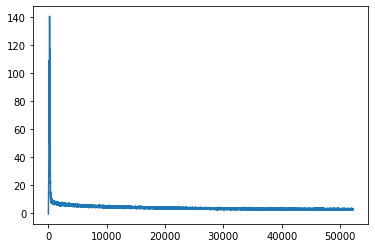

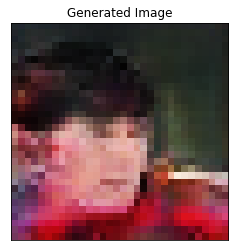

checkpointing at epoch: 50000
Iteration [50001/100000]......0.193(s) gen: 208.78516 - disc_fake: -209.05508 - disc_real: -206.19391 - disc_real: 2.86117
Iteration [50002/100000]......0.192(s) gen: 209.20929 - disc_fake: -209.01124 - disc_real: -206.04188 - disc_real: 2.96936
Iteration [50003/100000]......0.193(s) gen: 209.19342 - disc_fake: -208.97758 - disc_real: -206.29505 - disc_real: 2.68253
Iteration [50004/100000]......0.192(s) gen: 208.84271 - disc_fake: -208.87090 - disc_real: -206.38293 - disc_real: 2.48796
Iteration [50005/100000]......0.193(s) gen: 209.41382 - disc_fake: -209.08475 - disc_real: -206.70888 - disc_real: 2.37586
Iteration [50006/100000]......0.194(s) gen: 208.83385 - disc_fake: -208.86834 - disc_real: -206.56342 - disc_real: 2.30492
Iteration [50007/100000]......0.195(s) gen: 208.31944 - disc_fake: -208.52308 - disc_real: -206.03682 - disc_real: 2.48626
Iteration [50008/100000]......0.194(s) gen: 208.65338 - disc_fake: -208.39941 - disc_real: -205.74998 - disc_

Iteration [50068/100000]......0.198(s) gen: 208.59570 - disc_fake: -208.90977 - disc_real: -206.09632 - disc_real: 2.81345
Iteration [50069/100000]......0.195(s) gen: 208.35320 - disc_fake: -208.33741 - disc_real: -205.56119 - disc_real: 2.77622
Iteration [50070/100000]......0.198(s) gen: 208.78448 - disc_fake: -208.44505 - disc_real: -206.03074 - disc_real: 2.41430
Iteration [50071/100000]......0.199(s) gen: 208.22314 - disc_fake: -208.57089 - disc_real: -205.74542 - disc_real: 2.82547
Iteration [50072/100000]......0.200(s) gen: 208.27386 - disc_fake: -208.30929 - disc_real: -205.19717 - disc_real: 3.11212
Iteration [50073/100000]......0.195(s) gen: 208.06506 - disc_fake: -208.12822 - disc_real: -204.91056 - disc_real: 3.21766
Iteration [50074/100000]......0.194(s) gen: 208.04852 - disc_fake: -208.04327 - disc_real: -205.29347 - disc_real: 2.74980
Iteration [50075/100000]......0.192(s) gen: 208.23947 - disc_fake: -207.81223 - disc_real: -205.51014 - disc_real: 2.30208
Iteration [50076

Iteration [50135/100000]......0.195(s) gen: 207.44504 - disc_fake: -207.57021 - disc_real: -204.70550 - disc_real: 2.86471
Iteration [50136/100000]......0.195(s) gen: 207.72040 - disc_fake: -207.74591 - disc_real: -204.68487 - disc_real: 3.06105
Iteration [50137/100000]......0.196(s) gen: 206.87311 - disc_fake: -207.49996 - disc_real: -204.94092 - disc_real: 2.55903
Iteration [50138/100000]......0.197(s) gen: 207.58163 - disc_fake: -207.38610 - disc_real: -204.70017 - disc_real: 2.68593
Iteration [50139/100000]......0.195(s) gen: 207.70438 - disc_fake: -207.55298 - disc_real: -205.29151 - disc_real: 2.26147
Iteration [50140/100000]......0.196(s) gen: 207.99835 - disc_fake: -207.50430 - disc_real: -204.73254 - disc_real: 2.77176
Iteration [50141/100000]......0.198(s) gen: 207.87585 - disc_fake: -207.50094 - disc_real: -204.85186 - disc_real: 2.64908
Iteration [50142/100000]......0.197(s) gen: 208.78647 - disc_fake: -208.00910 - disc_real: -205.15738 - disc_real: 2.85172
Iteration [50143

Iteration [50203/100000]......0.196(s) gen: 209.02660 - disc_fake: -209.09703 - disc_real: -206.25336 - disc_real: 2.84367
Iteration [50204/100000]......0.196(s) gen: 208.66084 - disc_fake: -208.95921 - disc_real: -206.18903 - disc_real: 2.77018
Iteration [50205/100000]......0.196(s) gen: 208.37094 - disc_fake: -208.63092 - disc_real: -205.83468 - disc_real: 2.79624
Iteration [50206/100000]......0.195(s) gen: 208.13365 - disc_fake: -208.17831 - disc_real: -205.67609 - disc_real: 2.50222
Iteration [50207/100000]......0.194(s) gen: 208.46384 - disc_fake: -208.20470 - disc_real: -205.80685 - disc_real: 2.39785
Iteration [50208/100000]......0.196(s) gen: 208.57402 - disc_fake: -208.46539 - disc_real: -206.07106 - disc_real: 2.39432
Iteration [50209/100000]......0.197(s) gen: 208.71053 - disc_fake: -208.49554 - disc_real: -205.88404 - disc_real: 2.61150
Iteration [50210/100000]......0.195(s) gen: 209.32530 - disc_fake: -208.76953 - disc_real: -206.18212 - disc_real: 2.58740
Iteration [50211

Iteration [50270/100000]......0.203(s) gen: 208.45874 - disc_fake: -208.16869 - disc_real: -205.36055 - disc_real: 2.80814
Iteration [50271/100000]......0.202(s) gen: 208.27124 - disc_fake: -208.32733 - disc_real: -205.34820 - disc_real: 2.97913
Iteration [50272/100000]......0.204(s) gen: 208.30954 - disc_fake: -208.22410 - disc_real: -205.55721 - disc_real: 2.66690
Iteration [50273/100000]......0.200(s) gen: 208.15836 - disc_fake: -208.37429 - disc_real: -205.78417 - disc_real: 2.59012
Iteration [50274/100000]......0.200(s) gen: 208.58510 - disc_fake: -208.09523 - disc_real: -205.40630 - disc_real: 2.68893
Iteration [50275/100000]......0.196(s) gen: 208.50974 - disc_fake: -208.64786 - disc_real: -205.88310 - disc_real: 2.76476
Iteration [50276/100000]......0.196(s) gen: 208.45702 - disc_fake: -208.51837 - disc_real: -205.73640 - disc_real: 2.78197
Iteration [50277/100000]......0.195(s) gen: 208.27997 - disc_fake: -208.20053 - disc_real: -205.52633 - disc_real: 2.67420
Iteration [50278

Iteration [50337/100000]......0.198(s) gen: 208.59433 - disc_fake: -208.65078 - disc_real: -205.88766 - disc_real: 2.76312
Iteration [50338/100000]......0.197(s) gen: 208.75102 - disc_fake: -208.58573 - disc_real: -206.08720 - disc_real: 2.49853
Iteration [50339/100000]......0.197(s) gen: 209.34039 - disc_fake: -208.90144 - disc_real: -206.36407 - disc_real: 2.53737
Iteration [50340/100000]......0.196(s) gen: 209.30588 - disc_fake: -209.07984 - disc_real: -206.36312 - disc_real: 2.71672
Iteration [50341/100000]......0.198(s) gen: 208.89978 - disc_fake: -208.57648 - disc_real: -205.94193 - disc_real: 2.63455
Iteration [50342/100000]......0.197(s) gen: 208.51662 - disc_fake: -208.42139 - disc_real: -205.58845 - disc_real: 2.83294
Iteration [50343/100000]......0.199(s) gen: 208.91829 - disc_fake: -208.29789 - disc_real: -206.20300 - disc_real: 2.09488
Iteration [50344/100000]......0.199(s) gen: 209.33420 - disc_fake: -208.80410 - disc_real: -206.14904 - disc_real: 2.65506
Iteration [50345

Iteration [50404/100000]......0.201(s) gen: 208.06566 - disc_fake: -208.20381 - disc_real: -205.37345 - disc_real: 2.83036
Iteration [50405/100000]......0.203(s) gen: 208.31766 - disc_fake: -208.17790 - disc_real: -205.51323 - disc_real: 2.66467
Iteration [50406/100000]......0.203(s) gen: 208.57693 - disc_fake: -208.21076 - disc_real: -205.60667 - disc_real: 2.60409
Iteration [50407/100000]......0.201(s) gen: 208.59203 - disc_fake: -208.65394 - disc_real: -205.61634 - disc_real: 3.03760
Iteration [50408/100000]......0.200(s) gen: 209.50455 - disc_fake: -208.91482 - disc_real: -206.14829 - disc_real: 2.76653
Iteration [50409/100000]......0.200(s) gen: 210.09599 - disc_fake: -209.49009 - disc_real: -206.54302 - disc_real: 2.94707
Iteration [50410/100000]......0.199(s) gen: 209.85442 - disc_fake: -209.79516 - disc_real: -206.96676 - disc_real: 2.82840
Iteration [50411/100000]......0.200(s) gen: 209.33722 - disc_fake: -209.78827 - disc_real: -206.49291 - disc_real: 3.29536
Iteration [50412

Iteration [50471/100000]......0.198(s) gen: 209.63992 - disc_fake: -209.56532 - disc_real: -207.09460 - disc_real: 2.47072
Iteration [50472/100000]......0.197(s) gen: 209.54054 - disc_fake: -209.65336 - disc_real: -206.79734 - disc_real: 2.85602
Iteration [50473/100000]......0.197(s) gen: 209.06676 - disc_fake: -209.36985 - disc_real: -206.68891 - disc_real: 2.68094
Iteration [50474/100000]......0.197(s) gen: 209.41405 - disc_fake: -209.63797 - disc_real: -206.70362 - disc_real: 2.93434
Iteration [50475/100000]......0.198(s) gen: 209.20941 - disc_fake: -209.42135 - disc_real: -206.58042 - disc_real: 2.84092
Iteration [50476/100000]......0.196(s) gen: 209.06818 - disc_fake: -209.05461 - disc_real: -206.61706 - disc_real: 2.43755
Iteration [50477/100000]......0.197(s) gen: 209.07774 - disc_fake: -209.19046 - disc_real: -206.60817 - disc_real: 2.58229
Iteration [50478/100000]......0.199(s) gen: 209.29480 - disc_fake: -209.34816 - disc_real: -206.74571 - disc_real: 2.60245
Iteration [50479

Iteration [50538/100000]......0.204(s) gen: 209.82285 - disc_fake: -209.51338 - disc_real: -207.28604 - disc_real: 2.22733
Iteration [50539/100000]......0.203(s) gen: 209.87308 - disc_fake: -209.49952 - disc_real: -206.94019 - disc_real: 2.55933
Iteration [50540/100000]......0.200(s) gen: 209.52177 - disc_fake: -209.51616 - disc_real: -206.71714 - disc_real: 2.79901
Iteration [50541/100000]......0.200(s) gen: 209.54477 - disc_fake: -209.37860 - disc_real: -206.80789 - disc_real: 2.57071
Iteration [50542/100000]......0.198(s) gen: 209.77866 - disc_fake: -209.69085 - disc_real: -206.89094 - disc_real: 2.79991
Iteration [50543/100000]......0.197(s) gen: 209.85037 - disc_fake: -209.74866 - disc_real: -207.05785 - disc_real: 2.69081
Iteration [50544/100000]......0.193(s) gen: 209.00497 - disc_fake: -209.47884 - disc_real: -207.14275 - disc_real: 2.33609
Iteration [50545/100000]......0.195(s) gen: 208.45880 - disc_fake: -209.04854 - disc_real: -205.92515 - disc_real: 3.12339
Iteration [50546

Iteration [50605/100000]......0.195(s) gen: 210.12701 - disc_fake: -209.75520 - disc_real: -207.14429 - disc_real: 2.61091
Iteration [50606/100000]......0.196(s) gen: 209.72607 - disc_fake: -209.92046 - disc_real: -206.86254 - disc_real: 3.05792
Iteration [50607/100000]......0.197(s) gen: 208.95761 - disc_fake: -209.41445 - disc_real: -206.76162 - disc_real: 2.65283
Iteration [50608/100000]......0.198(s) gen: 209.02234 - disc_fake: -208.98036 - disc_real: -206.05595 - disc_real: 2.92440
Iteration [50609/100000]......0.201(s) gen: 209.14346 - disc_fake: -208.55129 - disc_real: -205.95009 - disc_real: 2.60120
Iteration [50610/100000]......0.203(s) gen: 209.19119 - disc_fake: -208.74153 - disc_real: -206.29322 - disc_real: 2.44831
Iteration [50611/100000]......0.205(s) gen: 209.24490 - disc_fake: -208.89738 - disc_real: -206.26774 - disc_real: 2.62964
Iteration [50612/100000]......0.205(s) gen: 209.10315 - disc_fake: -209.25155 - disc_real: -206.46012 - disc_real: 2.79143
Iteration [50613

Iteration [50673/100000]......0.199(s) gen: 208.89151 - disc_fake: -208.99546 - disc_real: -206.32072 - disc_real: 2.67474
Iteration [50674/100000]......0.197(s) gen: 209.10194 - disc_fake: -209.03719 - disc_real: -206.23679 - disc_real: 2.80039
Iteration [50675/100000]......0.196(s) gen: 208.73344 - disc_fake: -209.16554 - disc_real: -206.08427 - disc_real: 3.08127
Iteration [50676/100000]......0.197(s) gen: 208.94131 - disc_fake: -208.79070 - disc_real: -205.89111 - disc_real: 2.89959
Iteration [50677/100000]......0.201(s) gen: 209.22871 - disc_fake: -208.87802 - disc_real: -206.28275 - disc_real: 2.59527
Iteration [50678/100000]......0.202(s) gen: 209.78770 - disc_fake: -209.35207 - disc_real: -206.79046 - disc_real: 2.56160
Iteration [50679/100000]......0.203(s) gen: 209.54915 - disc_fake: -209.96854 - disc_real: -206.80511 - disc_real: 3.16342
Iteration [50680/100000]......0.202(s) gen: 209.89316 - disc_fake: -209.58200 - disc_real: -206.84499 - disc_real: 2.73701
Iteration [50681

Iteration [50740/100000]......0.198(s) gen: 208.71150 - disc_fake: -208.79914 - disc_real: -206.06287 - disc_real: 2.73627
Iteration [50741/100000]......0.198(s) gen: 209.50067 - disc_fake: -208.75432 - disc_real: -205.98568 - disc_real: 2.76865
Iteration [50742/100000]......0.198(s) gen: 209.82307 - disc_fake: -209.45742 - disc_real: -206.87596 - disc_real: 2.58146
Iteration [50743/100000]......0.197(s) gen: 210.20978 - disc_fake: -209.82567 - disc_real: -207.21955 - disc_real: 2.60612
Iteration [50744/100000]......0.197(s) gen: 210.61259 - disc_fake: -210.36350 - disc_real: -207.74111 - disc_real: 2.62239
Iteration [50745/100000]......0.196(s) gen: 210.31778 - disc_fake: -210.28176 - disc_real: -207.83940 - disc_real: 2.44236
Iteration [50746/100000]......0.196(s) gen: 210.08914 - disc_fake: -210.32748 - disc_real: -207.70119 - disc_real: 2.62629
Iteration [50747/100000]......0.194(s) gen: 210.17824 - disc_fake: -210.10528 - disc_real: -207.47627 - disc_real: 2.62900
Iteration [50748

Iteration [50807/100000]......0.206(s) gen: 209.75256 - disc_fake: -209.73453 - disc_real: -206.67071 - disc_real: 3.06382
Iteration [50808/100000]......0.209(s) gen: 209.37390 - disc_fake: -209.24637 - disc_real: -206.62893 - disc_real: 2.61744
Iteration [50809/100000]......0.207(s) gen: 209.44797 - disc_fake: -209.22304 - disc_real: -206.49713 - disc_real: 2.72592
Iteration [50810/100000]......0.205(s) gen: 209.38744 - disc_fake: -209.01891 - disc_real: -206.48619 - disc_real: 2.53272
Iteration [50811/100000]......0.202(s) gen: 208.93887 - disc_fake: -209.01343 - disc_real: -206.33068 - disc_real: 2.68276
Iteration [50812/100000]......0.201(s) gen: 209.02333 - disc_fake: -208.88725 - disc_real: -206.53759 - disc_real: 2.34966
Iteration [50813/100000]......0.203(s) gen: 209.75587 - disc_fake: -209.16237 - disc_real: -206.59811 - disc_real: 2.56425
Iteration [50814/100000]......0.201(s) gen: 209.50220 - disc_fake: -209.48161 - disc_real: -207.13395 - disc_real: 2.34766
Iteration [50815

Iteration [50874/100000]......0.198(s) gen: 209.93326 - disc_fake: -210.37809 - disc_real: -207.50509 - disc_real: 2.87299
Iteration [50875/100000]......0.197(s) gen: 209.82985 - disc_fake: -210.04230 - disc_real: -207.23508 - disc_real: 2.80723
Iteration [50876/100000]......0.200(s) gen: 209.52237 - disc_fake: -209.86192 - disc_real: -206.93803 - disc_real: 2.92389
Iteration [50877/100000]......0.196(s) gen: 209.37119 - disc_fake: -209.63414 - disc_real: -207.19087 - disc_real: 2.44326
Iteration [50878/100000]......0.196(s) gen: 209.27368 - disc_fake: -209.14256 - disc_real: -206.44997 - disc_real: 2.69259
Iteration [50879/100000]......0.197(s) gen: 208.99405 - disc_fake: -209.16967 - disc_real: -206.40596 - disc_real: 2.76371
Iteration [50880/100000]......0.194(s) gen: 208.56497 - disc_fake: -208.83405 - disc_real: -206.14966 - disc_real: 2.68440
Iteration [50881/100000]......0.197(s) gen: 209.06525 - disc_fake: -208.85214 - disc_real: -206.17915 - disc_real: 2.67299
Iteration [50882

Iteration [50941/100000]......0.200(s) gen: 210.96725 - disc_fake: -210.88661 - disc_real: -208.23940 - disc_real: 2.64721
Iteration [50942/100000]......0.200(s) gen: 210.86237 - disc_fake: -211.33616 - disc_real: -208.62581 - disc_real: 2.71035
Iteration [50943/100000]......0.200(s) gen: 210.72620 - disc_fake: -211.20759 - disc_real: -208.68189 - disc_real: 2.52570
Iteration [50944/100000]......0.200(s) gen: 210.44014 - disc_fake: -210.75694 - disc_real: -207.92001 - disc_real: 2.83693
Iteration [50945/100000]......0.201(s) gen: 210.14810 - disc_fake: -210.35054 - disc_real: -207.55344 - disc_real: 2.79709
Iteration [50946/100000]......0.201(s) gen: 209.87263 - disc_fake: -209.98082 - disc_real: -207.16170 - disc_real: 2.81912
Iteration [50947/100000]......0.202(s) gen: 209.70377 - disc_fake: -209.66999 - disc_real: -207.04679 - disc_real: 2.62320
Iteration [50948/100000]......0.203(s) gen: 210.02411 - disc_fake: -209.95062 - disc_real: -207.19209 - disc_real: 2.75852
Iteration [50949

Iteration [51009/100000]......0.198(s) gen: 209.03078 - disc_fake: -208.99811 - disc_real: -206.30202 - disc_real: 2.69609
Iteration [51010/100000]......0.195(s) gen: 209.36426 - disc_fake: -208.99633 - disc_real: -206.56063 - disc_real: 2.43571
Iteration [51011/100000]......0.198(s) gen: 209.54533 - disc_fake: -209.27297 - disc_real: -206.71967 - disc_real: 2.55331
Iteration [51012/100000]......0.198(s) gen: 209.73251 - disc_fake: -209.38543 - disc_real: -206.85371 - disc_real: 2.53172
Iteration [51013/100000]......0.198(s) gen: 209.35239 - disc_fake: -209.65049 - disc_real: -206.89035 - disc_real: 2.76014
Iteration [51014/100000]......0.198(s) gen: 209.84090 - disc_fake: -209.31945 - disc_real: -206.81393 - disc_real: 2.50552
Iteration [51015/100000]......0.200(s) gen: 209.72809 - disc_fake: -209.56546 - disc_real: -206.34908 - disc_real: 3.21638
Iteration [51016/100000]......0.201(s) gen: 209.63786 - disc_fake: -209.61395 - disc_real: -207.02300 - disc_real: 2.59095
Iteration [51017

Iteration [51076/100000]......0.198(s) gen: 210.67194 - disc_fake: -210.72837 - disc_real: -208.00590 - disc_real: 2.72247
Iteration [51077/100000]......0.196(s) gen: 210.62776 - disc_fake: -210.76335 - disc_real: -207.93021 - disc_real: 2.83314
Iteration [51078/100000]......0.195(s) gen: 210.41154 - disc_fake: -210.61777 - disc_real: -207.56168 - disc_real: 3.05610
Iteration [51079/100000]......0.198(s) gen: 210.40460 - disc_fake: -210.52870 - disc_real: -207.69493 - disc_real: 2.83377
Iteration [51080/100000]......0.196(s) gen: 210.24023 - disc_fake: -209.97759 - disc_real: -207.52311 - disc_real: 2.45449
Iteration [51081/100000]......0.194(s) gen: 209.93193 - disc_fake: -209.59915 - disc_real: -206.83687 - disc_real: 2.76227
Iteration [51082/100000]......0.196(s) gen: 209.93954 - disc_fake: -210.01654 - disc_real: -207.19248 - disc_real: 2.82406
Iteration [51083/100000]......0.197(s) gen: 209.39297 - disc_fake: -209.63886 - disc_real: -206.63531 - disc_real: 3.00355
Iteration [51084

Iteration [51143/100000]......0.200(s) gen: 210.12782 - disc_fake: -209.91513 - disc_real: -207.25439 - disc_real: 2.66074
Iteration [51144/100000]......0.199(s) gen: 209.23175 - disc_fake: -209.81204 - disc_real: -207.07891 - disc_real: 2.73313
Iteration [51145/100000]......0.204(s) gen: 210.06647 - disc_fake: -209.30554 - disc_real: -207.25605 - disc_real: 2.04949
Iteration [51146/100000]......0.207(s) gen: 210.76025 - disc_fake: -210.00191 - disc_real: -207.26844 - disc_real: 2.73347
Iteration [51147/100000]......0.207(s) gen: 210.37999 - disc_fake: -210.36991 - disc_real: -207.86373 - disc_real: 2.50618
Iteration [51148/100000]......0.205(s) gen: 210.56671 - disc_fake: -210.53349 - disc_real: -207.58499 - disc_real: 2.94850
Iteration [51149/100000]......0.202(s) gen: 210.69064 - disc_fake: -210.40725 - disc_real: -207.51401 - disc_real: 2.89324
Iteration [51150/100000]......0.202(s) gen: 211.54857 - disc_fake: -210.88466 - disc_real: -208.18965 - disc_real: 2.69502
Iteration [51151

In [ ]:
import time
from pathlib import Path

start_epoch = 10000
epochs = 100000
batch_size = 64
checkpoint_every_n_epochs = 10000
figure_every_n_epochs = 5000
n_critic = 5



plt.ioff()

model_type = f'sa-wgan-gp'
data_name = f'celeba'

#create base dir
base_model_path = Path(f'./model-data/{model_type}/{data_name}')
base_model_path.mkdir(parents=True, exist_ok=True)

#create figure dir
figure_model_path = base_model_path / 'figures'
figure_model_path.mkdir(parents=True, exist_ok=True)

#create checkpoint dir
checkpoints_model_path = base_model_path / 'checkpoints'
checkpoints_model_path.mkdir(parents=True, exist_ok=True)


with tf.device('gpu:0'):
    
    if start_epoch == 1:
        training_imgs = np.cast['float32'](training_data[0])
        num_batches = len(training_imgs) // batch_size
        # losses
        rl_lo_loss_list = [] 
        rl_med_loss_list = [] 
        rl_hi_loss_list = [] 
        kl_loss_list = []
        gen_loss_list = []
        disc_real_list = []
        disc_fake_list = []
        mu, sigma = 0, 1 #mean and standard deviation
        test_noise = np.random.normal(mu, sigma, (1,latent_dim))
    

    rl_lo_loss = 0
    rl_med_loss = 0
    rl_hi_loss = 0
    kl_loss = 0
    gen_loss = 0

    
    for epoch in range(start_epoch,epochs+1):
        start = time.time()
        print(f'Iteration [{epoch}/{epochs}]...'.ljust(20), end = '')
 

        
        disc_real_sum = 0
        disc_fake_sum = 0
        for _ in range(n_critic):
            idxs_batch = np.random.randint(0,len(training_imgs)-1,size=batch_size)
            img_batch = training_imgs[idxs_batch]
            disc_real, disc_fake = train_step_discriminator(img_batch)
            disc_real_sum += K.get_value(disc_real)
            disc_fake_sum += K.get_value(disc_fake)            
        
        
        gen_loss = train_step_generator()
        
        
        
        disc_real = disc_real_sum/n_critic
        disc_fake = disc_fake_sum/n_critic
        gen_loss = K.get_value(gen_loss)

        
        
        disc_real_list.append(disc_real)
        disc_fake_list.append(disc_fake)
        gen_loss_list.append(gen_loss)

        
        print(f'...{time.time()-start:.3f}(s) '  , end='')        
        
        print(f'gen: {gen_loss:.5f} - ', end='')
        print(f'disc_fake: {disc_fake:.5f} - ', end='')
        print(f'disc_real: {disc_real:.5f} - ', end='')
        print(f'neg_critic: {disc_real - disc_fake:.5f}')


        

        if epoch % figure_every_n_epochs == 0:
            
             # plot fig for r - f to observe convergence
            negative_critic_loss = np.array(disc_real_list)-np.array(disc_fake_list)
            plt.plot(negative_critic_loss, label="negative_critic")
            plt.show()
            
            gen_img = unnormalize_tanh( generator.predict(test_noise)[0])        
            plt.imshow(gen_img.reshape(32,32,3))
            plt.title("Generated Image")
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.savefig(figure_model_path / f'generated-{epoch}.png')
            plt.show()


        if epoch % checkpoint_every_n_epochs == 0 and epoch != 0:        
            print(f'checkpointing at epoch: {epoch}')
            generator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator-weights.h5').as_posix())
#             generator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-generator.h5').as_posix())
            discriminator.save_weights((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator-weights.h5').as_posix())
#             discriminator.save((checkpoints_model_path / f'epoch-{epoch}-{model_type}-discriminator.h5').as_posix())
            

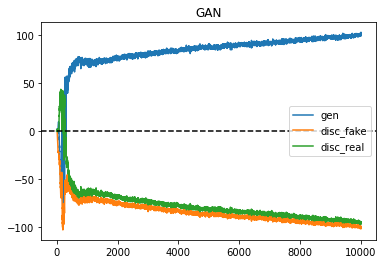

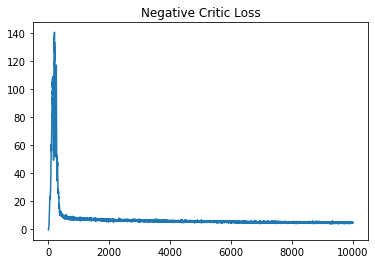

In [22]:


plt.plot(gen_loss_list, label="gen")
plt.plot(disc_fake_list, label="disc_fake")
plt.plot(disc_real_list, label="disc_real")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.title("GAN")
plt.savefig(figure_model_path / 'gan.png')
plt.show()

negative_critic_loss  = np.array(disc_real_list)-np.array(disc_fake_list)
plt.plot(negative_critic_loss)
plt.title("Negative Critic Loss")
plt.savefig(figure_model_path / 'negative_critic.png')
plt.show()

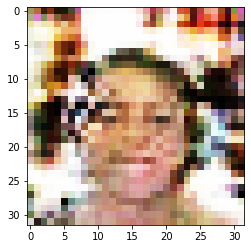

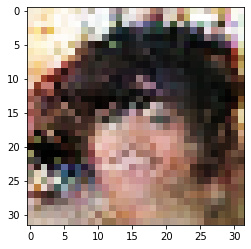

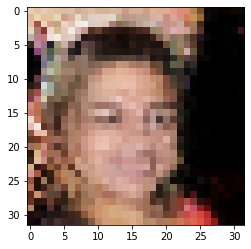

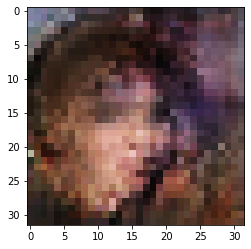

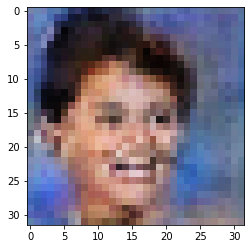

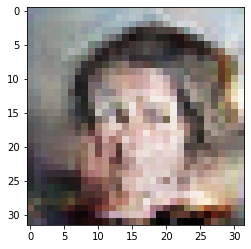

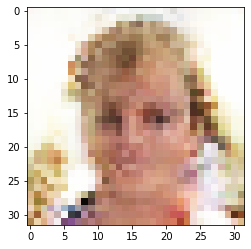

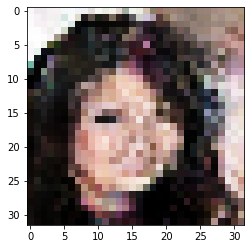

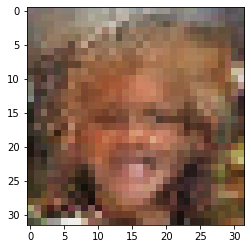

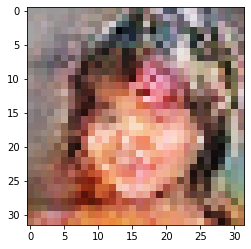

In [23]:
# Some sample generated faces
for i in range(10):
    noise = np.random.normal(0,1, (1,100))
    gen_img = unnormalize_tanh( generator.predict(noise)[0])        
    plt.imshow(gen_img.reshape(32,32,3))
    plt.show()

In [25]:
validation_generator = training_data_generator.flow_from_dataframe(
    dataframe=df,
    directory='../celeba-clean-64/',
    x_col="img",
    y_col=list(df.columns[1:]),
    target_size=(32, 32),
    subset='validation',
    shuffle=True,
    batch_size=32,
    class_mode='raw')

Found 40519 validated image filenames.


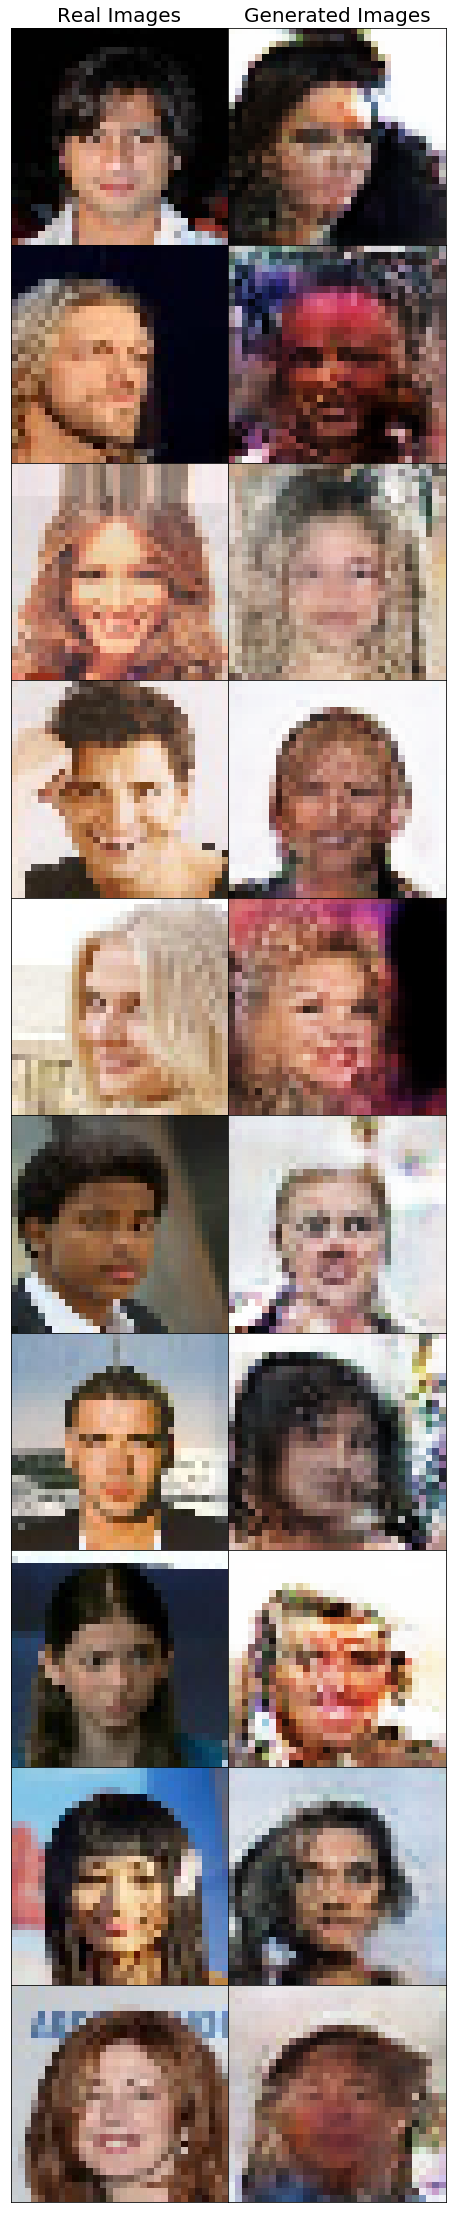

In [27]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(200., 40.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 2),  # creates 2x2 grid of axes
                 axes_pad=0.0,  # pad between axes in inch.
                 )

val_data = validation_generator.next()
for i in range(20):
    if i % 2 == 0:
        grid[i].imshow(unnormalize_tanh(val_data[0][i]))
        grid[i].set_xticks([])
        grid[i].set_yticks([])
    
    else:
        noise = np.random.normal(0,1, (1,100))
        gen_img = unnormalize_tanh( generator.predict(noise)[0])  
        grid[i].imshow(gen_img)
        grid[i].set_xticks([])
        grid[i].set_yticks([])
grid[0].set_title('Real Images', fontsize=20.)
grid[1].set_title('Generated Images', fontsize=20.)
plt.show()